# Policy Gradient

> <span style="color:gray">
Created by Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk)).
</span>

In this part, we will create an agent that can learn to solve tasks from OpenAI Gym by applying the Policy Gradient method. We will implement the agent with a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

Since this is a deep learning course, we will model the policy as a neural network with parameters $\theta$ and train it with gradient descent (now the name 'Policy Gradient' should start to make sense). 
When the set of available actions is discrete, we can use a network with softmax output. 

The core idea of training the policy network is simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

The expectation over the (discounted) total reward, $R$, is:

$$
\mathbb{E}[R|\theta] = \int p_\theta({\bf a}|{\bf s}) R({\bf a}) d{\bf a} \ ,
$$

where ${\bf a} = a_1,\ldots,a_T$, ${\bf s}=s_1,\ldots,s_T$. 

Then we can use the gradient to maximize the total reward:

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \int \nabla_\theta p_\theta({\bf a}|{\bf s}) R({\bf a})  \, d{\bf a} \\
&= \int p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \mathbb{E}[R({\bf a}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})]
\end{align}
$$

using the identity 

$$
\nabla_\theta p_\theta({\bf a}|{\bf s}) = p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})
$$

to express the gradient as an average over $p_\theta({\bf a},{\bf s})$.

We cannot evaluate the average over roll-outs analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return the sequence of action, states and rewards. This allows us to replace the integral by a Monte Carlo average over $V$ roll-outs:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) R({\bf a}^{(v)}) \ .
$$

In practice, to reduce the variance of the gradient, instead of $R$, we use the adjusted discounted future reward, also known as the *advantage*, $A$:

$$
A_t = R_t - b_t \ ,
$$

where the *baseline*, $b_t$, is the (discounted) total future reward at timestep $t$ averaged over the $V$ roll-outs:

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

This way we are always encouraging and discouraging roughly half of the performed actions, which gives us the final gradient estimator:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) A({\bf a}^{(v)})
$$

And that's it! Please refer to [this blog post](http://karpathy.github.io/2016/05/31/rl/) by Karpathy for more discussion on the Policy Gradient method.

--

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy Gradient code

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import gym
from utils import Viewer

In this lab we will work with the [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) environment. Later you can change the code below to explore other [environments](https://gym.openai.com/envs/) and solve different tasks. 

*Note: The policy implemented in this notebook is designed to work on environments with a discrete action space. Extending the code to also handle environments with a continuous action space is left as an optional exercise.*

In [2]:
# create gym environment
env = gym.make('CartPole-v0')

[2017-10-22 11:44:03,744] Making new env: CartPole-v0


Let us see how the environment looks when we just take random actions.

[2017-10-22 13:11:19,944] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



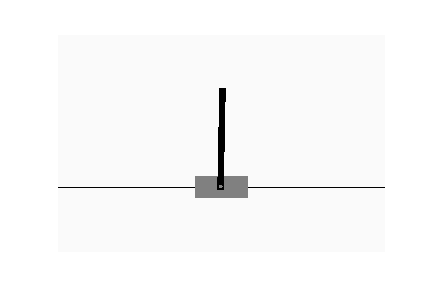
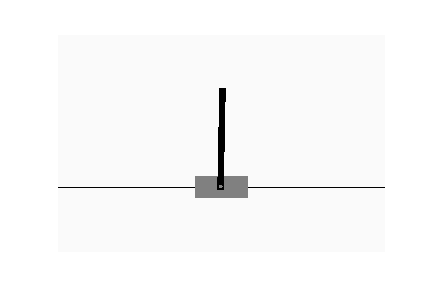
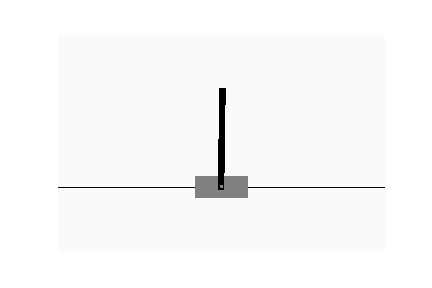
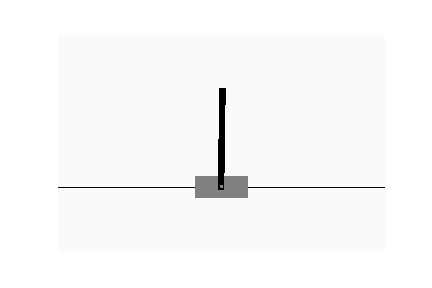
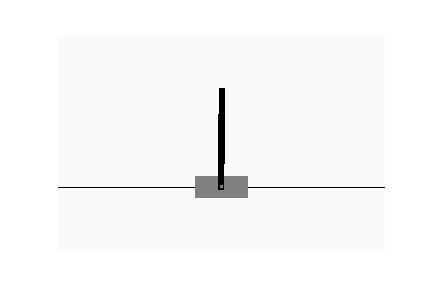
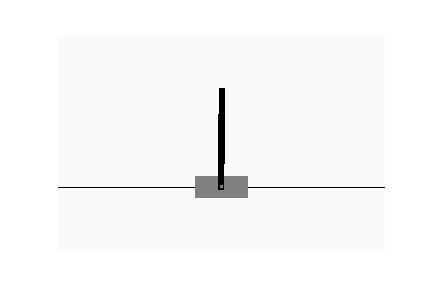
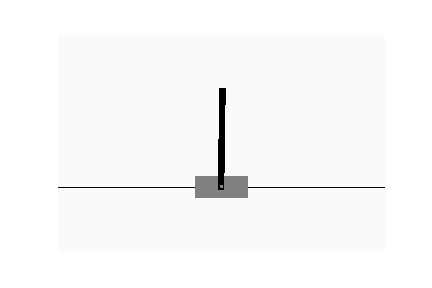
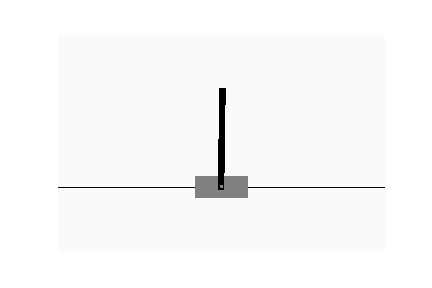
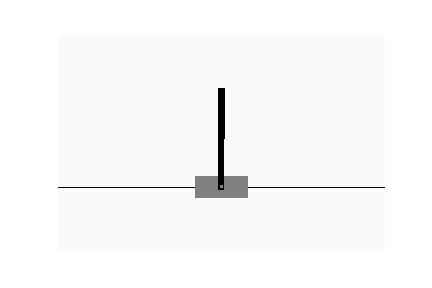
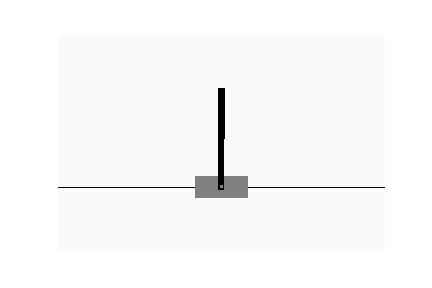
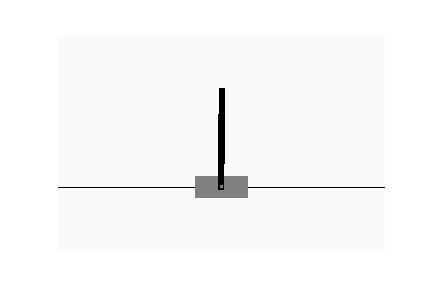
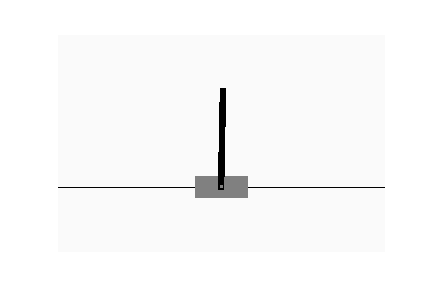
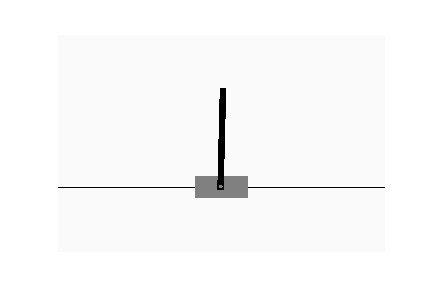
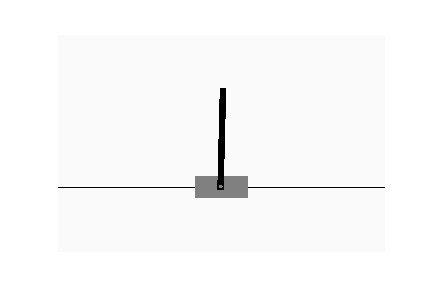
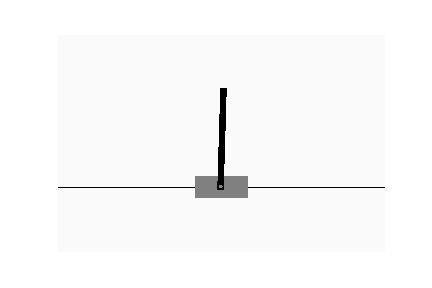
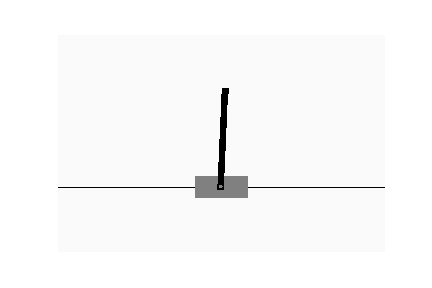
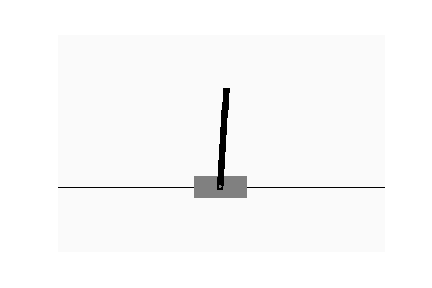
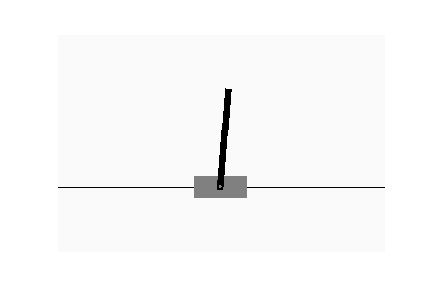
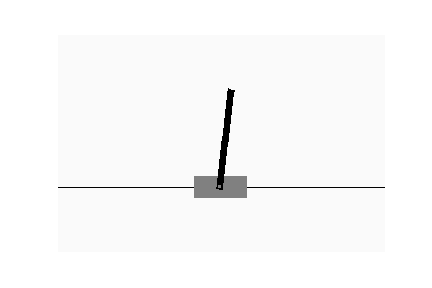
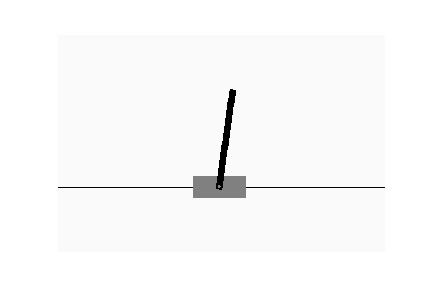
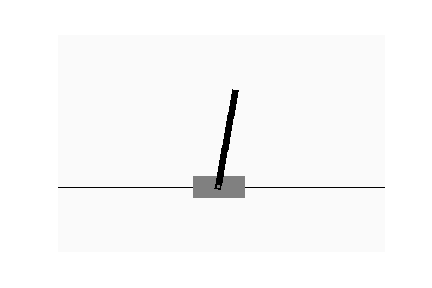
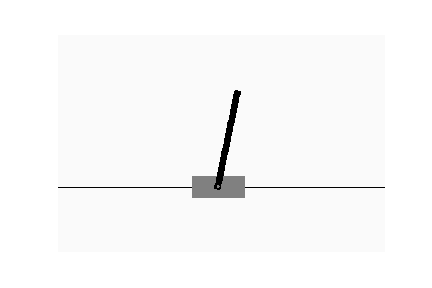
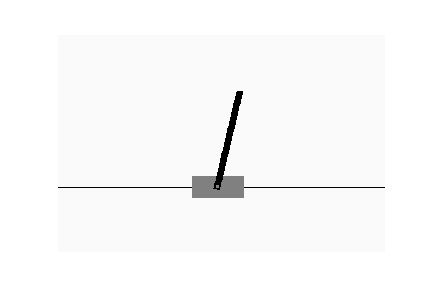
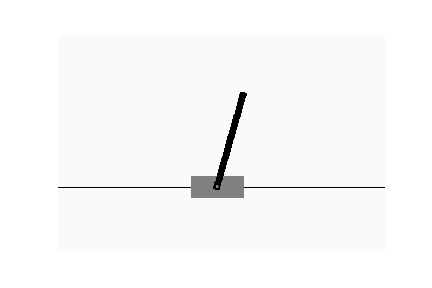
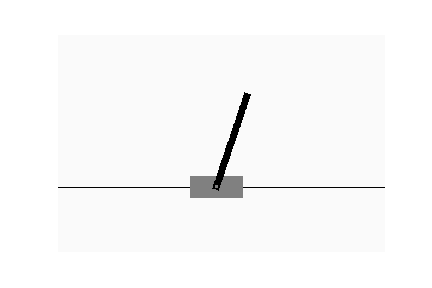
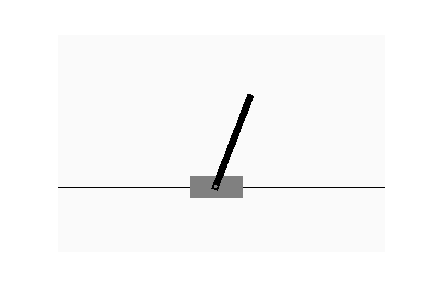
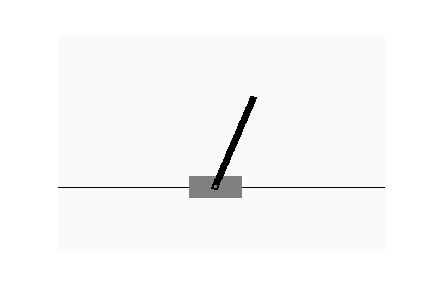
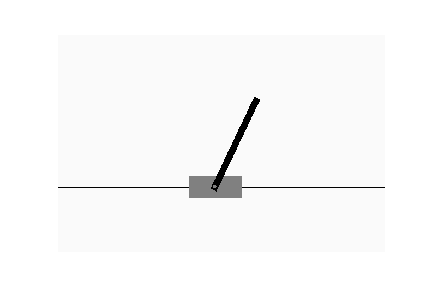
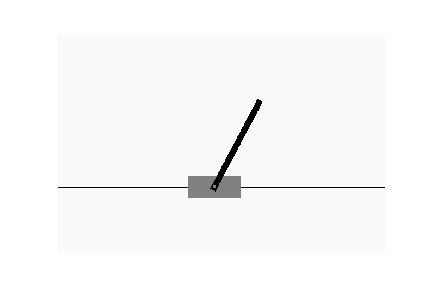
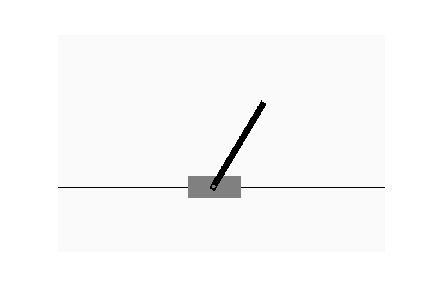
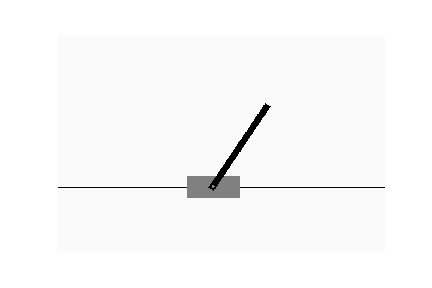
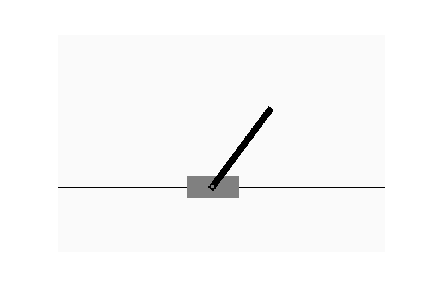
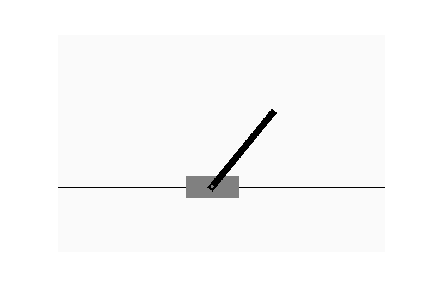
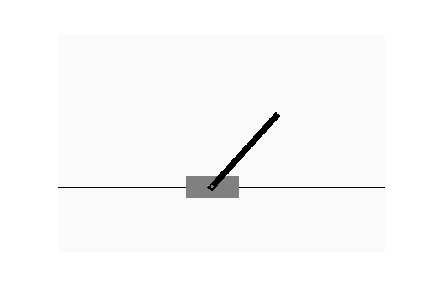
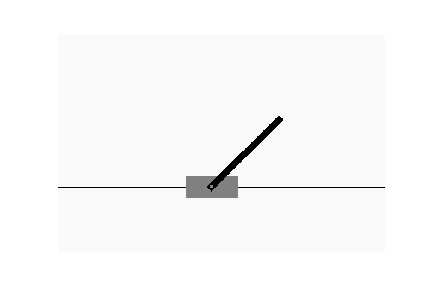
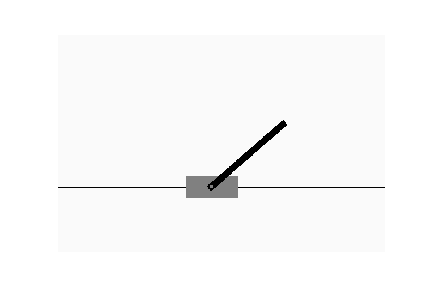
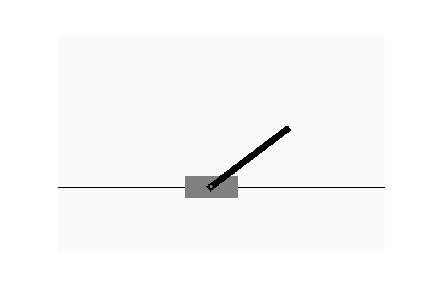
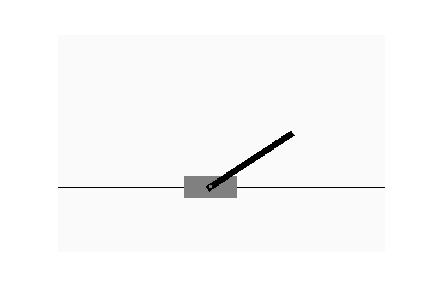
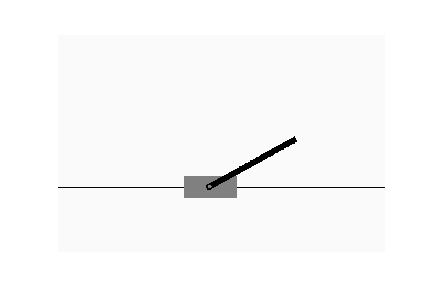
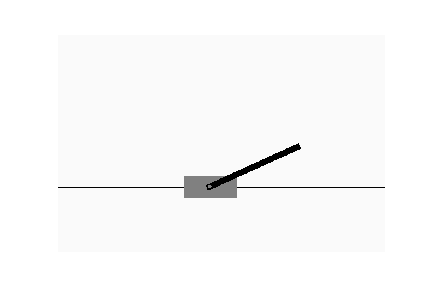
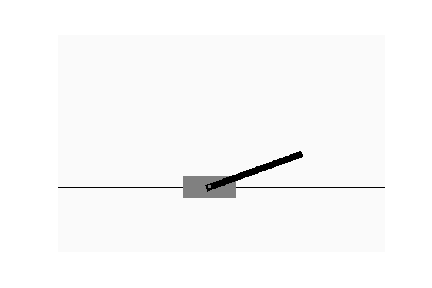
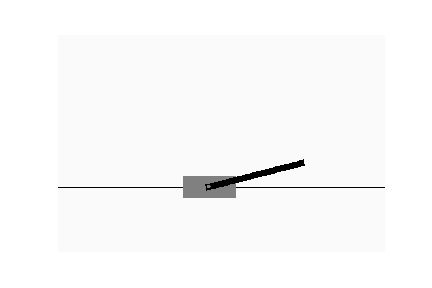
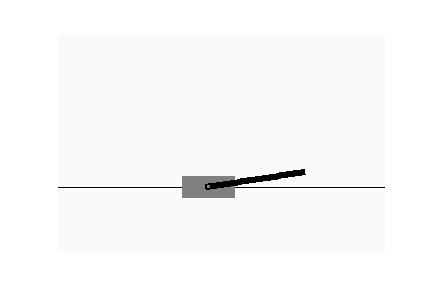
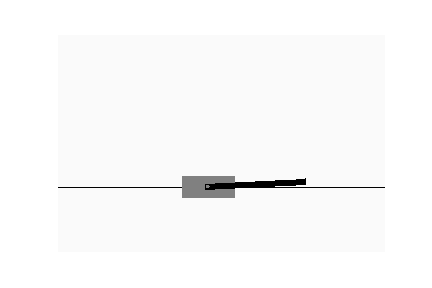
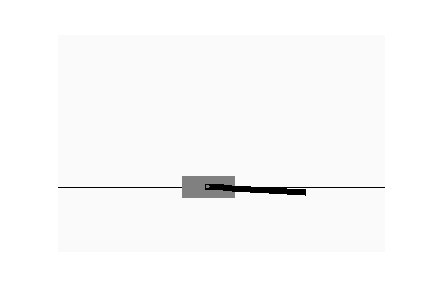
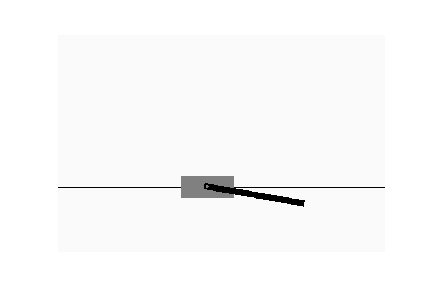
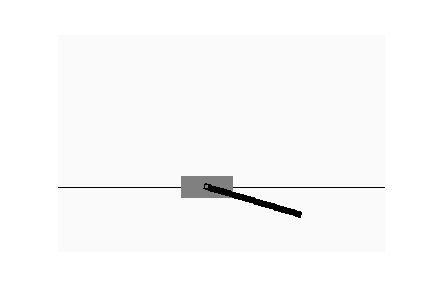
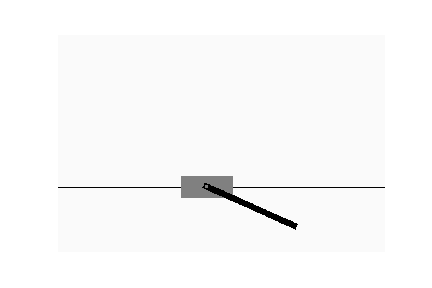
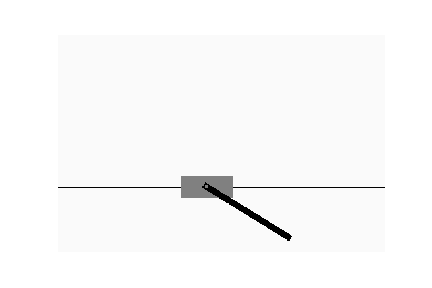
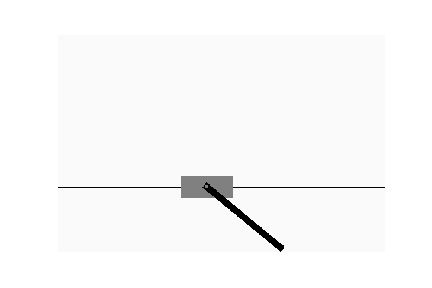
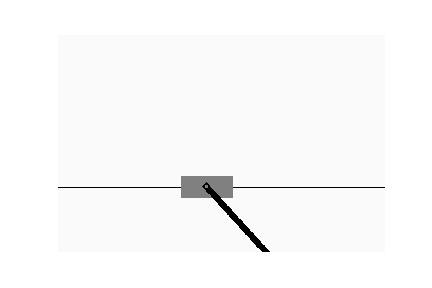
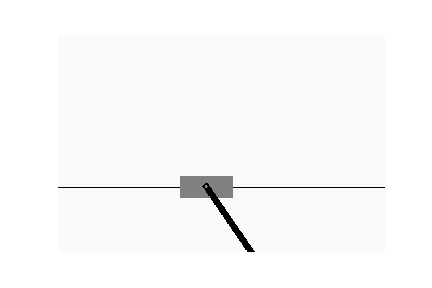
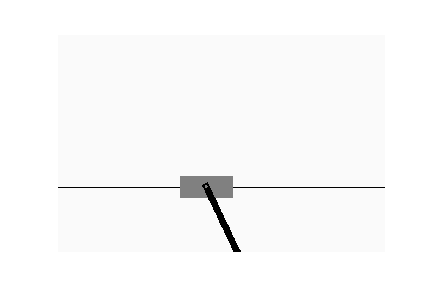
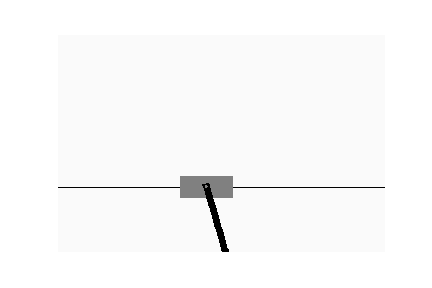
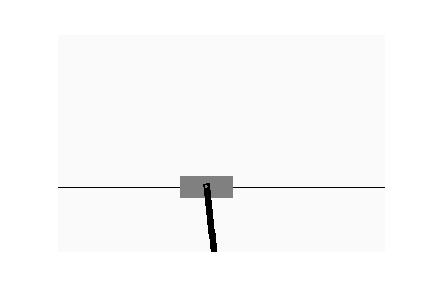
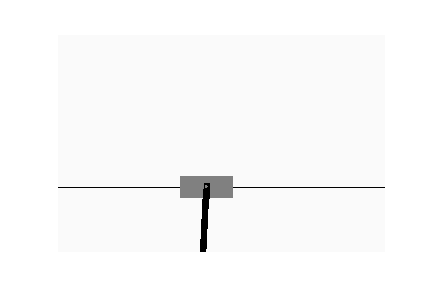
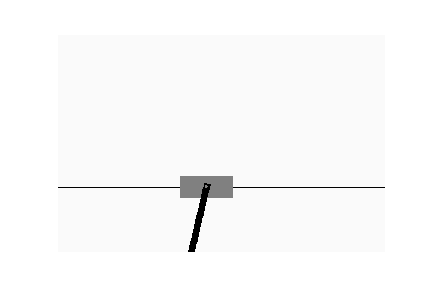
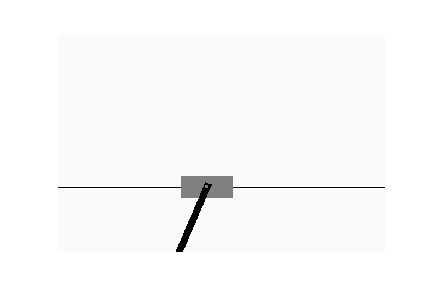
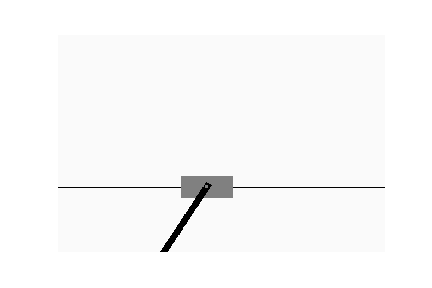
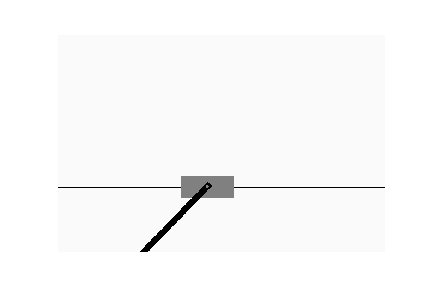
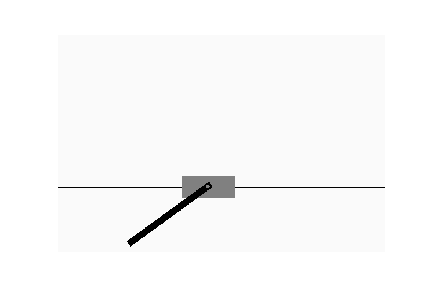
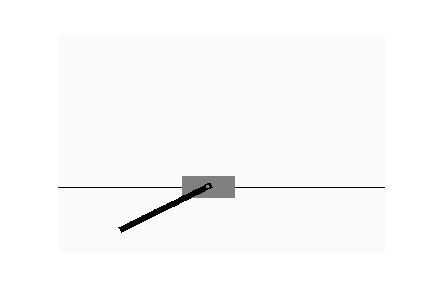
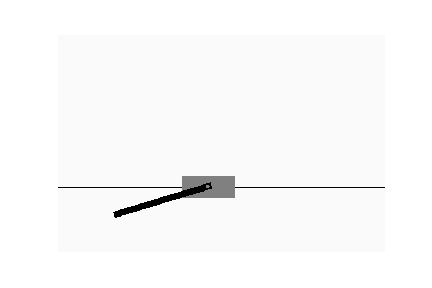
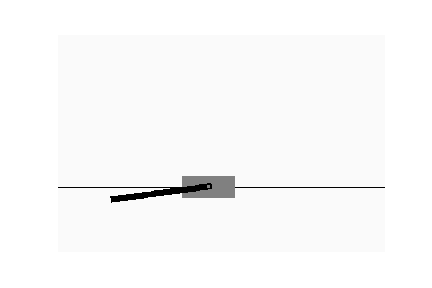
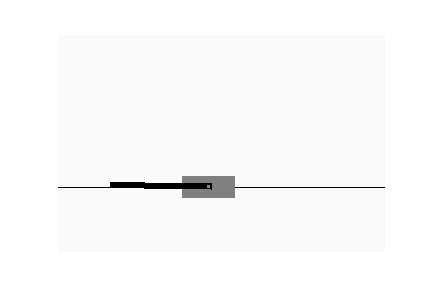
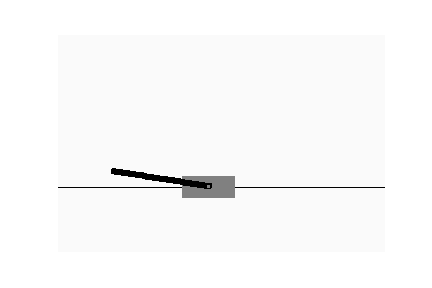
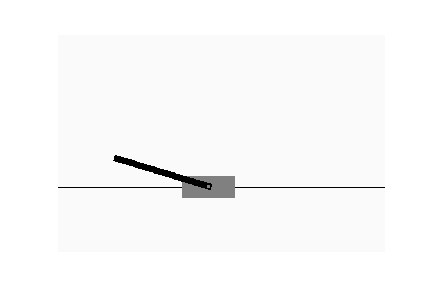
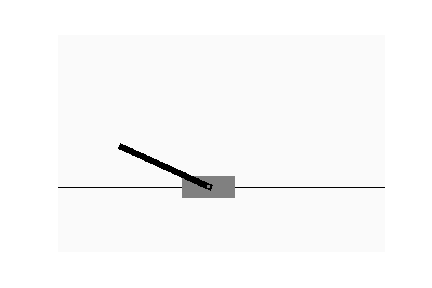
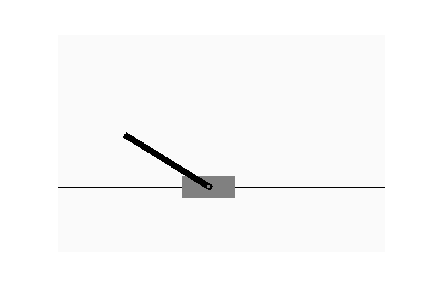
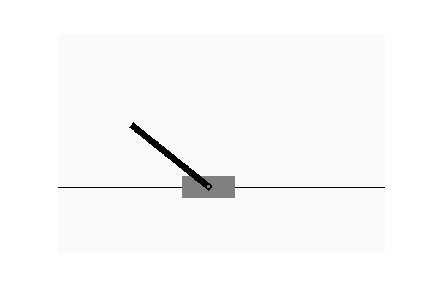
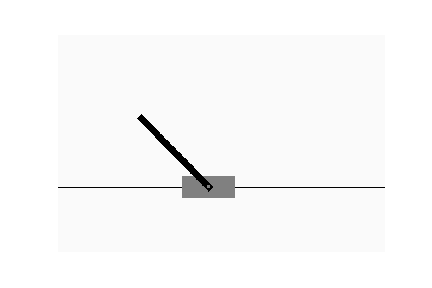
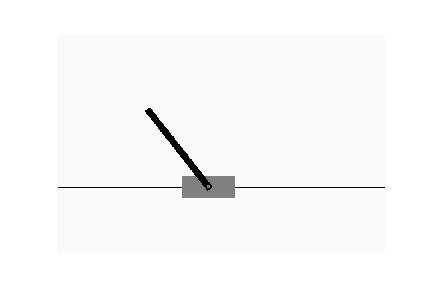
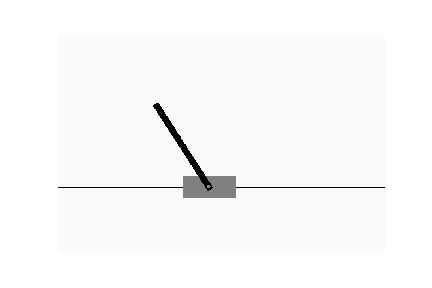
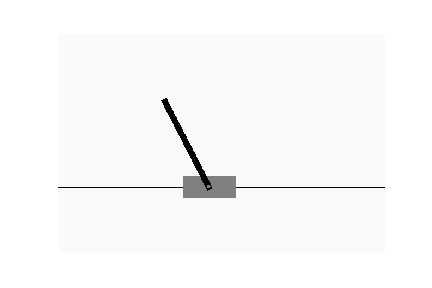
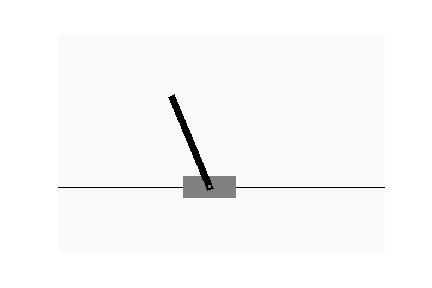
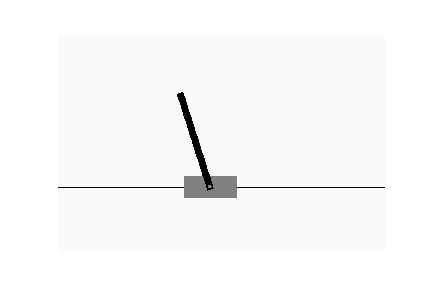
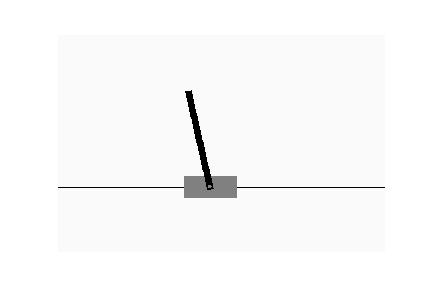
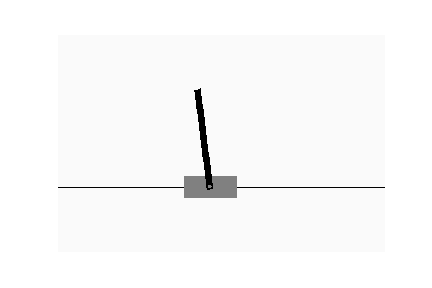
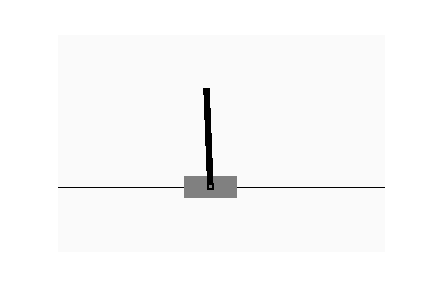
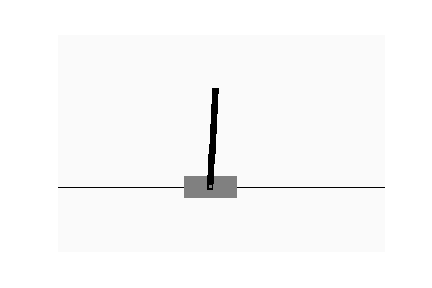
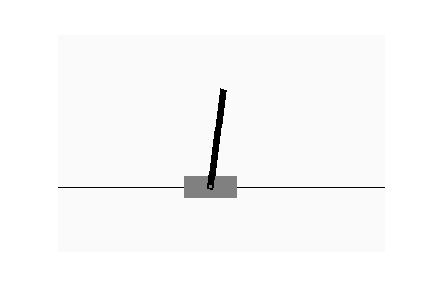
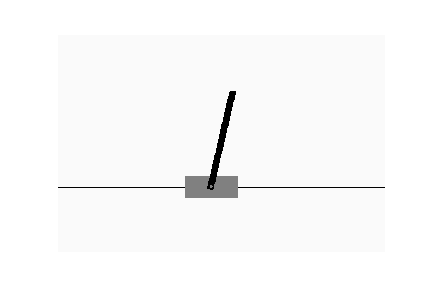
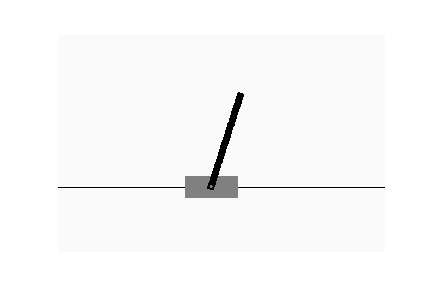
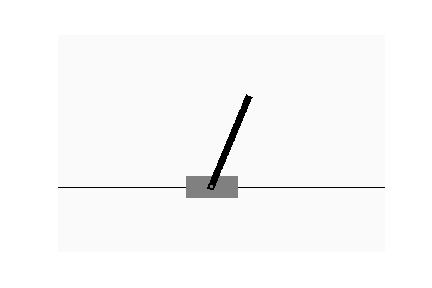
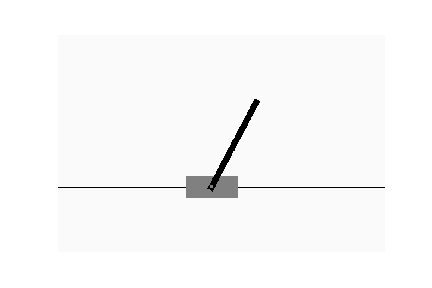
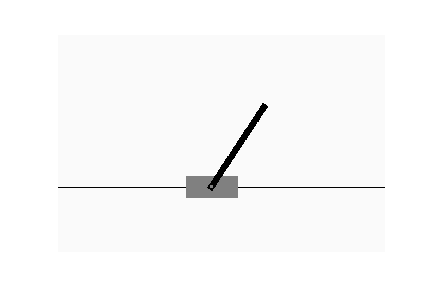
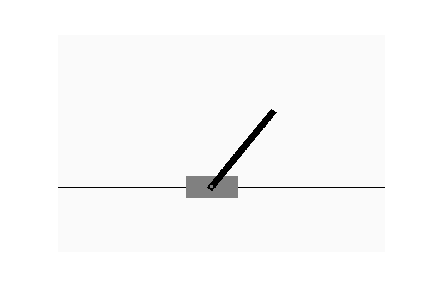
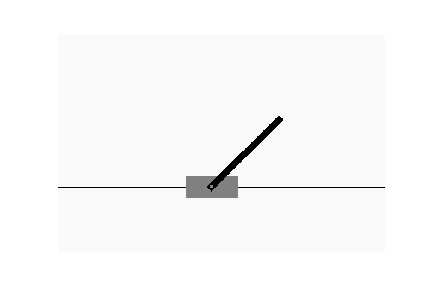
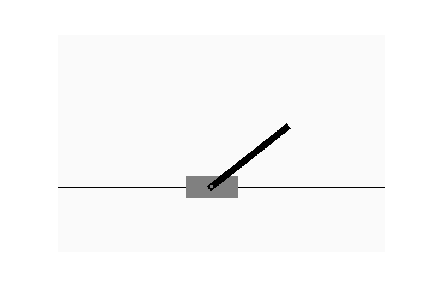
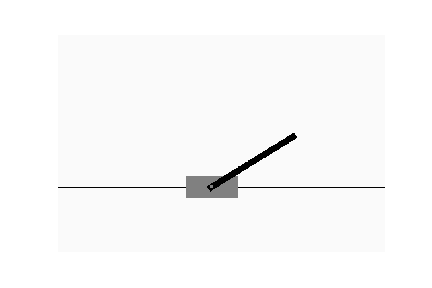
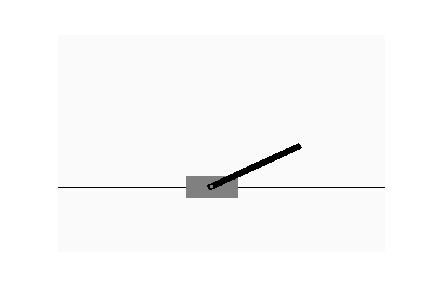
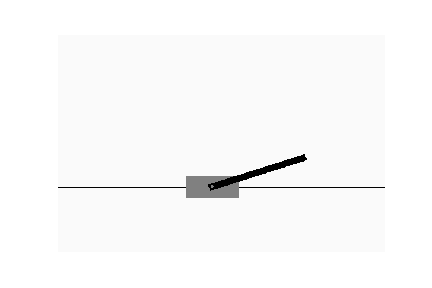
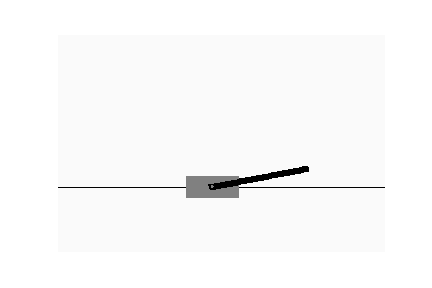
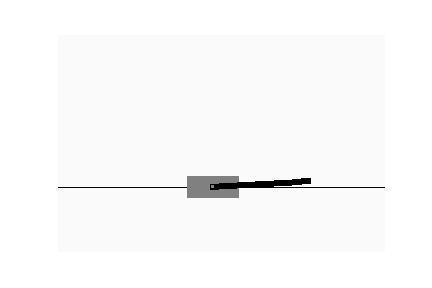
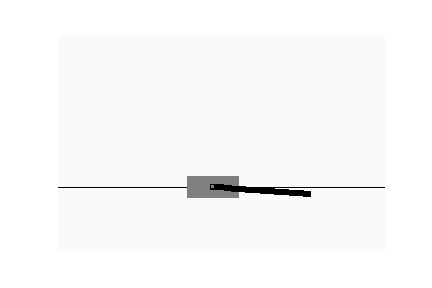
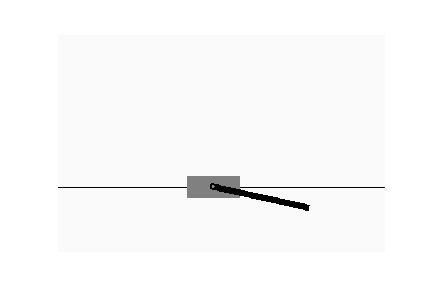
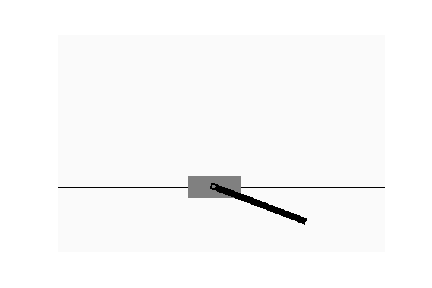
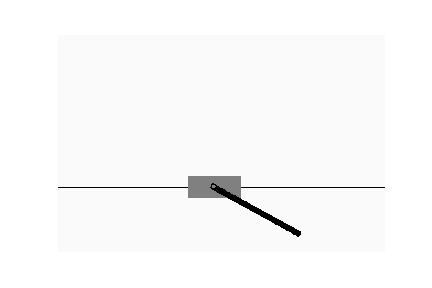
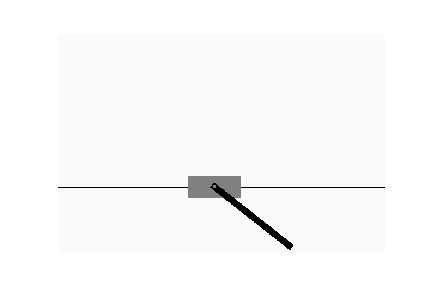
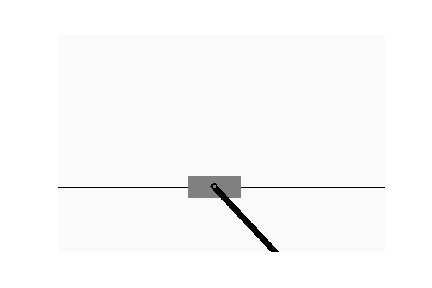
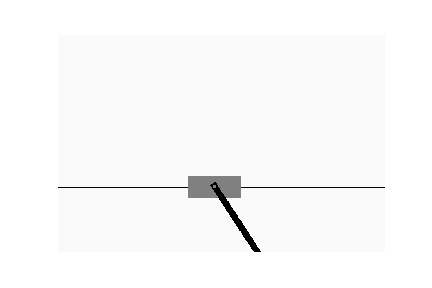
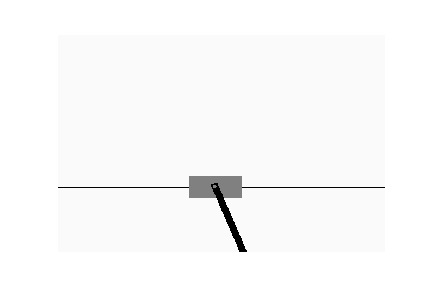
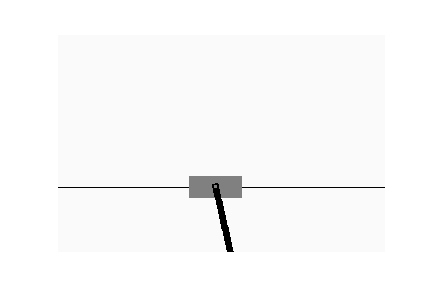
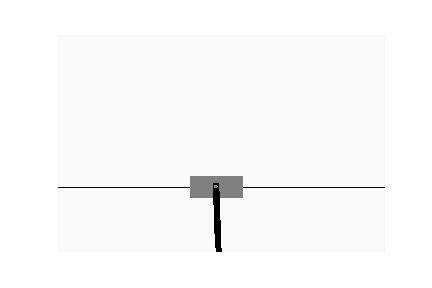
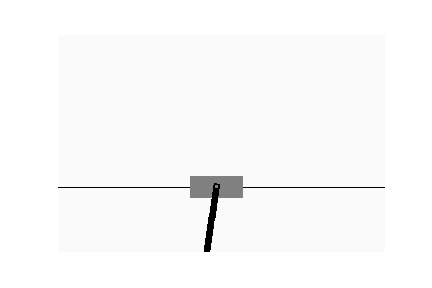
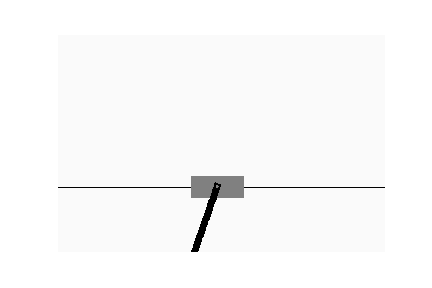
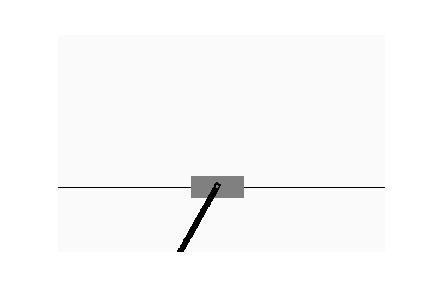
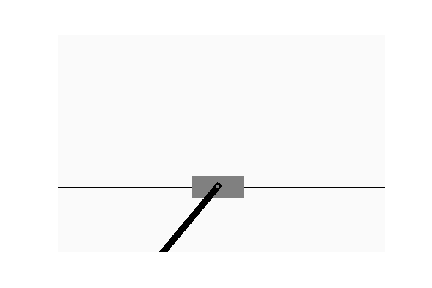
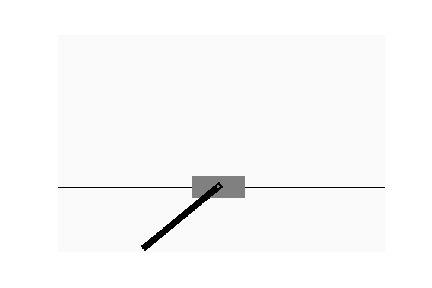
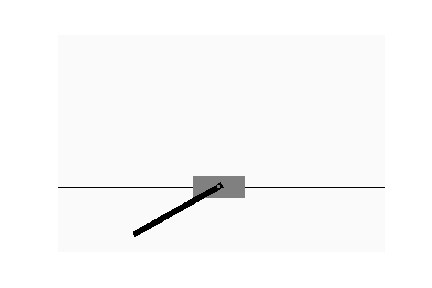
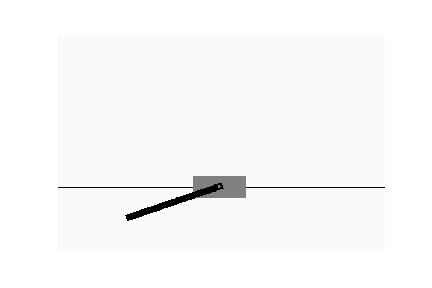
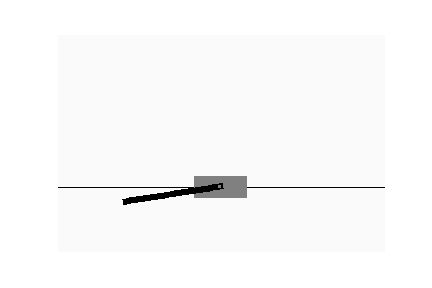
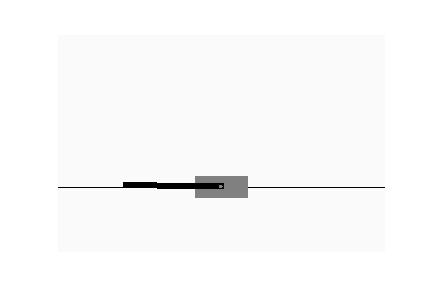
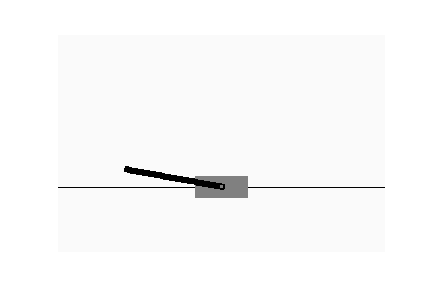
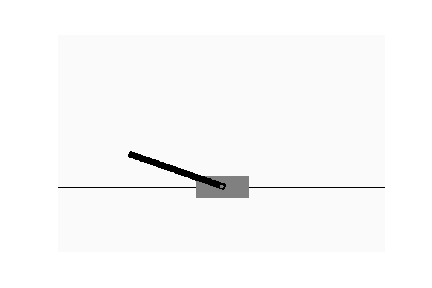
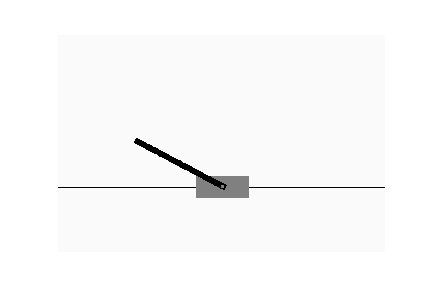
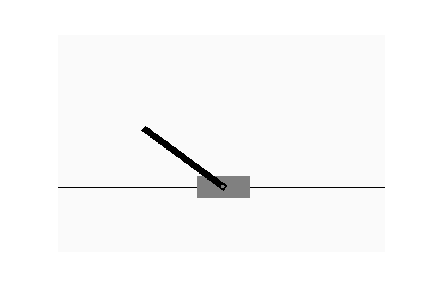
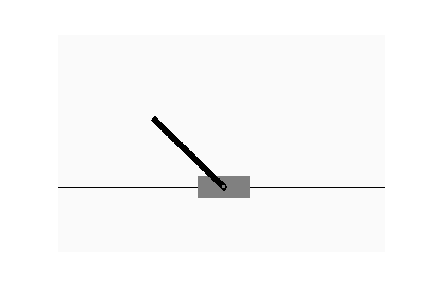
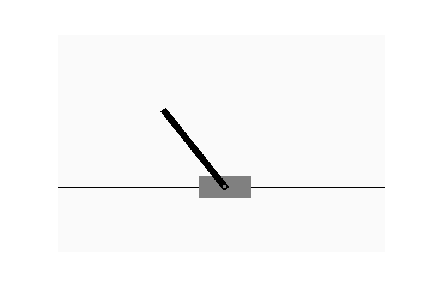
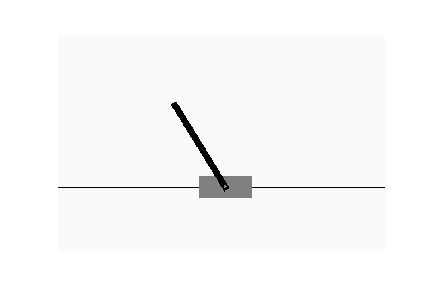
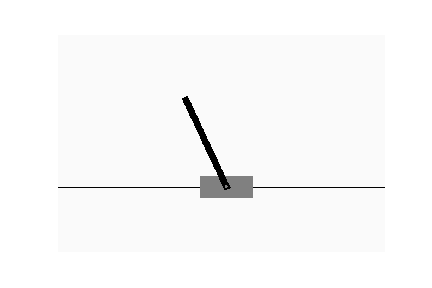
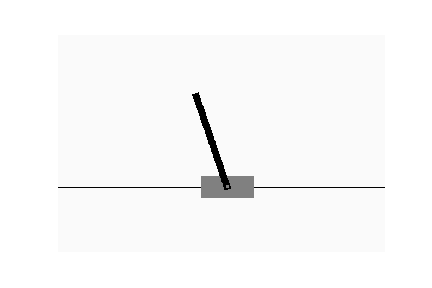
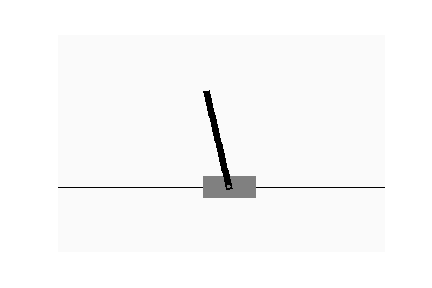
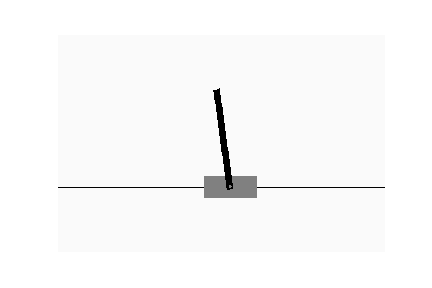
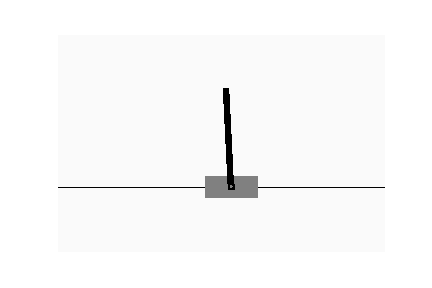
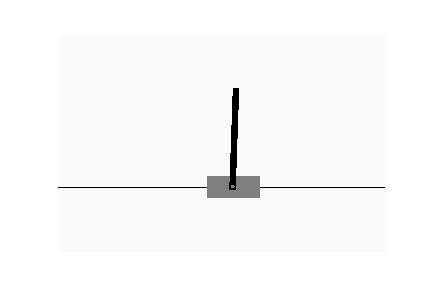
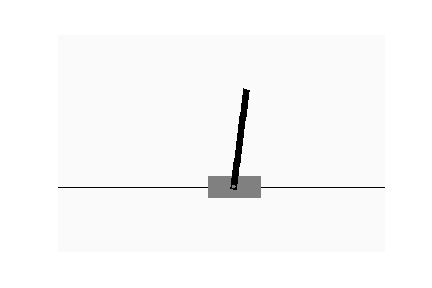
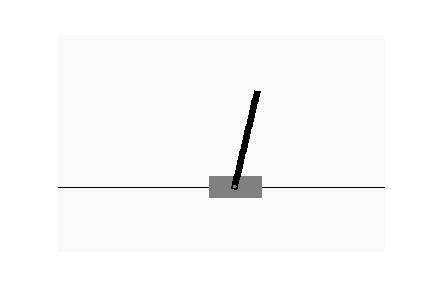
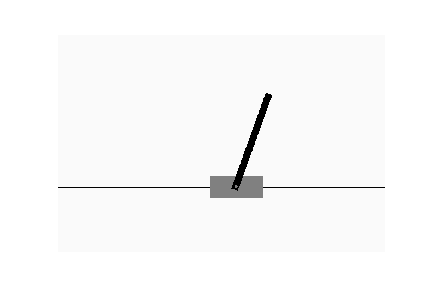
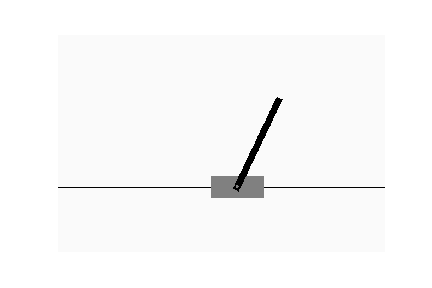
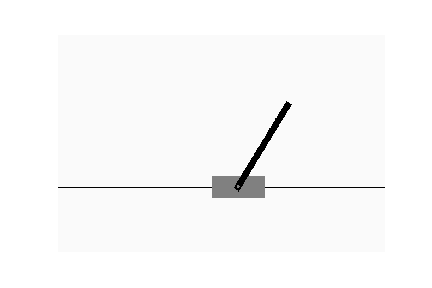
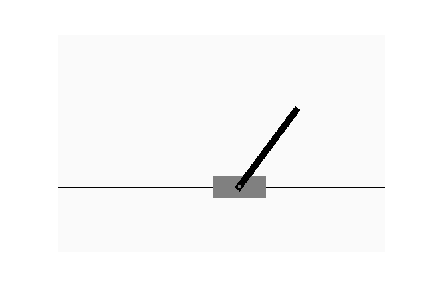
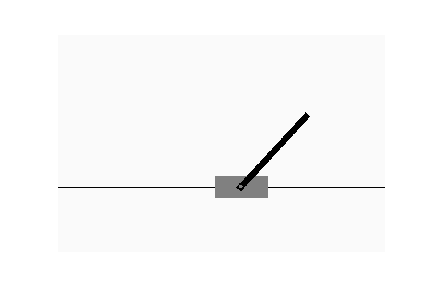
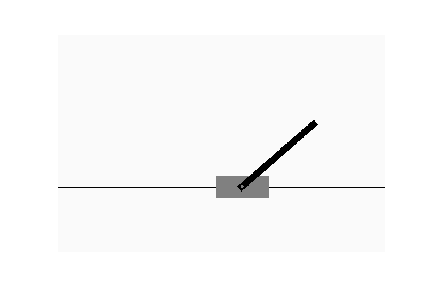
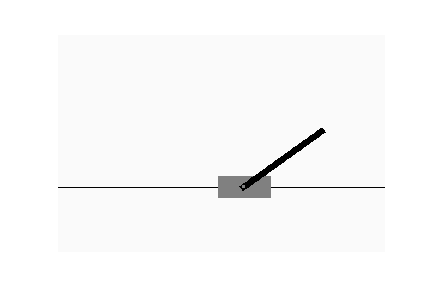
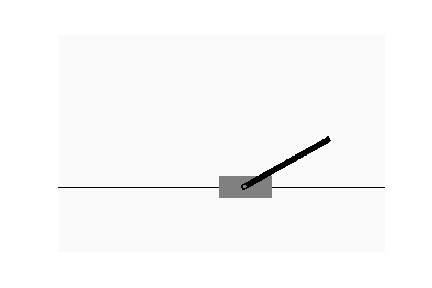
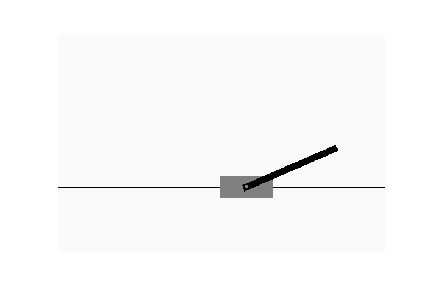
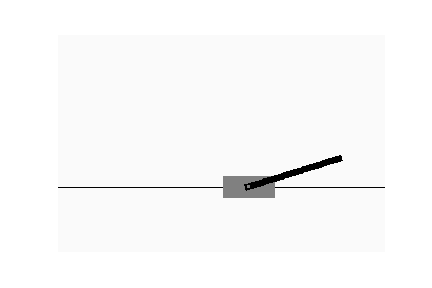
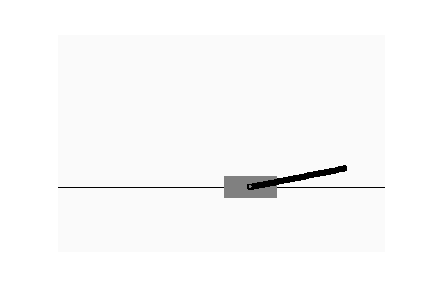
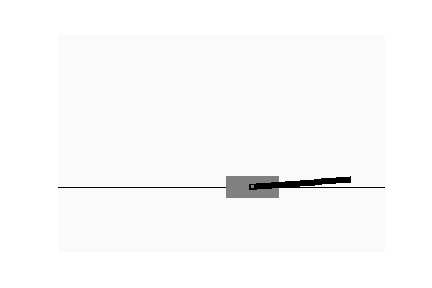
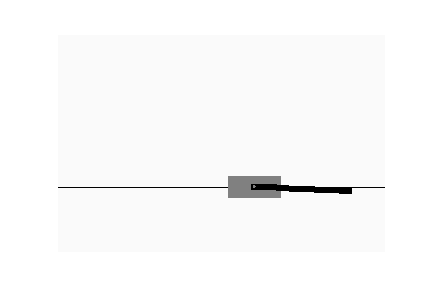
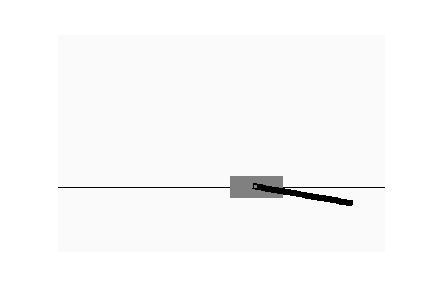
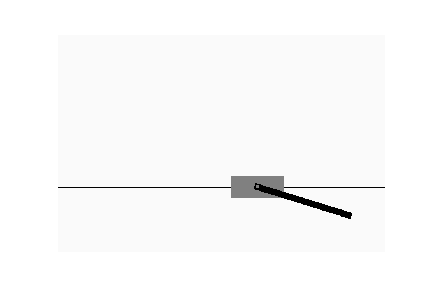
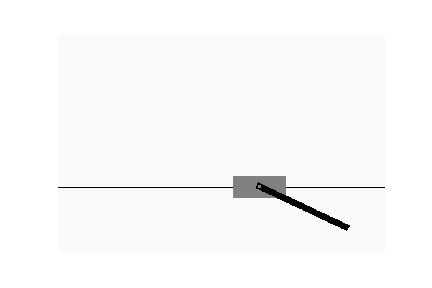
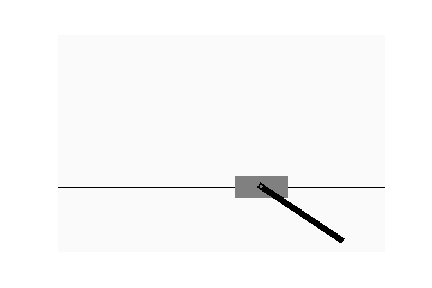
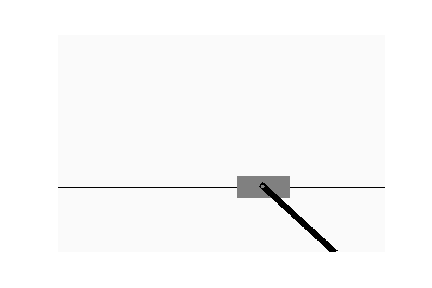
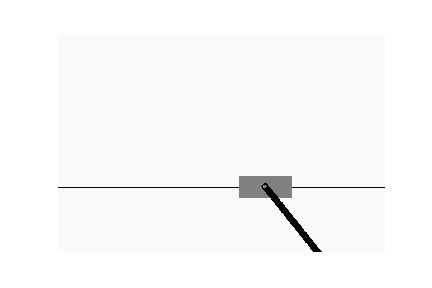
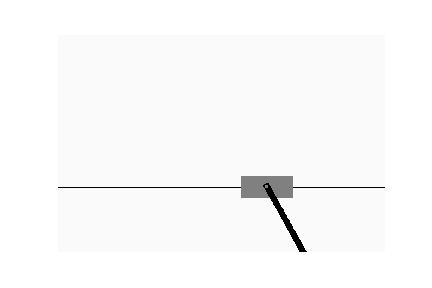
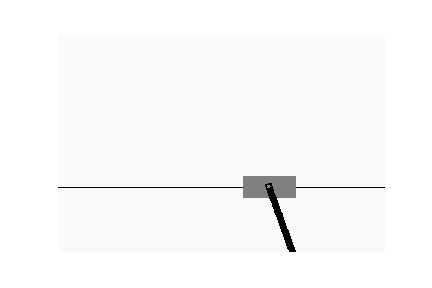
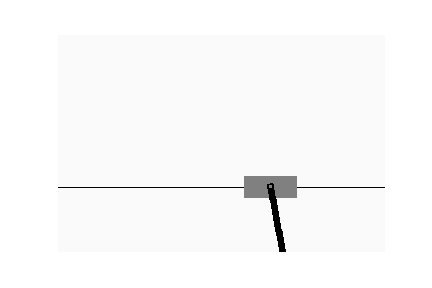
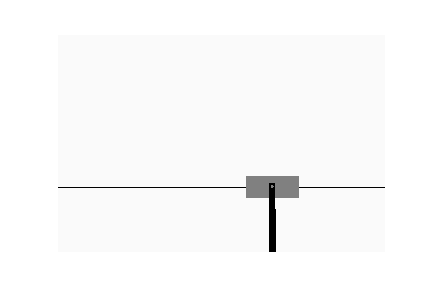
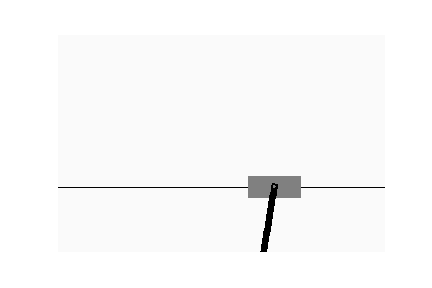
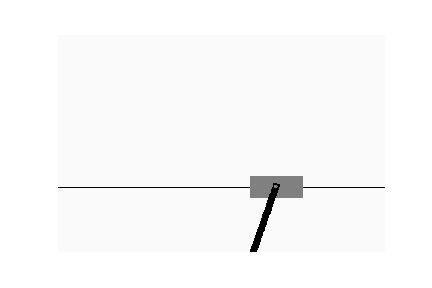
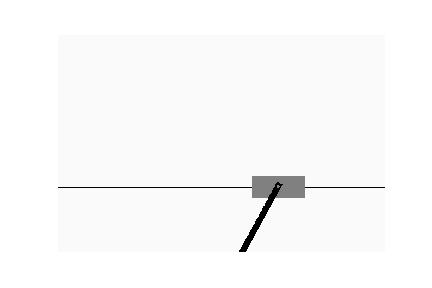
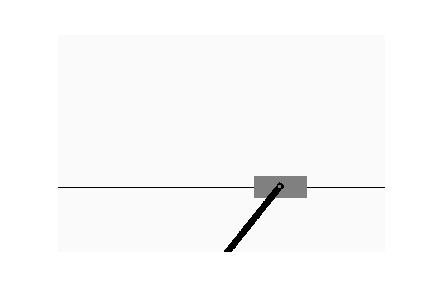
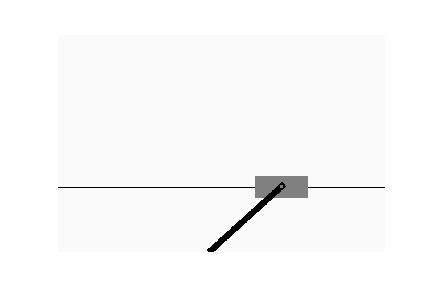
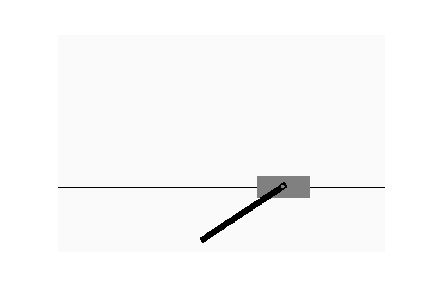
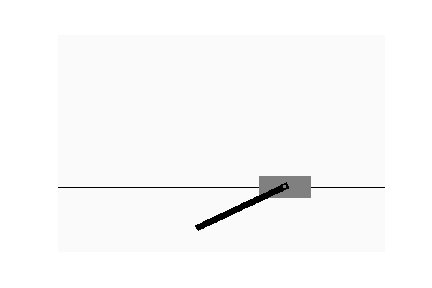
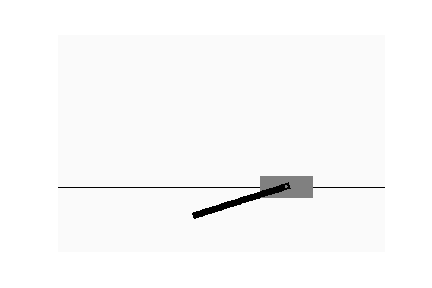
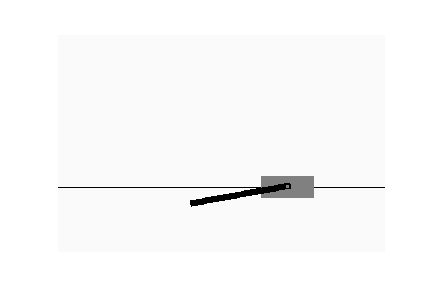
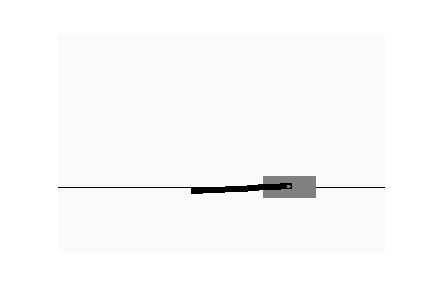
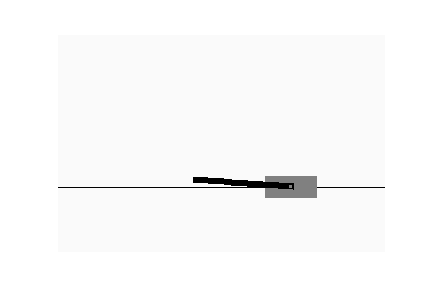
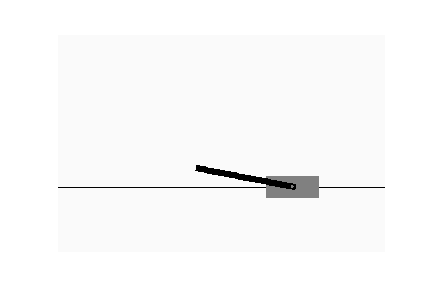
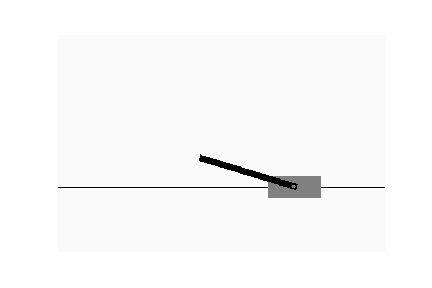
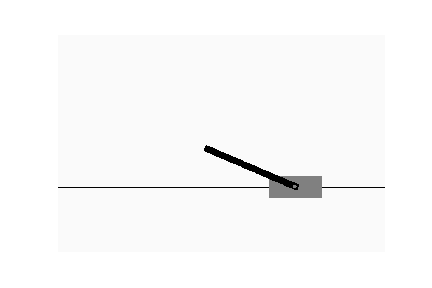
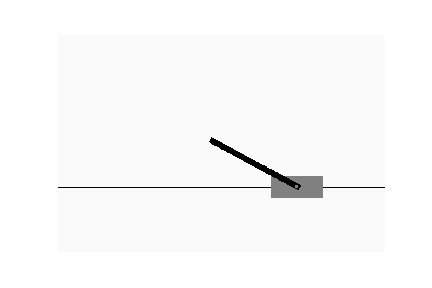
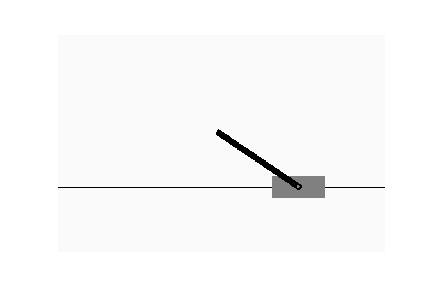
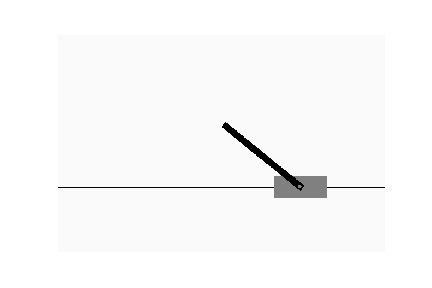
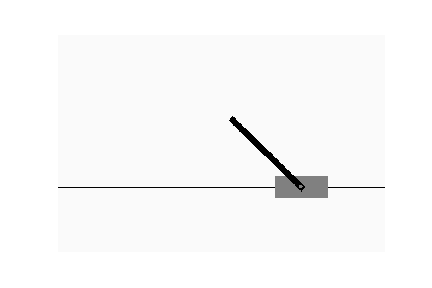
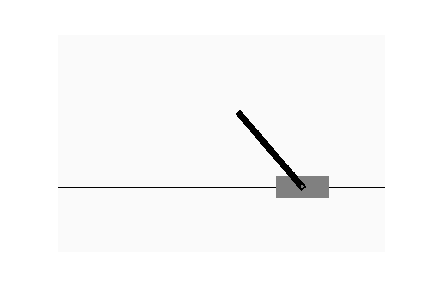
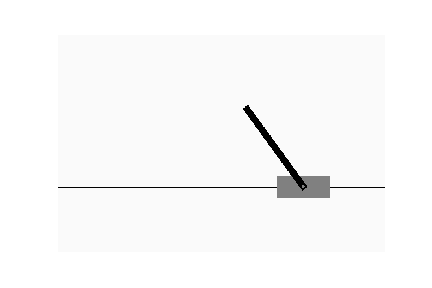
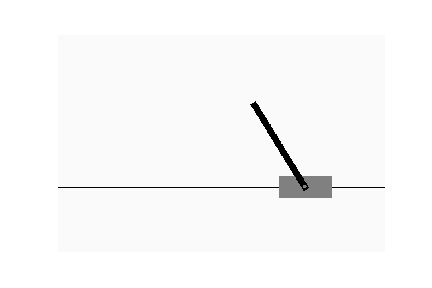
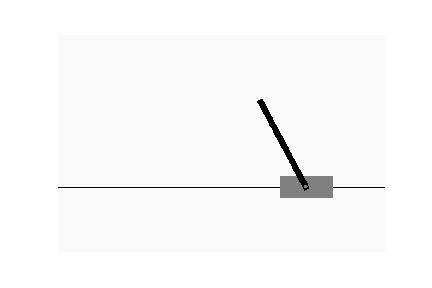
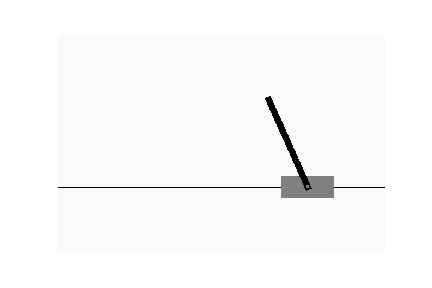
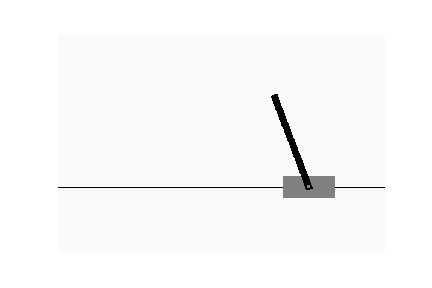
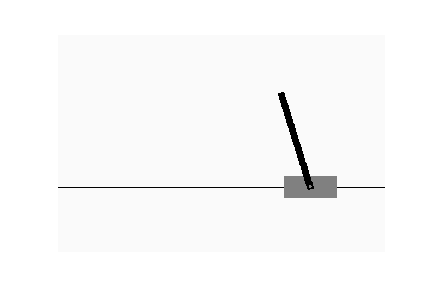
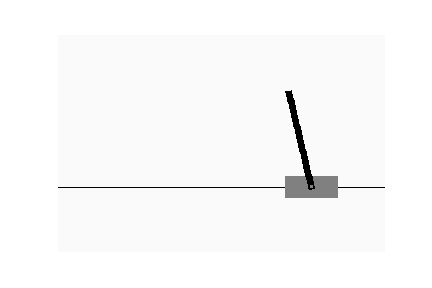
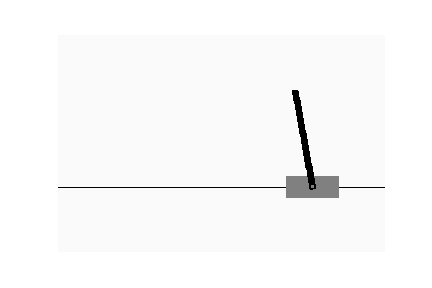
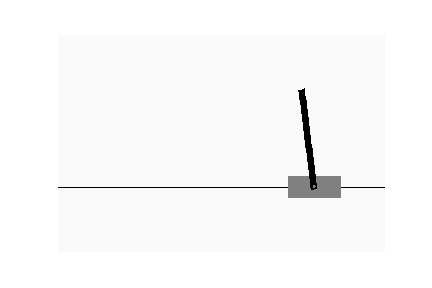
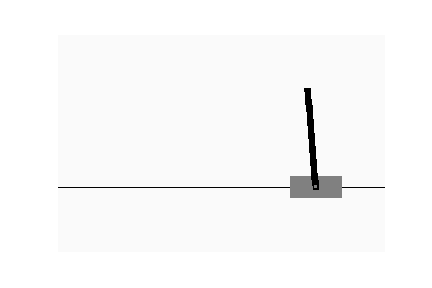
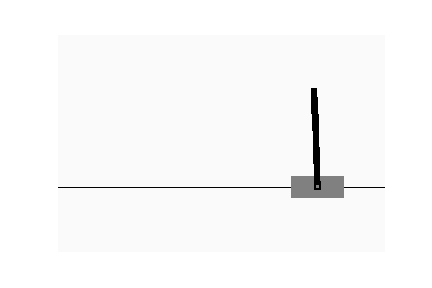
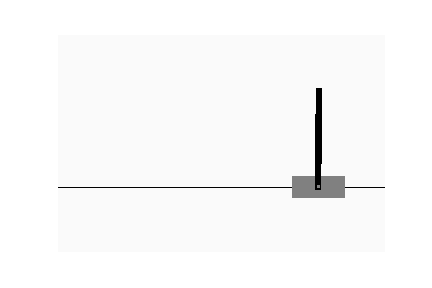
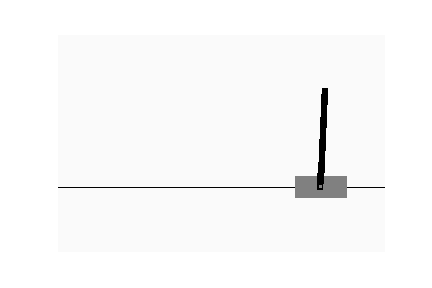
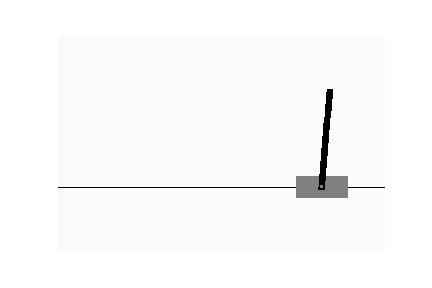
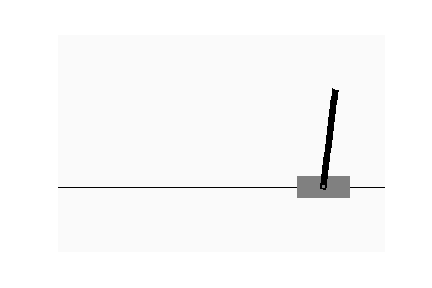
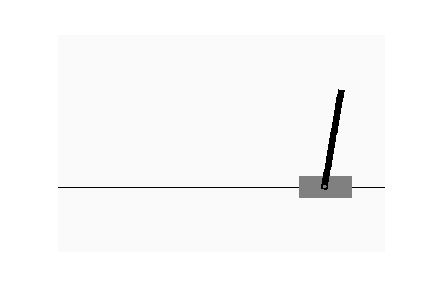
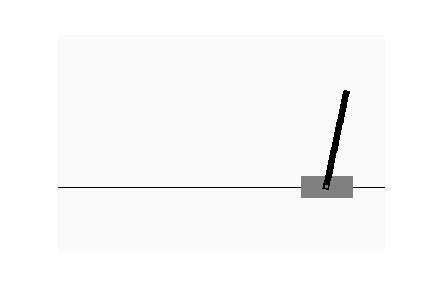
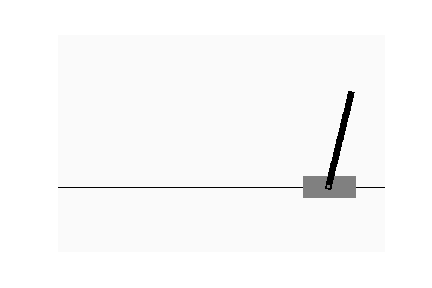
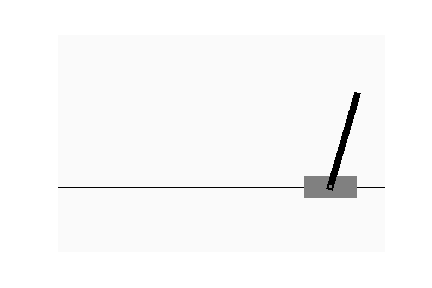
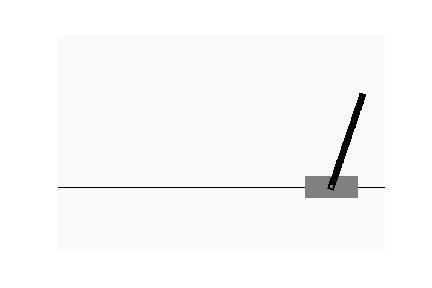
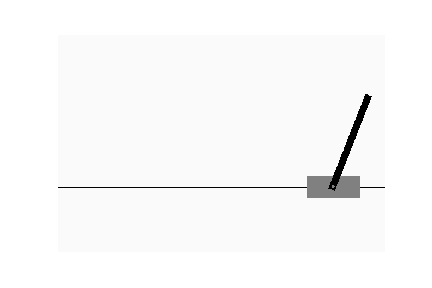
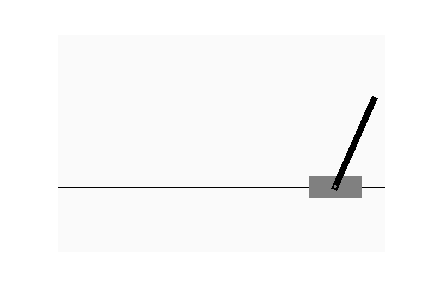
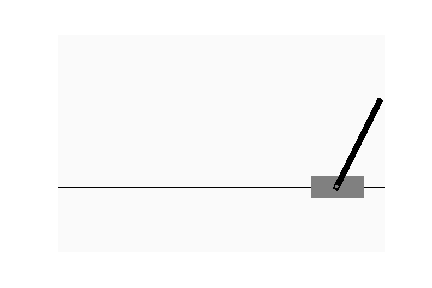
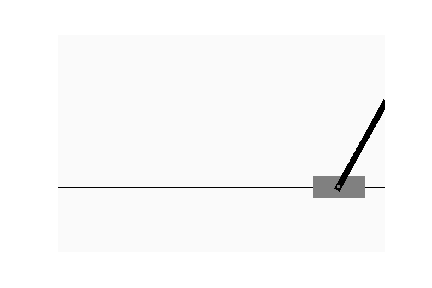
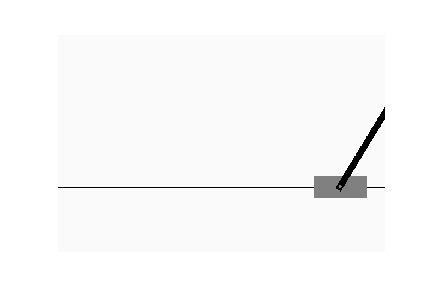
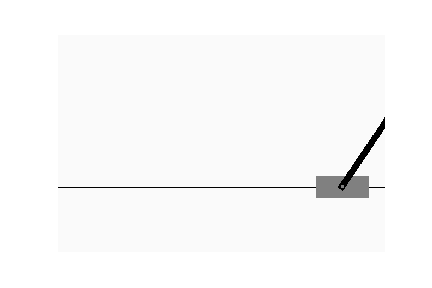
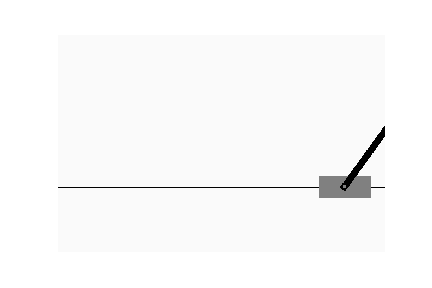
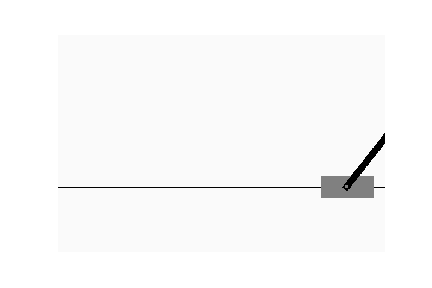
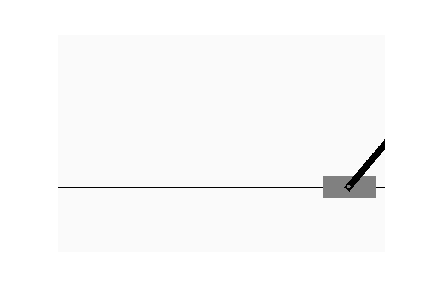
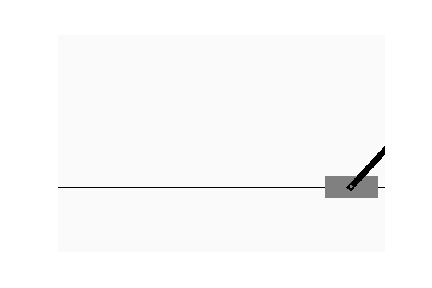

In [60]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render()
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [69]:
# setup policy network
n_inputs = env.observation_space.shape[0]
n_hidden1 = 20
n_hidden2 = 15
n_outputs = env.action_space.n

tf.reset_default_graph()

states_pl = tf.placeholder(tf.float32, [None, n_inputs], name='states_pl')
actions_pl = tf.placeholder(tf.int32, [None, 2], name='actions_pl')
advantages_pl = tf.placeholder(tf.float32, [None], name='advantages_pl')
learning_rate_pl = tf.placeholder(tf.float32, name='learning_rate_pl')

l_hidden1 = tf.layers.dense(inputs=states_pl, units=n_hidden1, activation=relu, name='l_hidden1')
l_hidden2 = tf.layers.dense(inputs=l_hidden1, units=n_hidden2, activation=relu, name='l_hidden2')
l_out = tf.layers.dense(inputs=l_hidden1, units=n_outputs, activation=softmax, name='l_out')

# print network
print('states_pl:', states_pl.get_shape())
print('actions_pl:', actions_pl.get_shape())
print('advantages_pl:', advantages_pl.get_shape())
print('l_hidden1:', l_hidden1.get_shape())
print('l_hidden2:', l_hidden2.get_shape())
print('l_out:', l_out.get_shape())

states_pl: (?, 4)
actions_pl: (?, 2)
advantages_pl: (?,)
l_hidden1: (?, 20)
l_hidden2: (?, 15)
l_out: (?, 2)


In [70]:
# define loss and optimizer
loss_f = -tf.reduce_mean(tf.multiply(tf.log(tf.gather_nd(l_out, actions_pl)), advantages_pl))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)
train_f = optimizer.minimize(loss_f)

saver = tf.train.Saver() # we use this later to save the model

In [71]:
# test forward pass
state = env.reset()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    action_probabilities = sess.run(fetches=l_out, feed_dict={states_pl: [state]})
print(state)
print(action_probabilities)

[ 0.00966401 -0.04408477 -0.03622282 -0.03032495]
[[ 0.50511968  0.49488032]]


*Note: As we create our solution, we will make very few assumptions about the cart-pole environment. We aim to develop a general model for solving reinforcement learning problems, and therefore care little about the specific meaning of the inputs and outputs.*

In [72]:
# helper functions

def get_rollout(sess, env, rollout_limit=None, stochastic=False, seed=None):
    """Generate rollout by iteratively evaluating the current policy on the environment."""
    rollout_limit = rollout_limit or env.spec.timestep_limit
    env.seed(seed)
    s = env.reset()
    states, actions, rewards = [], [], []
    for i in range(rollout_limit):
        a = get_action(sess, s, stochastic)
        s1, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = s1
        if done: break
    env.seed(None)
    return states, actions, rewards, i+1

def get_action(sess, state, stochastic=False):
    """Choose an action, given a state, with the current policy network."""
    # get action probabilities
    a_prob = sess.run(fetches=l_out, feed_dict={states_pl: np.atleast_2d(state)})
    if stochastic:
        # sample action from distribution
        return (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax()
    else:
        # select action with highest probability
        return a_prob.argmax()

def get_advantages(rewards, rollout_limit, discount_factor, eps=1e-12):
    """Compute advantages"""
    returns = get_returns(rewards, rollout_limit, discount_factor)
    # standardize columns of returns to get advantages
    advantages = (returns - np.mean(returns, axis=0)) / (np.std(returns, axis=0) + eps)
    # restore original rollout lengths
    advantages = [adv[:len(rewards[i])] for i, adv in enumerate(advantages)]
    return advantages

def get_returns(rewards, rollout_limit, discount_factor):
    """Compute the cumulative discounted rewards, a.k.a. returns."""
    returns = np.zeros((len(rewards), rollout_limit))
    for i, r in enumerate(rewards):
        returns[i, len(r) - 1] = r[-1]
        for j in reversed(range(len(r)-1)):
            returns[i,j] = r[j] + discount_factor * returns[i,j+1]
    return returns

In [77]:
# training settings

epochs = 400 # number of training batches
batch_size = 500 # number of timesteps in a batch
rollout_limit = env.spec.timestep_limit # max rollout length
#rollout_limit = 400
discount_factor = 0.90 # reward discount factor (gamma), 1.0 = no discount, 0.9 seems optimal
learning_rate = 0.002 # you know this by now
early_stop_loss = 0 # stop training if loss < early_stop_loss, 0 or False to disable

# train policy network

try:
    statistics = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('start training')
        for epoch in range(epochs):
            # generate rollouts until batch_size total timesteps are collected
            states, actions, rewards = [], [], []
            timesteps = 0
            while timesteps < batch_size:
                _rollout_limit = min(rollout_limit, batch_size - timesteps) # limit rollout to match batch_size
                s, a, r, t = get_rollout(sess, env, _rollout_limit, stochastic=True, seed=epoch)            
                states.append(s)
                actions.append(a)
                rewards.append(r)
                timesteps += t
            # compute advantages
            advantages = get_advantages(rewards, rollout_limit, discount_factor)
            # policy gradient update
            loss, _ = sess.run(fetches=[loss_f, train_f], feed_dict={
                states_pl: np.concatenate(states),
                actions_pl: np.column_stack((np.arange(timesteps), np.concatenate(actions))),
                advantages_pl: np.concatenate(advantages),
                learning_rate_pl: learning_rate
            })            
            # validation
            val_rewards = [get_rollout(sess, env, rollout_limit, stochastic=False, seed=(epochs+i))[2] for i in range(10)]
            # store and print training statistics
            mtr = np.mean([np.sum(r) for r in rewards])
            mvr = np.mean([np.sum(r) for r in val_rewards])
            statistics.append((mtr, mvr, loss))
            if not((epoch+1) % 5):
                print('%4d. training reward: %6.2f, validation reward: %6.2f, loss: %7.4f' % (epoch+1, mtr, mvr, loss))
            # early stopping
            if early_stop_loss and loss < early_stop_loss: break
        print('done')
        # save session
        saver.save(sess, 'tmp/model.ckpt')
except KeyboardInterrupt:
    pass    

start training
   5. training reward:  31.25, validation reward:  44.50, loss:  0.4511
  10. training reward:  29.41, validation reward:  44.10, loss:  0.3487
  15. training reward:  22.73, validation reward:  50.30, loss:  0.4159
  20. training reward:  26.32, validation reward:  55.10, loss:  0.3748
  25. training reward:  26.32, validation reward:  58.70, loss:  0.4481
  30. training reward:  33.33, validation reward:  58.30, loss:  0.3789
  35. training reward:  25.00, validation reward:  62.30, loss:  0.3484
  40. training reward:  33.33, validation reward:  62.60, loss:  0.4183
  45. training reward:  38.46, validation reward:  75.50, loss:  0.3582
  50. training reward:  38.46, validation reward:  76.20, loss:  0.3973
  55. training reward:  31.25, validation reward:  77.30, loss:  0.3166
  60. training reward:  45.45, validation reward:  71.60, loss:  0.3558
  65. training reward:  45.45, validation reward:  86.30, loss:  0.3459
  70. training reward:  45.45, validation reward:

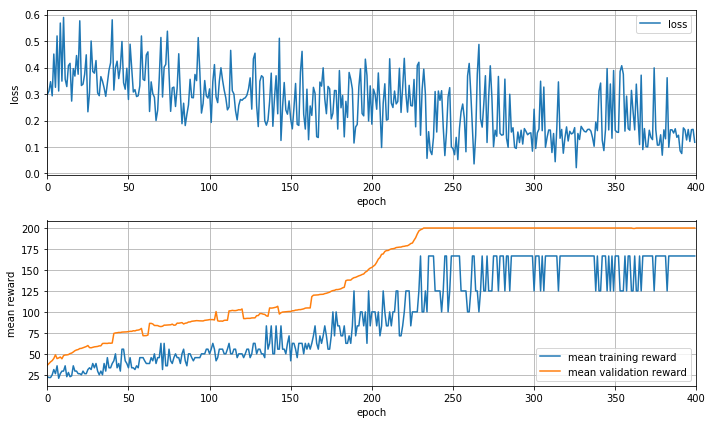

In [78]:
# plot training statistics
statistics = np.array(statistics).T
mean_training_rewards = statistics[0]
mean_validation_rewards = statistics[1]
losses = statistics[2]

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(losses, label='loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=1); plt.grid()
plt.subplot(212)
plt.plot(mean_training_rewards, label='mean training reward')
plt.plot(mean_validation_rewards, label='mean validation reward')
plt.xlabel('epoch'); plt.ylabel('mean reward')
plt.xlim((0, len(mean_validation_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


[2017-10-22 14:11:17,367] Restoring parameters from tmp/model.ckpt



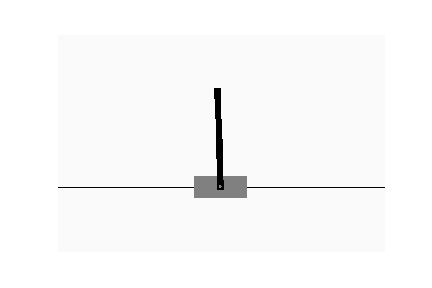
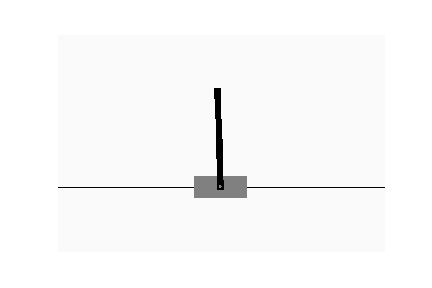
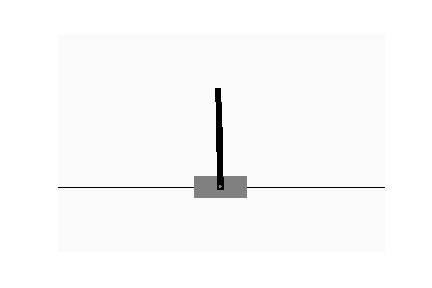
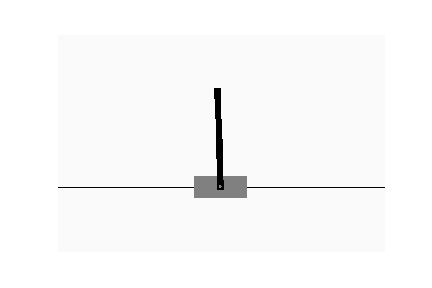
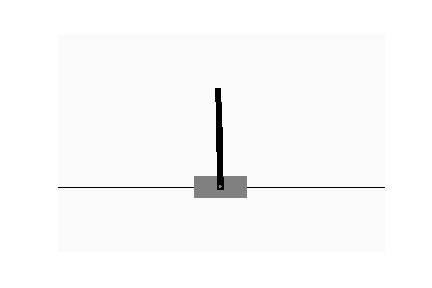
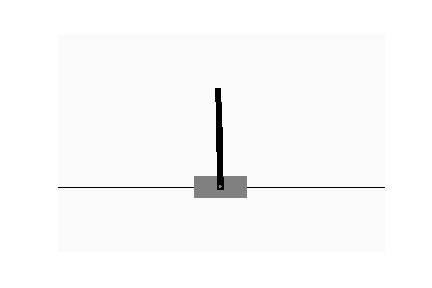
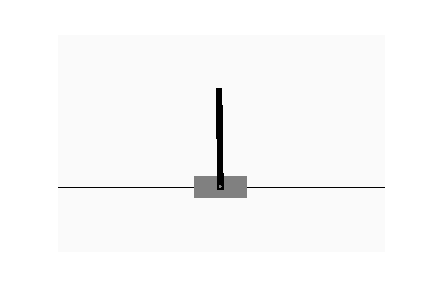
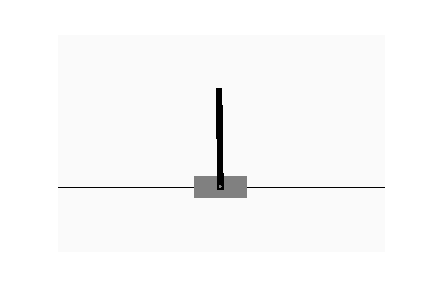
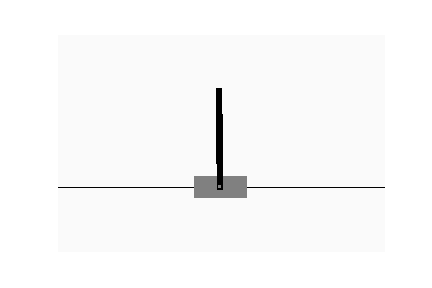
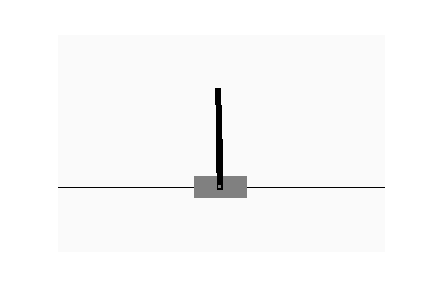
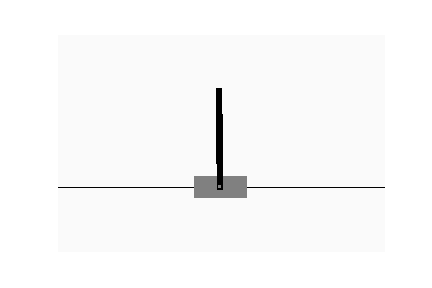
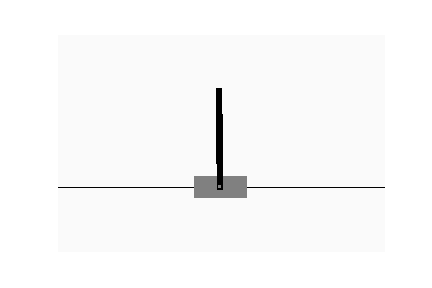
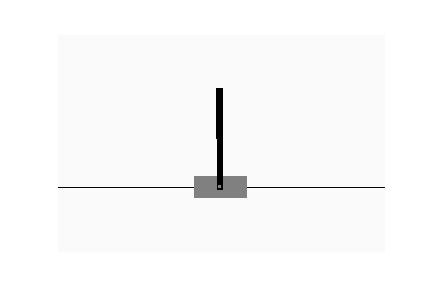
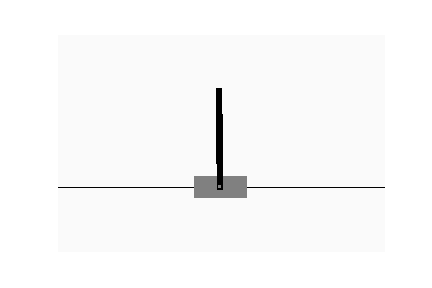
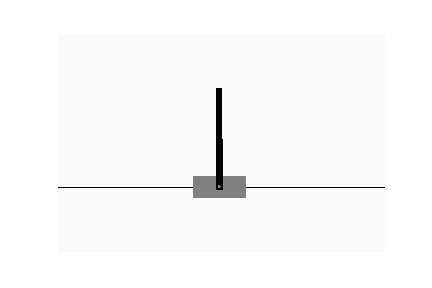
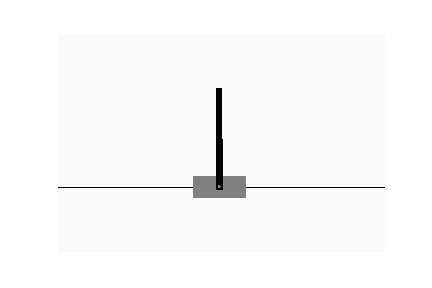
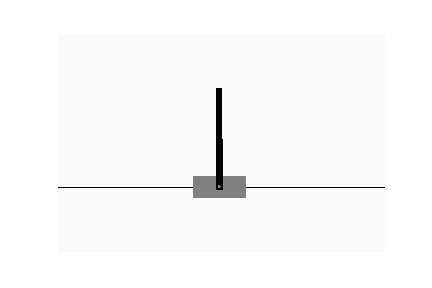
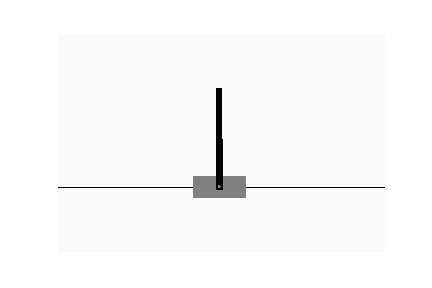
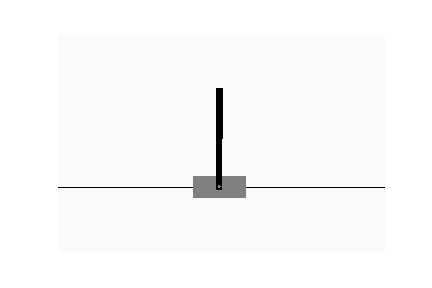
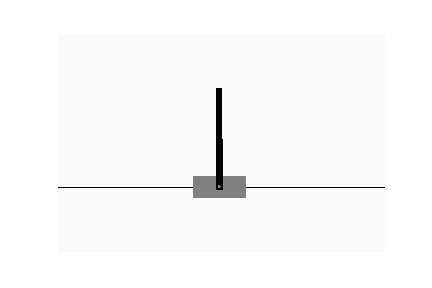
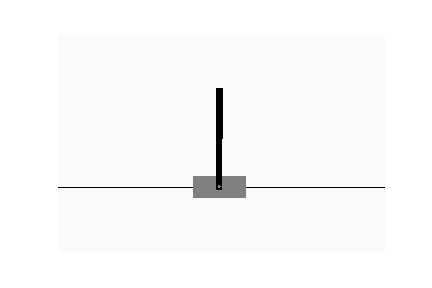
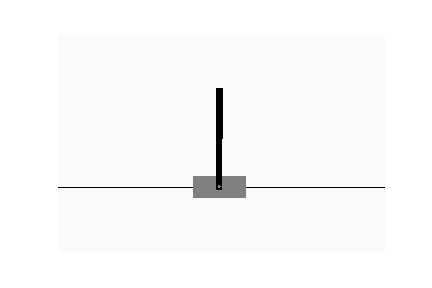
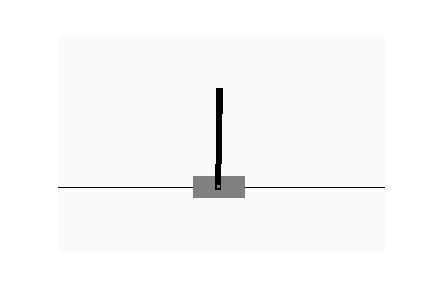
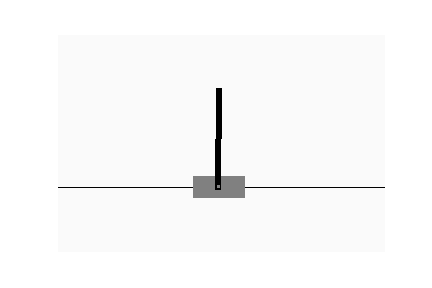
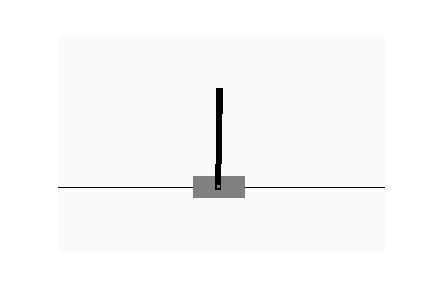
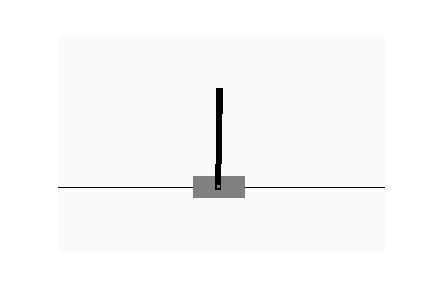
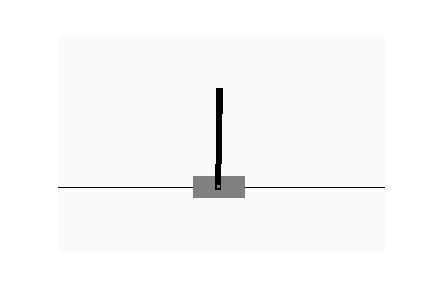
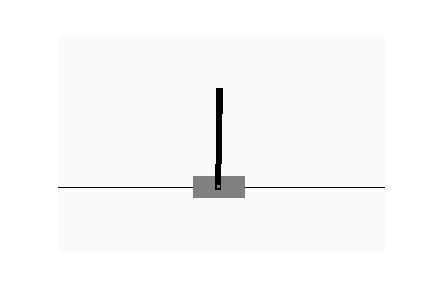
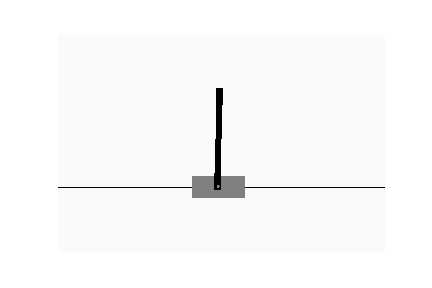
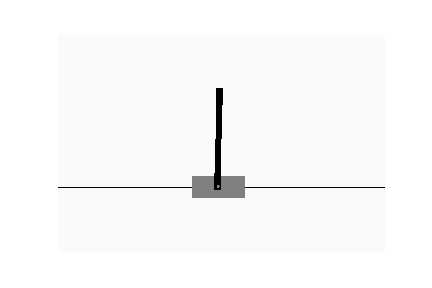
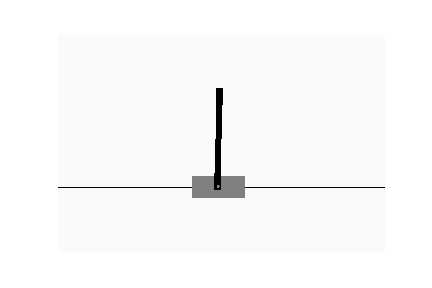
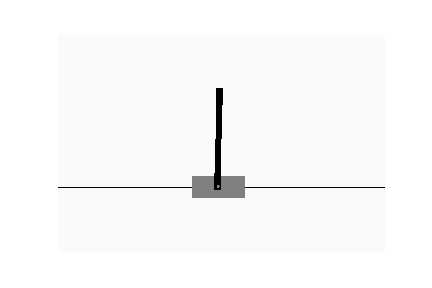
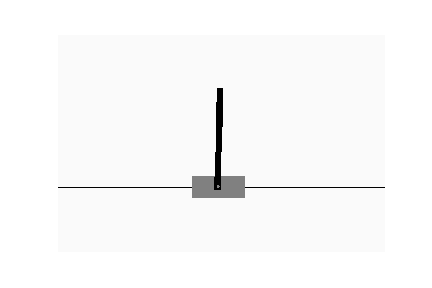
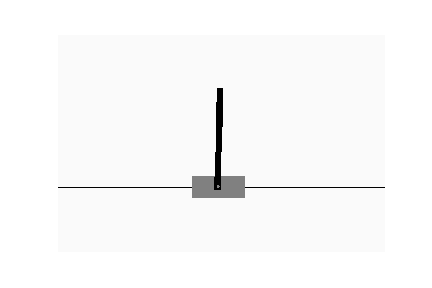
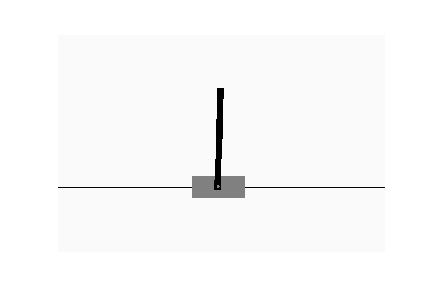
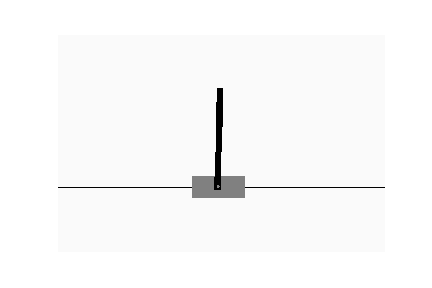
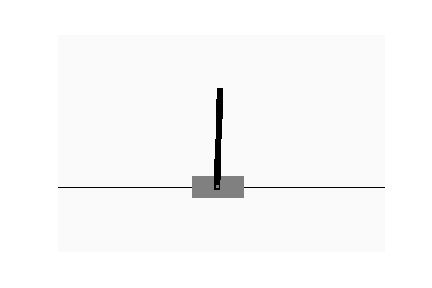
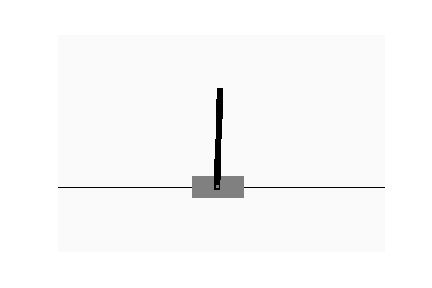
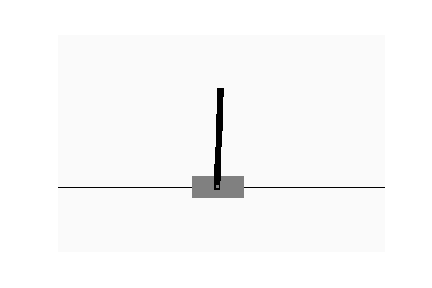
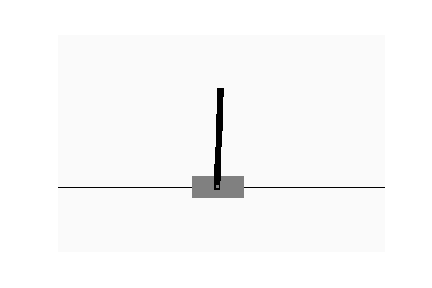
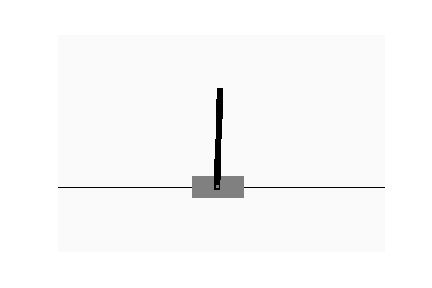
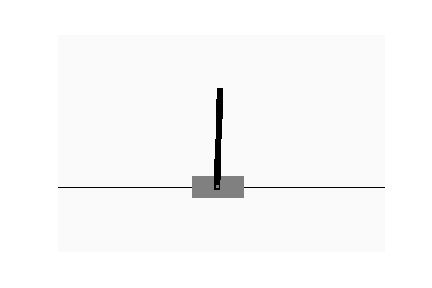
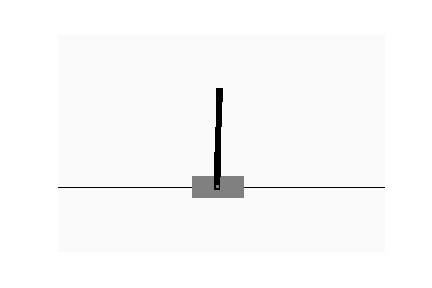
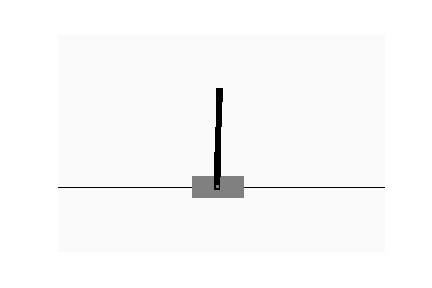
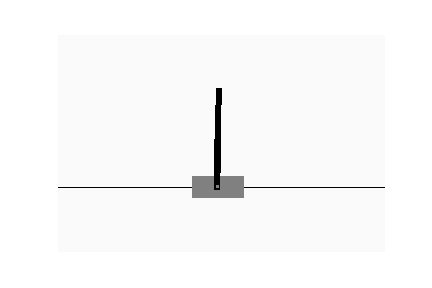
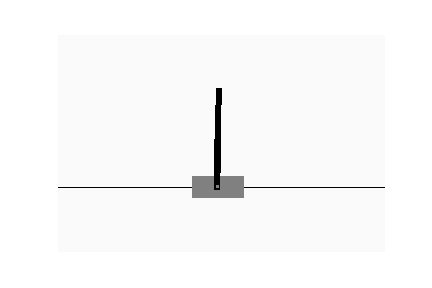
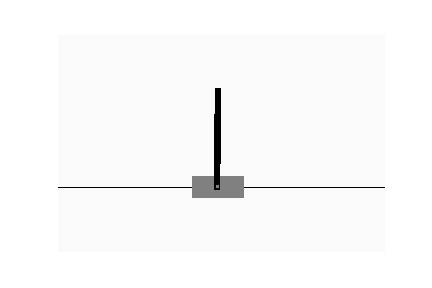
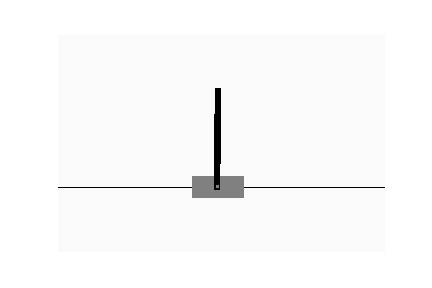
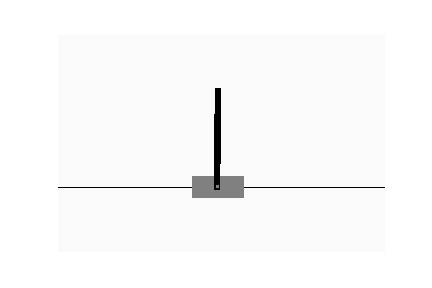
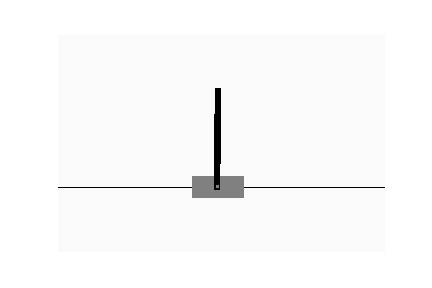
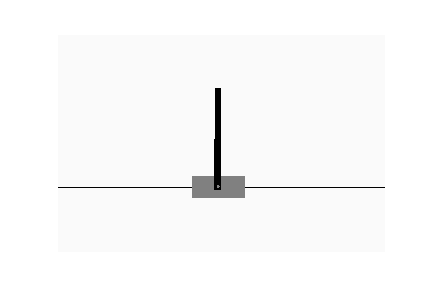
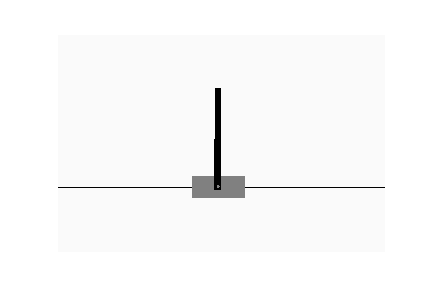
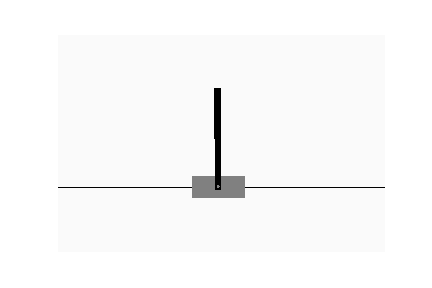
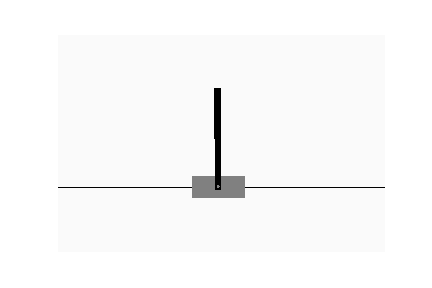
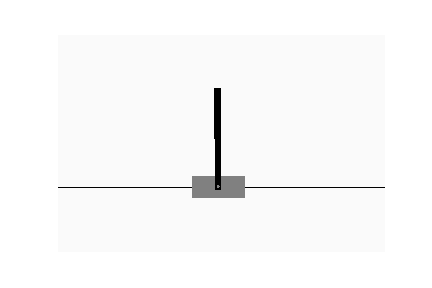
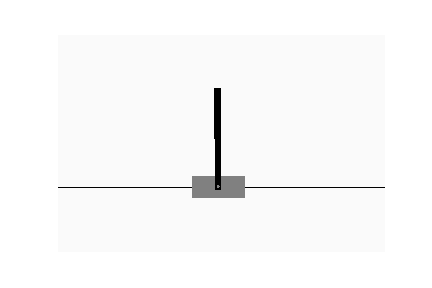
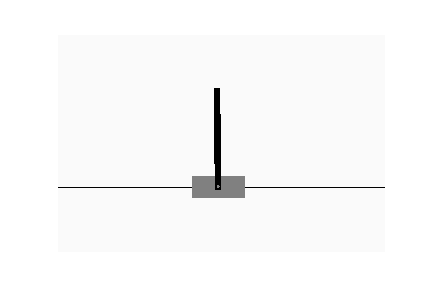
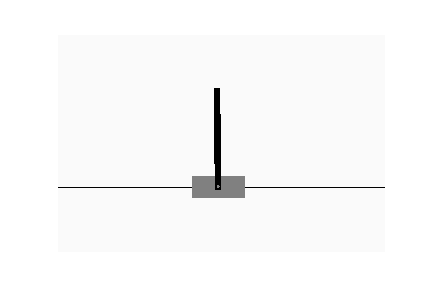
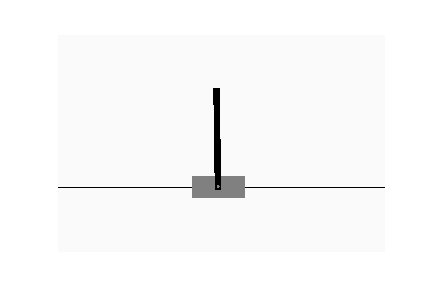
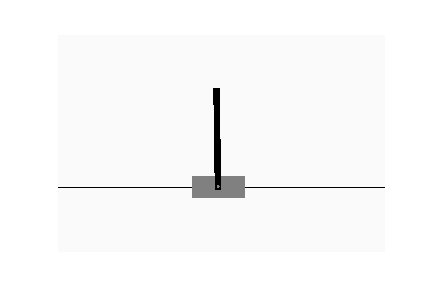
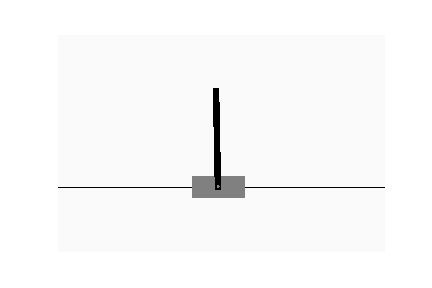
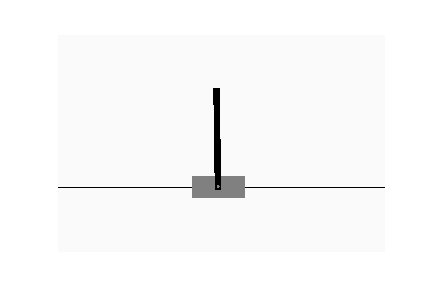
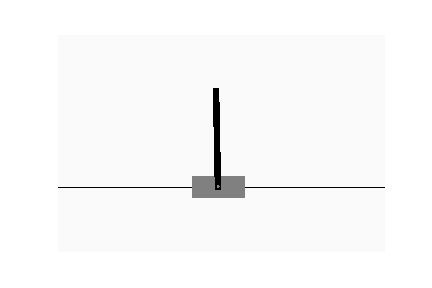
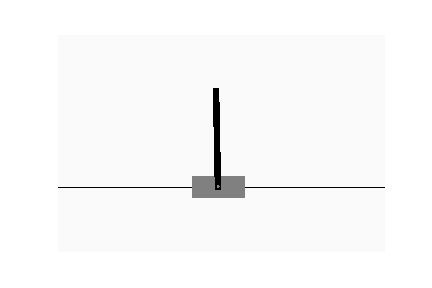
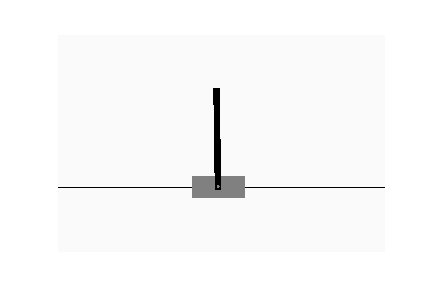
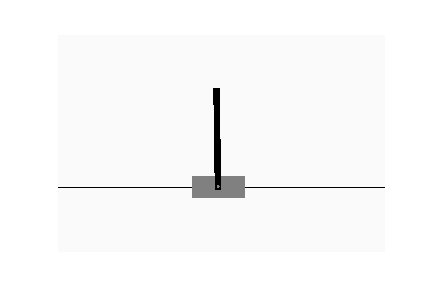
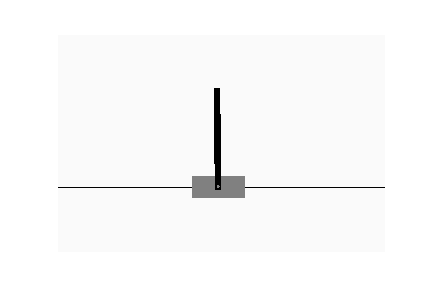
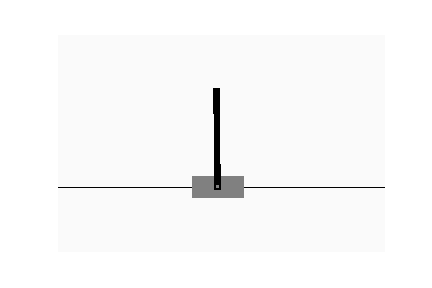
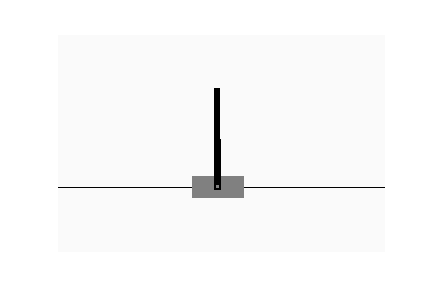
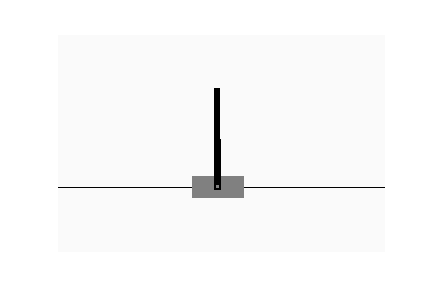
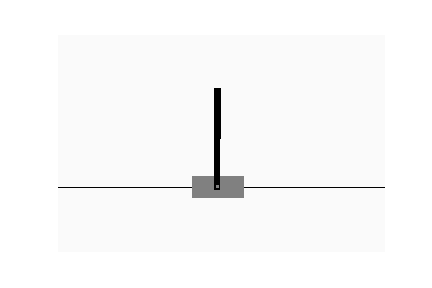
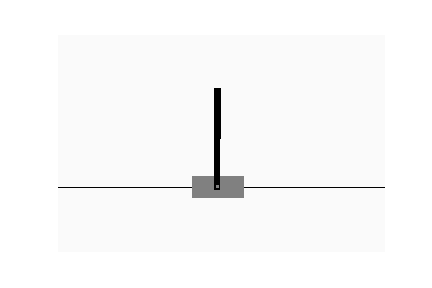
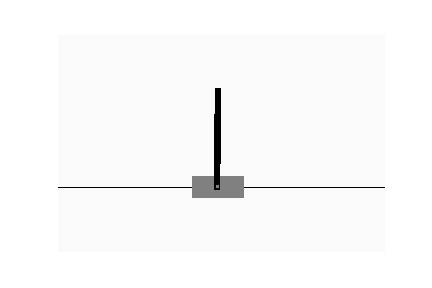
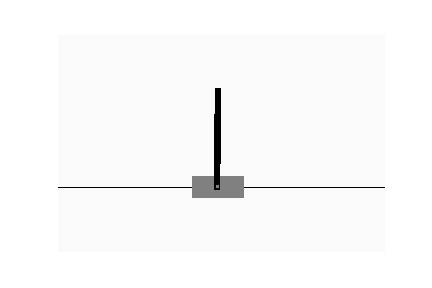
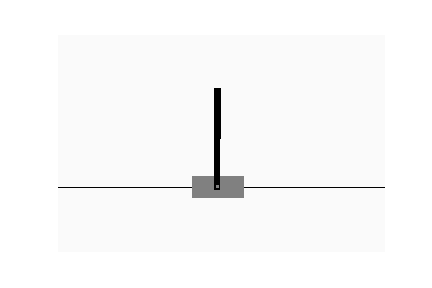
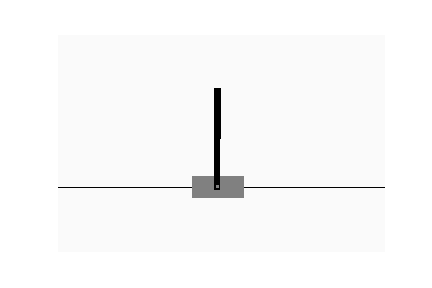
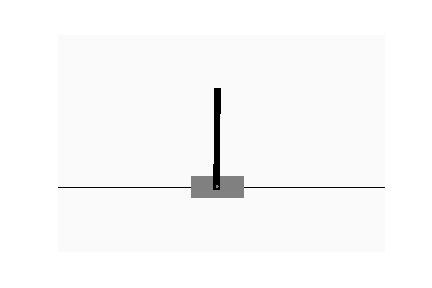
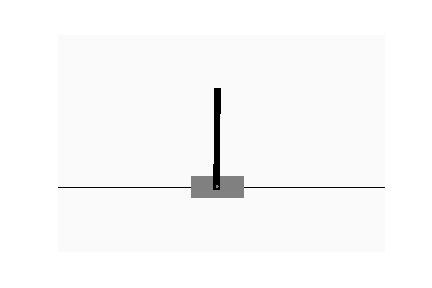
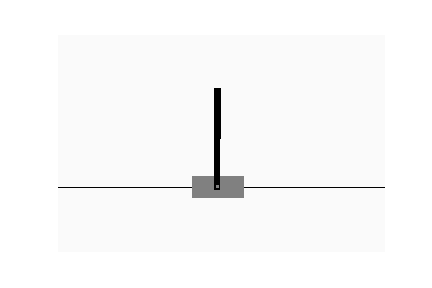
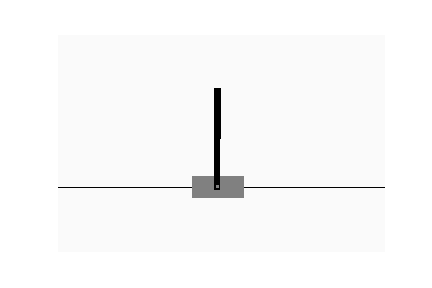
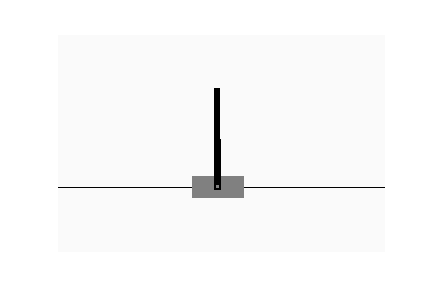
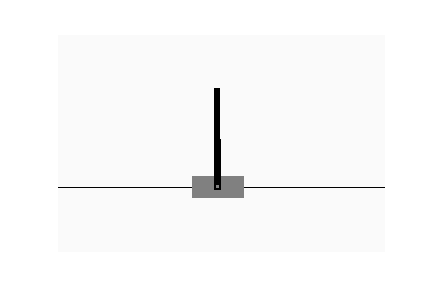
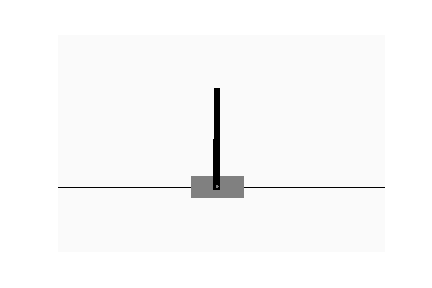
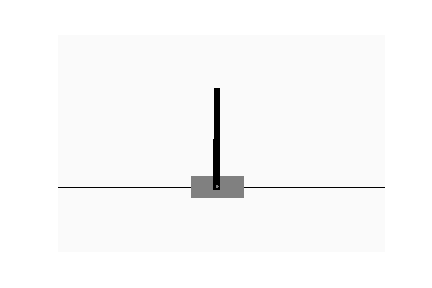
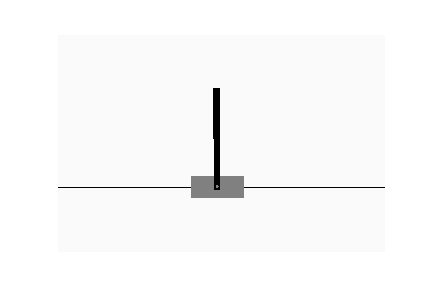
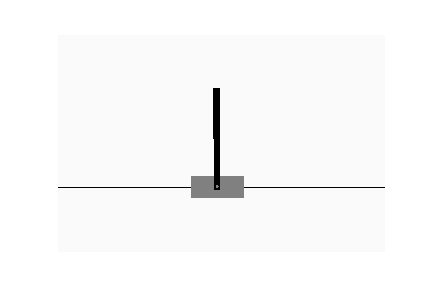
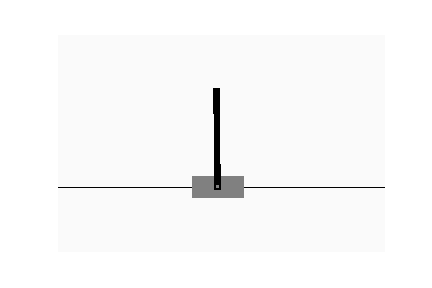
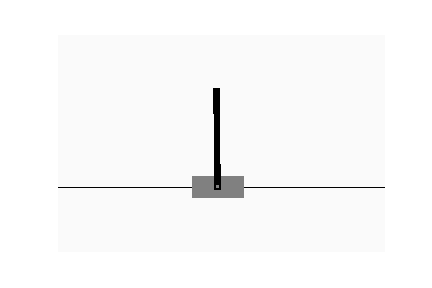
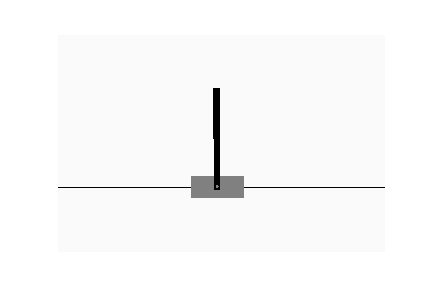
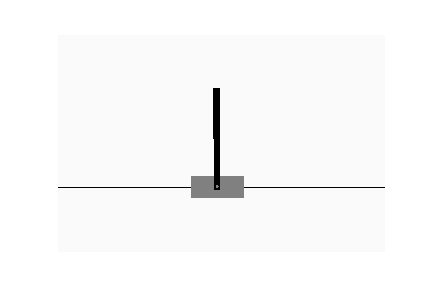
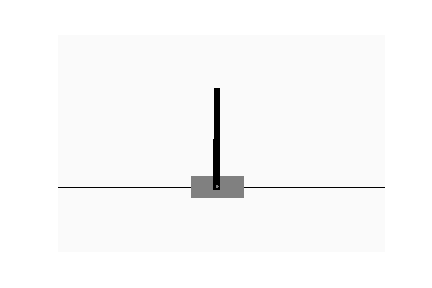
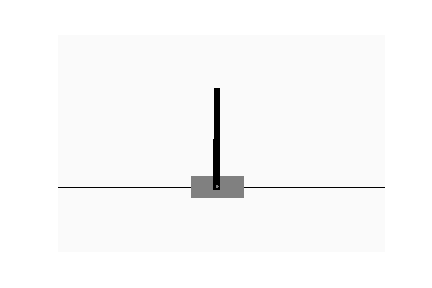
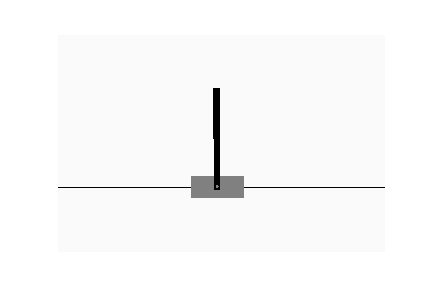
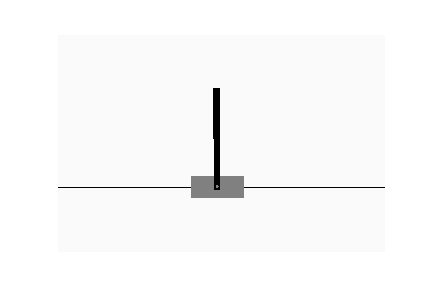
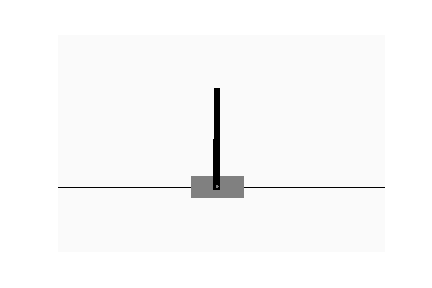
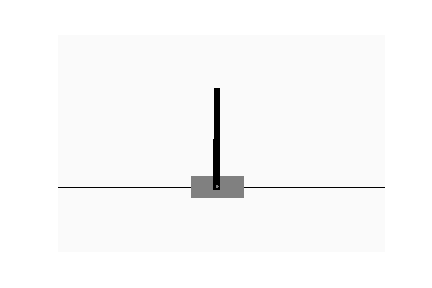
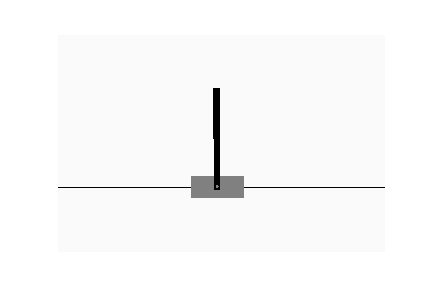
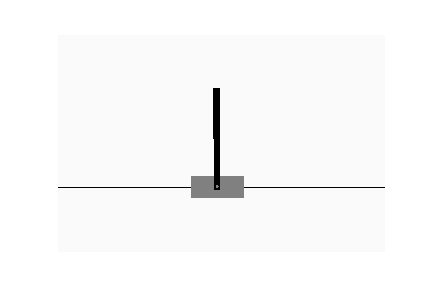
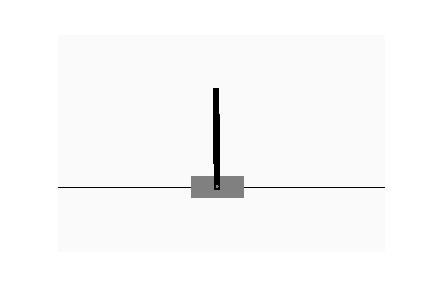
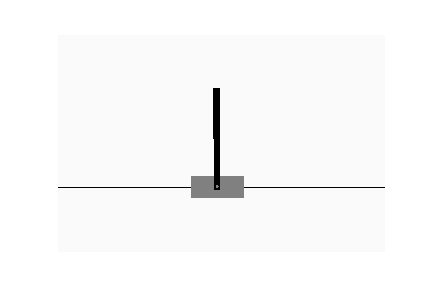
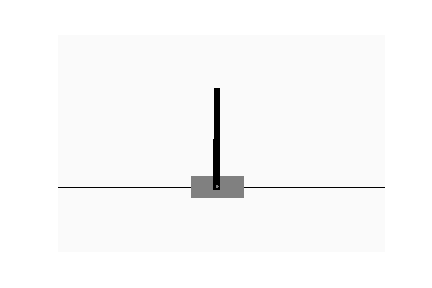
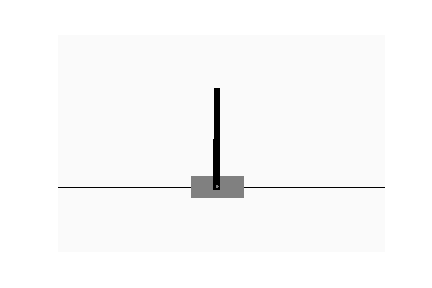
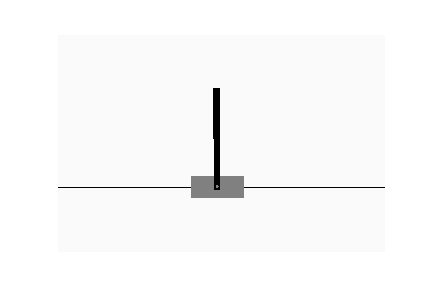
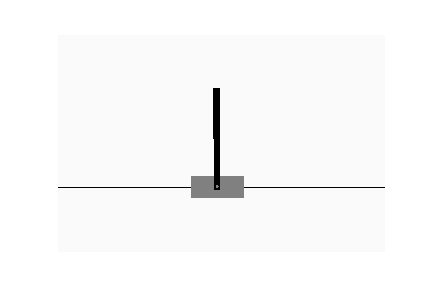
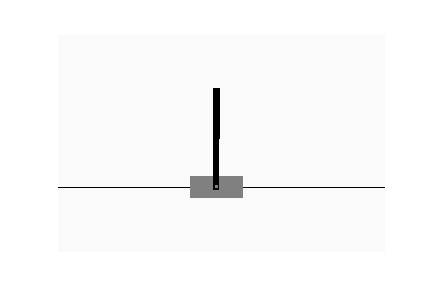
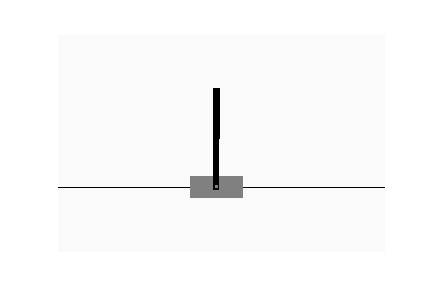
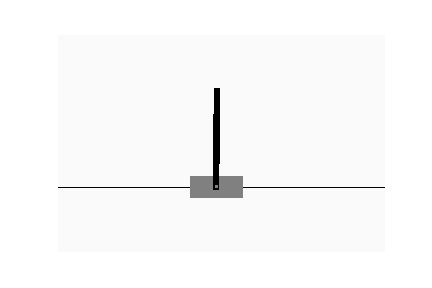
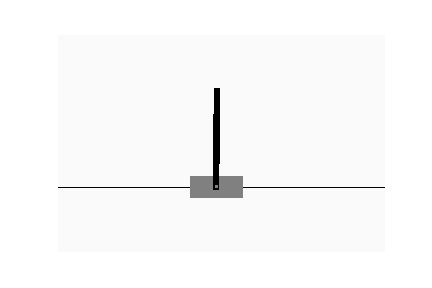
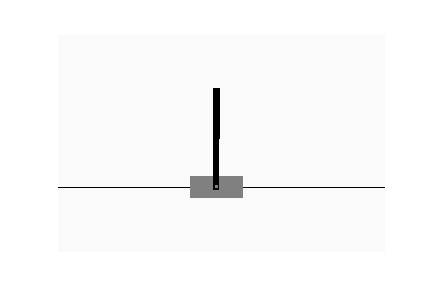
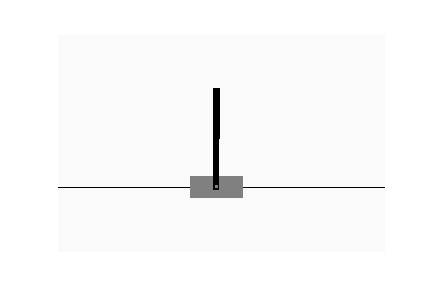
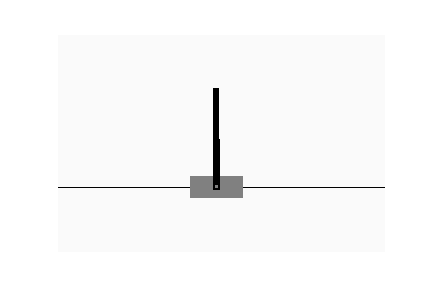
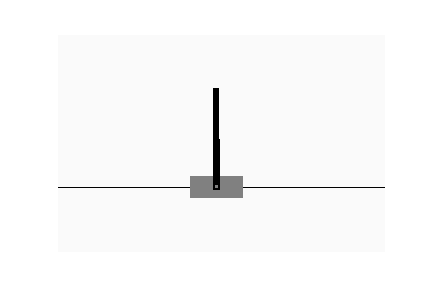
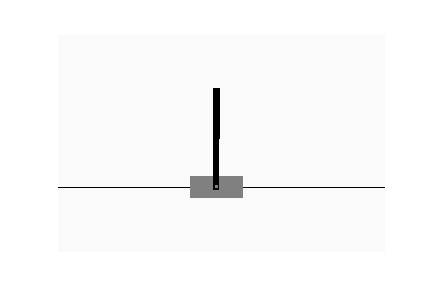
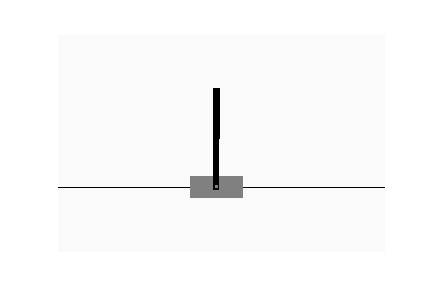
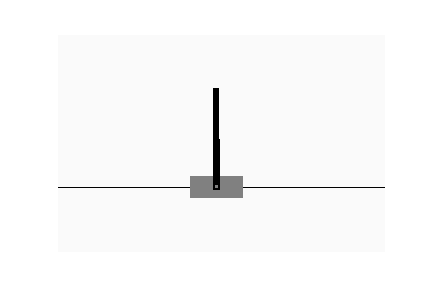
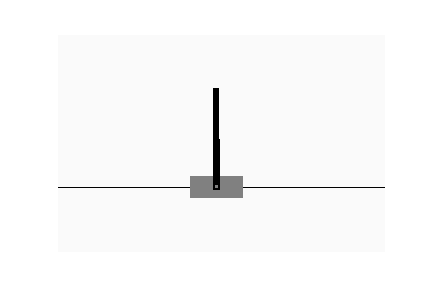
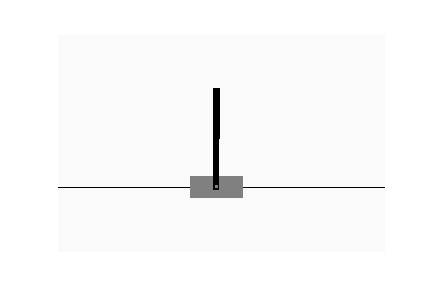
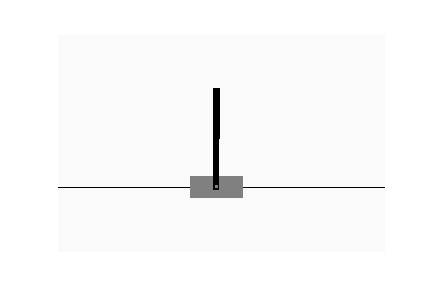
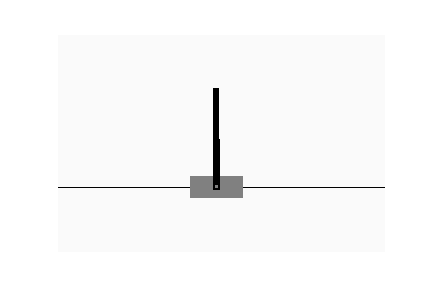
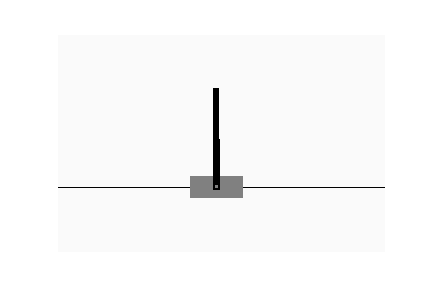
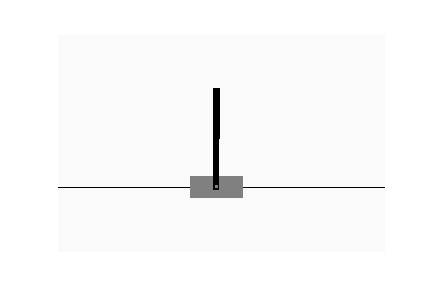
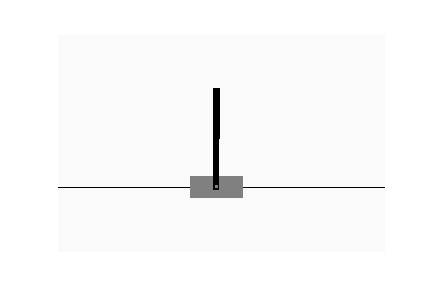
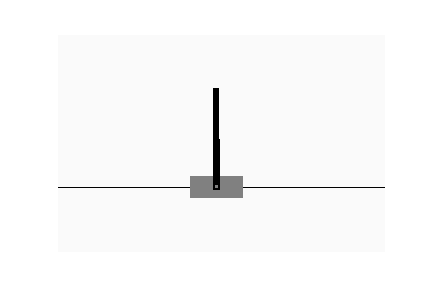
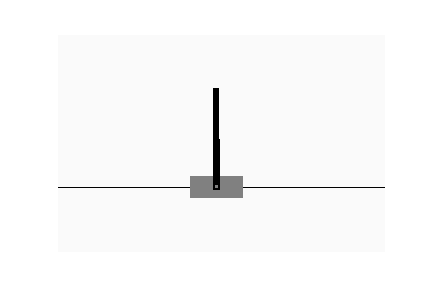
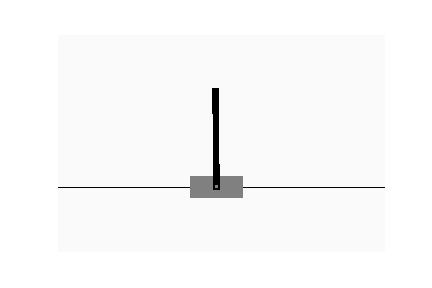
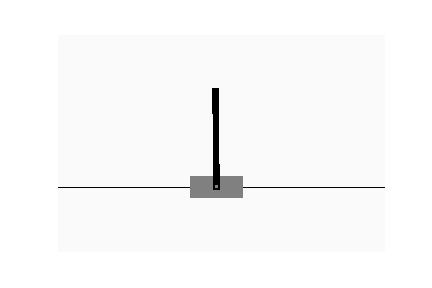
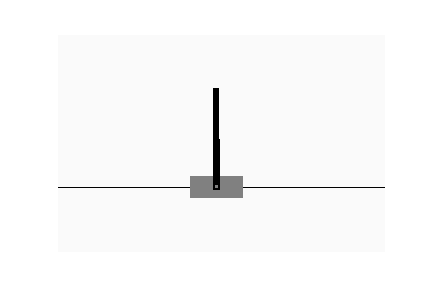
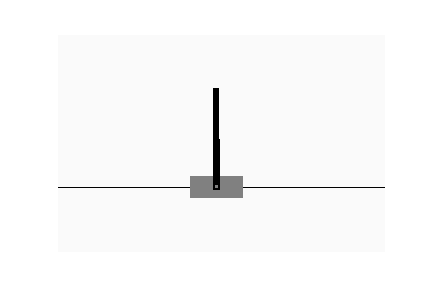
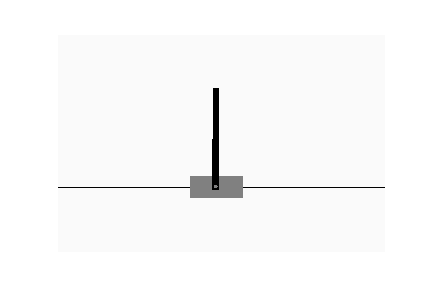
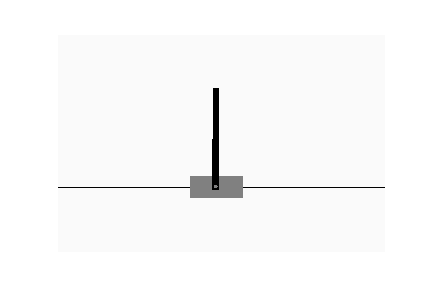
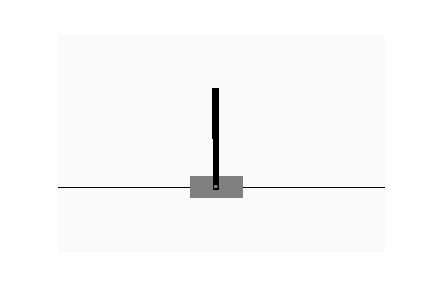
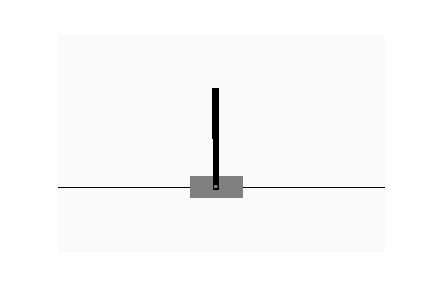
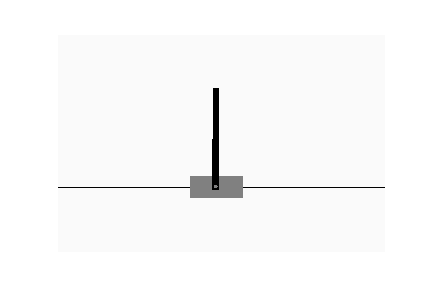
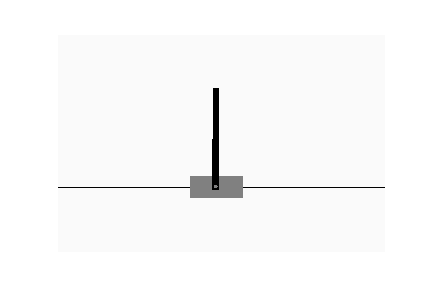
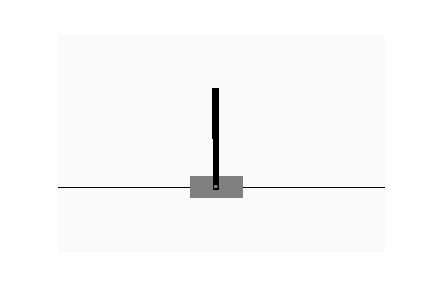
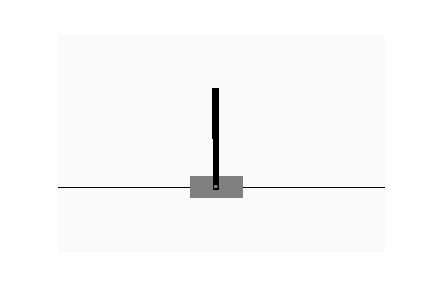
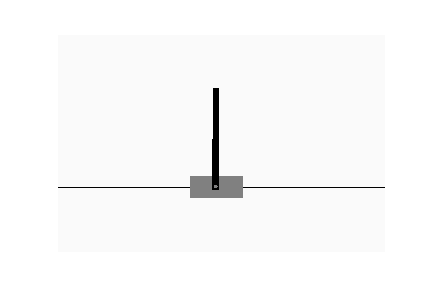
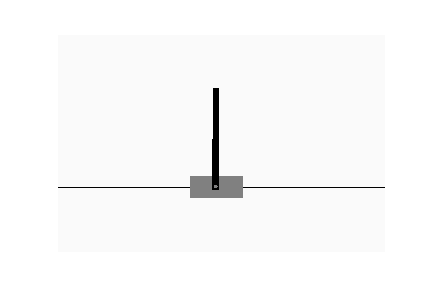
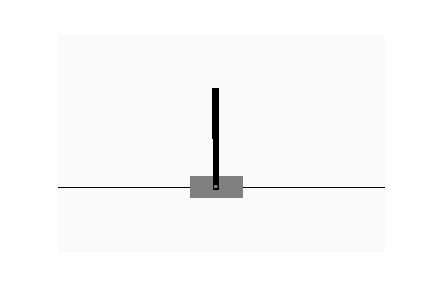
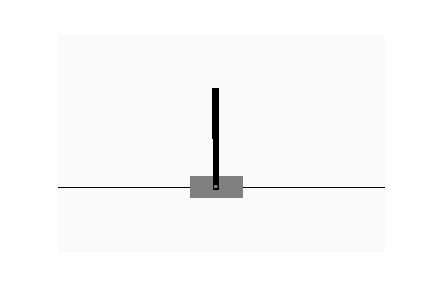
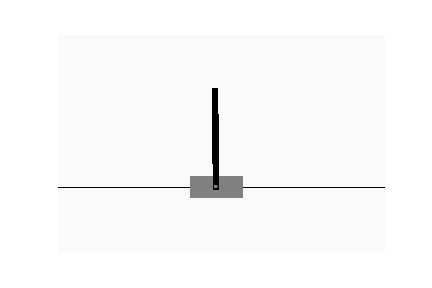
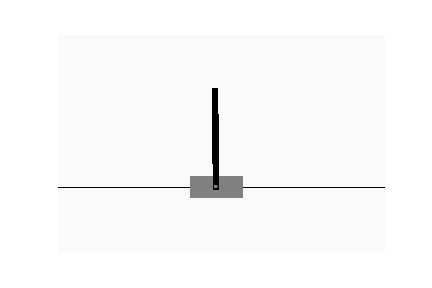
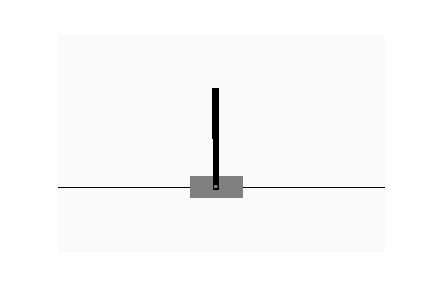
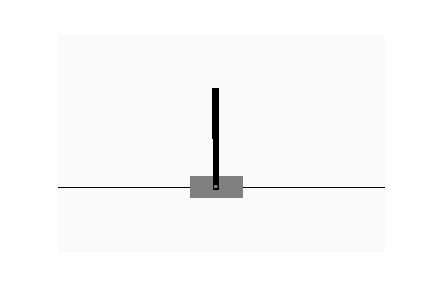
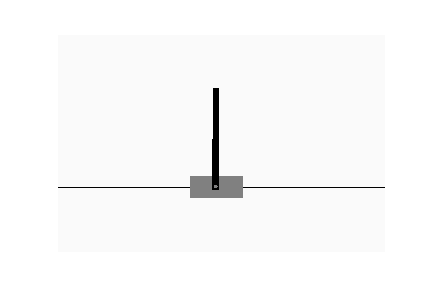
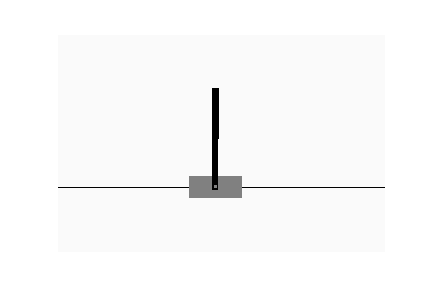
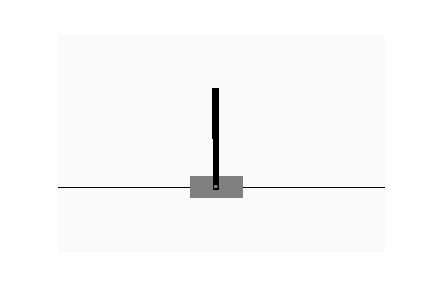
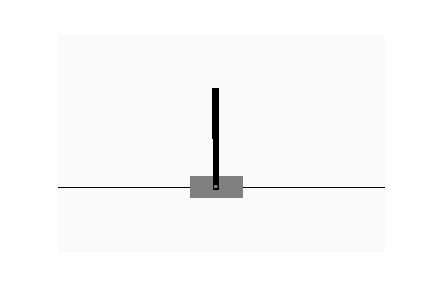
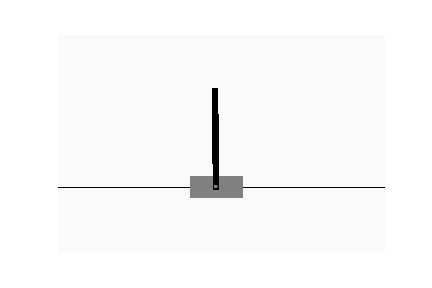
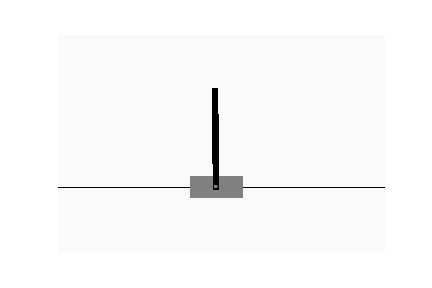
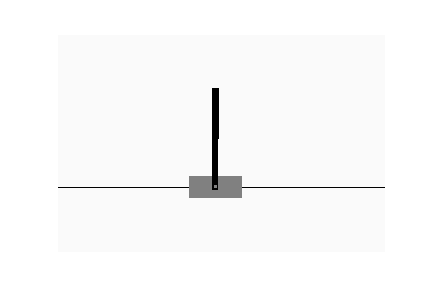
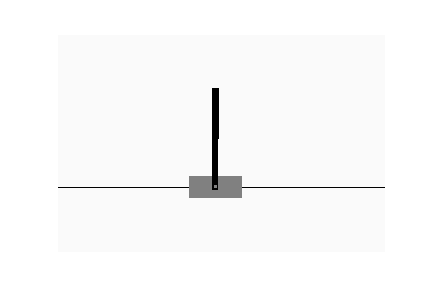
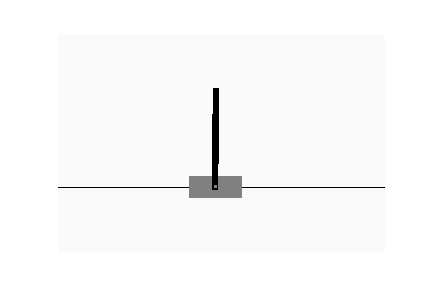
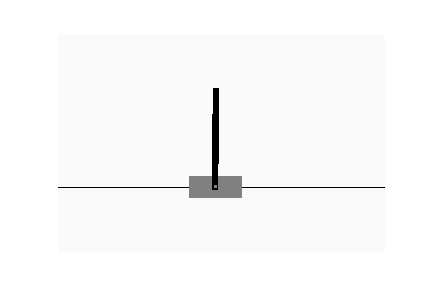
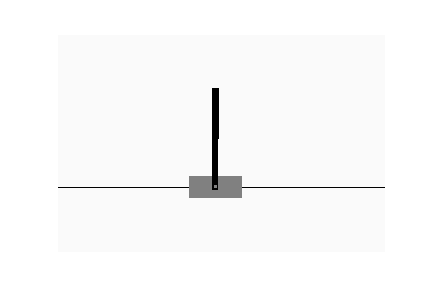
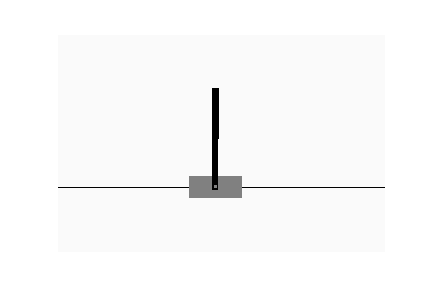
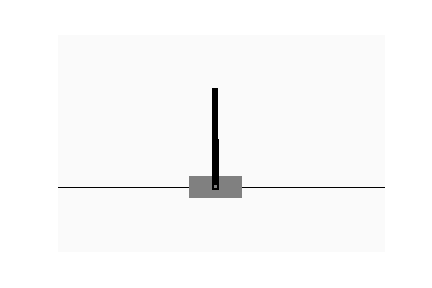
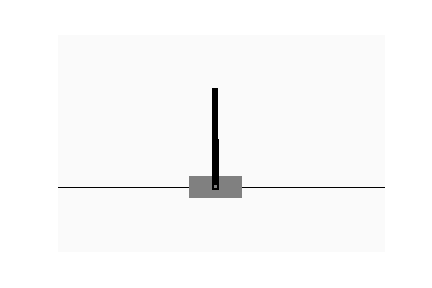
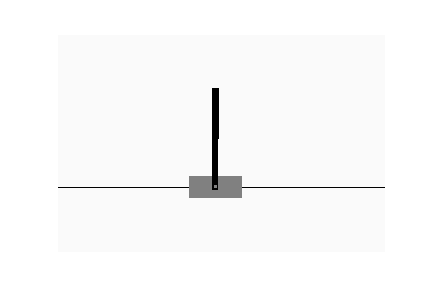
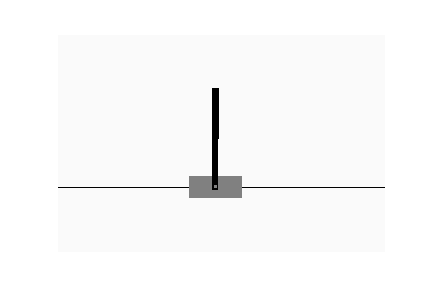
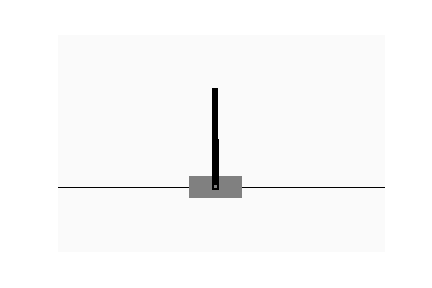
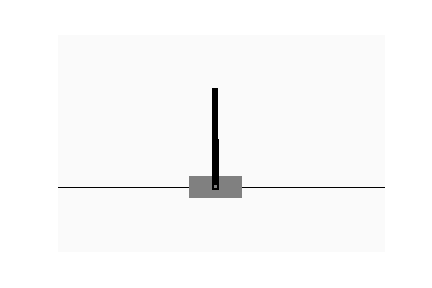
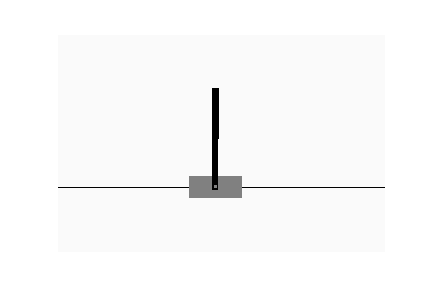
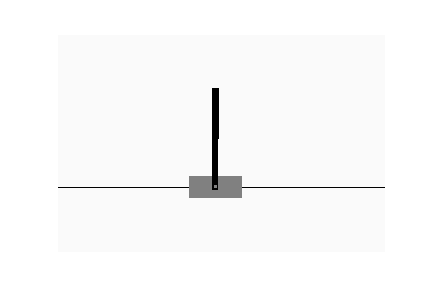
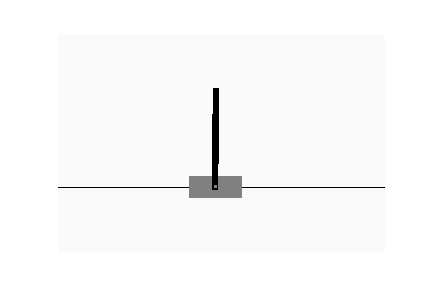
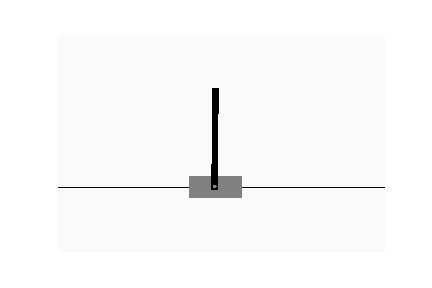
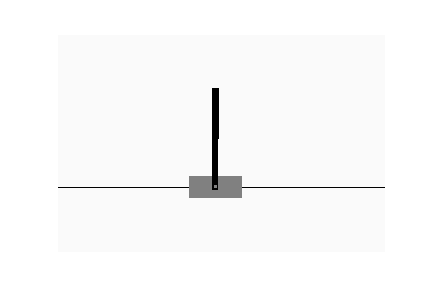
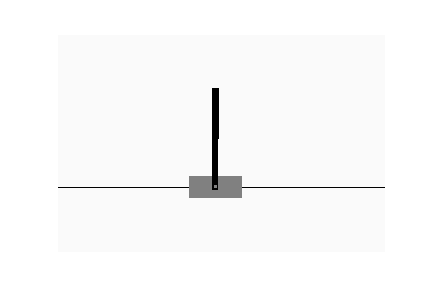
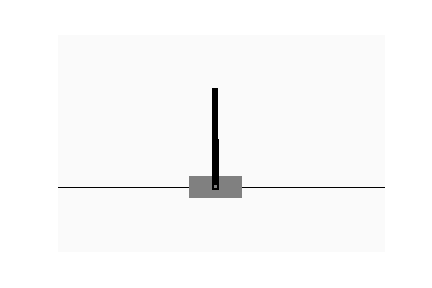
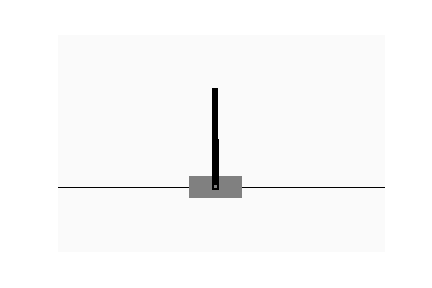
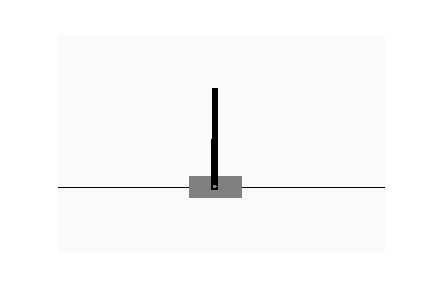
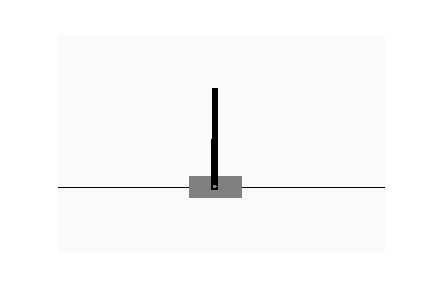
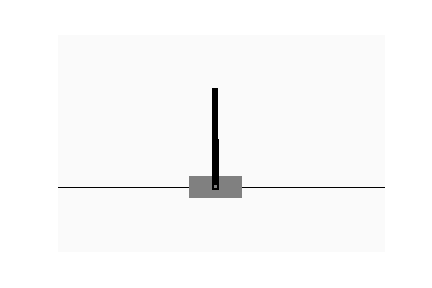
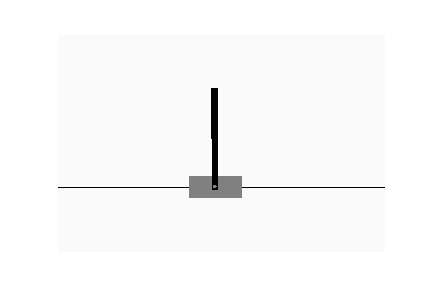
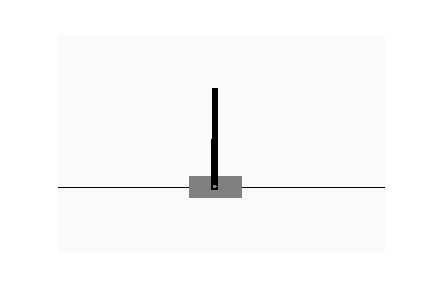
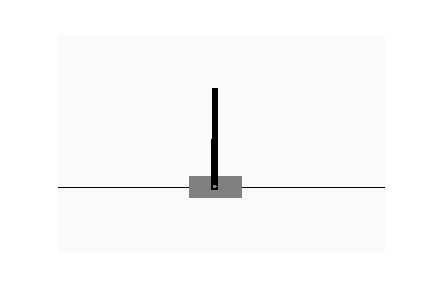
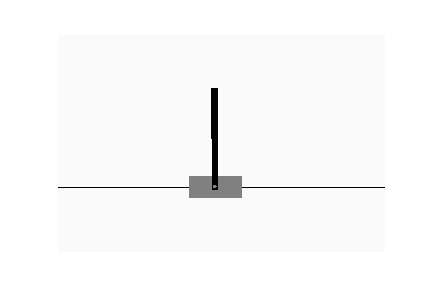
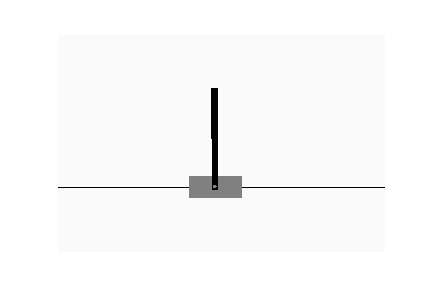
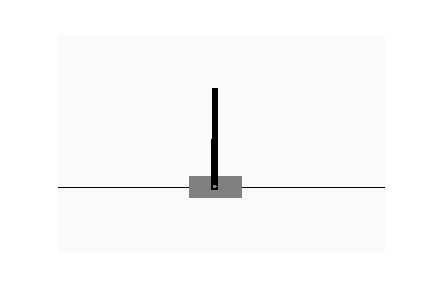
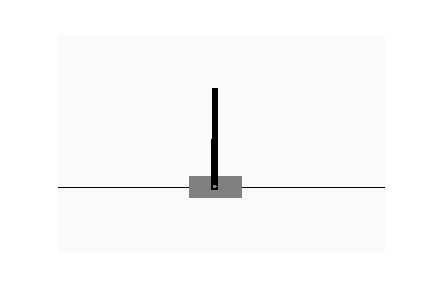
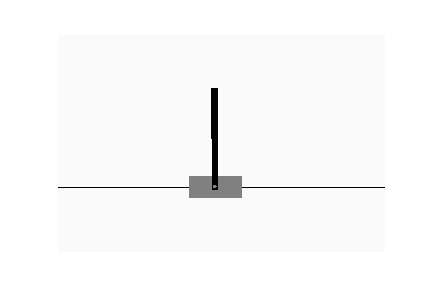
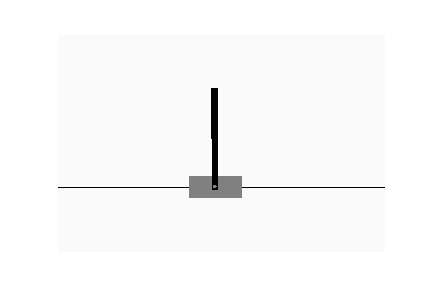
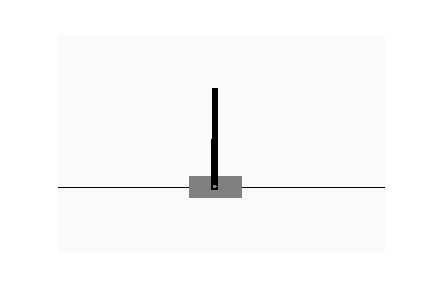
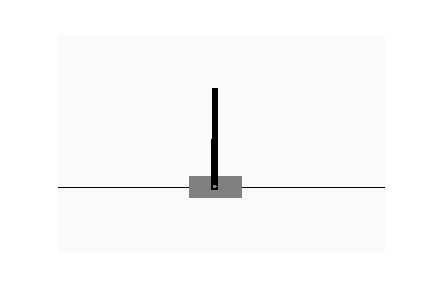
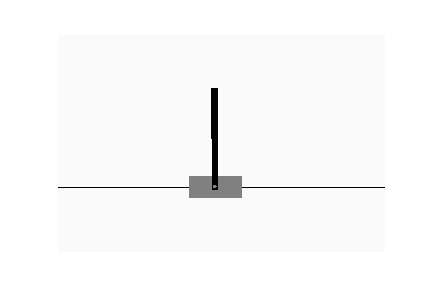
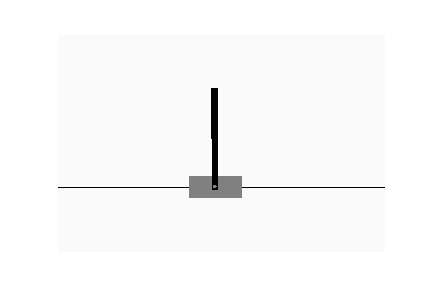
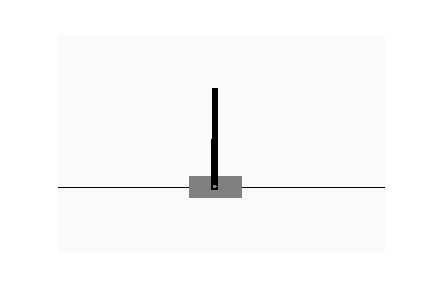
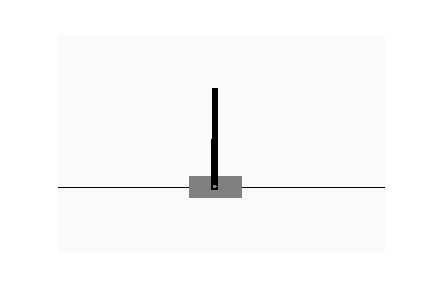
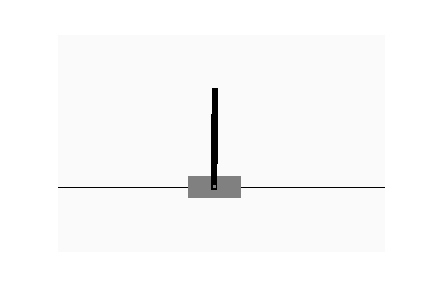
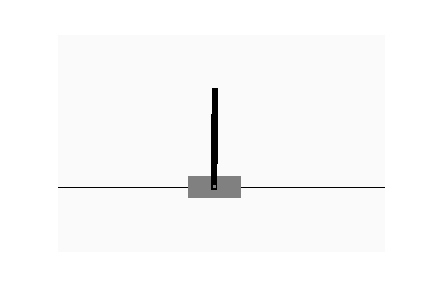
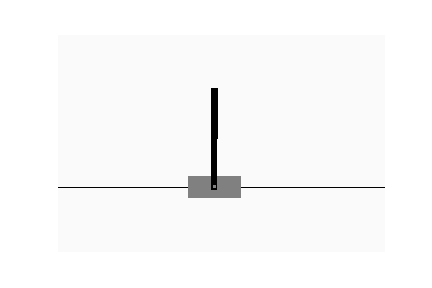
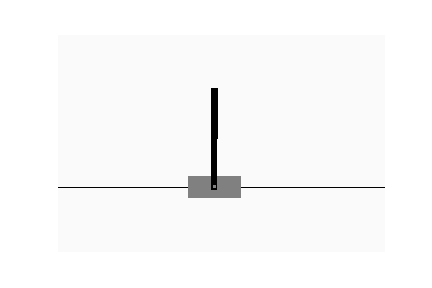
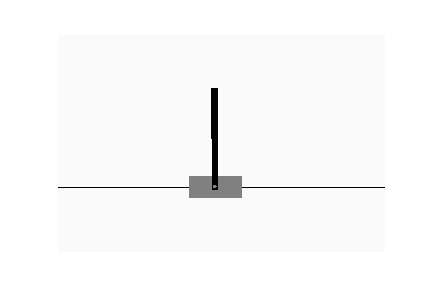
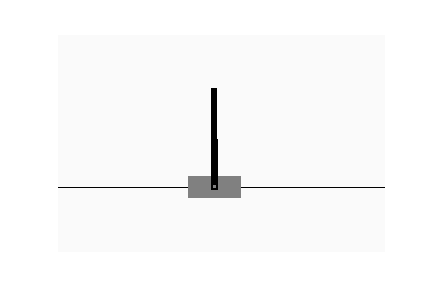
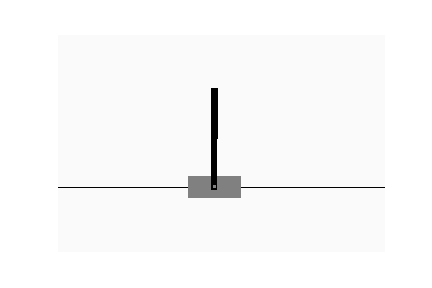
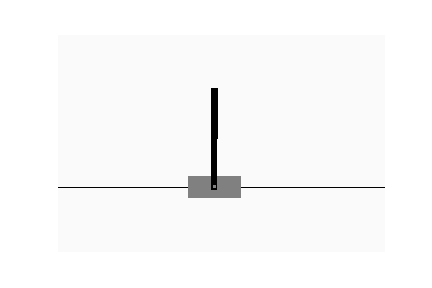
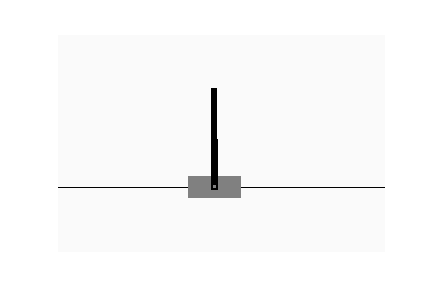
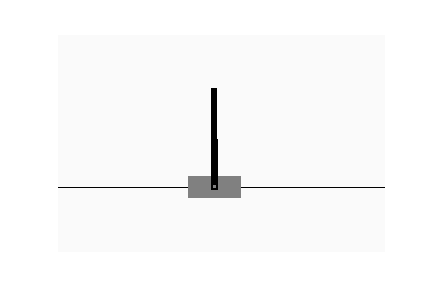
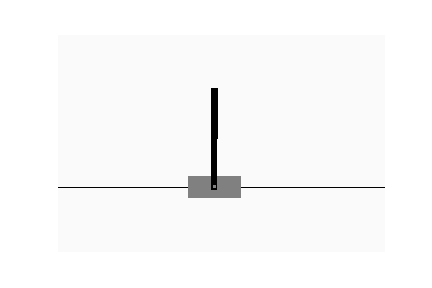
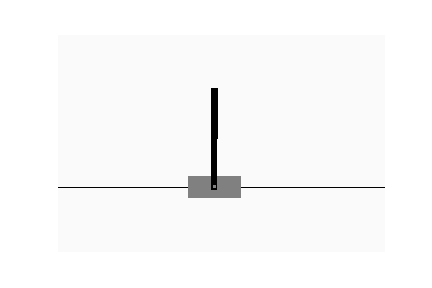
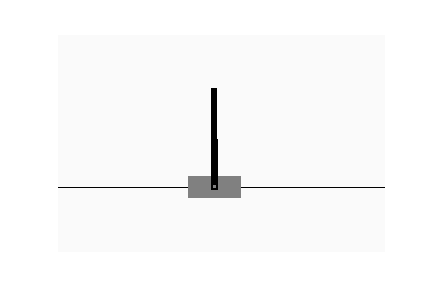
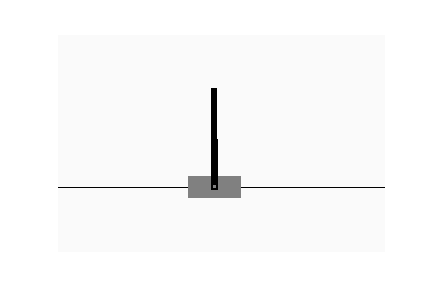
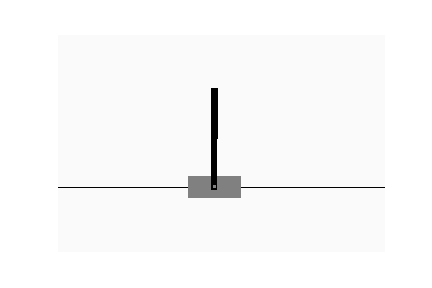
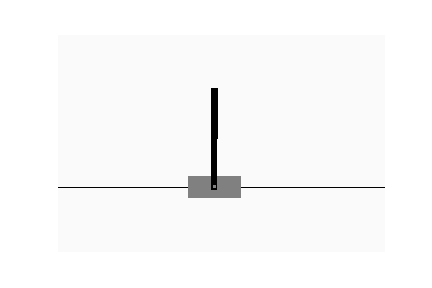
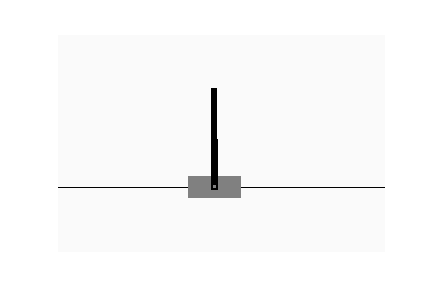
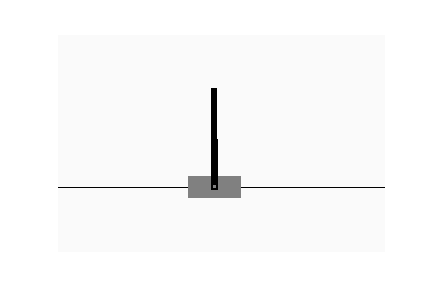
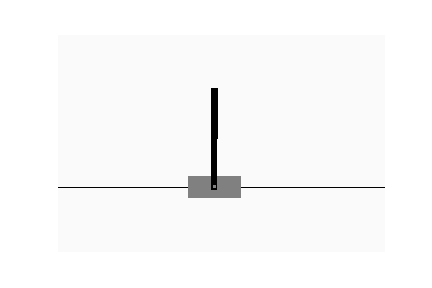
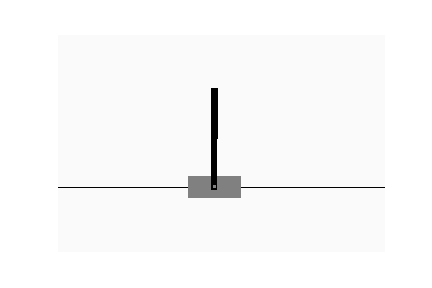
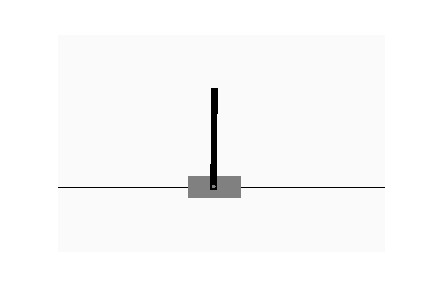
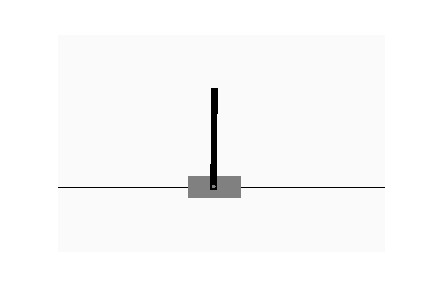
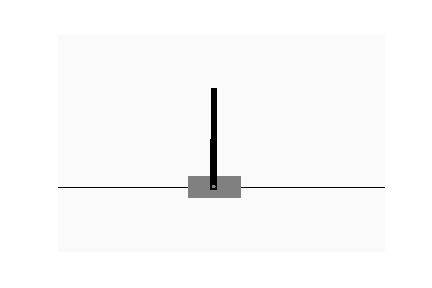
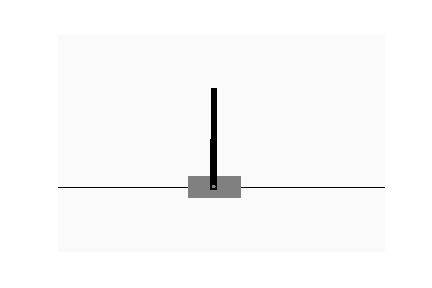
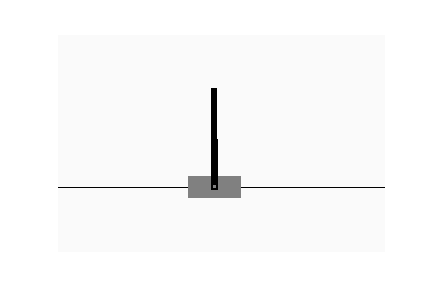
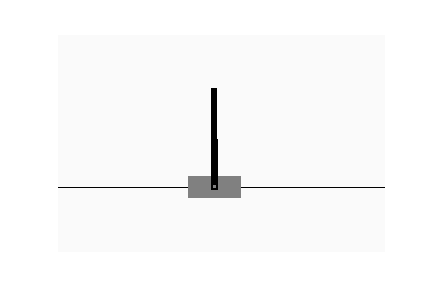
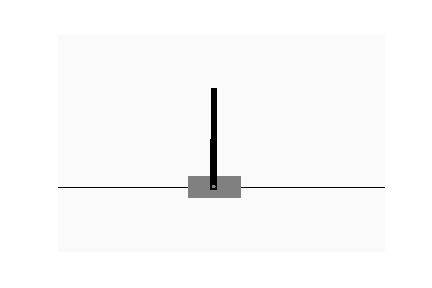
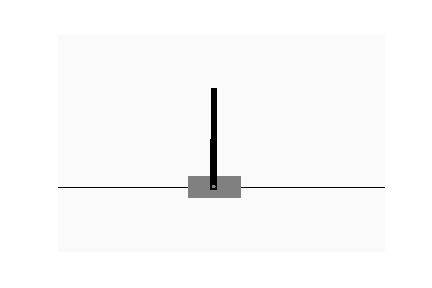
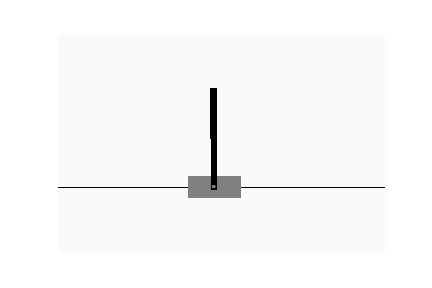
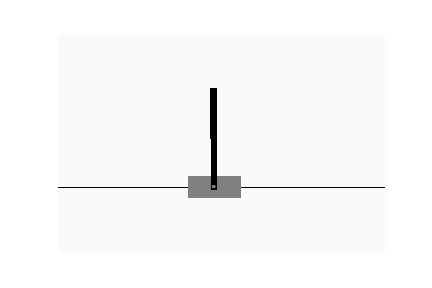
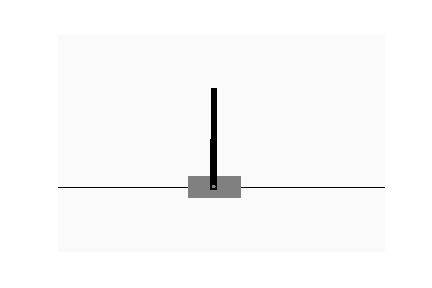
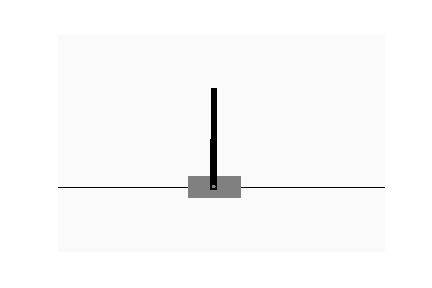
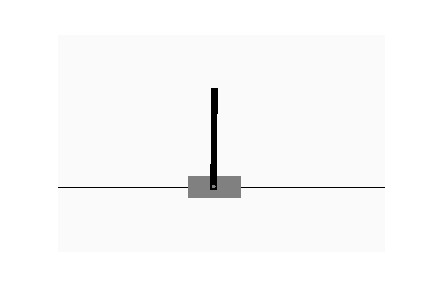
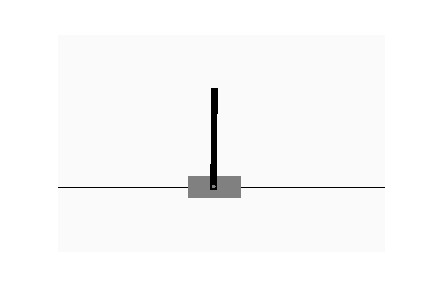
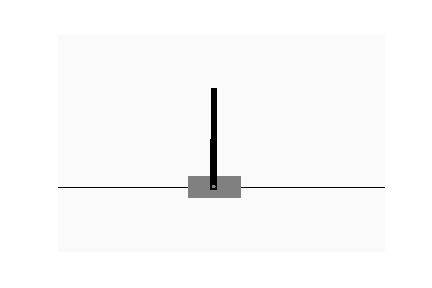
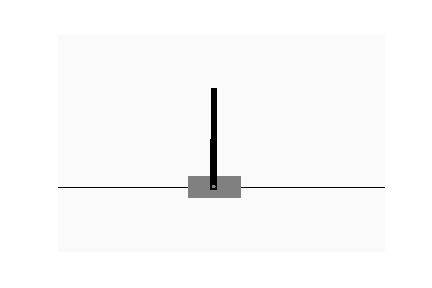
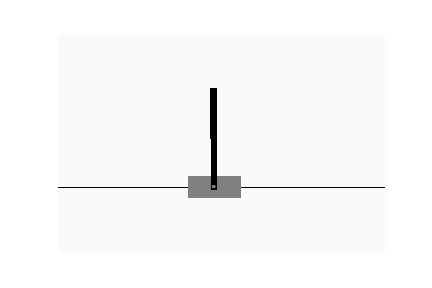
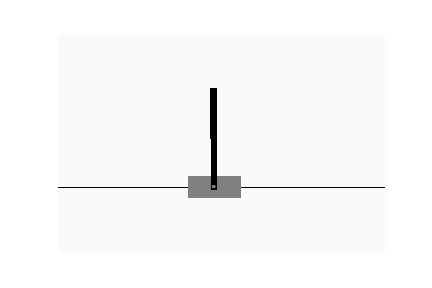
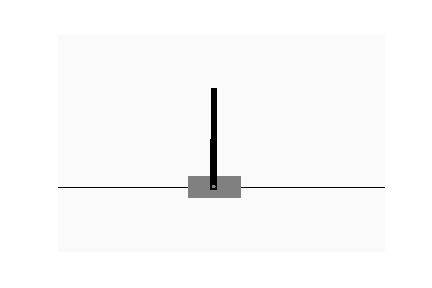
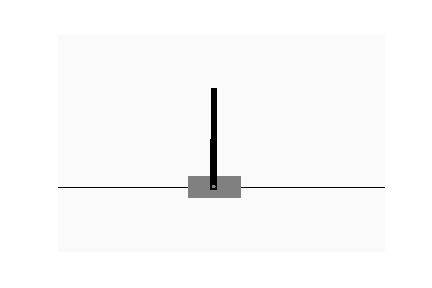
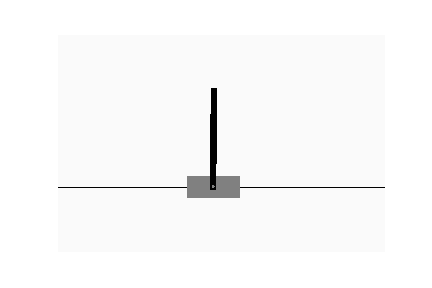
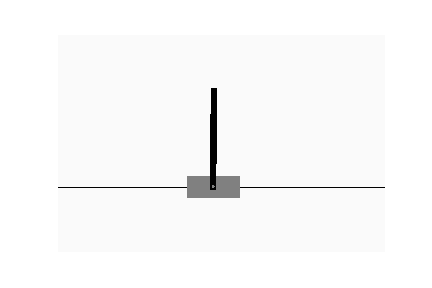
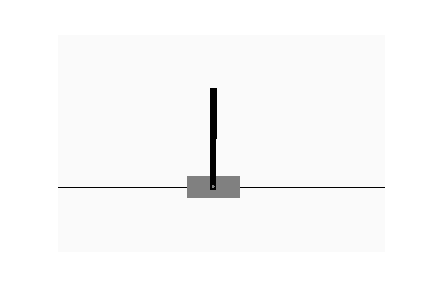
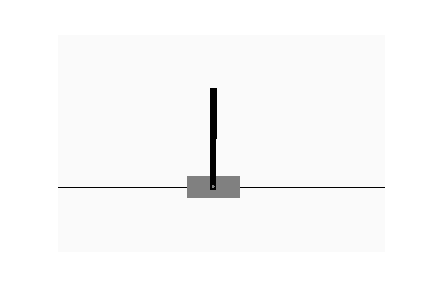
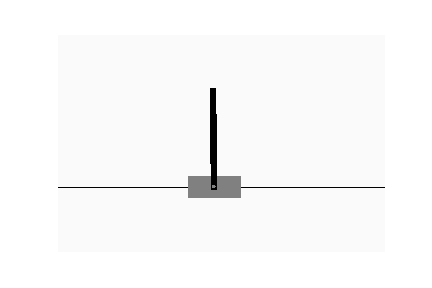
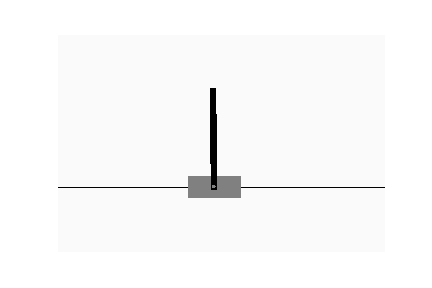
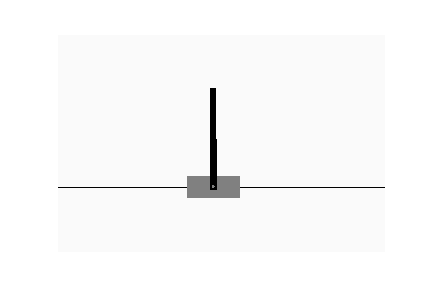
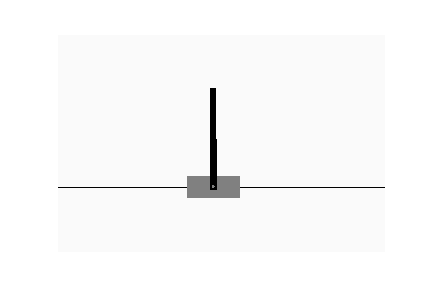
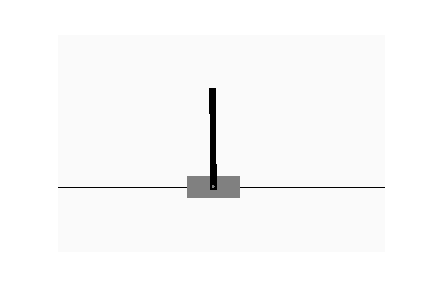
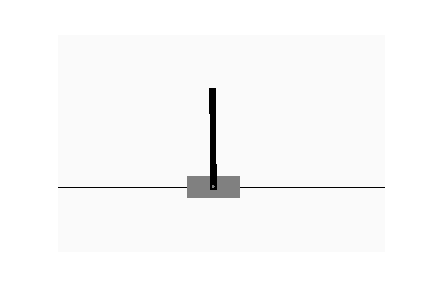
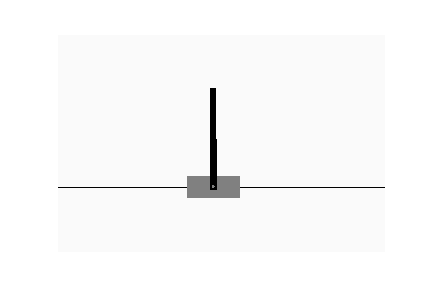
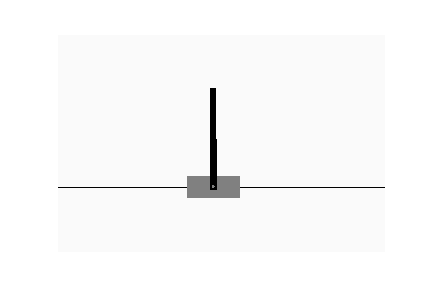
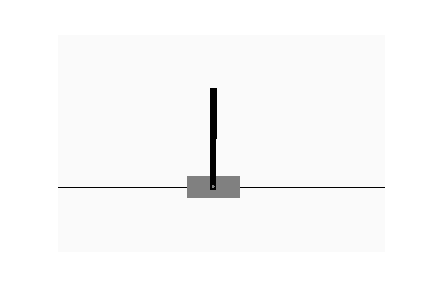
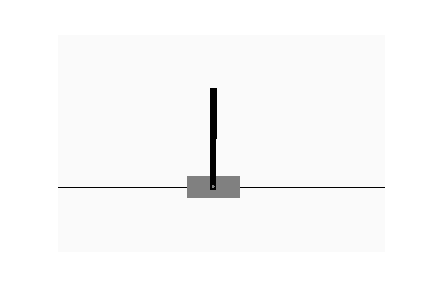
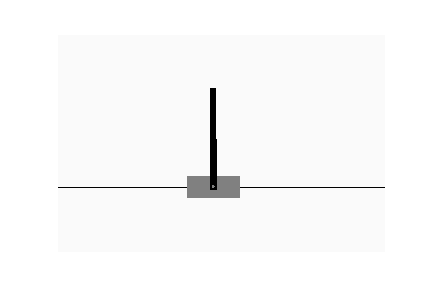
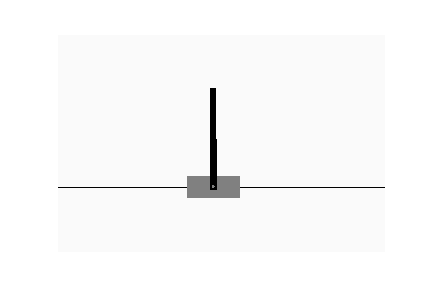
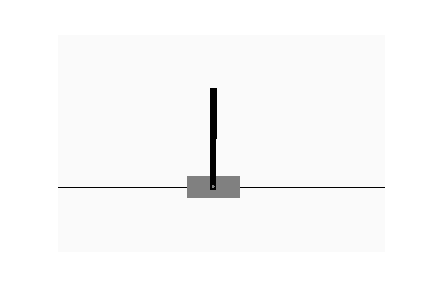
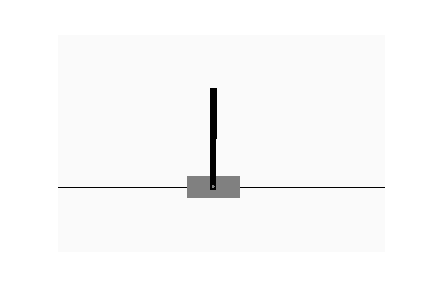
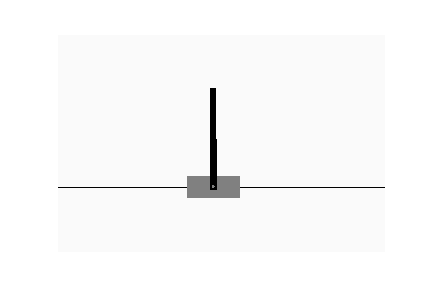
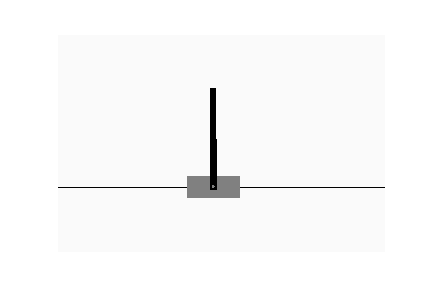
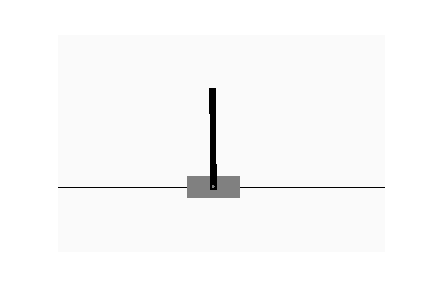
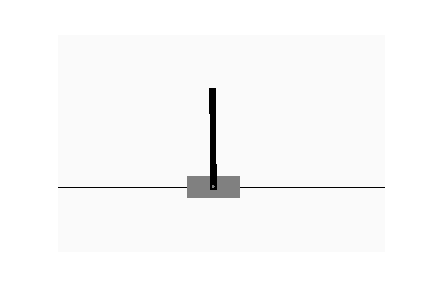
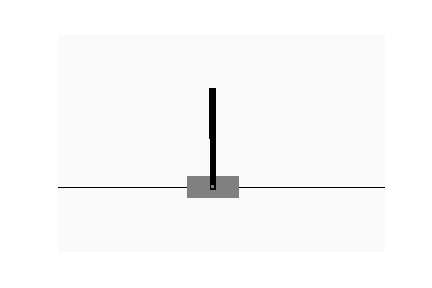
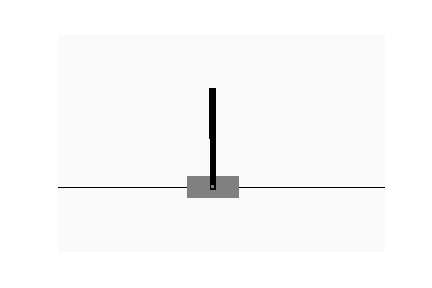
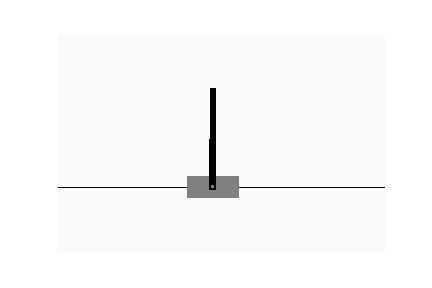
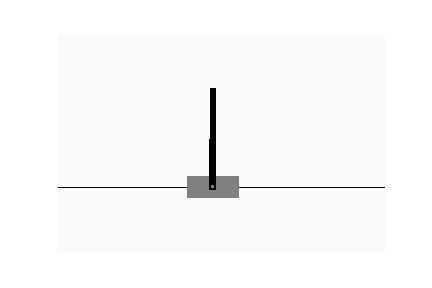
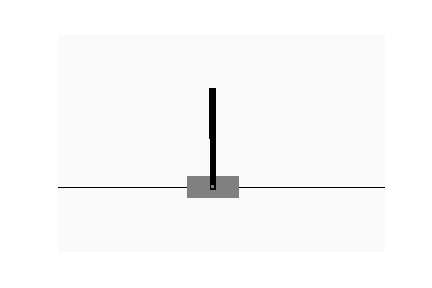
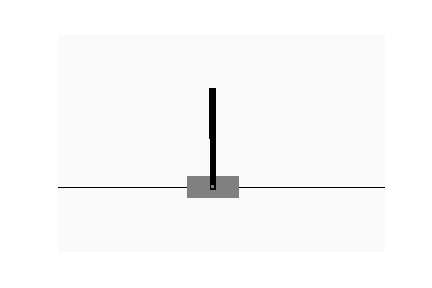
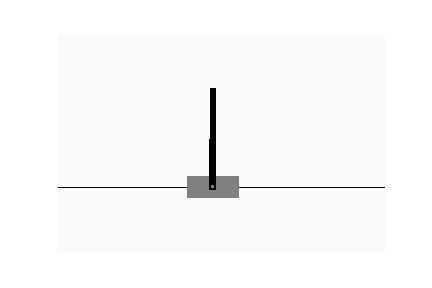
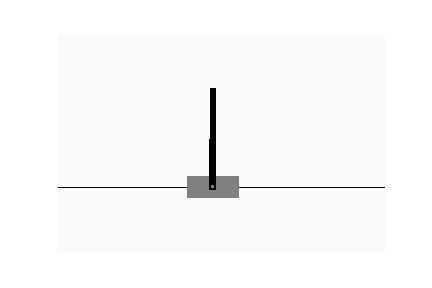
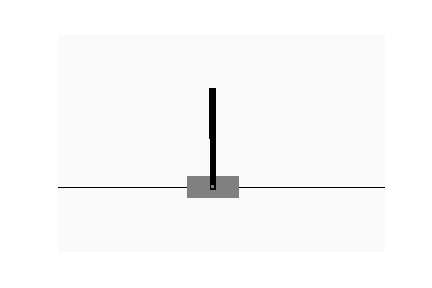
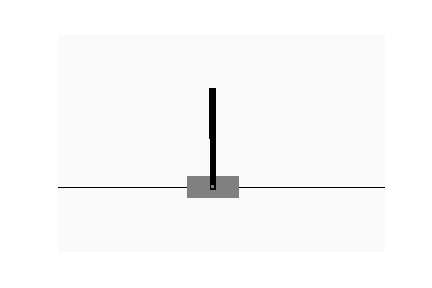
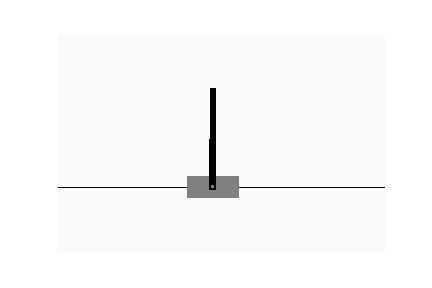
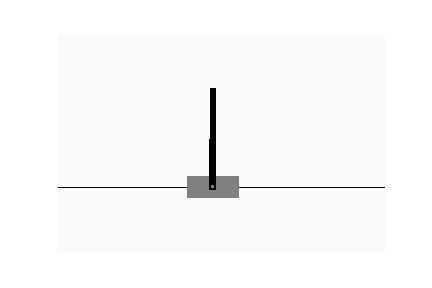
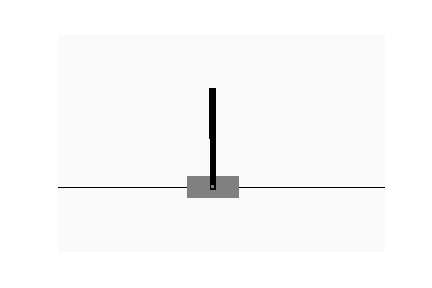
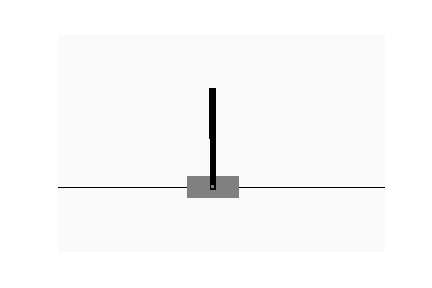
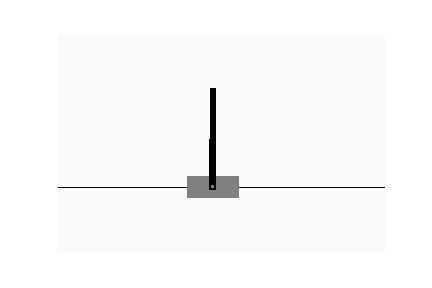
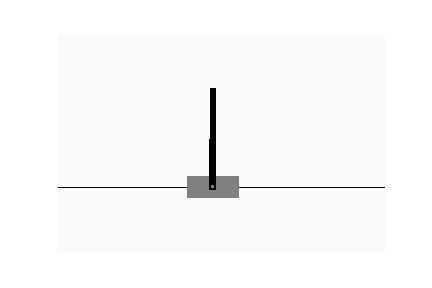
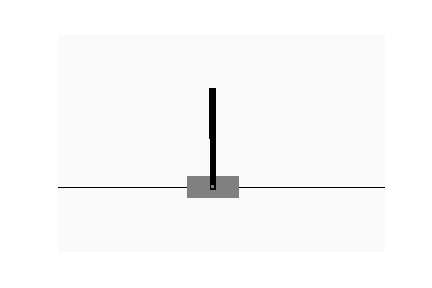
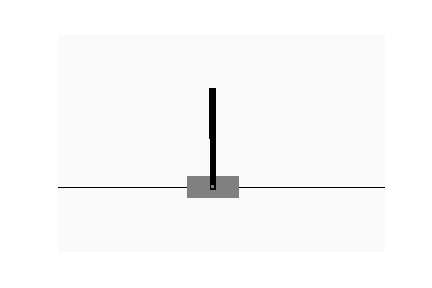
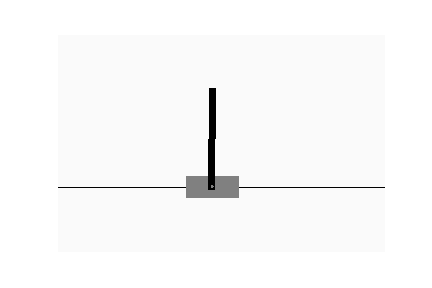
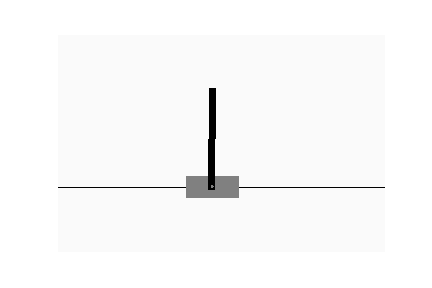
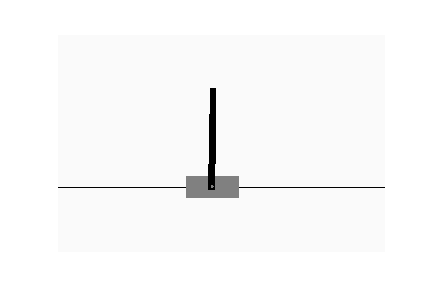
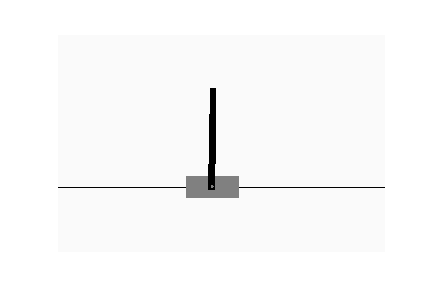
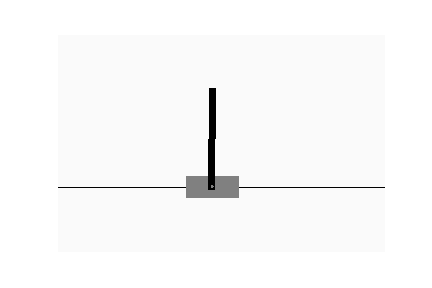
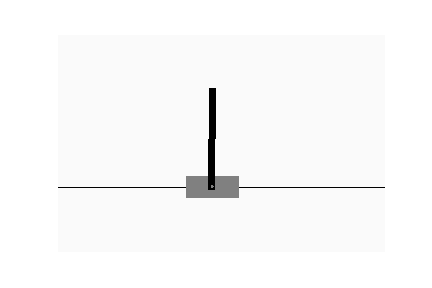
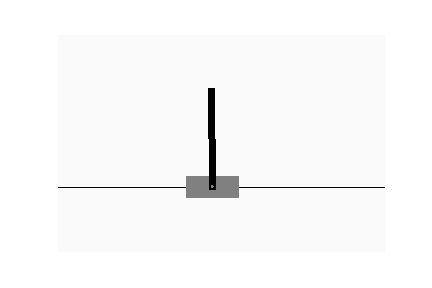
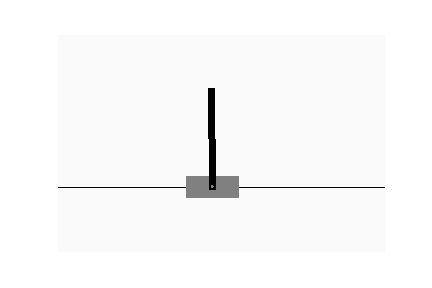
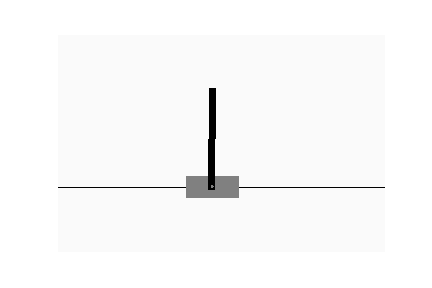
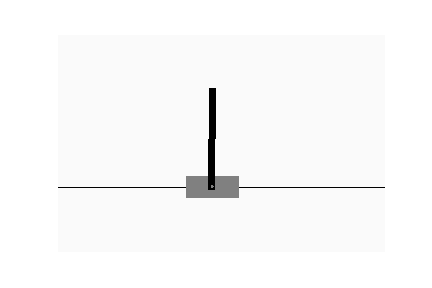
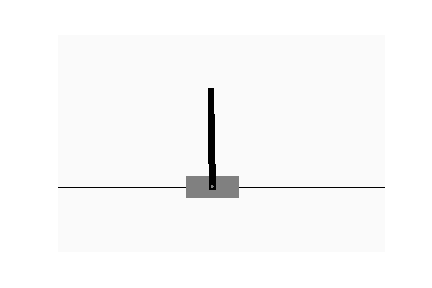
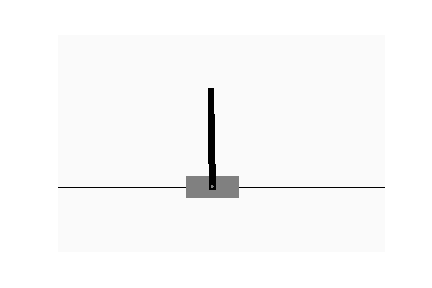
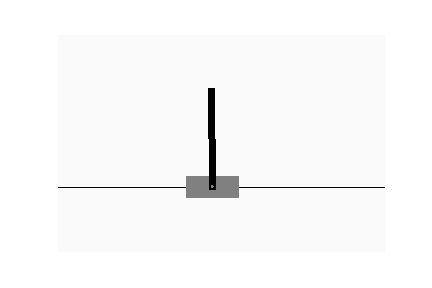
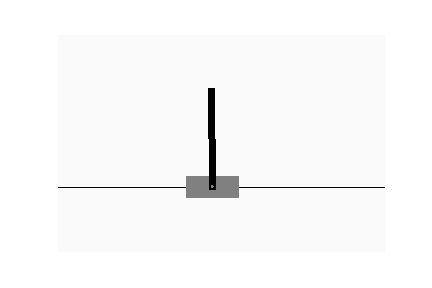
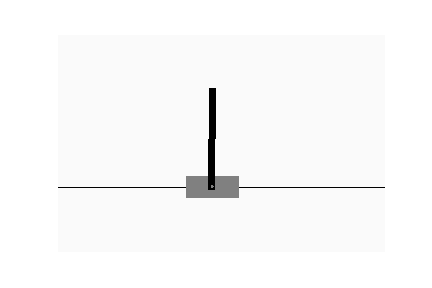
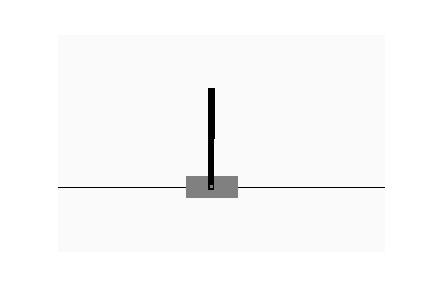
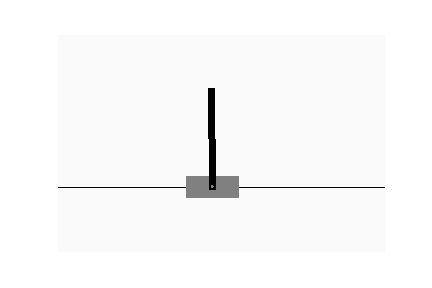
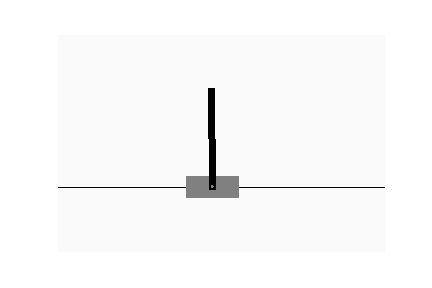
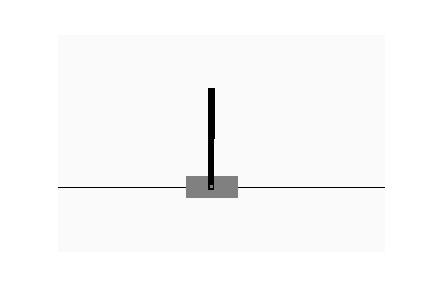
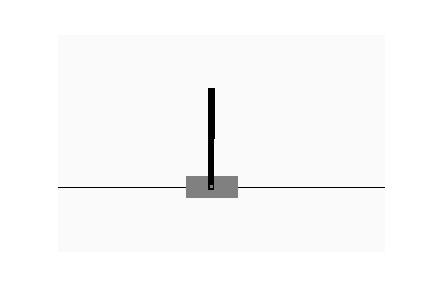
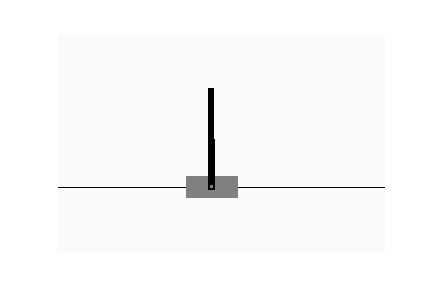
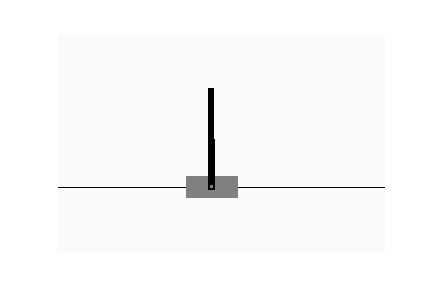
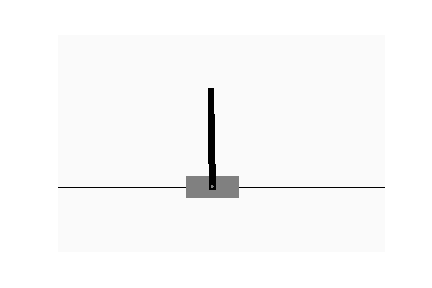
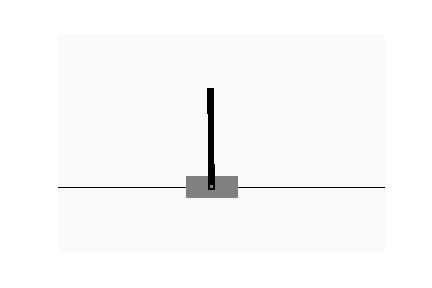
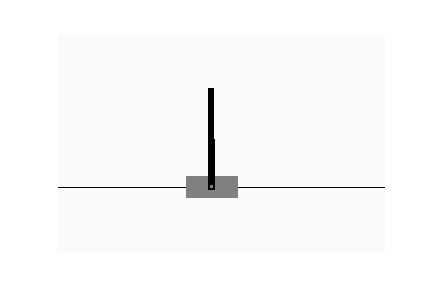
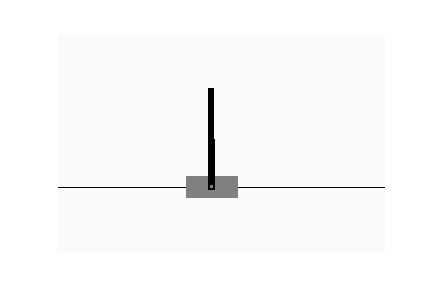
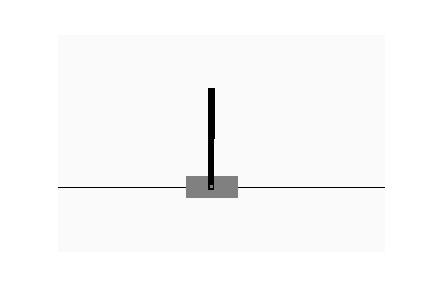
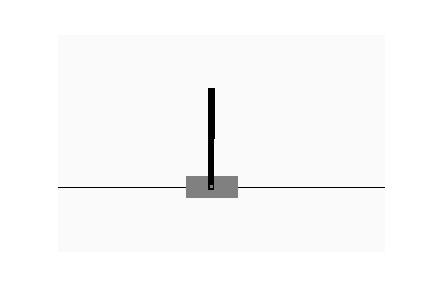
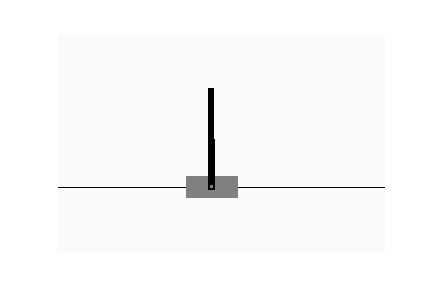
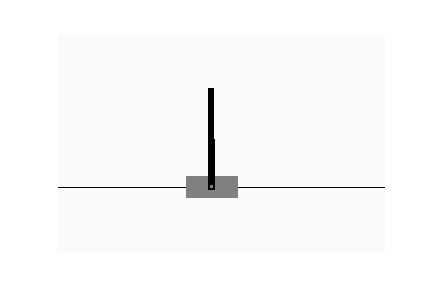
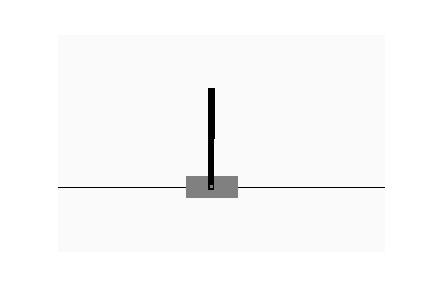
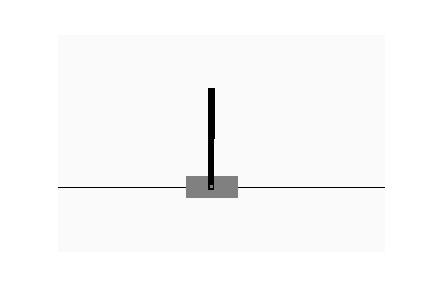
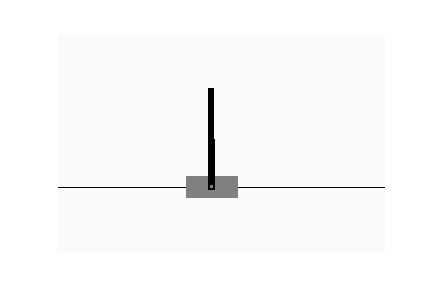
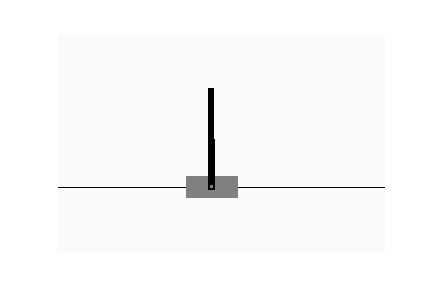
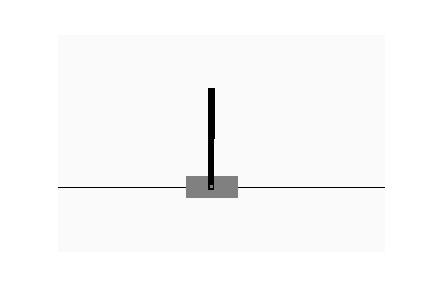
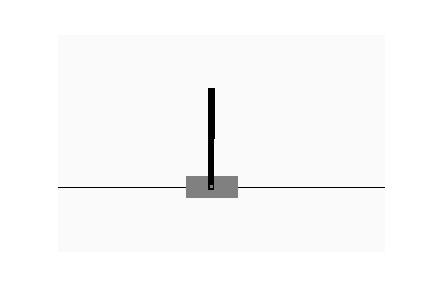
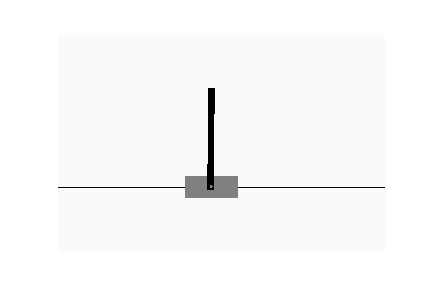
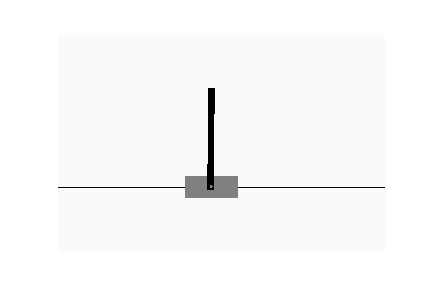
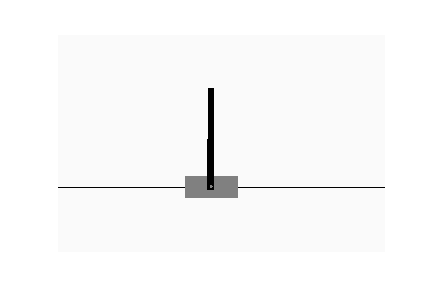
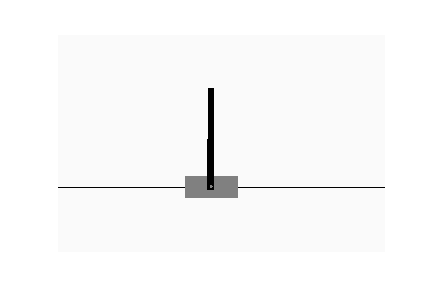
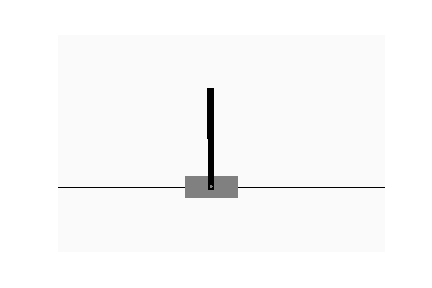
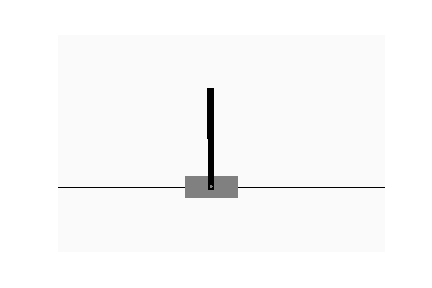
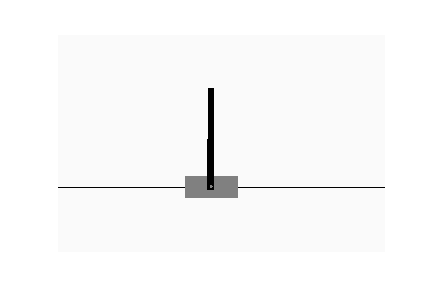
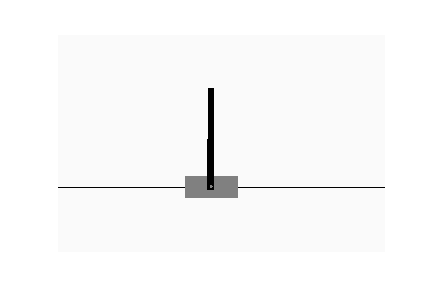
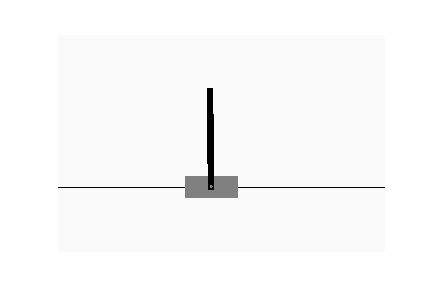
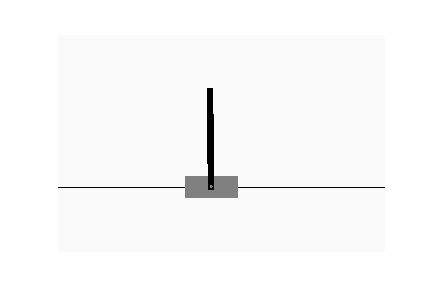
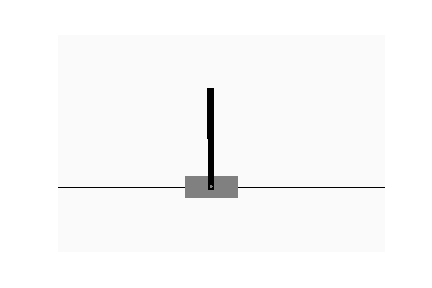
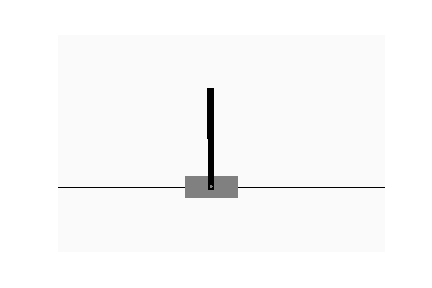
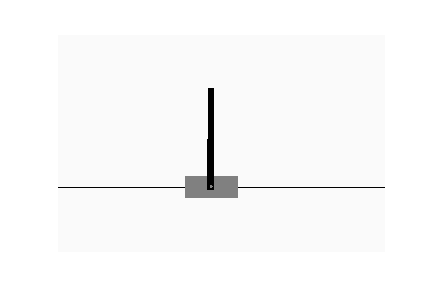
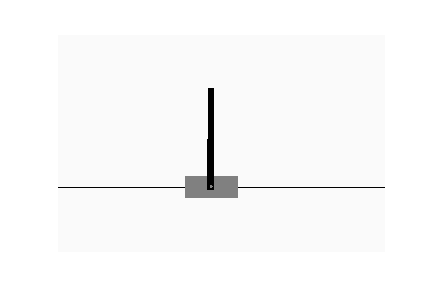
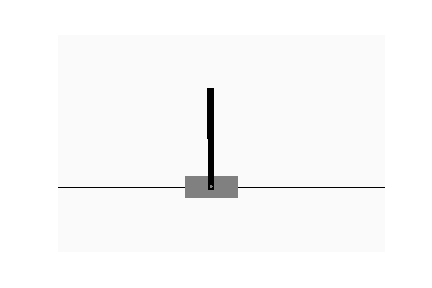
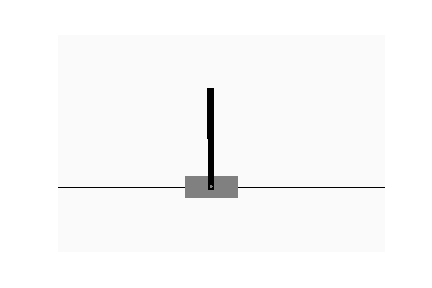
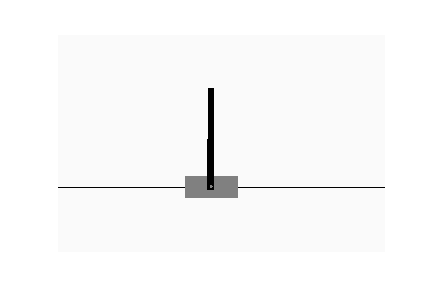
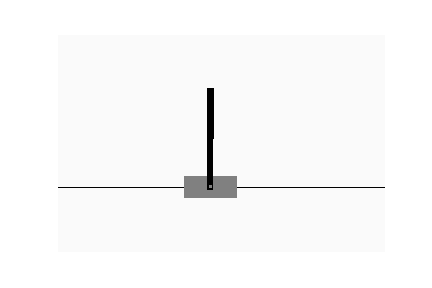
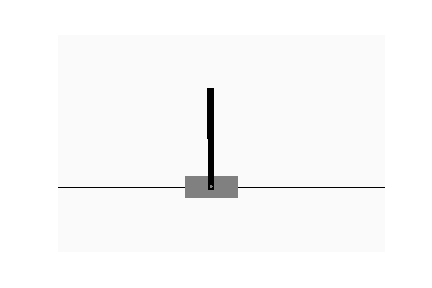
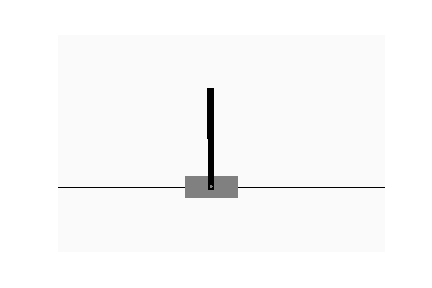
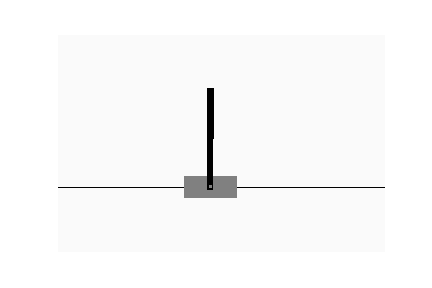
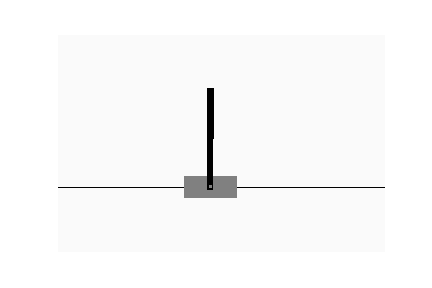
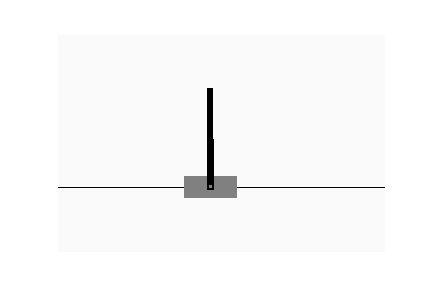
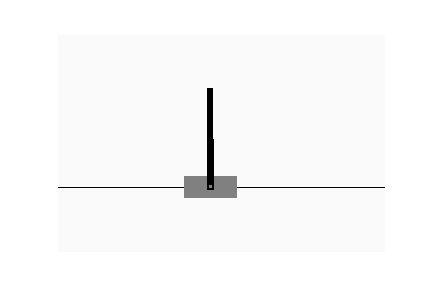
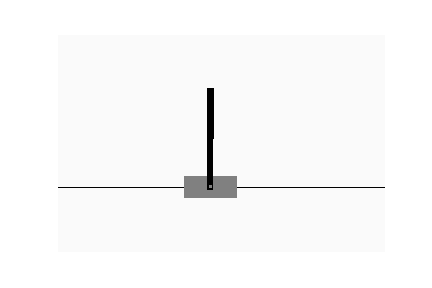
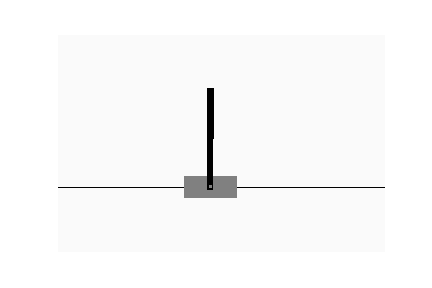
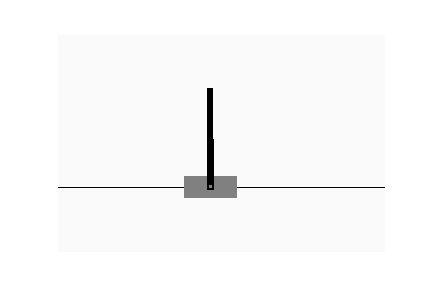
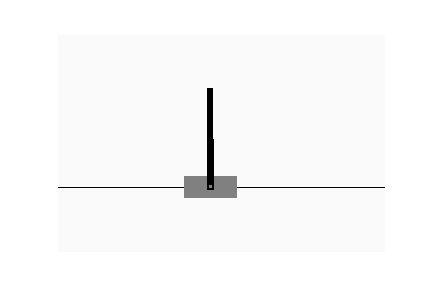
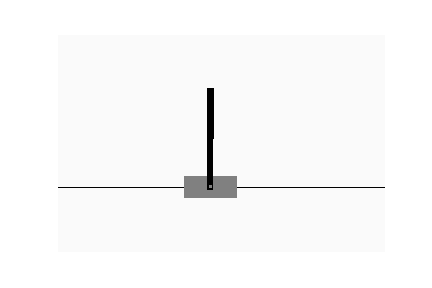
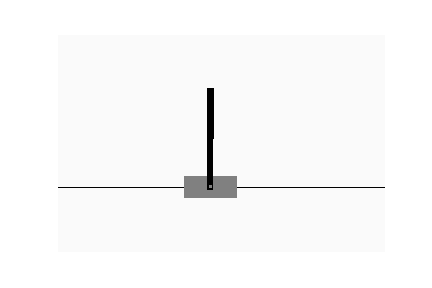
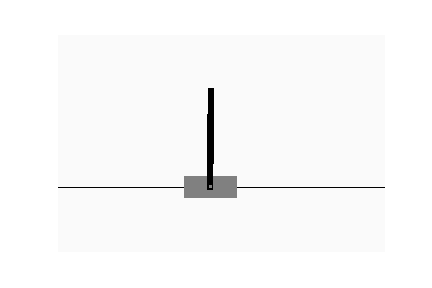
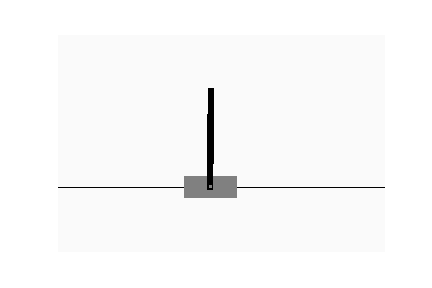
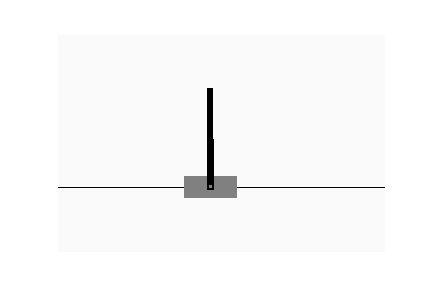
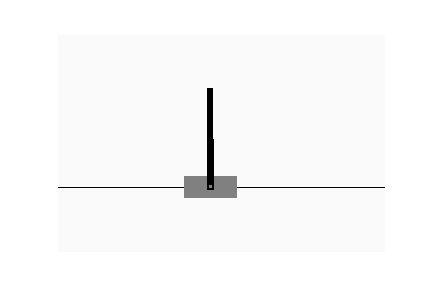
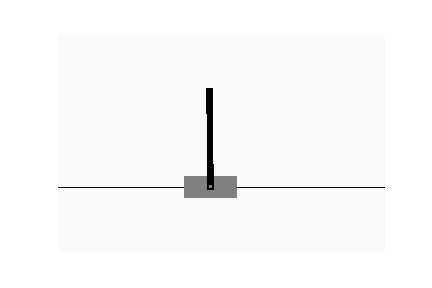
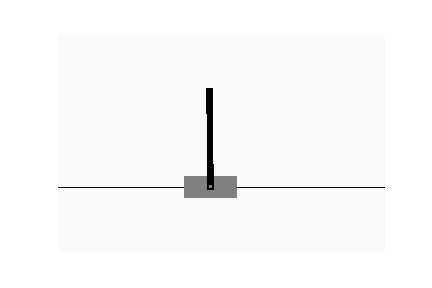
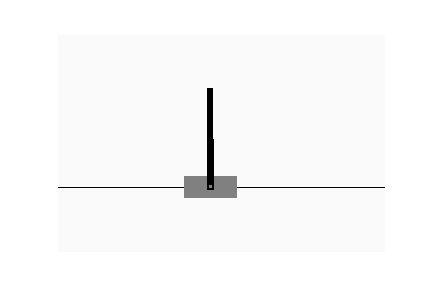
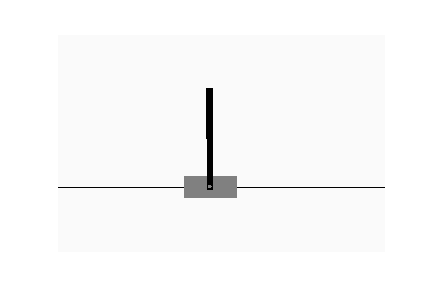
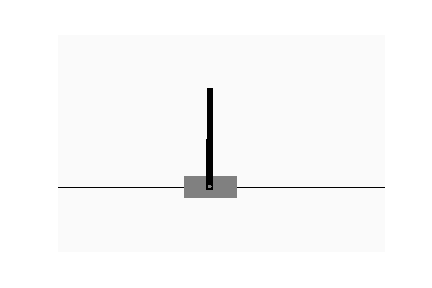
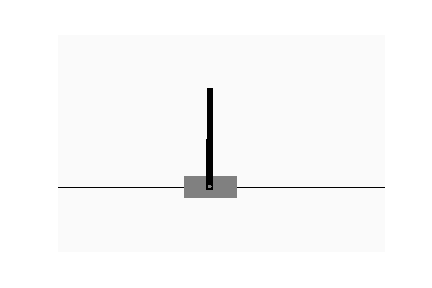
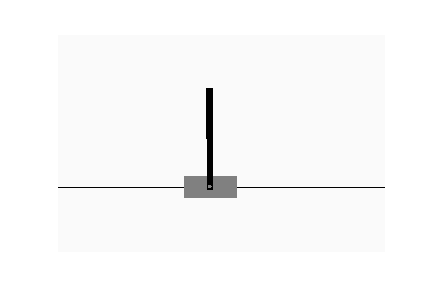
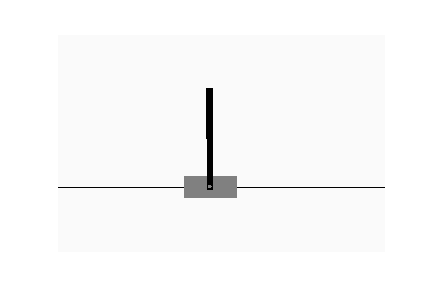
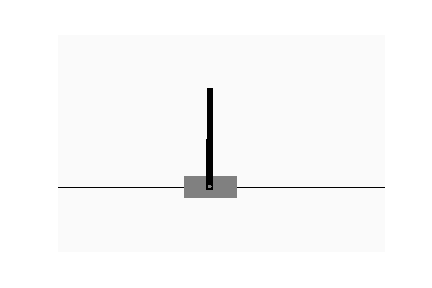
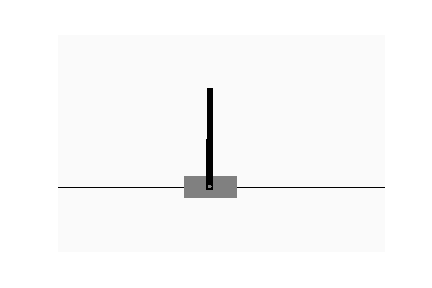
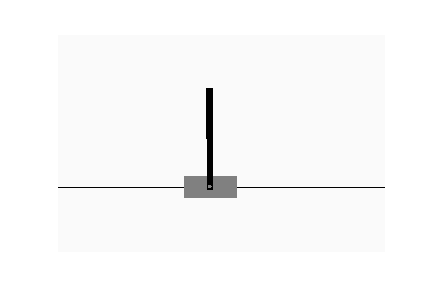
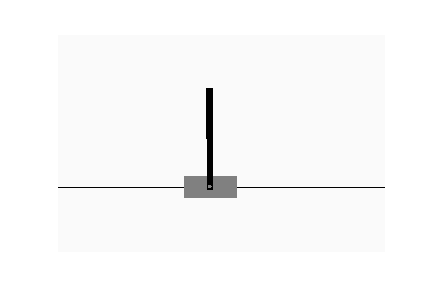
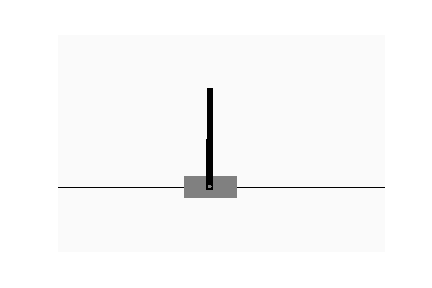
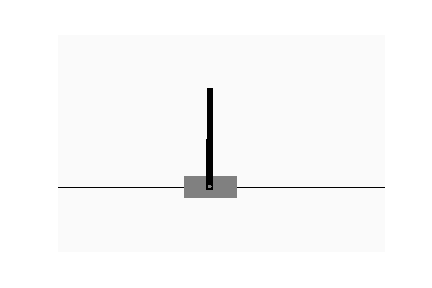
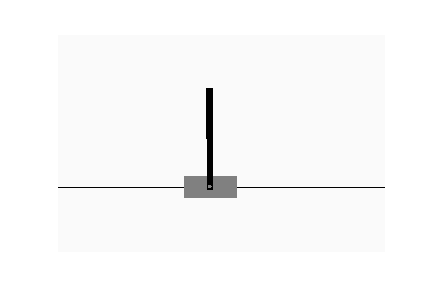
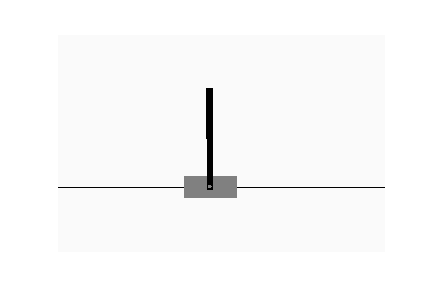
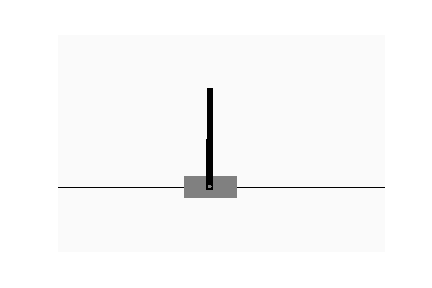
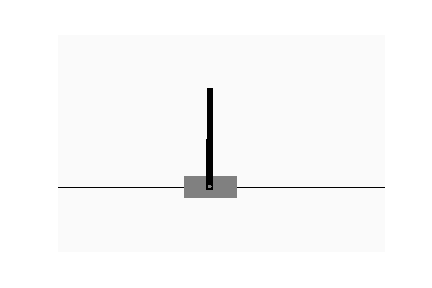
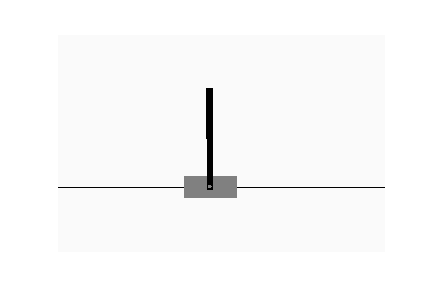
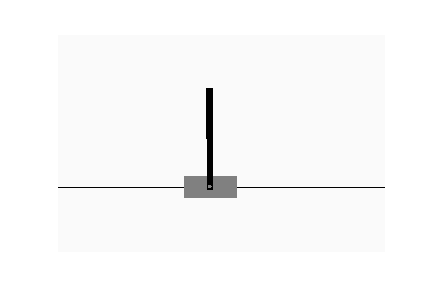
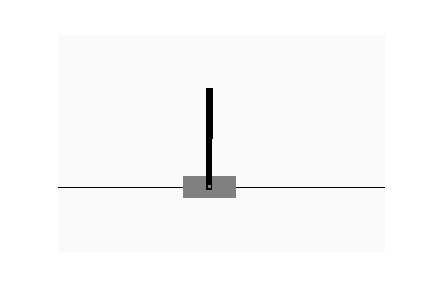
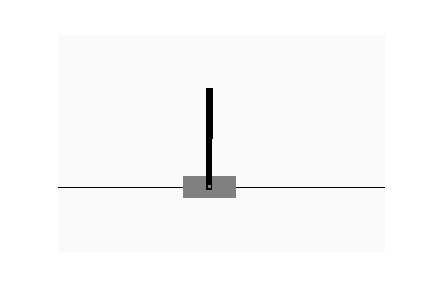
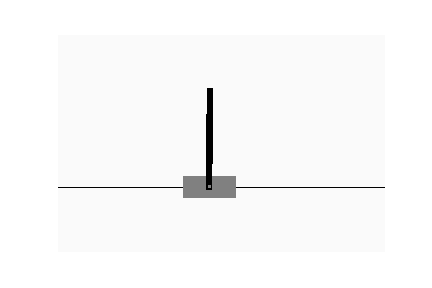
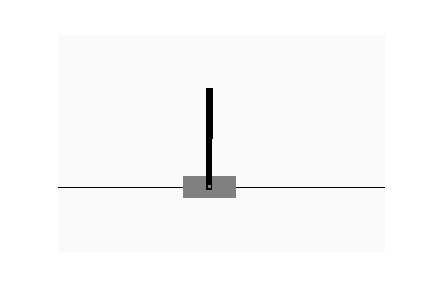
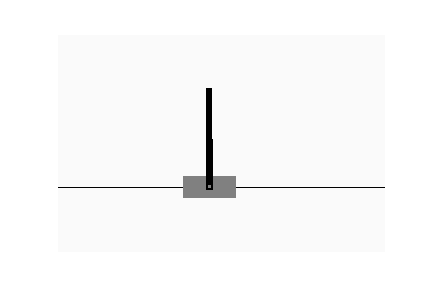
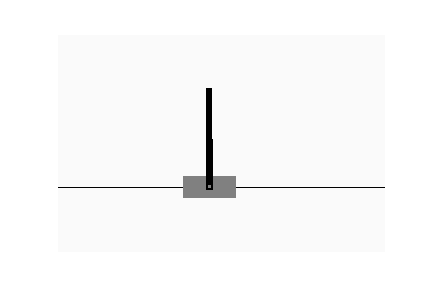
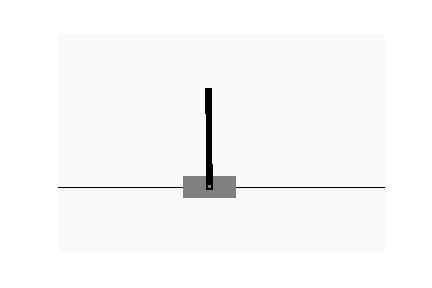
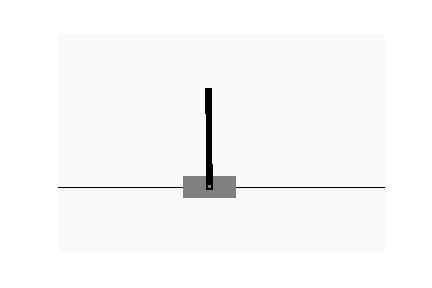
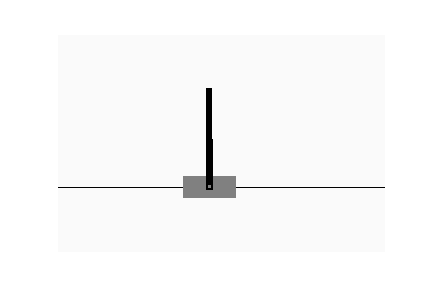
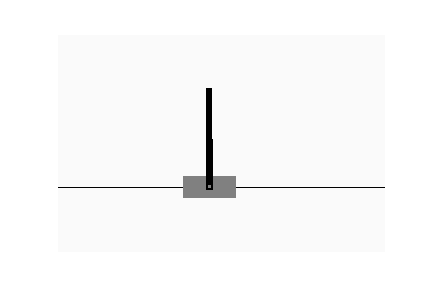
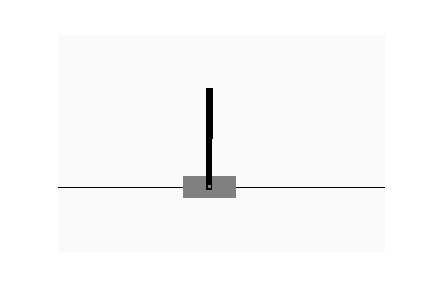
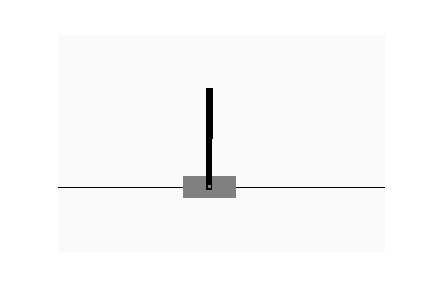
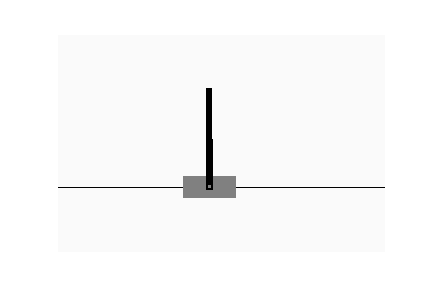
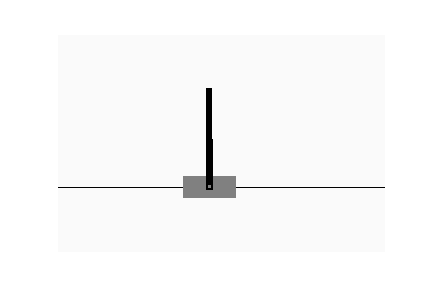
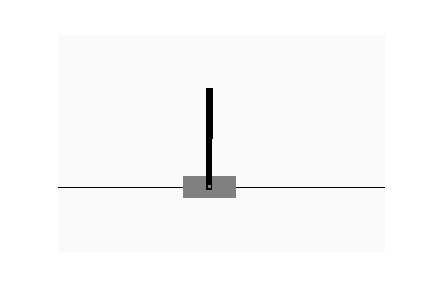
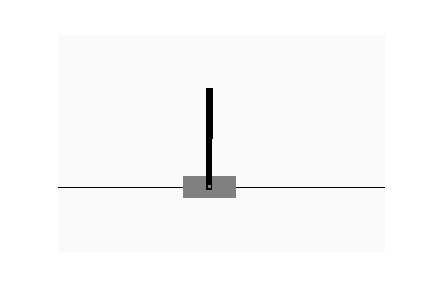
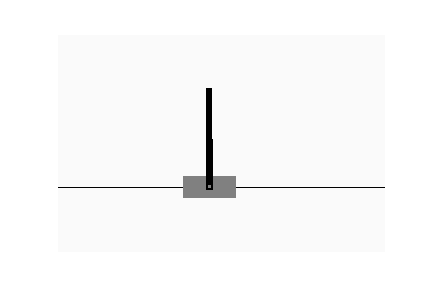
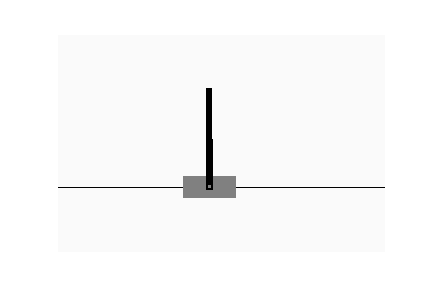
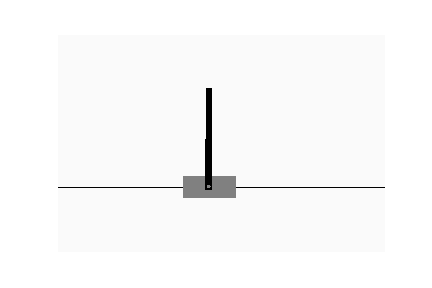
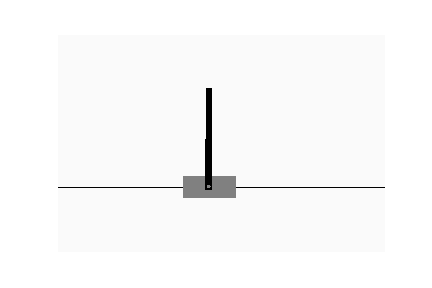
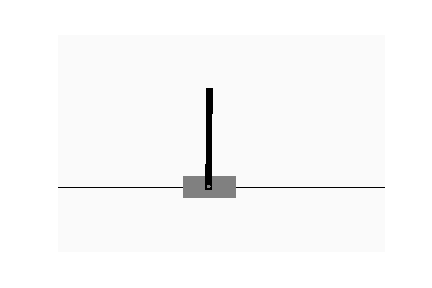
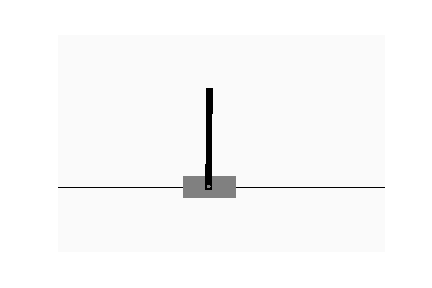
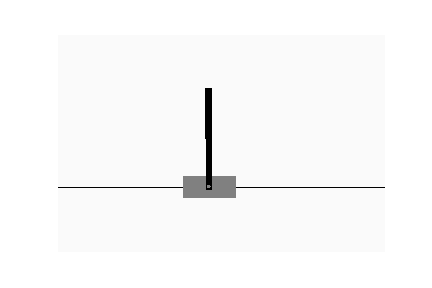
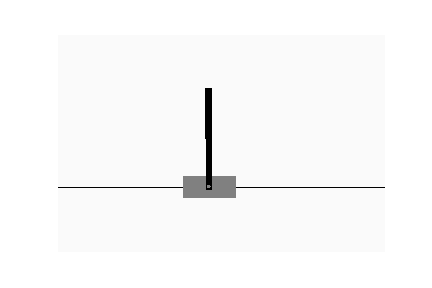
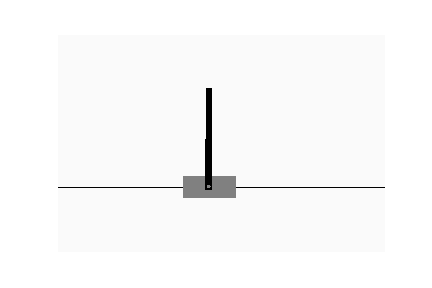
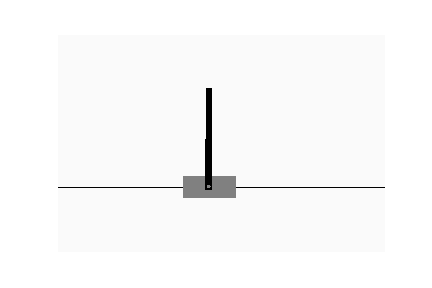
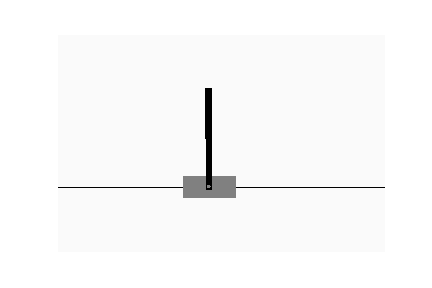
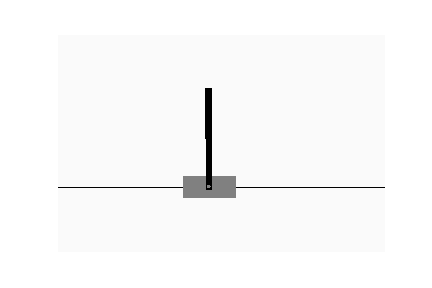
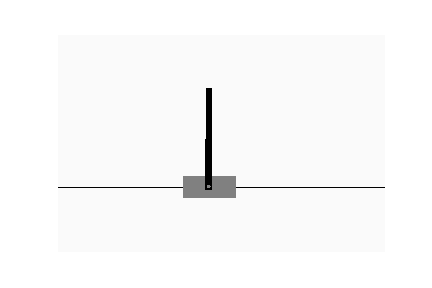
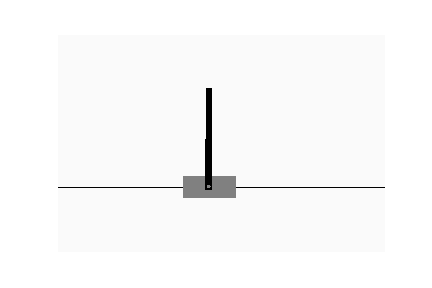
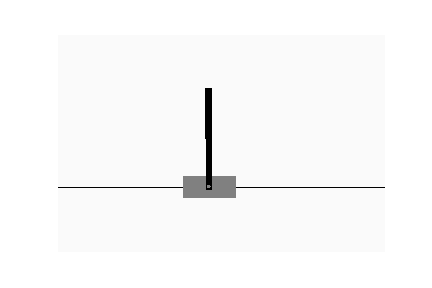
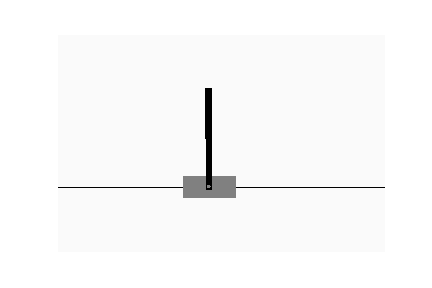
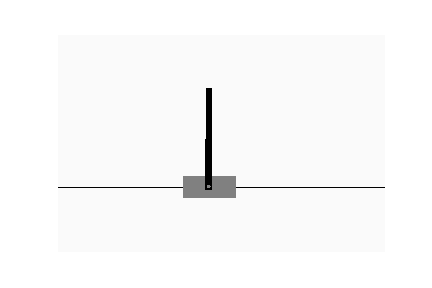
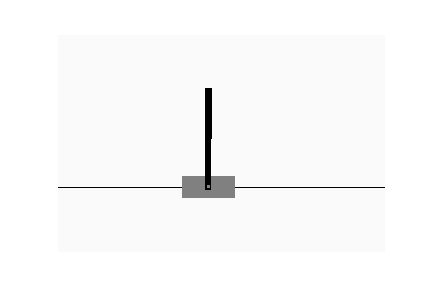
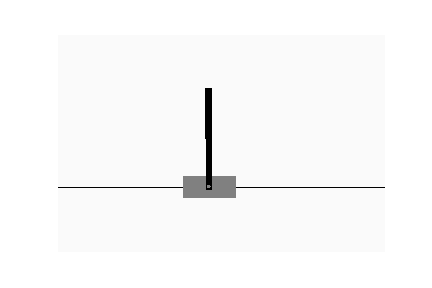
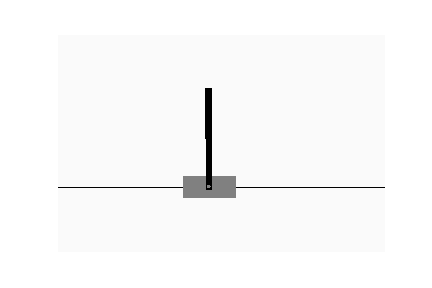
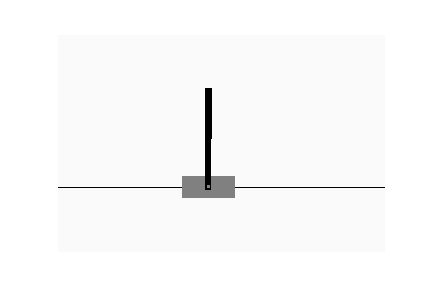
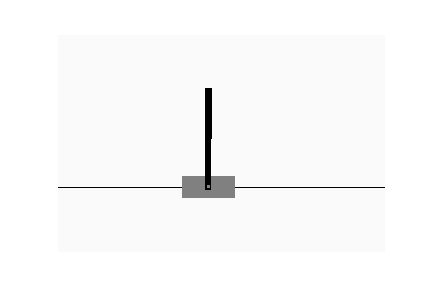
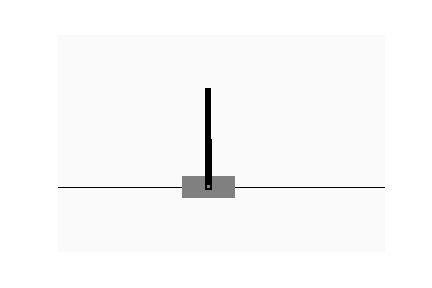
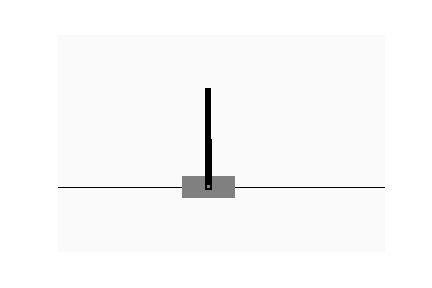
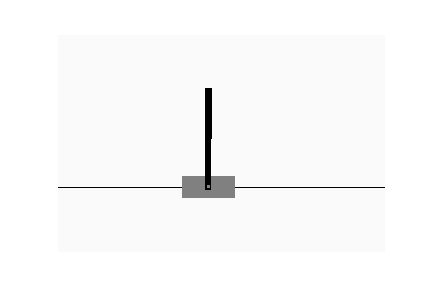
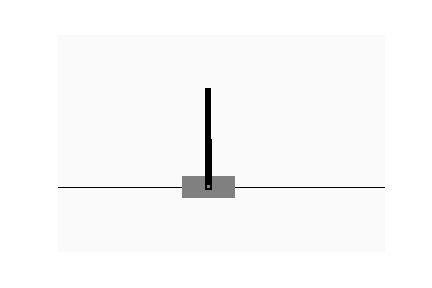
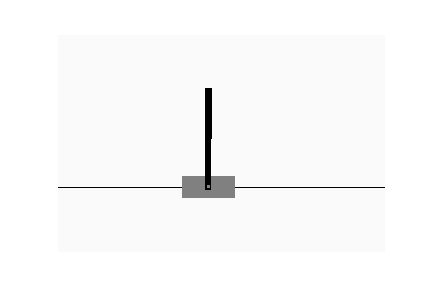
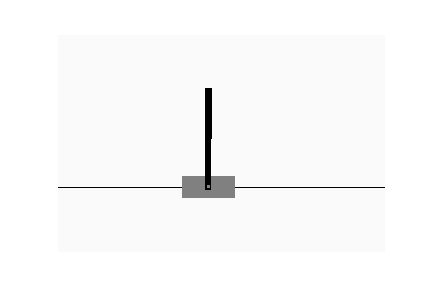
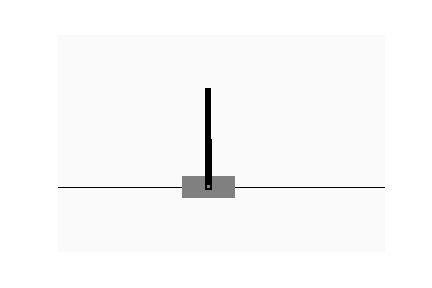
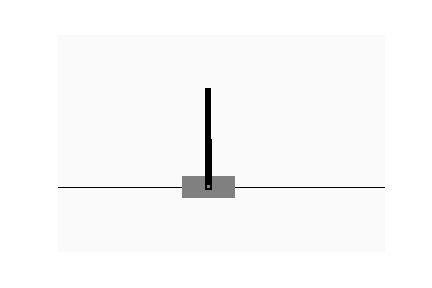
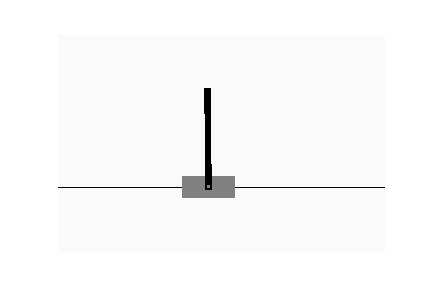
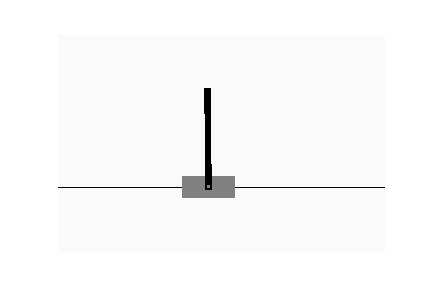
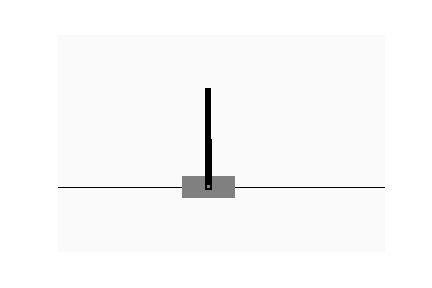
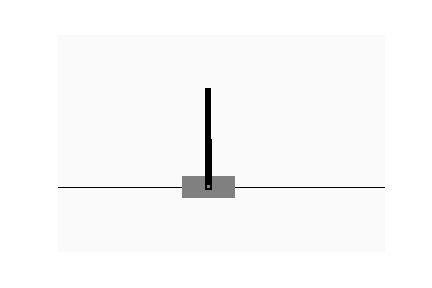
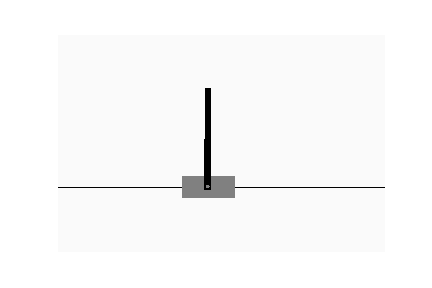
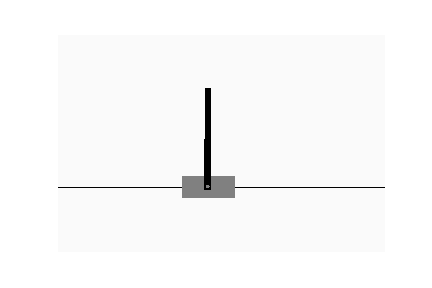
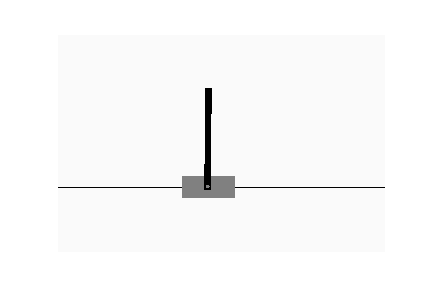
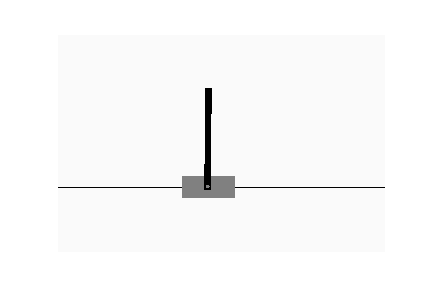
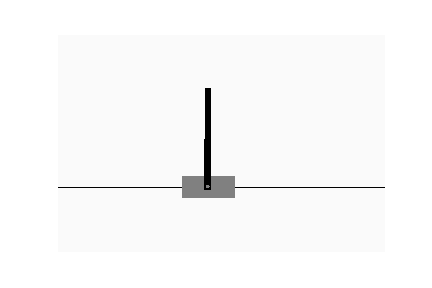
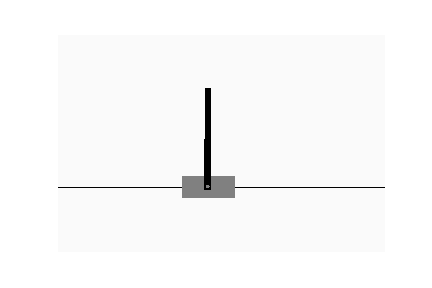
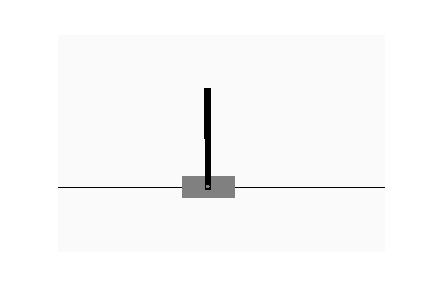
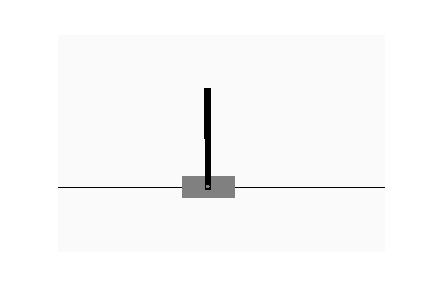
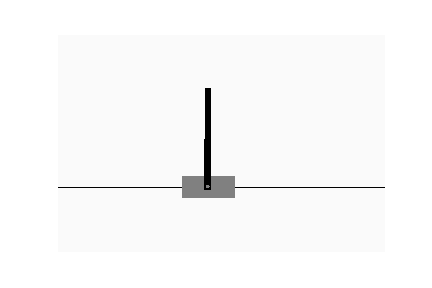
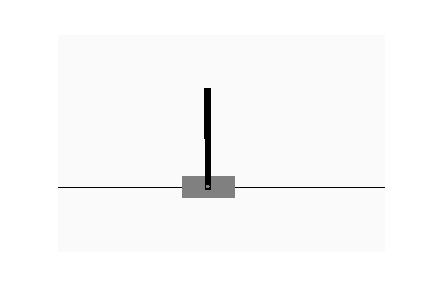
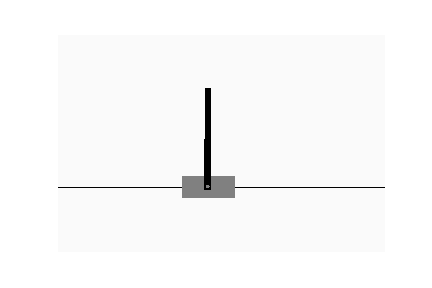
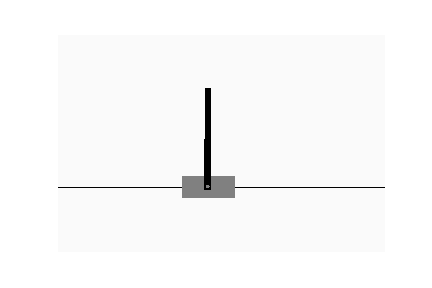
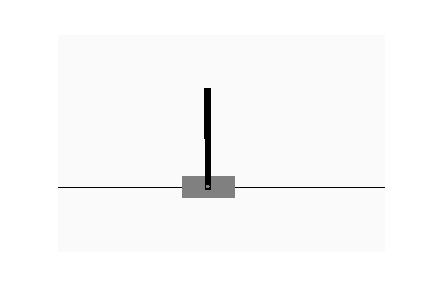
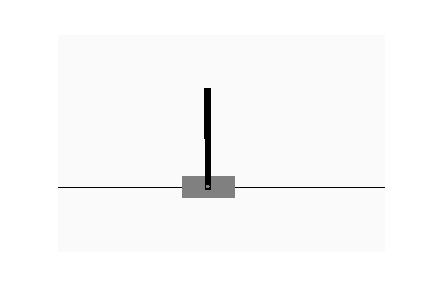
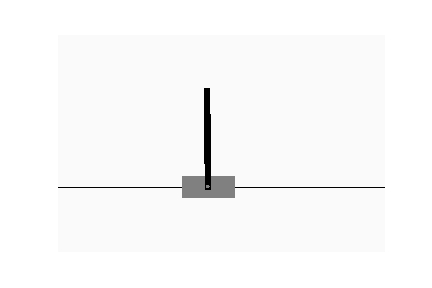
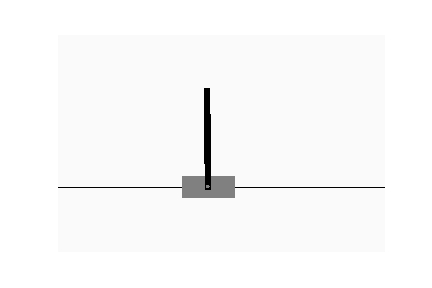
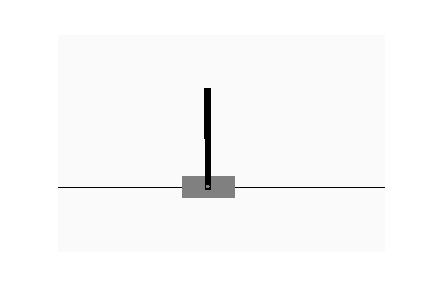
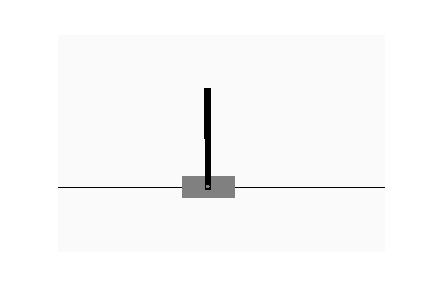
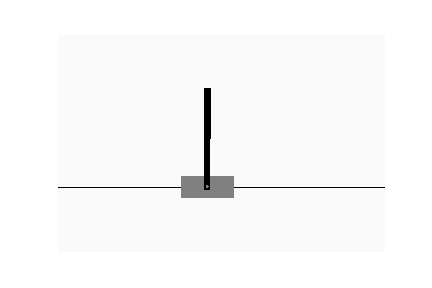
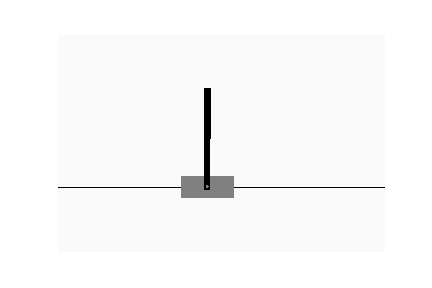
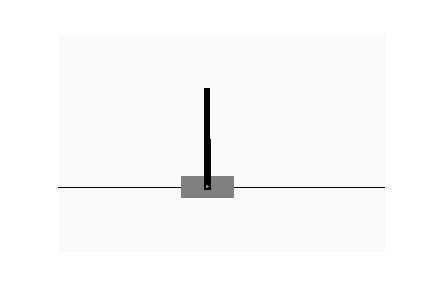
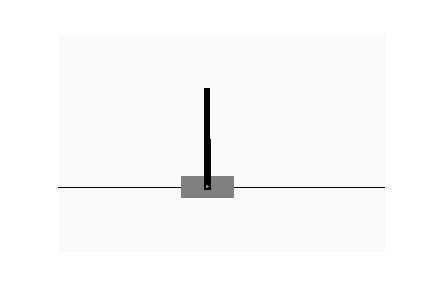
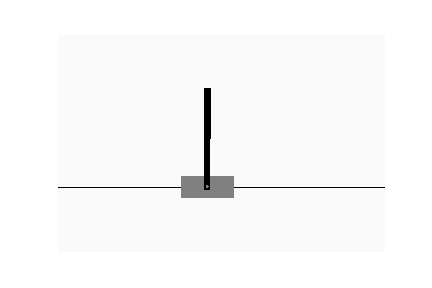
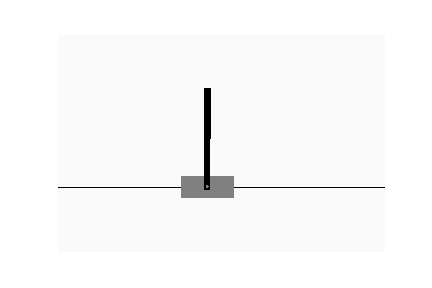
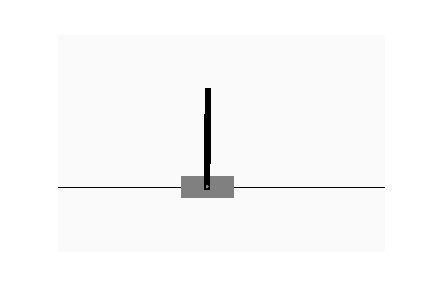
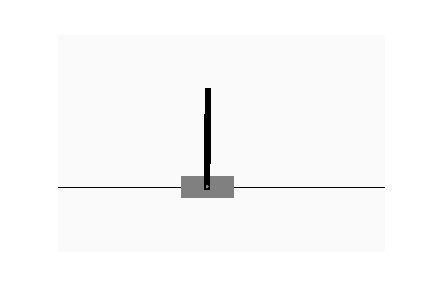
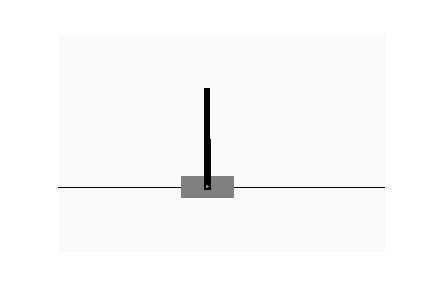
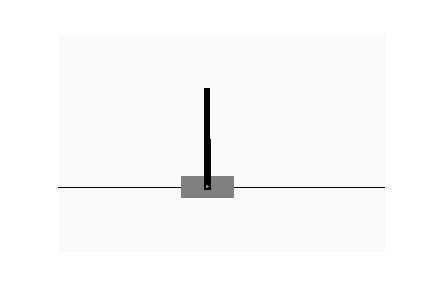
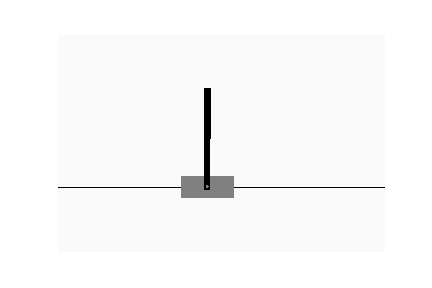
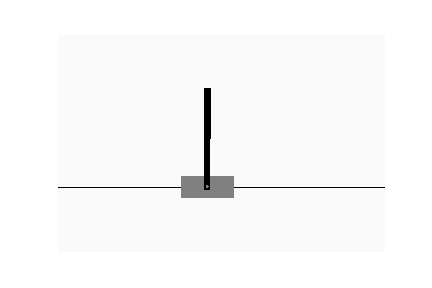
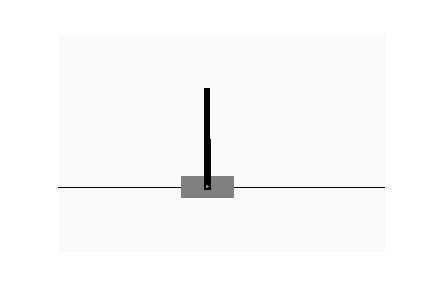
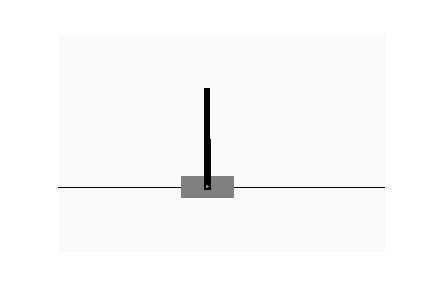
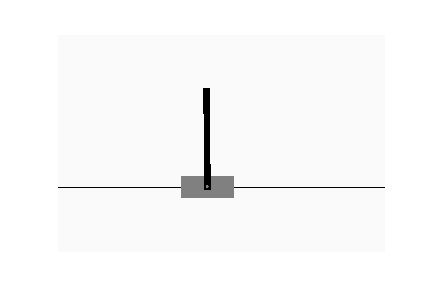
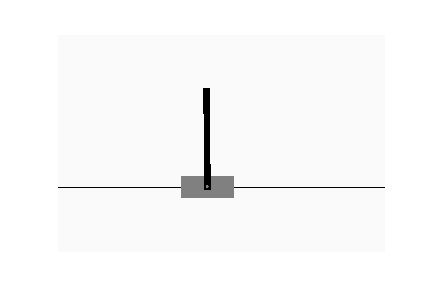
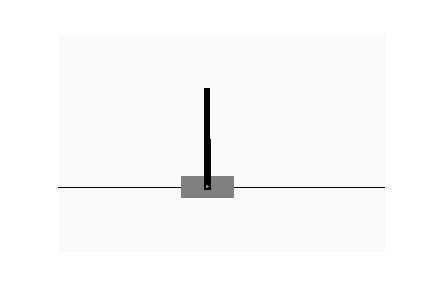
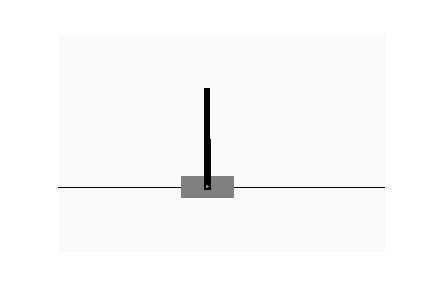
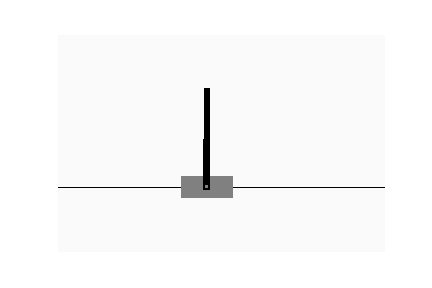
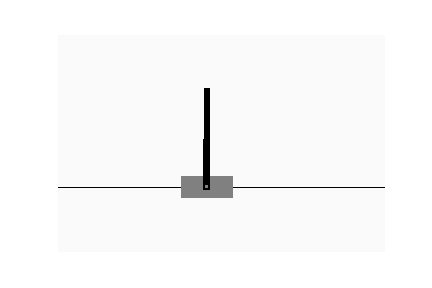
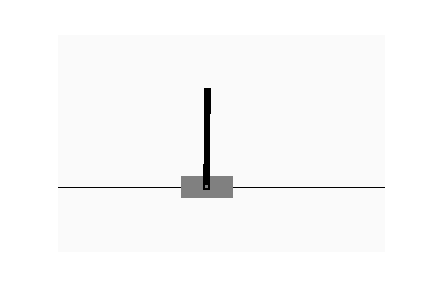
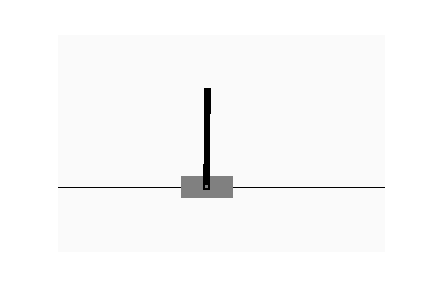
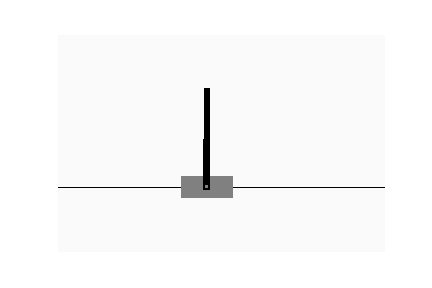
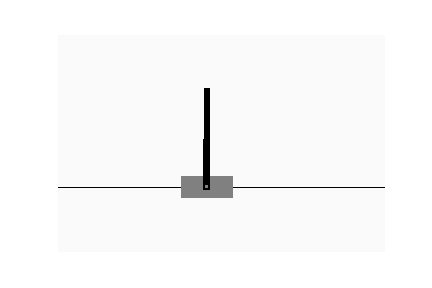
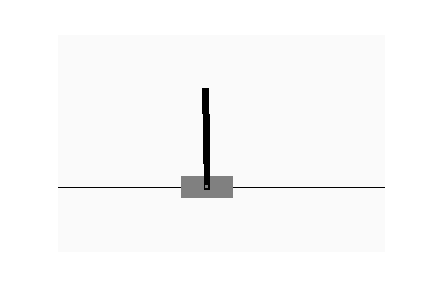
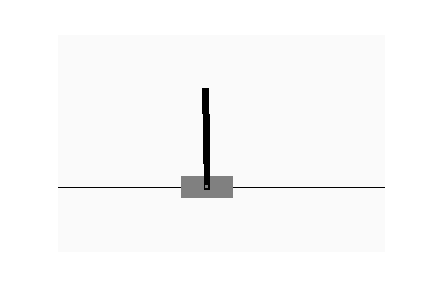
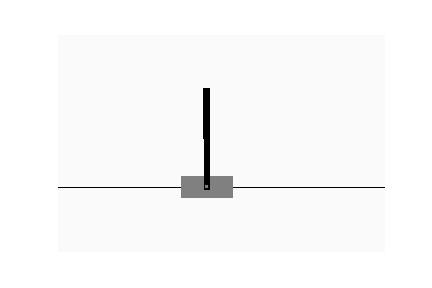
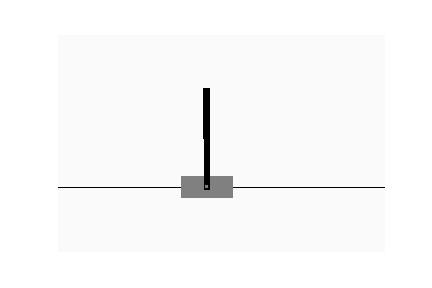
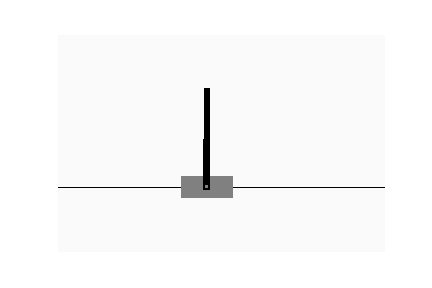
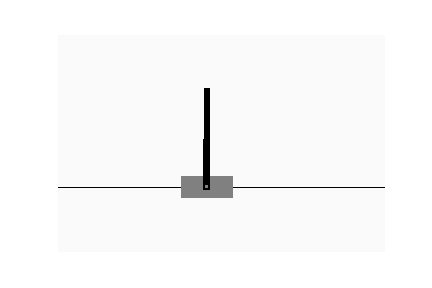
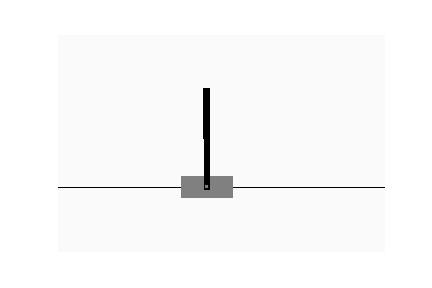
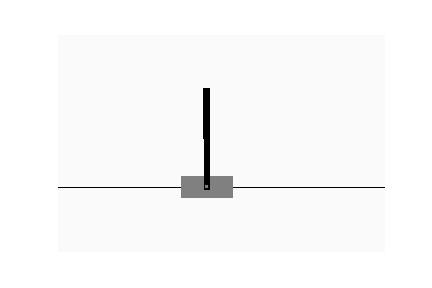
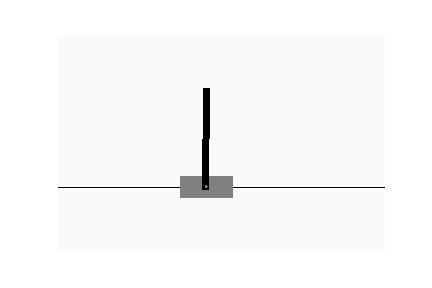
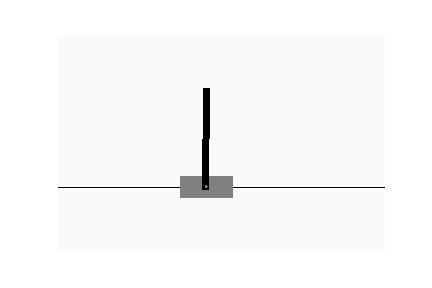
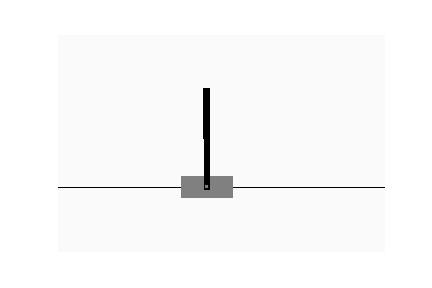
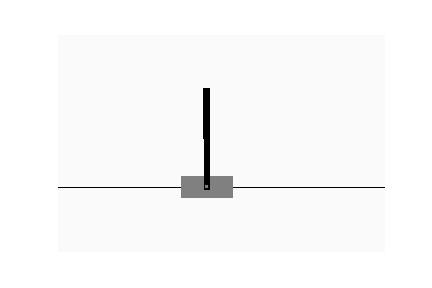
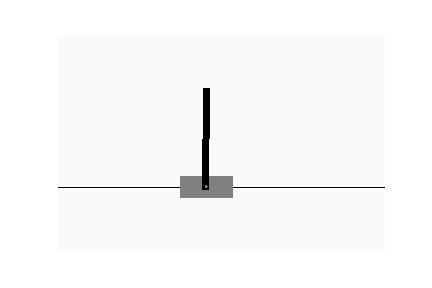
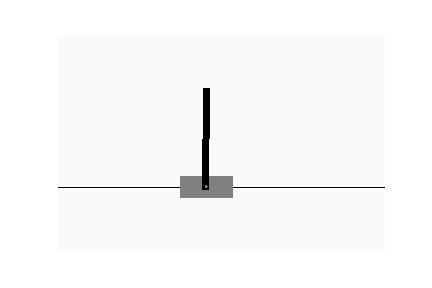
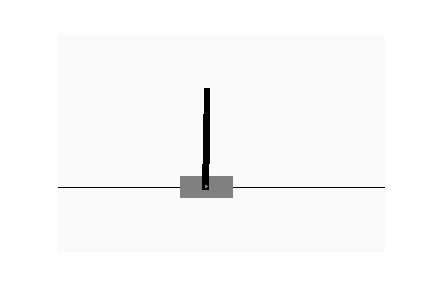
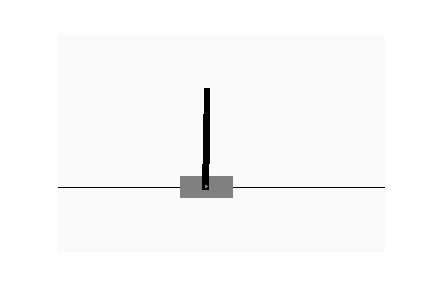
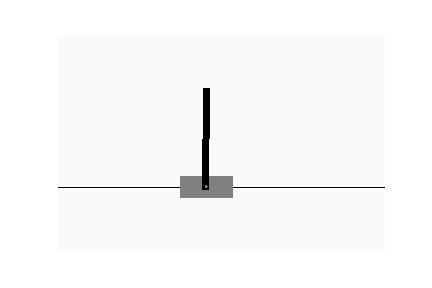
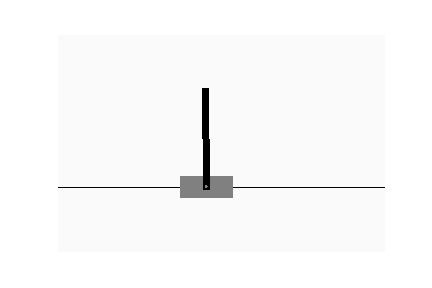
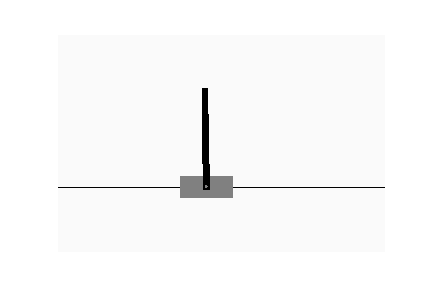
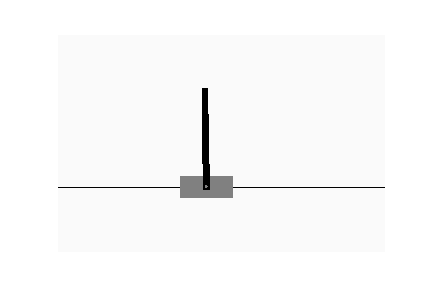
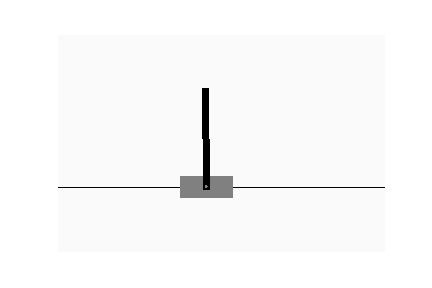
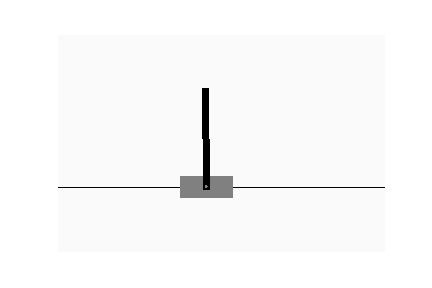
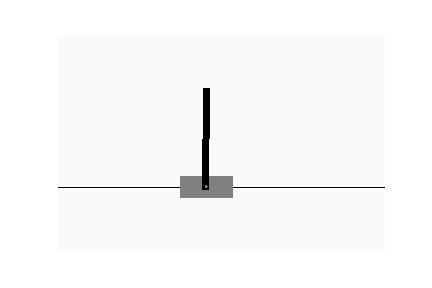
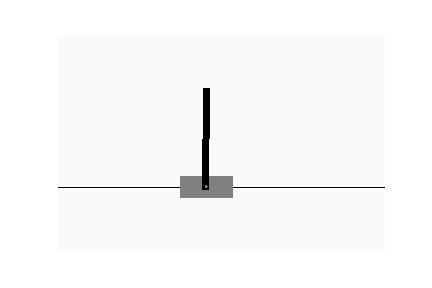
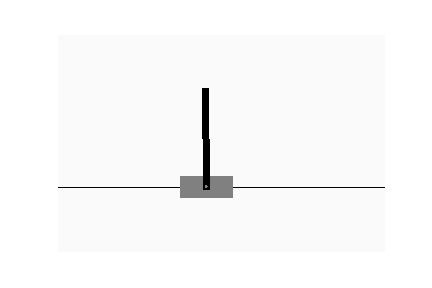
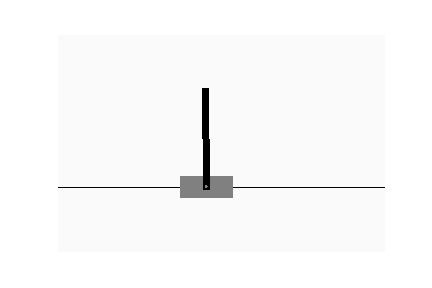
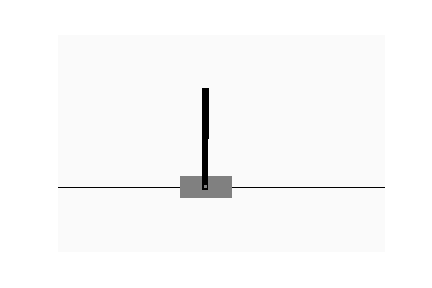
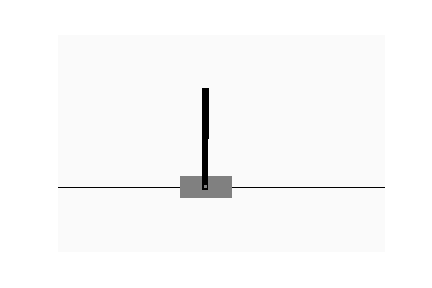
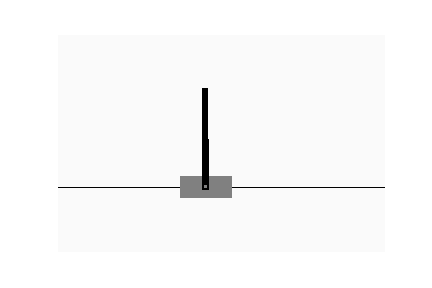
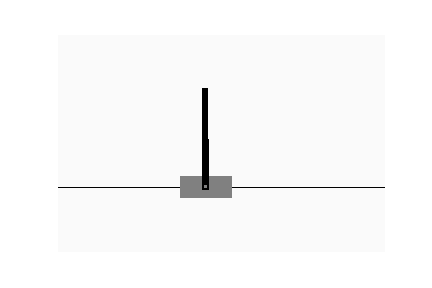
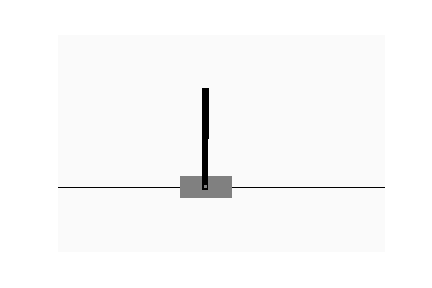
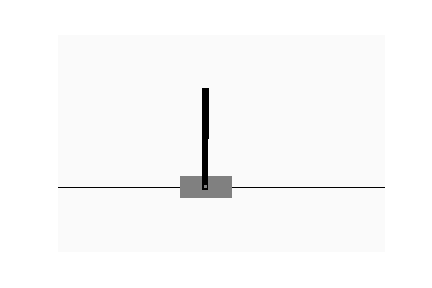
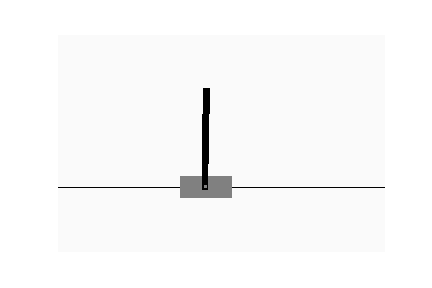
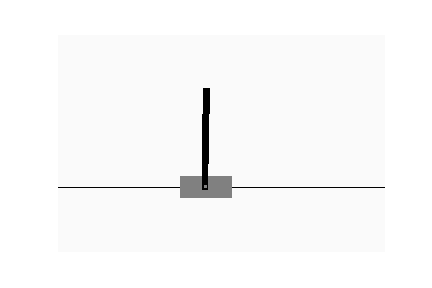
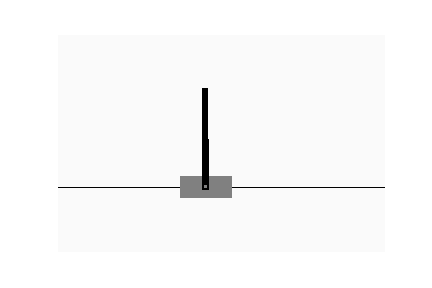
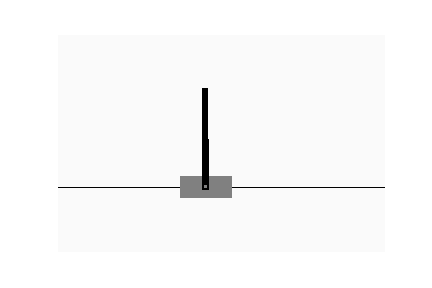
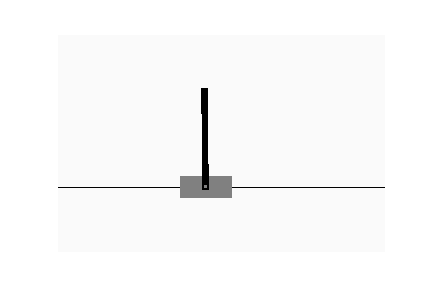
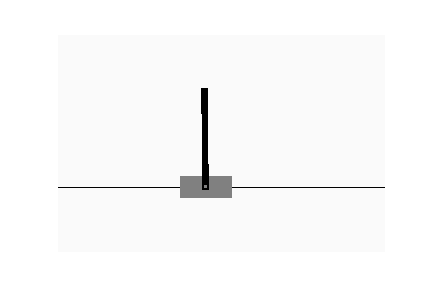
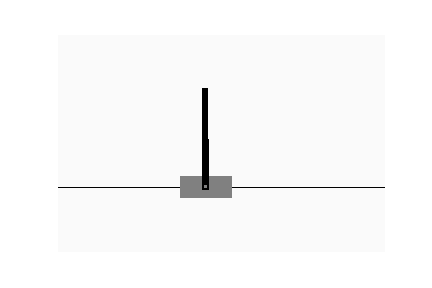
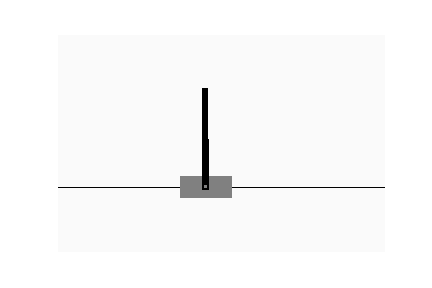
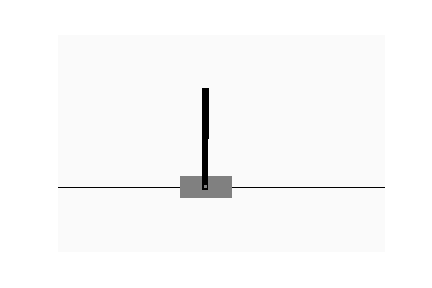
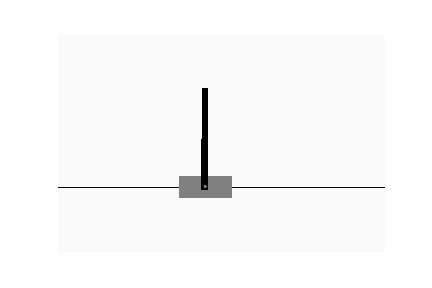
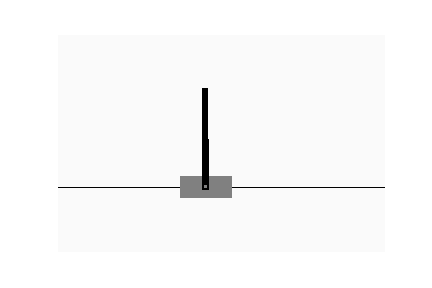
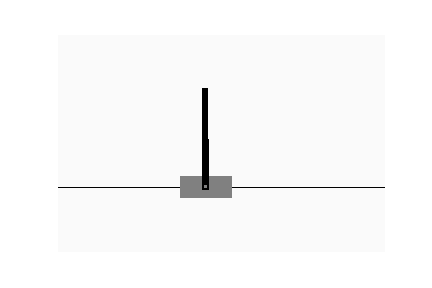
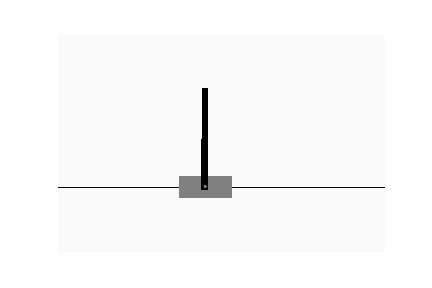
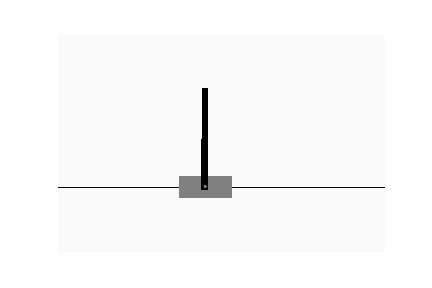
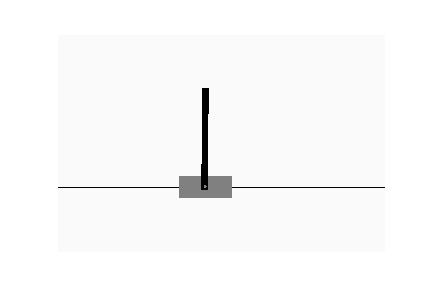
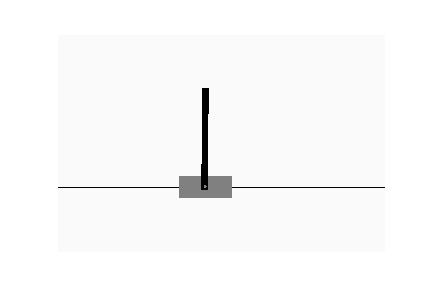
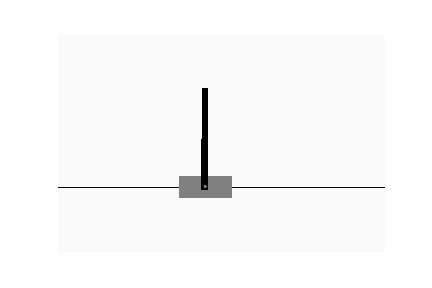
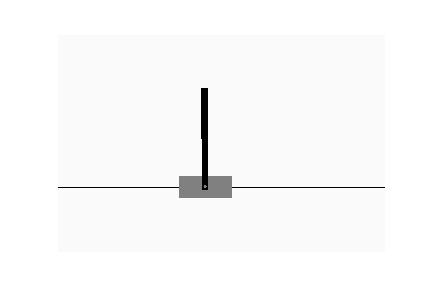
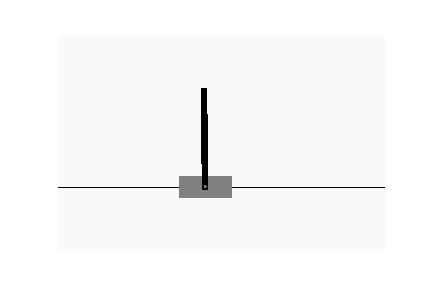
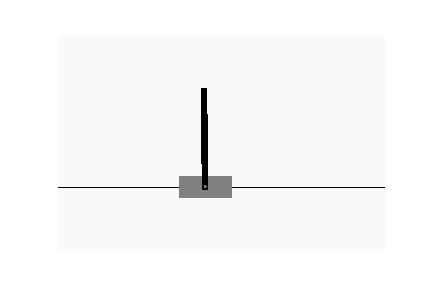
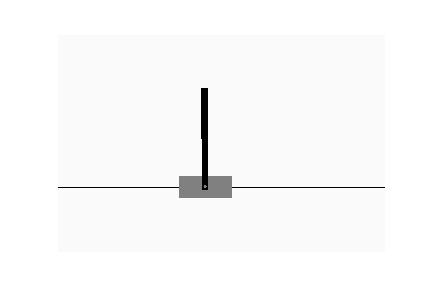
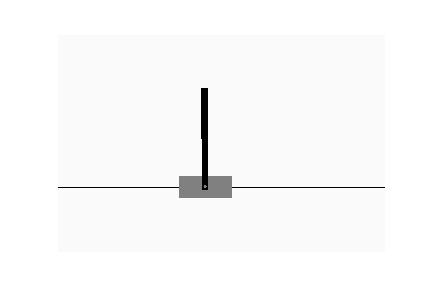
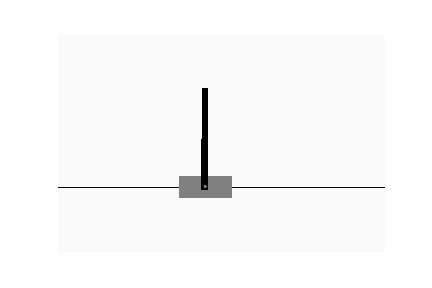
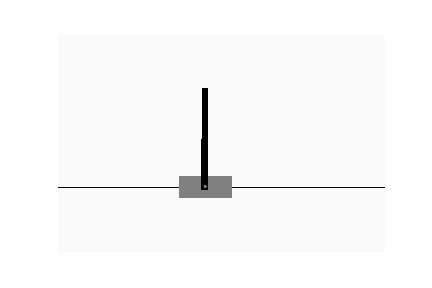
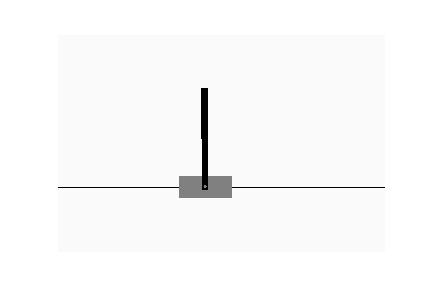
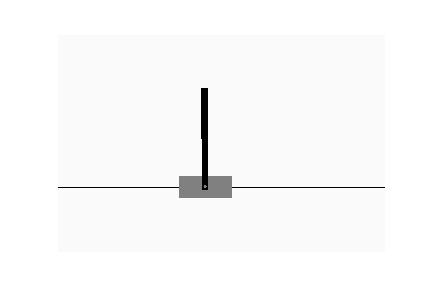
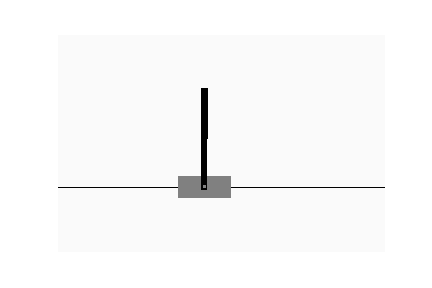
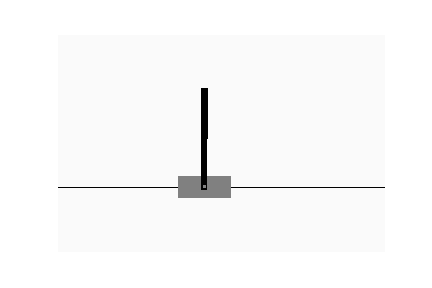
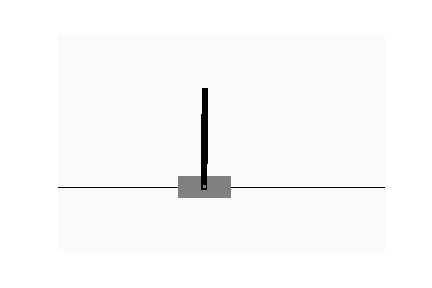
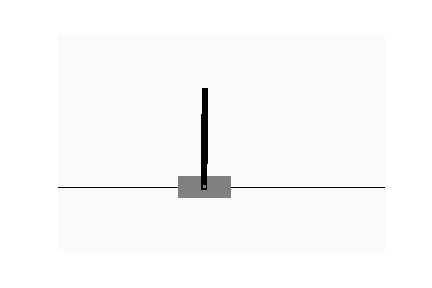
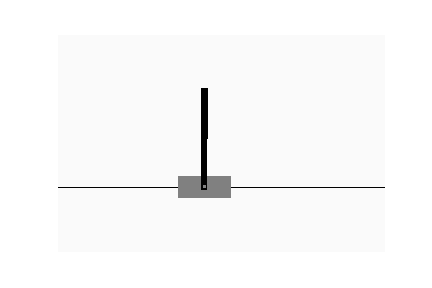
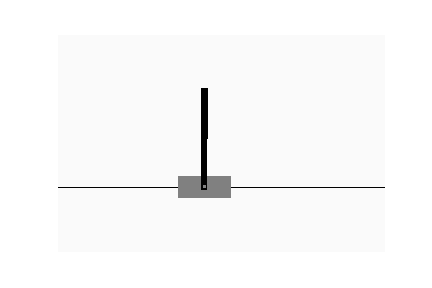
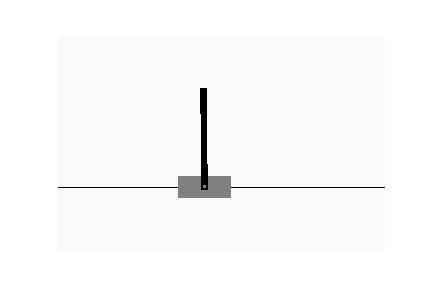
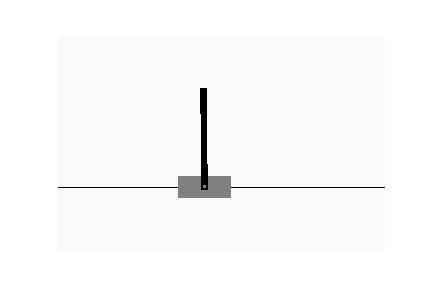
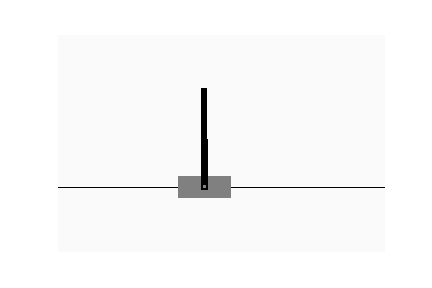
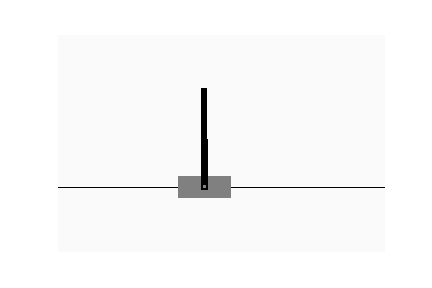
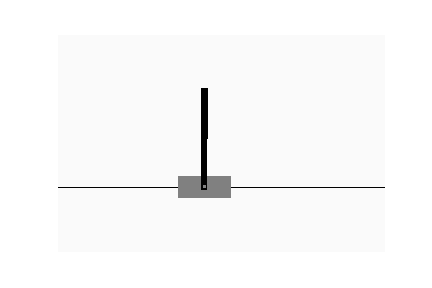
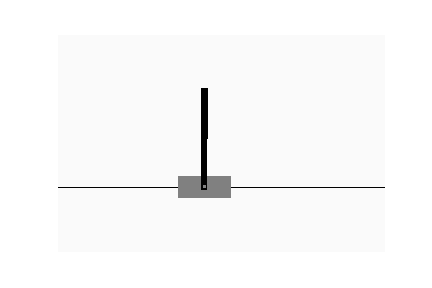
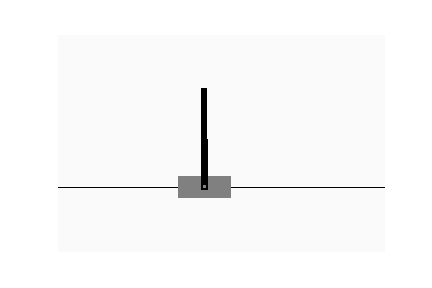
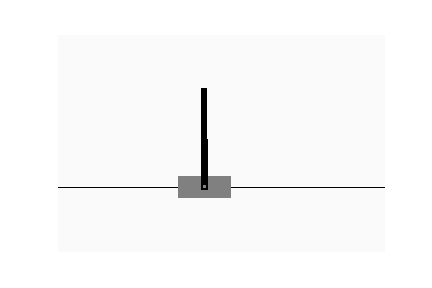
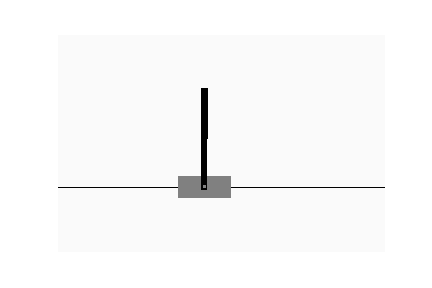
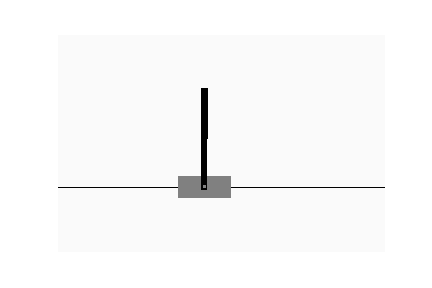
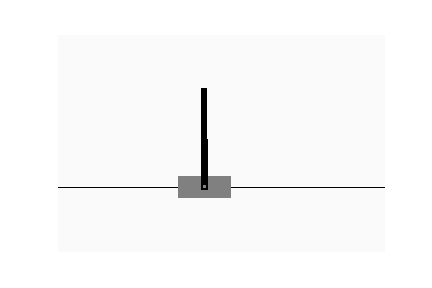
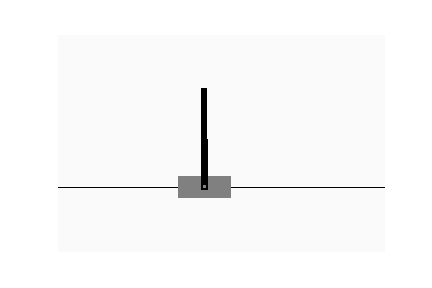
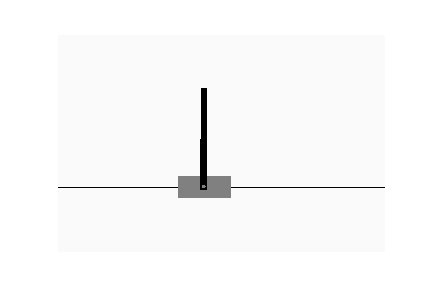
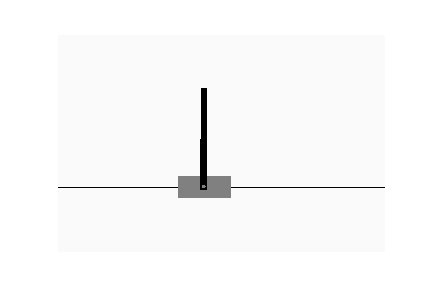
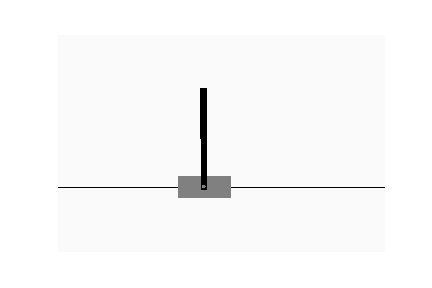
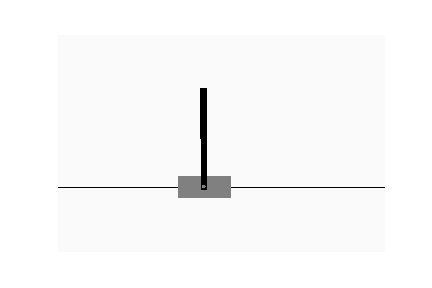
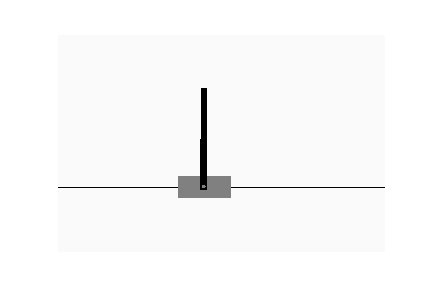
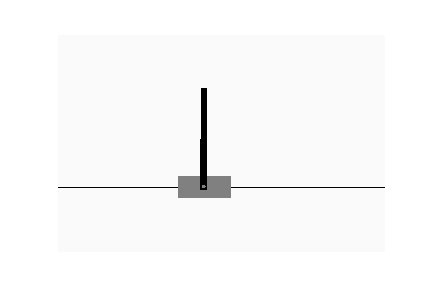
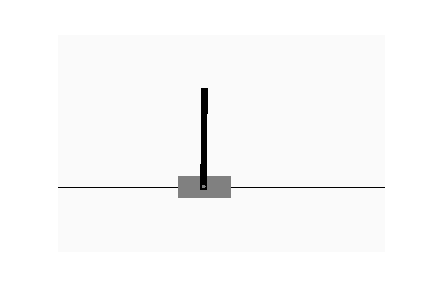
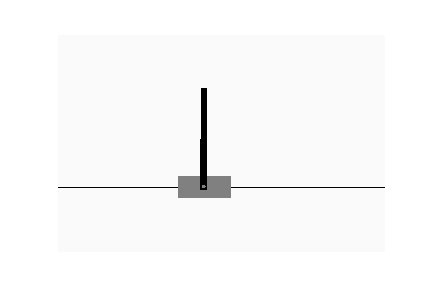
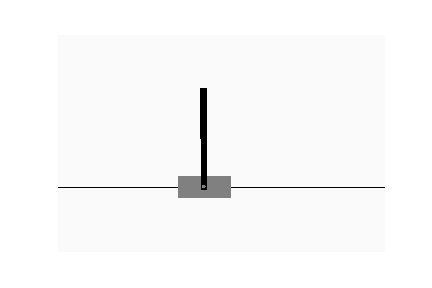
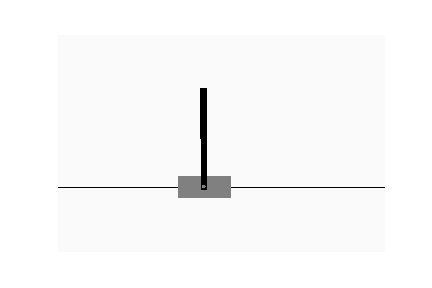
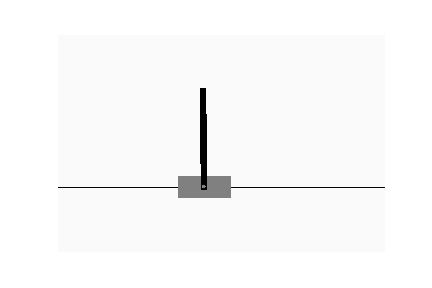
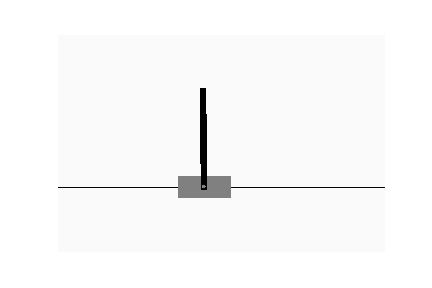
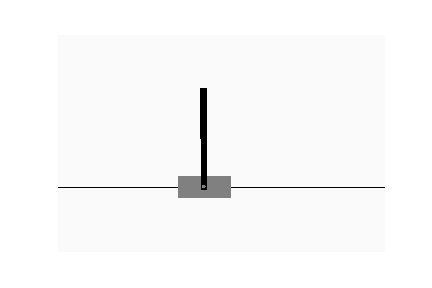
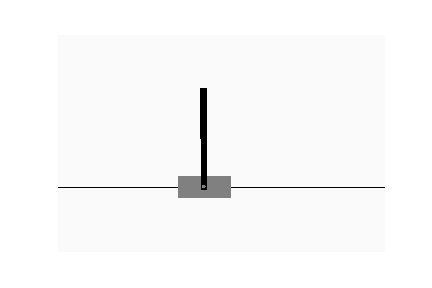
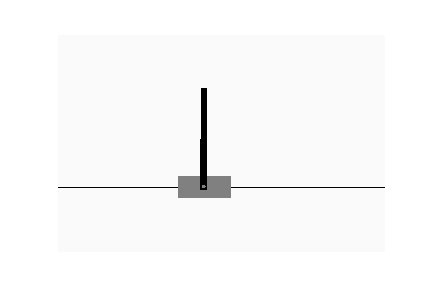
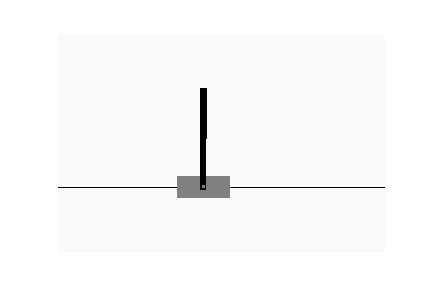
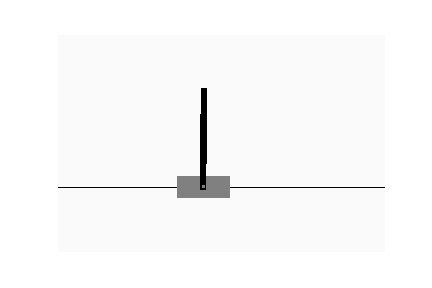
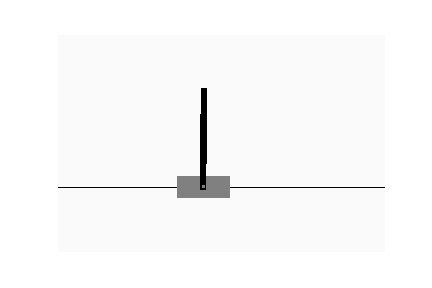
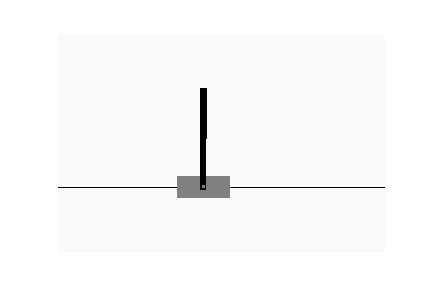
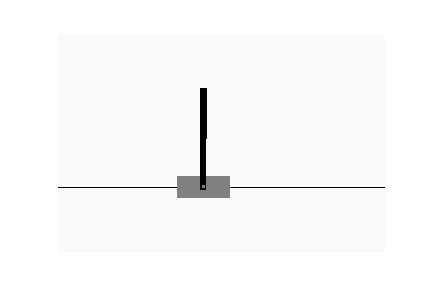
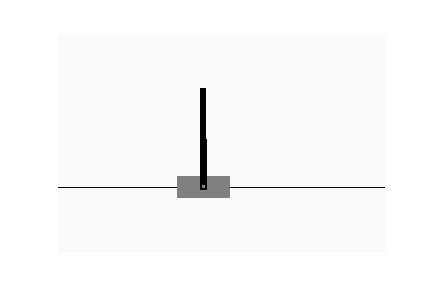
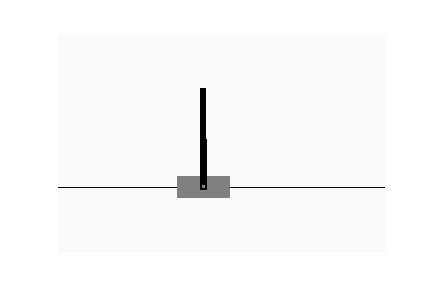
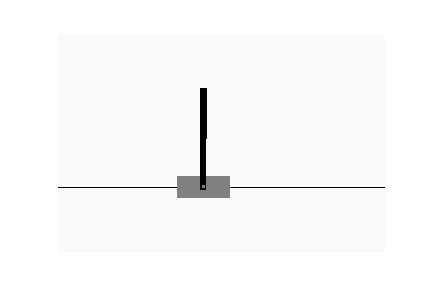
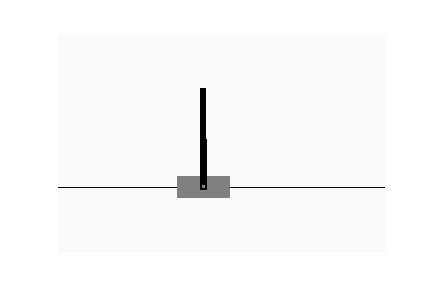
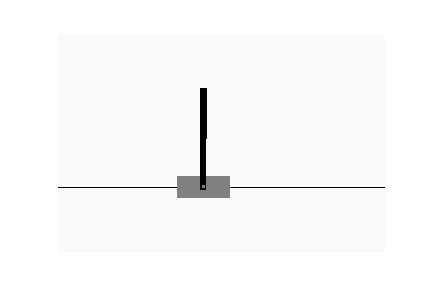
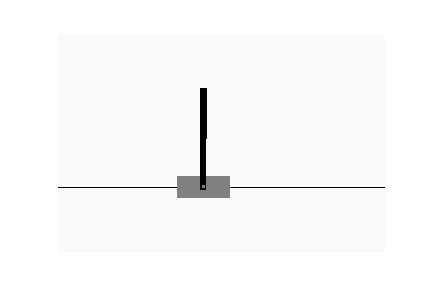
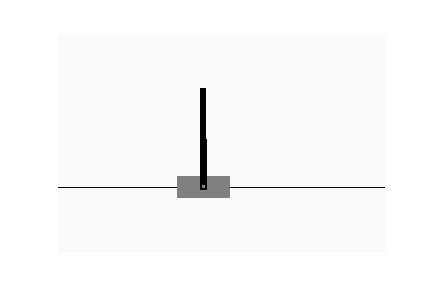
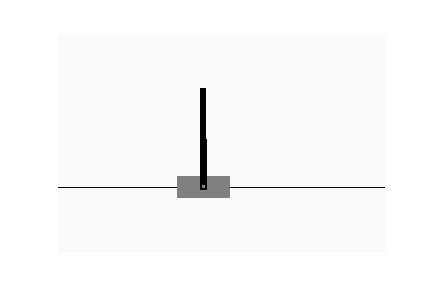
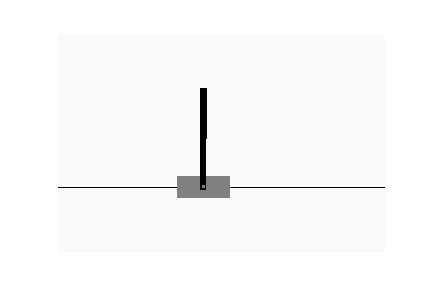
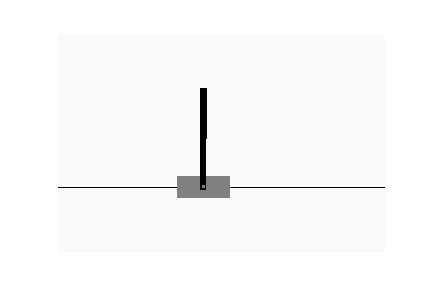
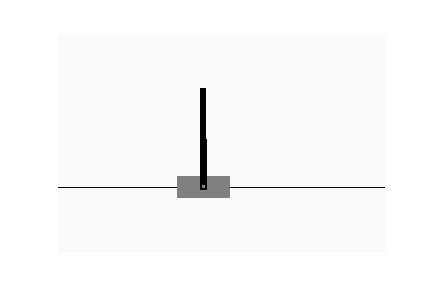
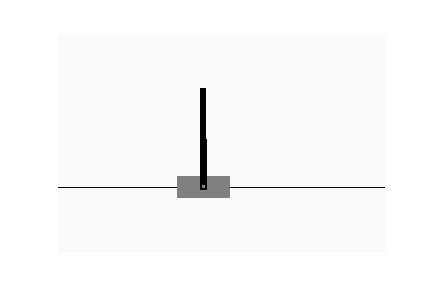
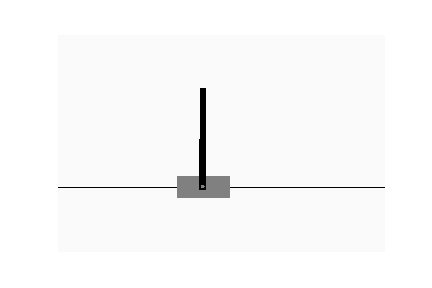
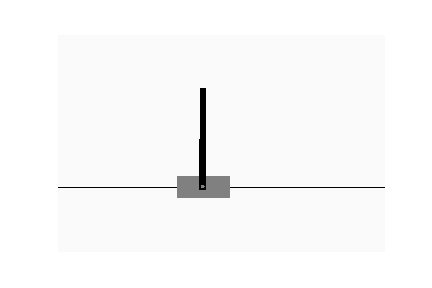
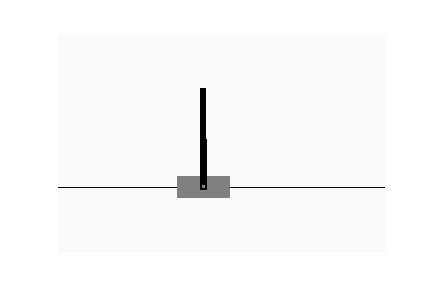
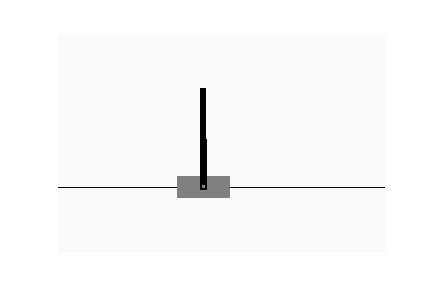
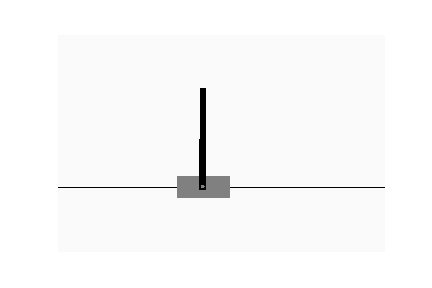
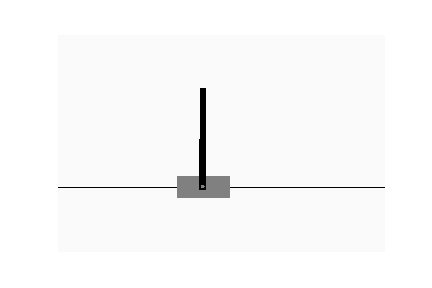
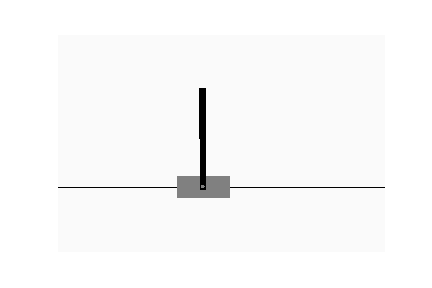
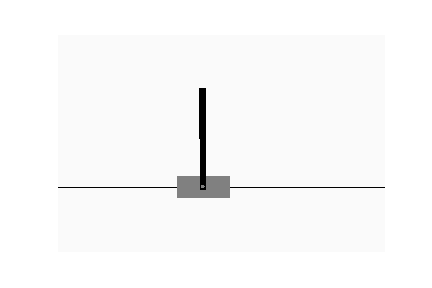
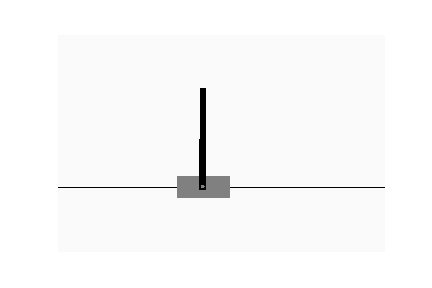
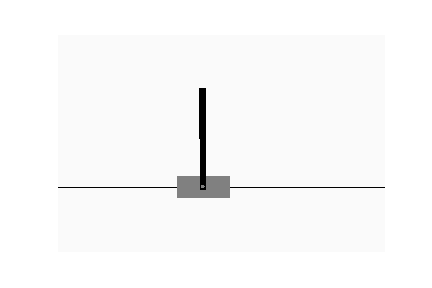
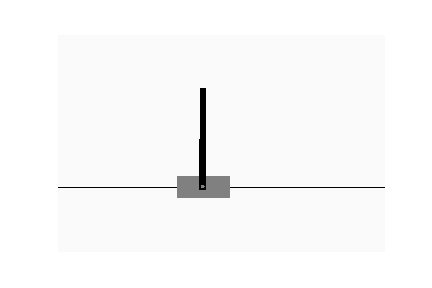
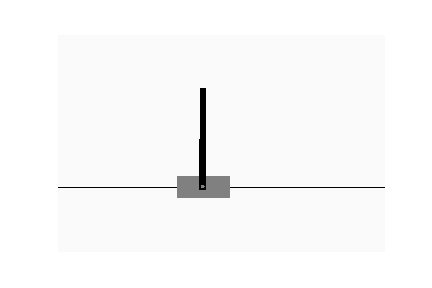
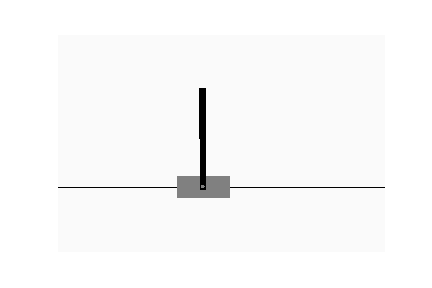
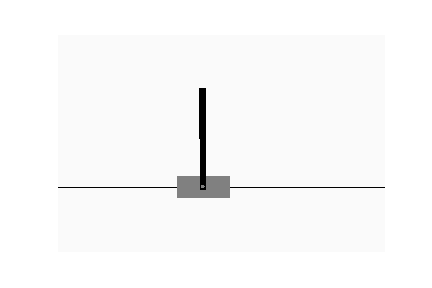
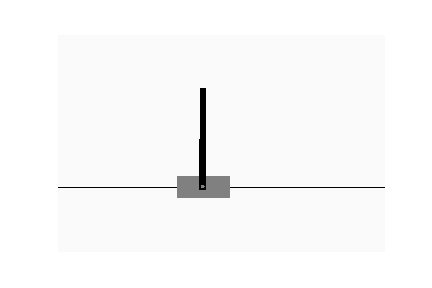
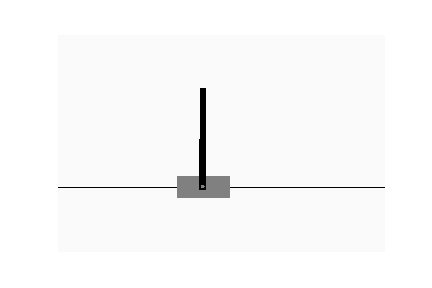
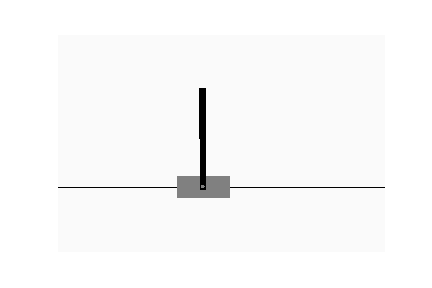
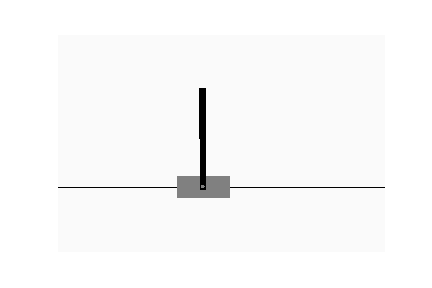
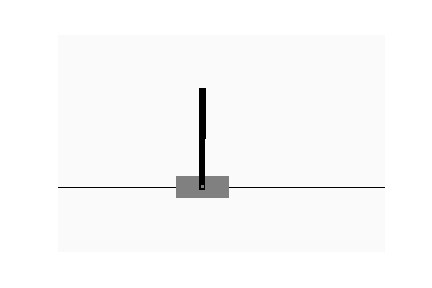
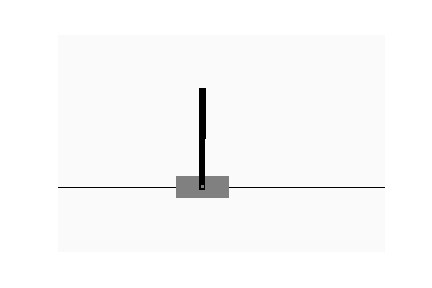
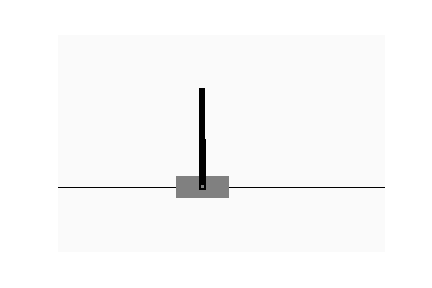
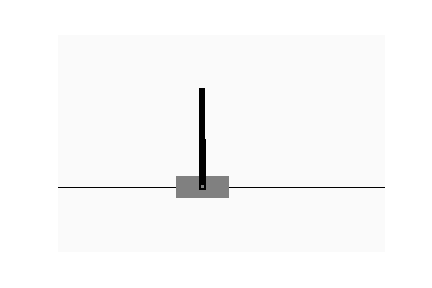
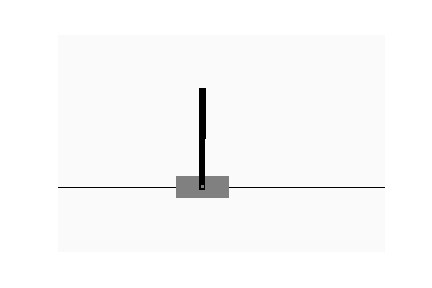
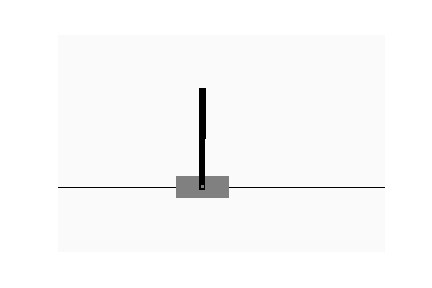
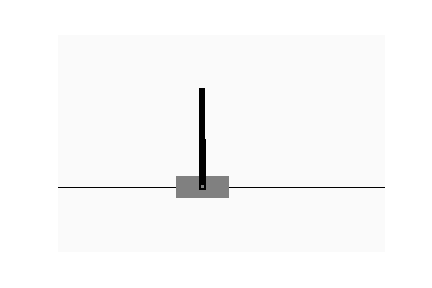
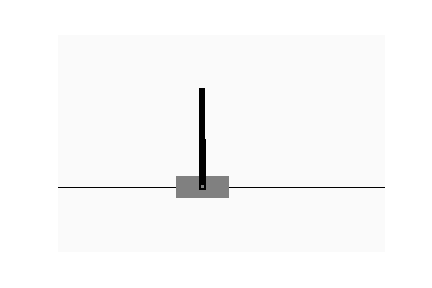
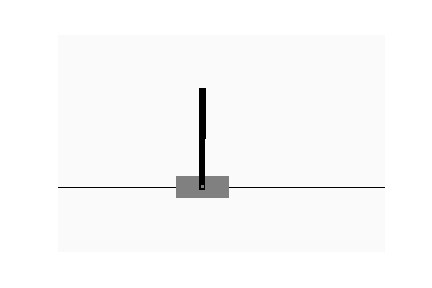
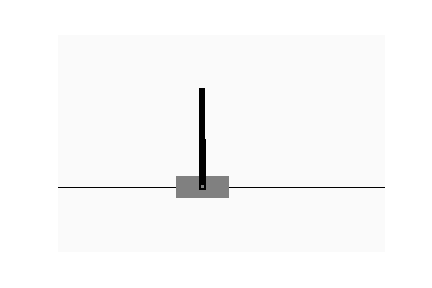
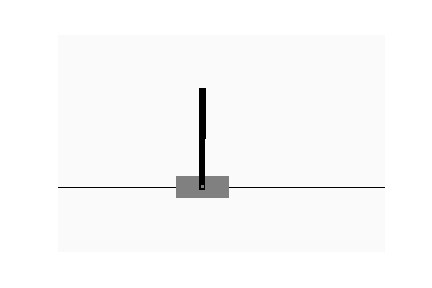
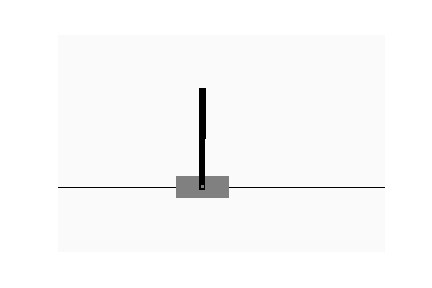
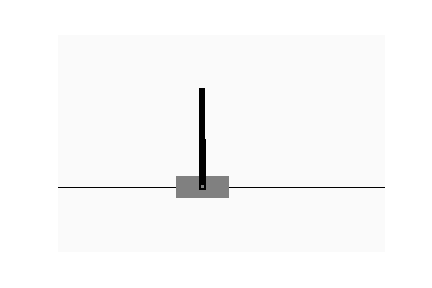
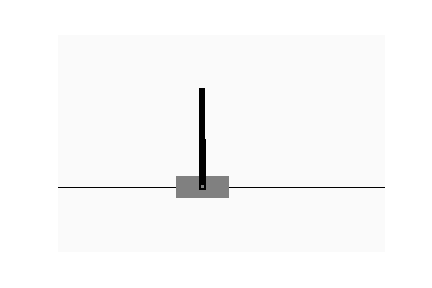
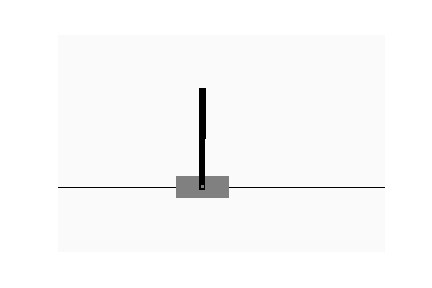
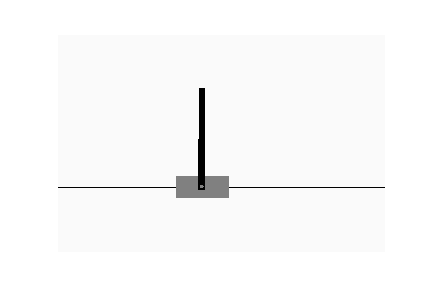
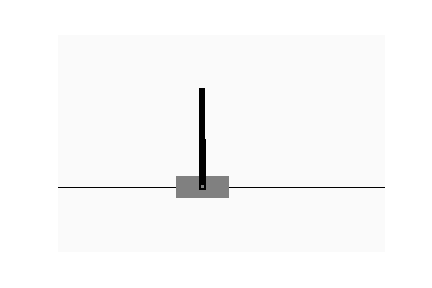
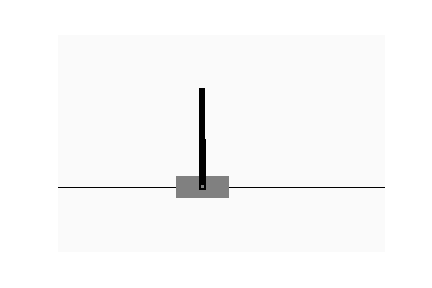
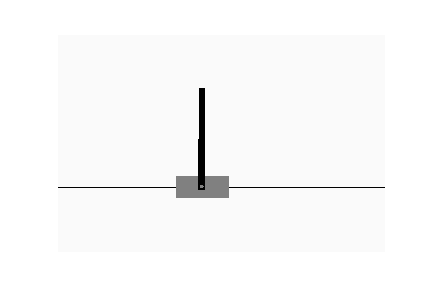
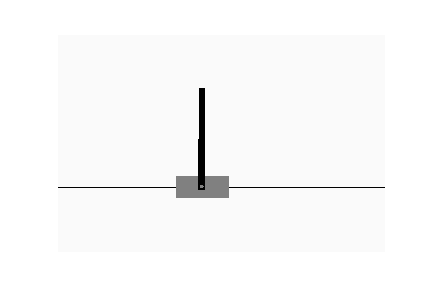
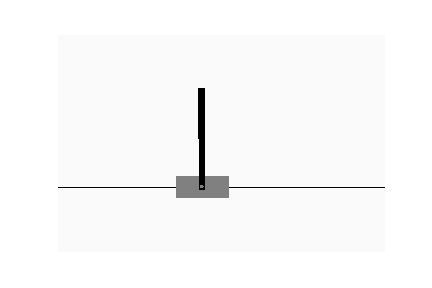
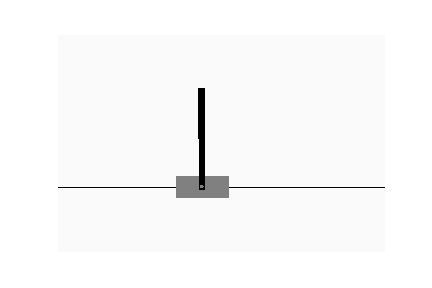
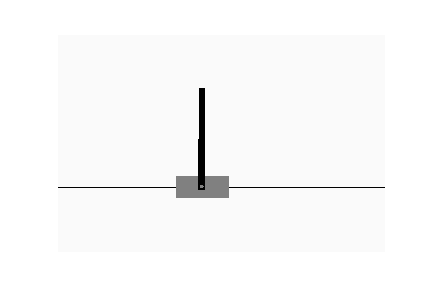
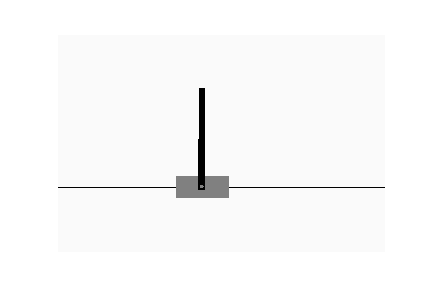
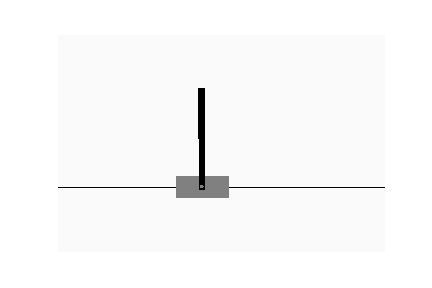
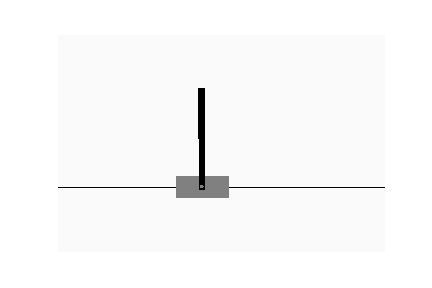
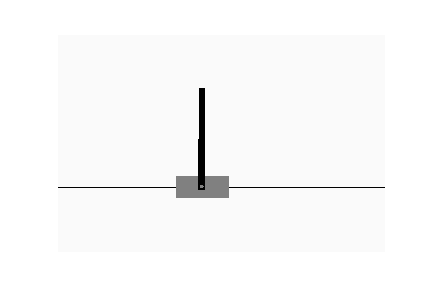
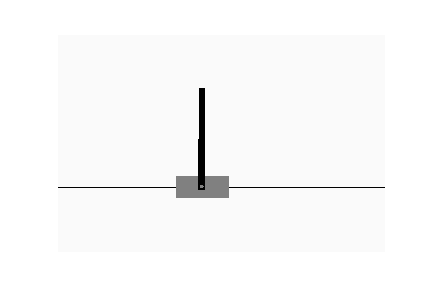
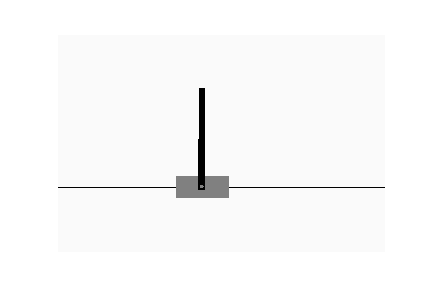
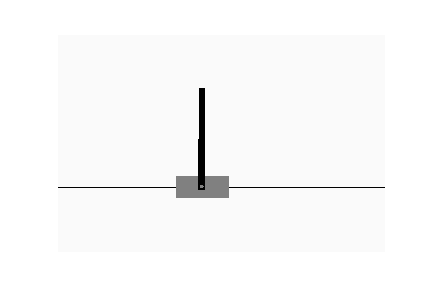
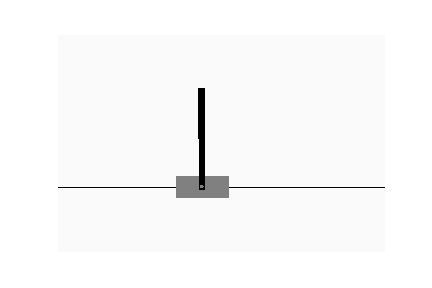
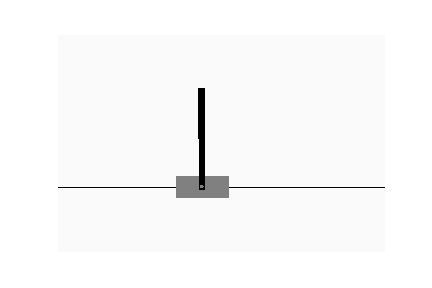
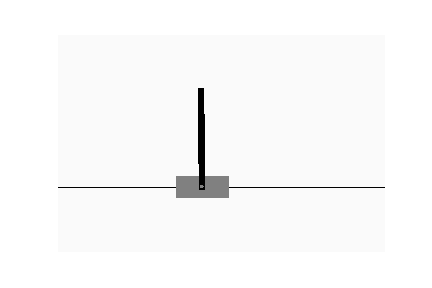
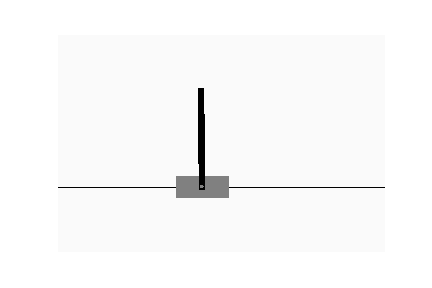
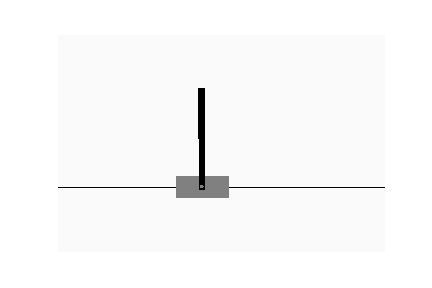
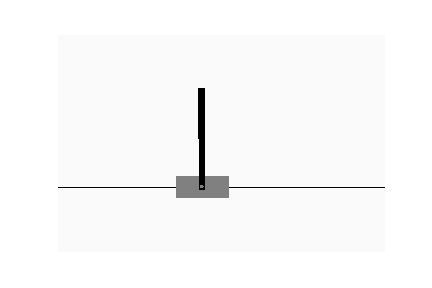
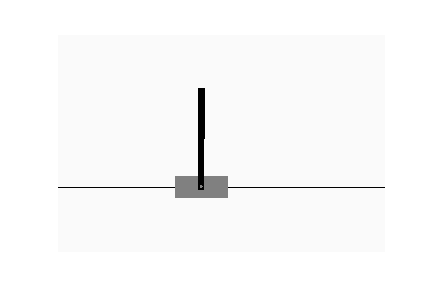
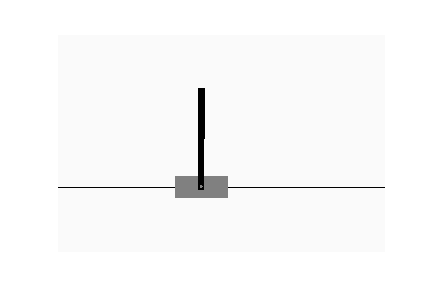
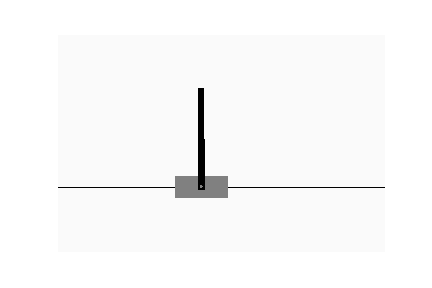
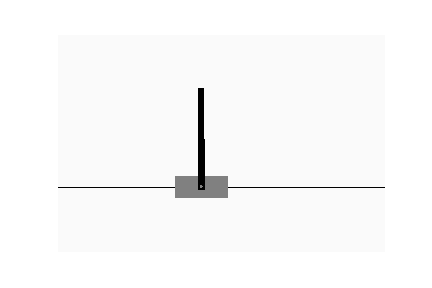
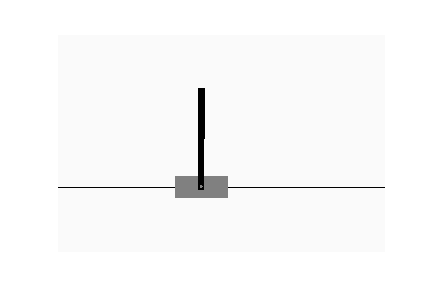
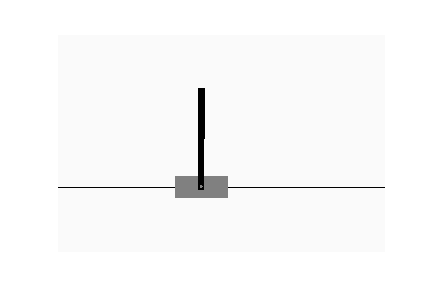
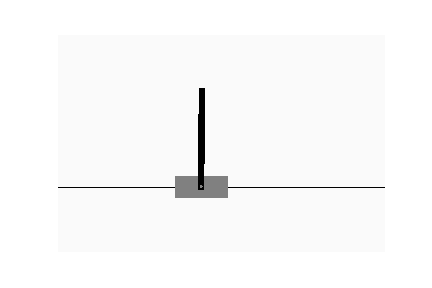
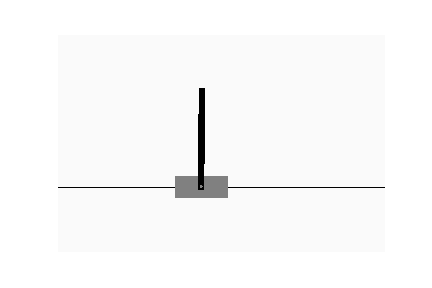
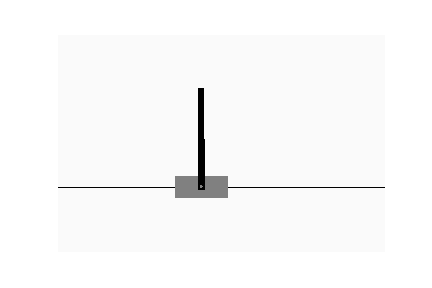
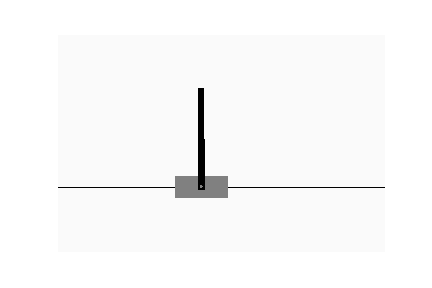
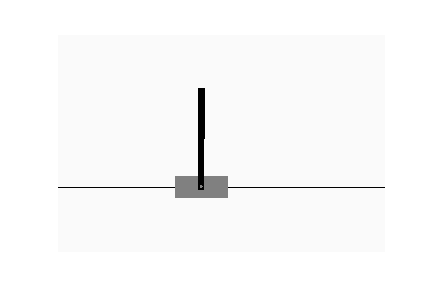
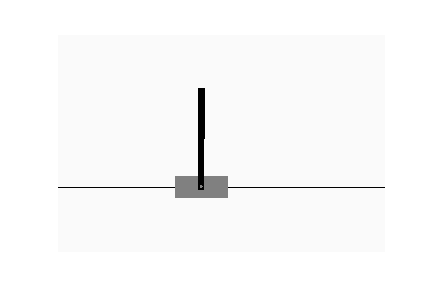
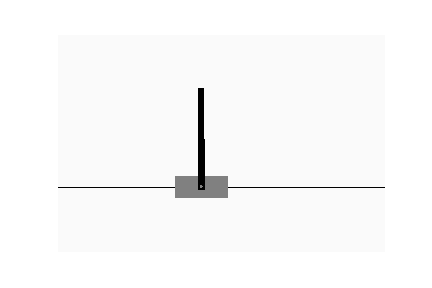
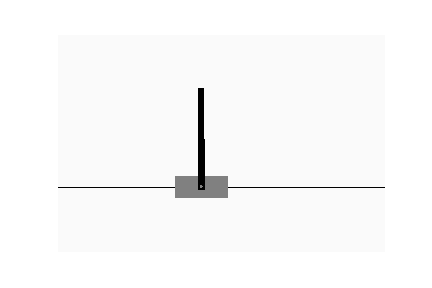
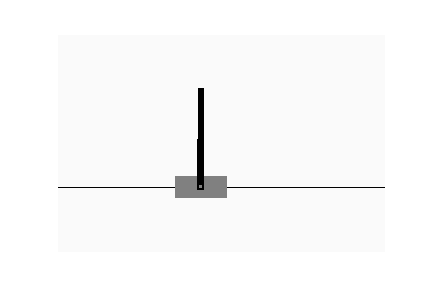
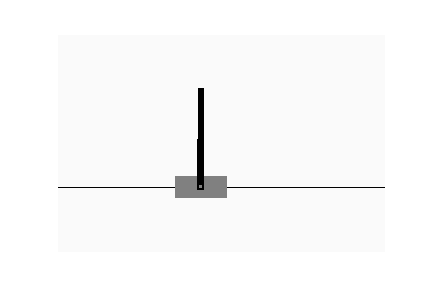
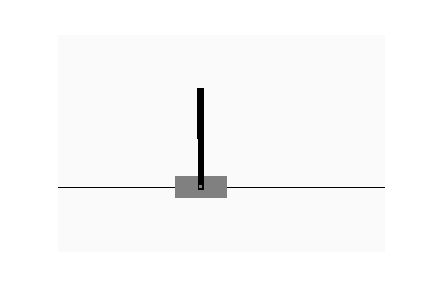
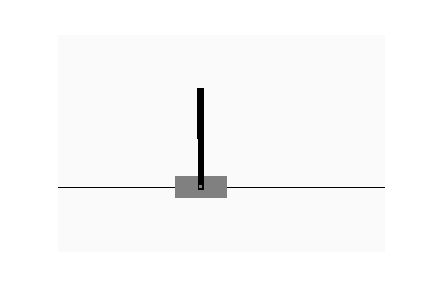
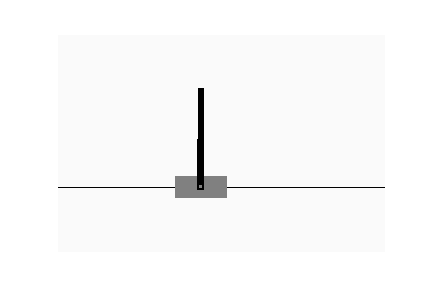
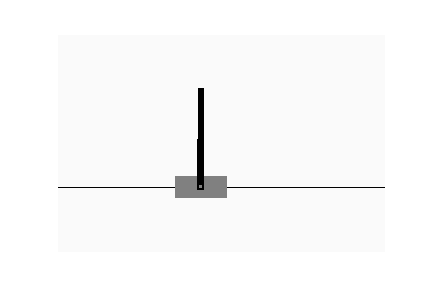
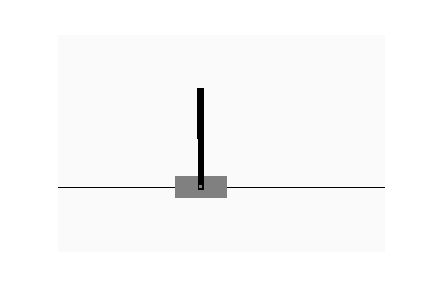
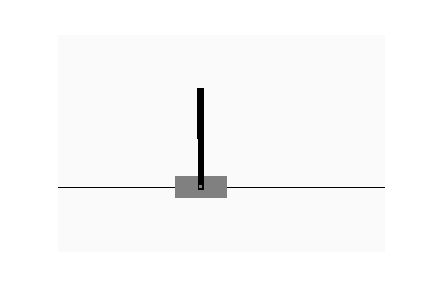
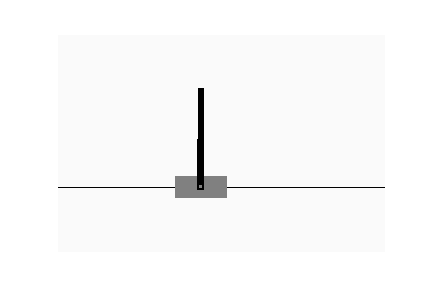
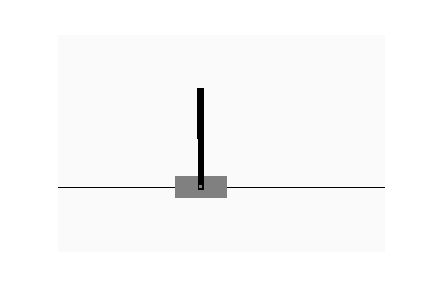
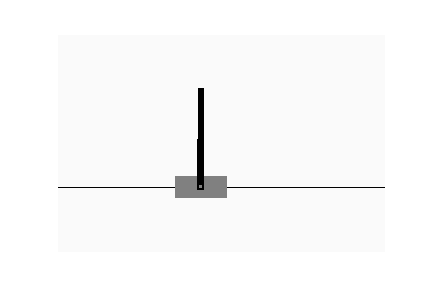
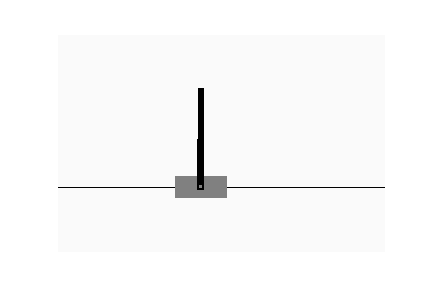
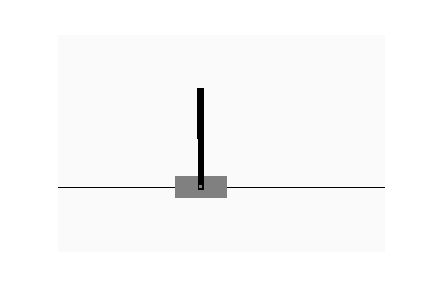
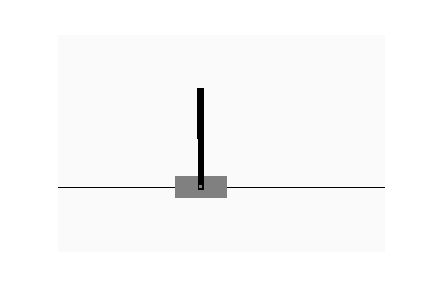
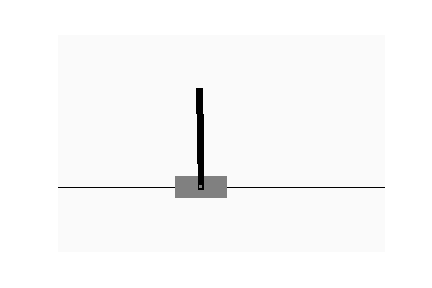
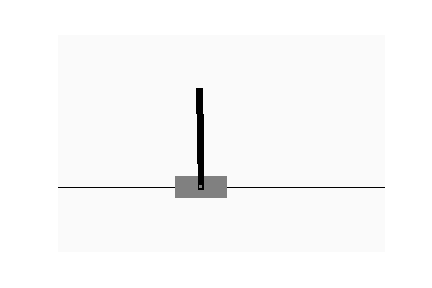
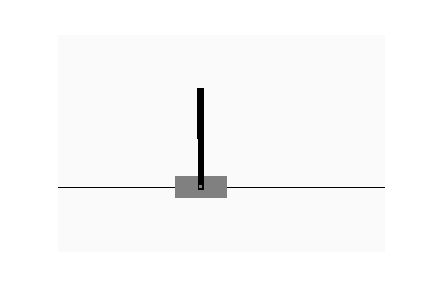
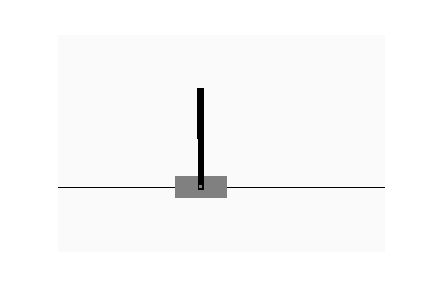
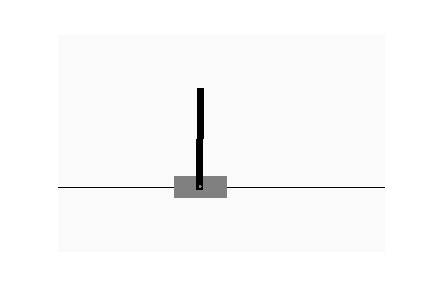
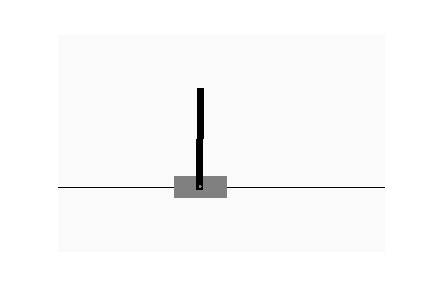
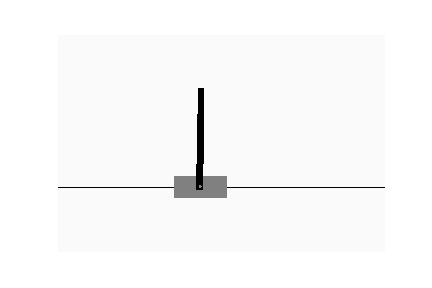
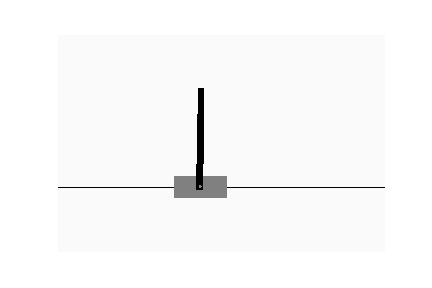
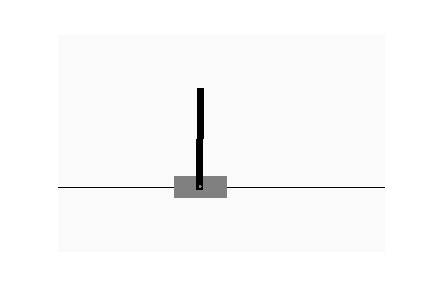
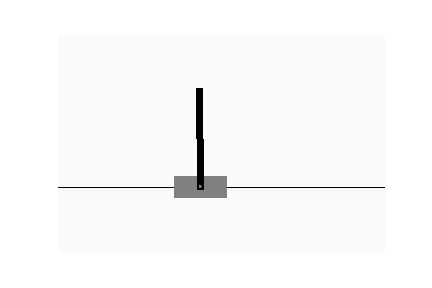
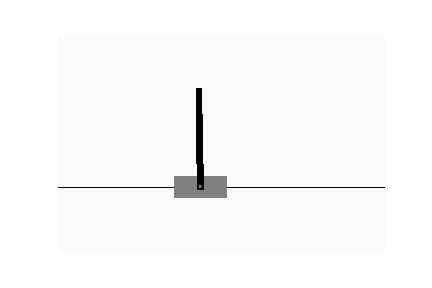
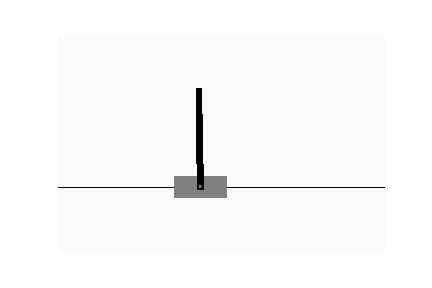
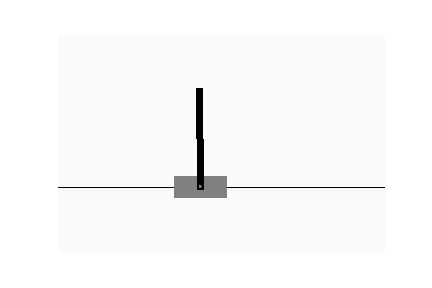
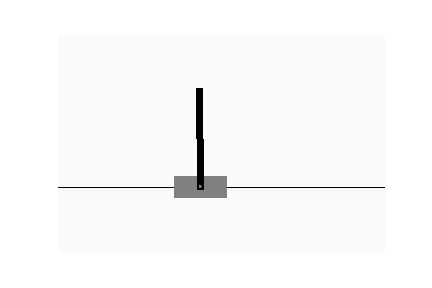
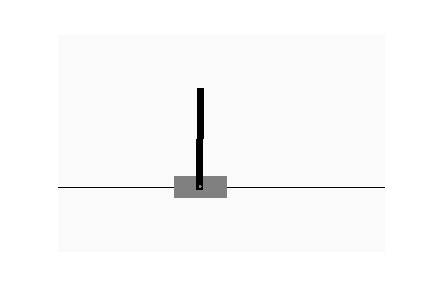
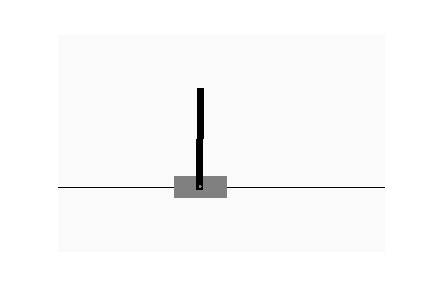
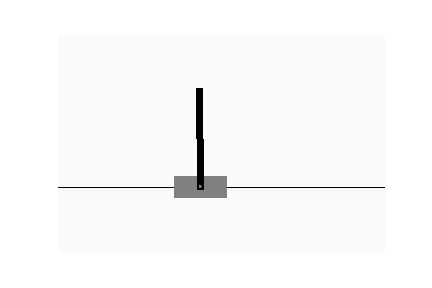
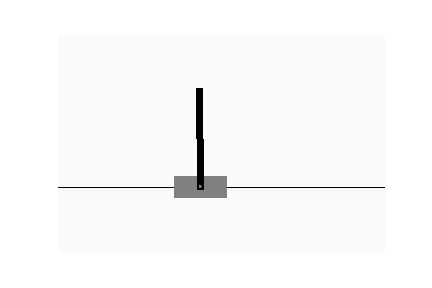
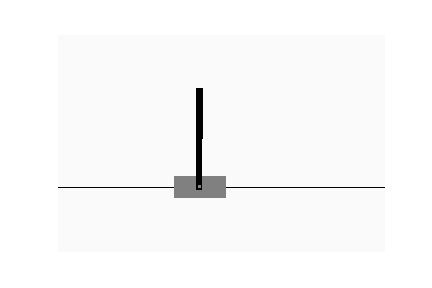
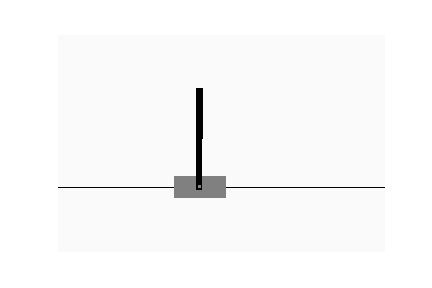
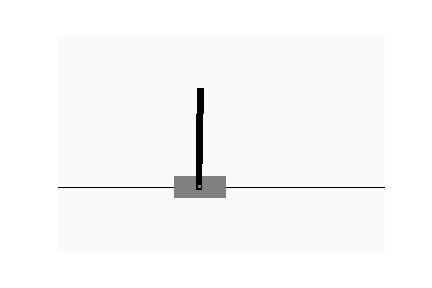
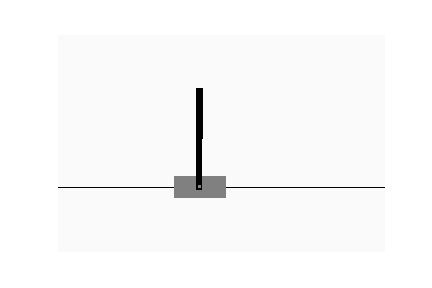
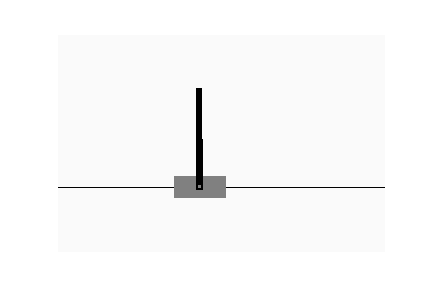
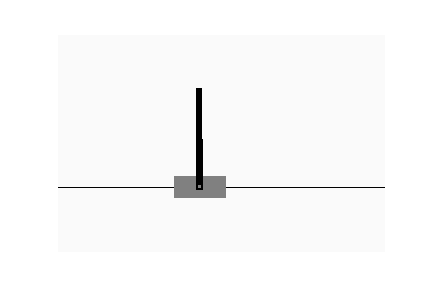
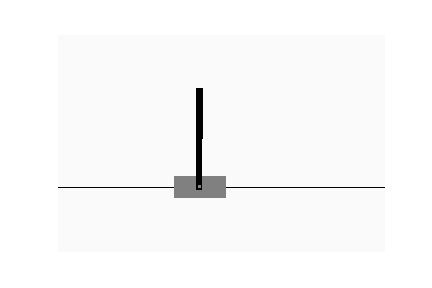
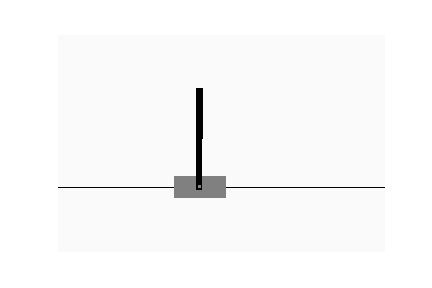
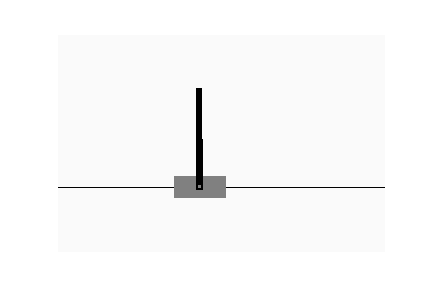
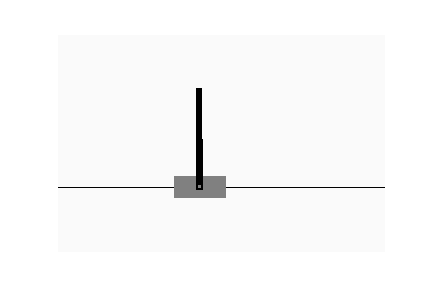
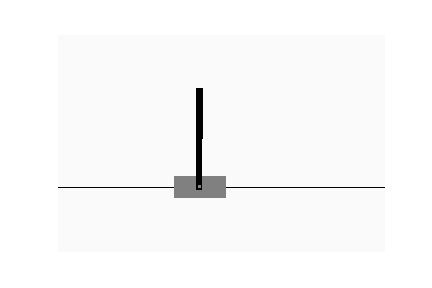
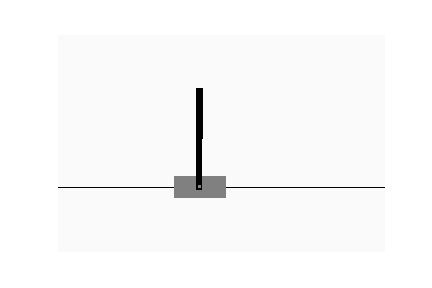
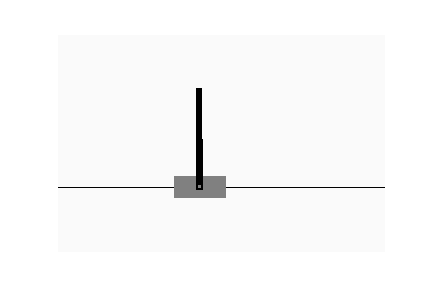
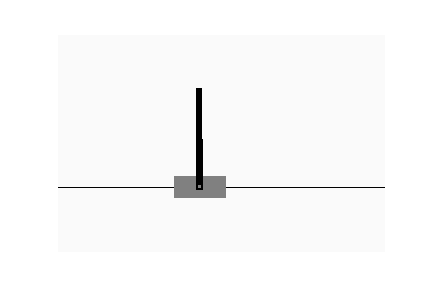
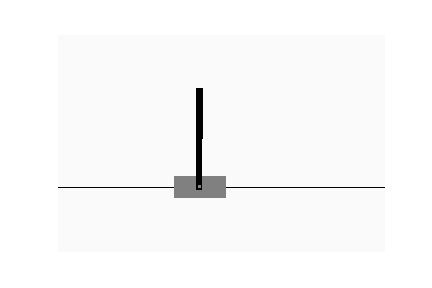
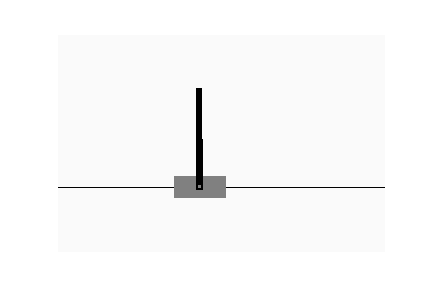
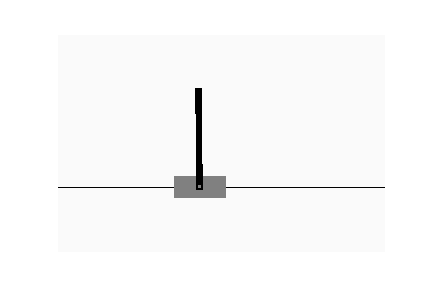
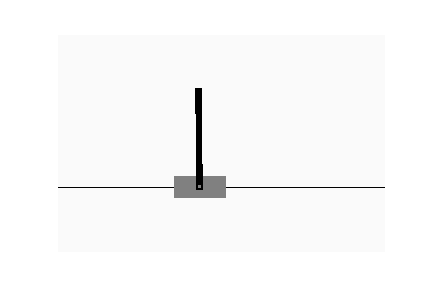
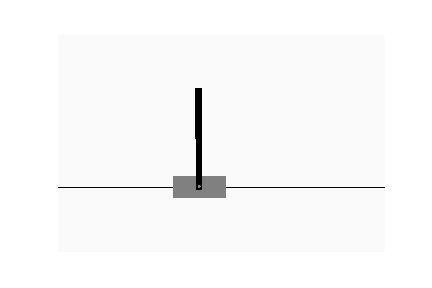
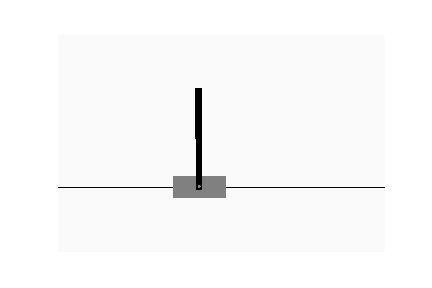
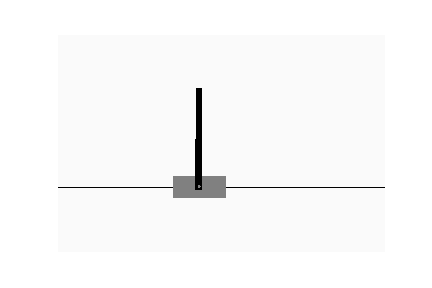
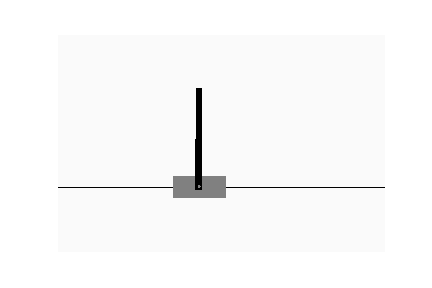
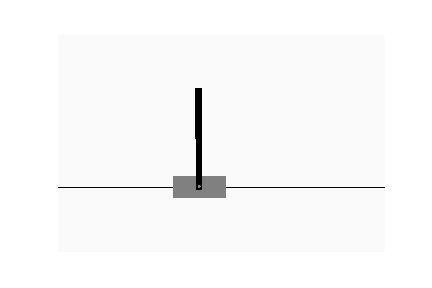
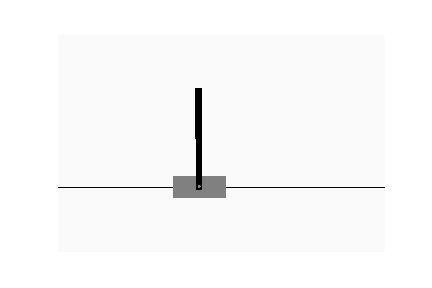
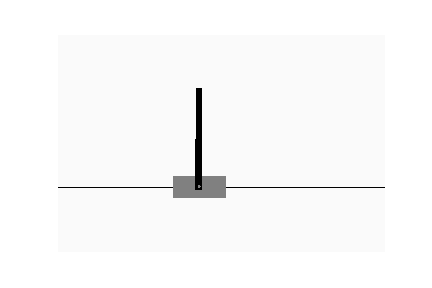
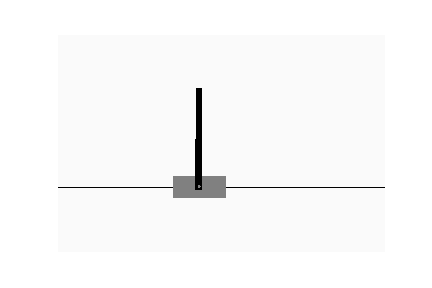
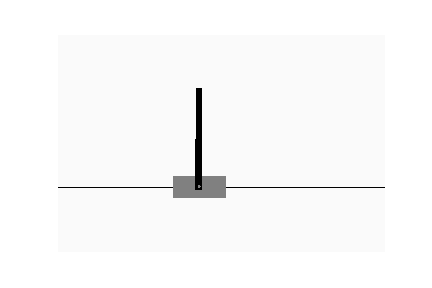
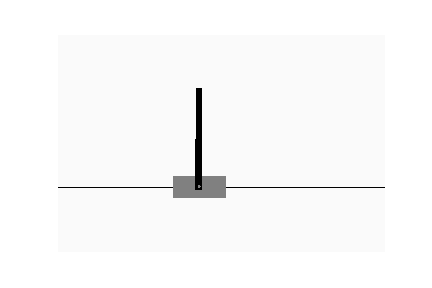
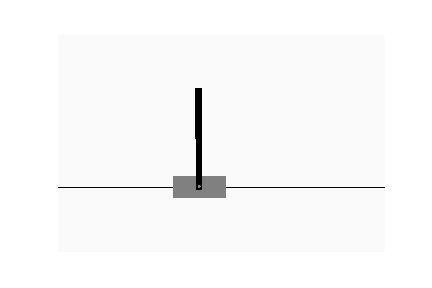
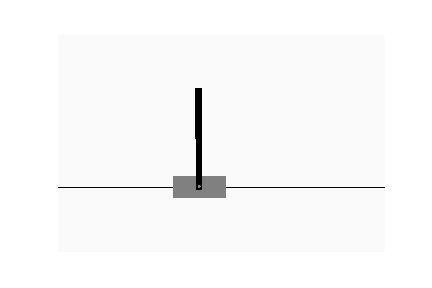
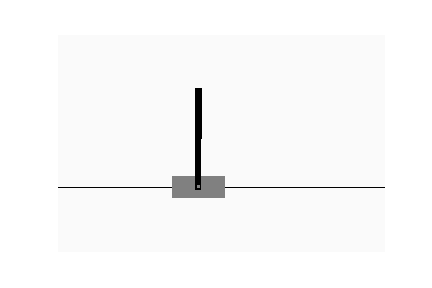
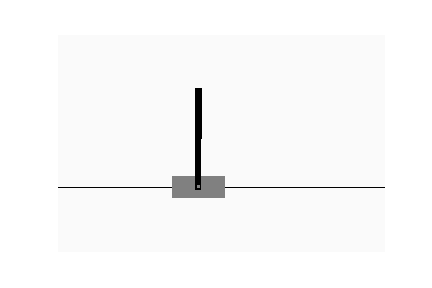
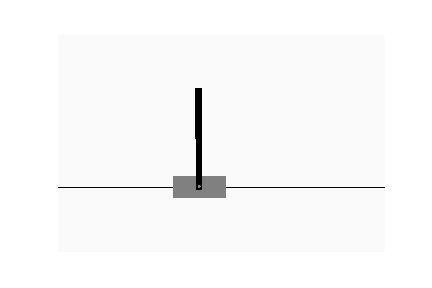
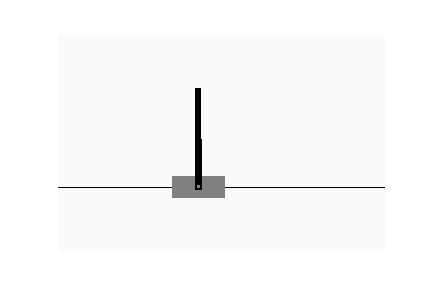
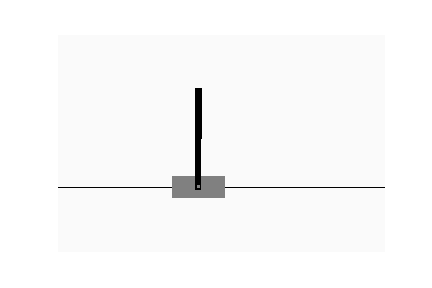
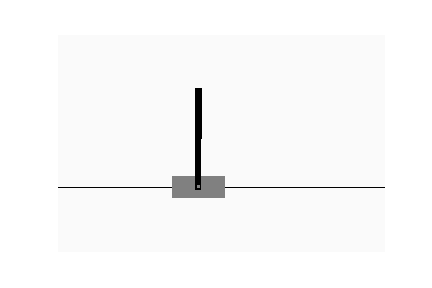
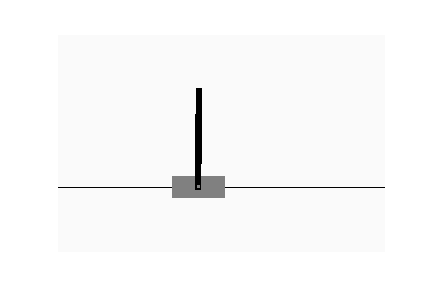
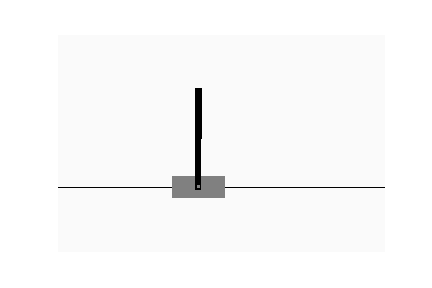
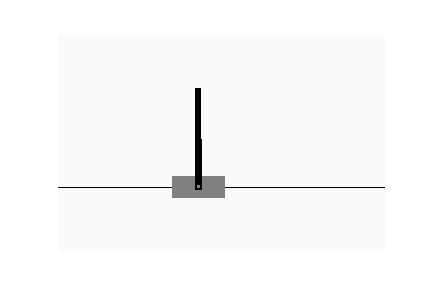
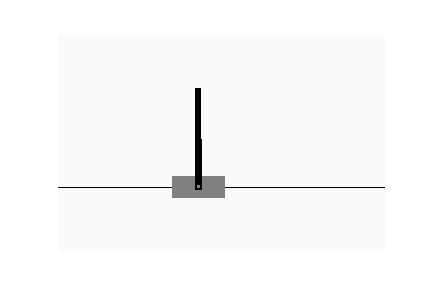
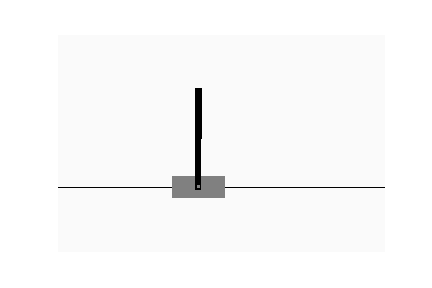
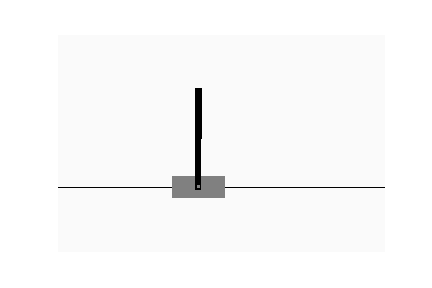
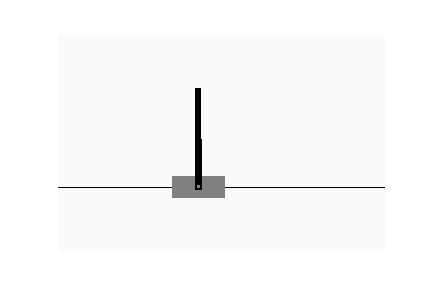
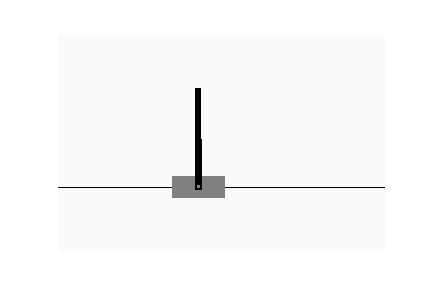
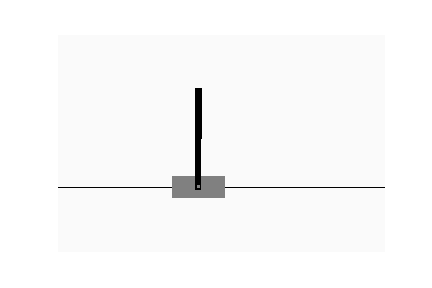
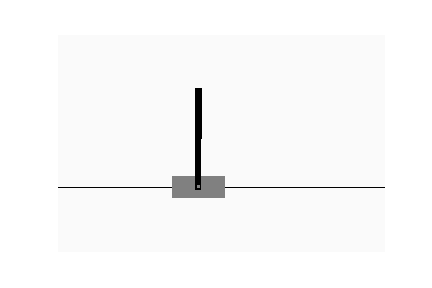
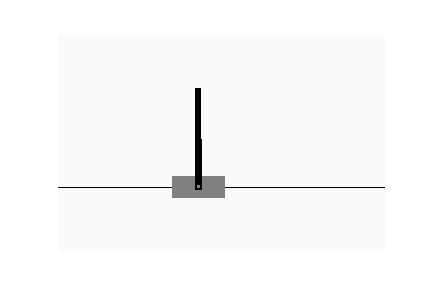
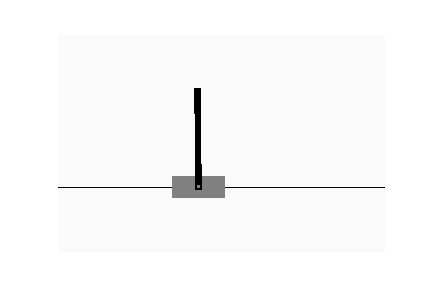
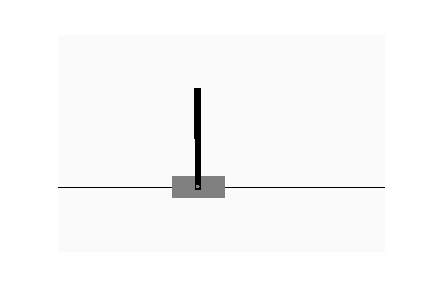
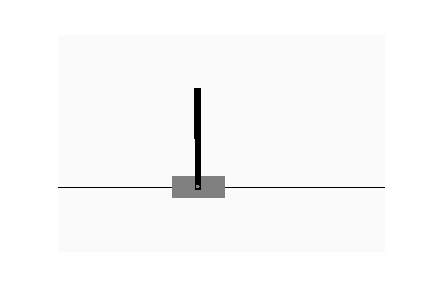
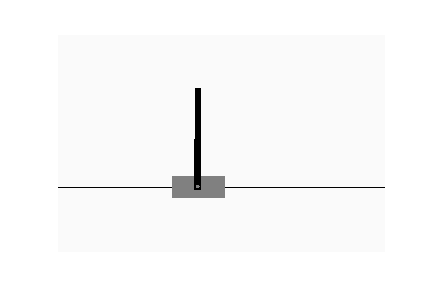
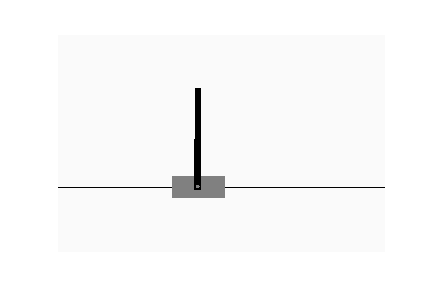
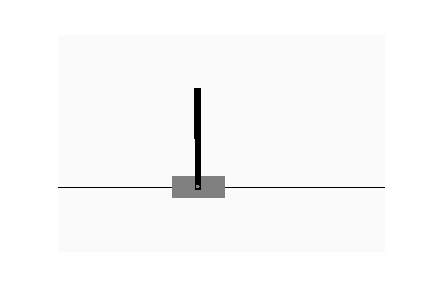
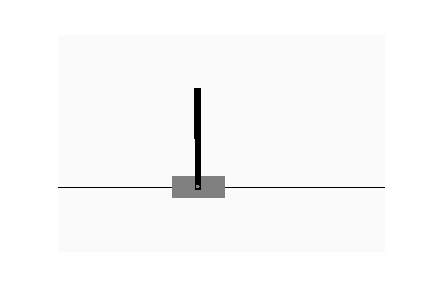
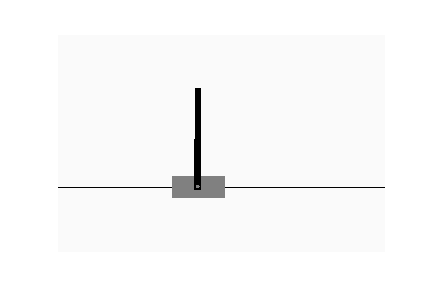
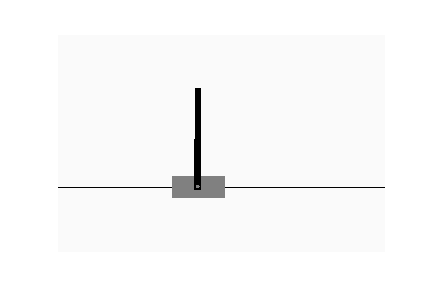
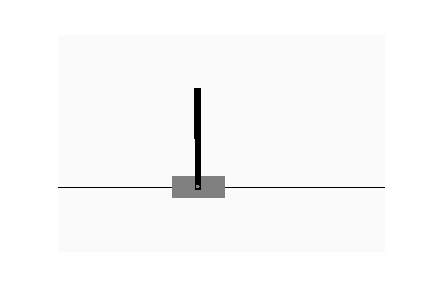
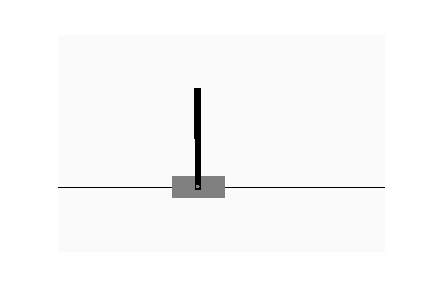
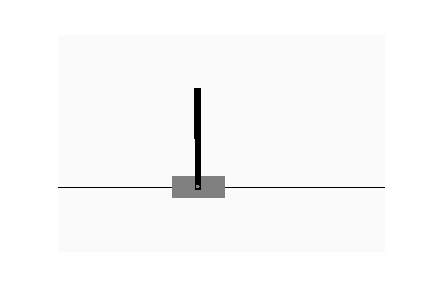
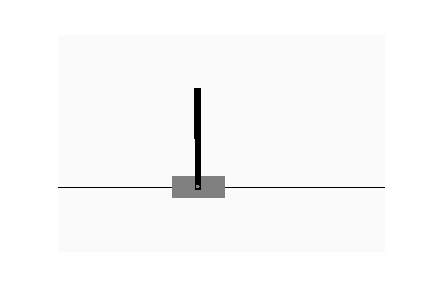
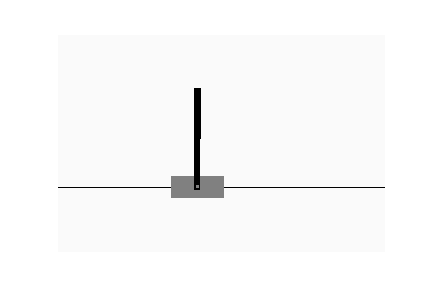
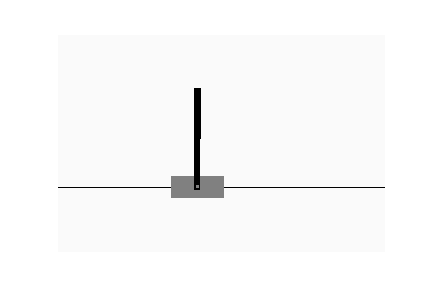
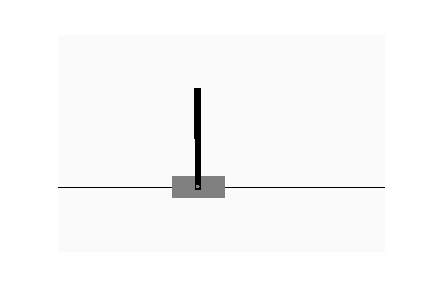
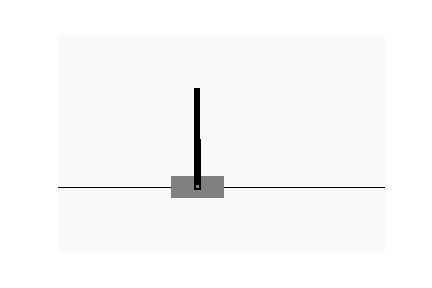
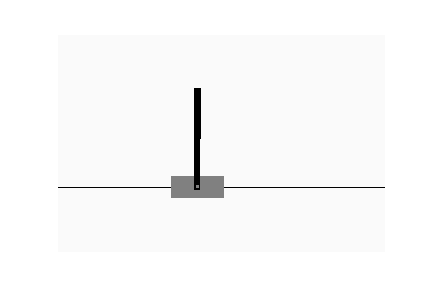
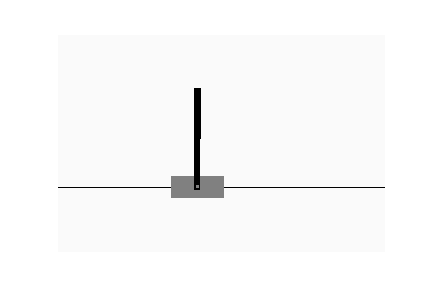
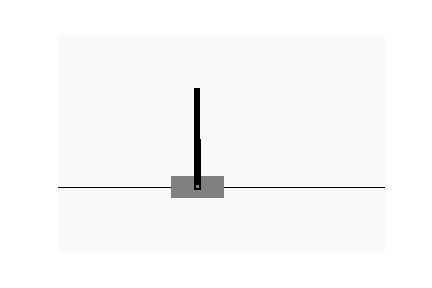
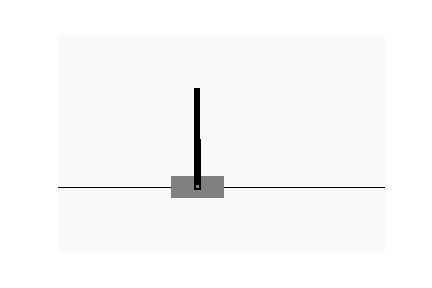
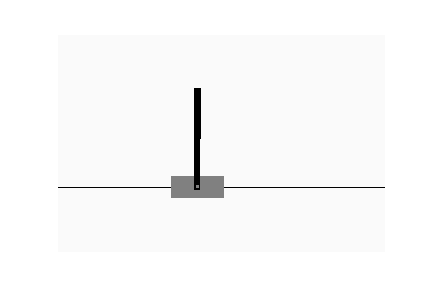
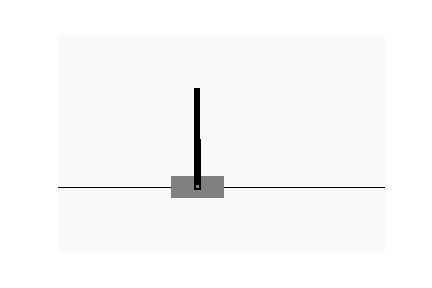
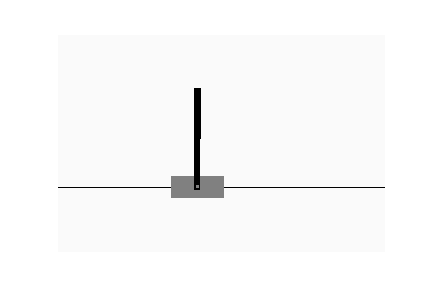
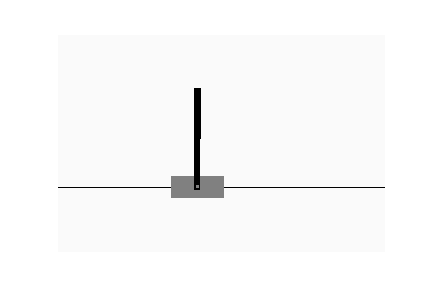
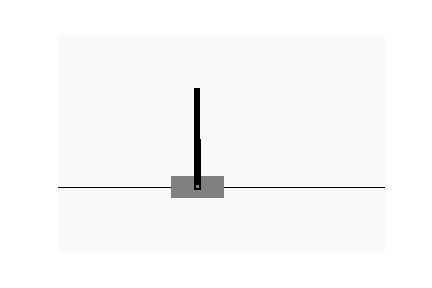
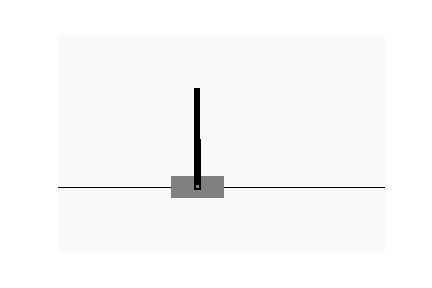
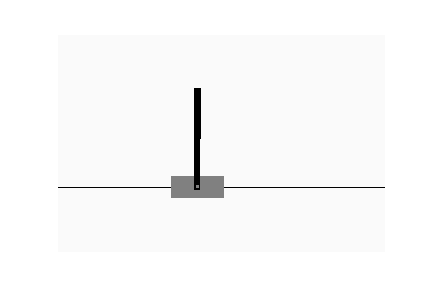
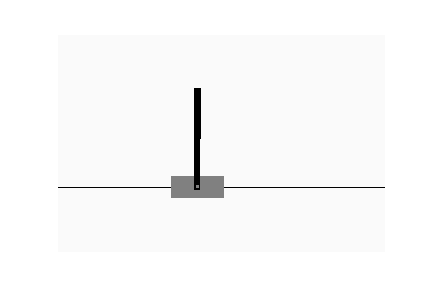
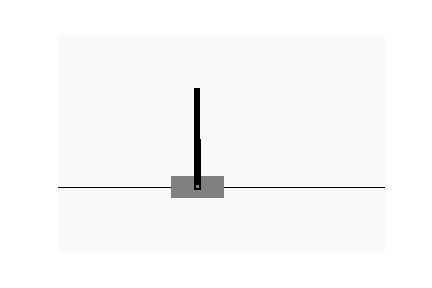
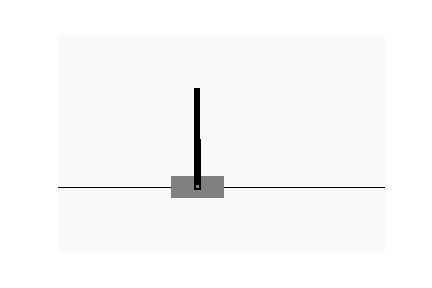
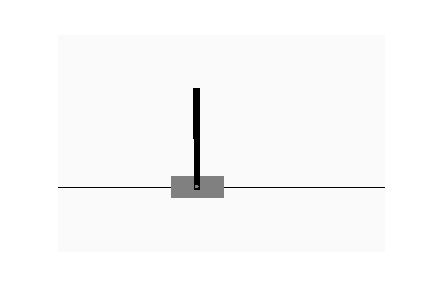
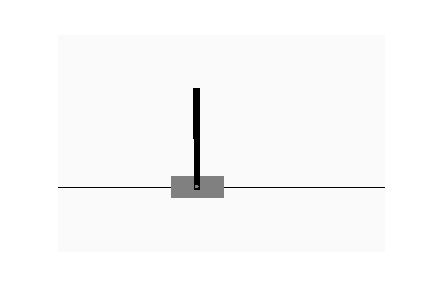
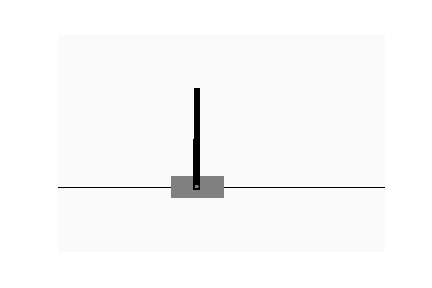
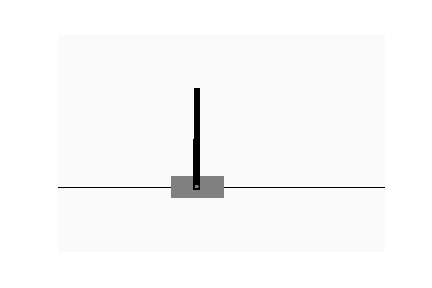
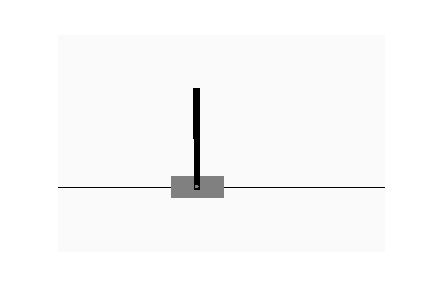
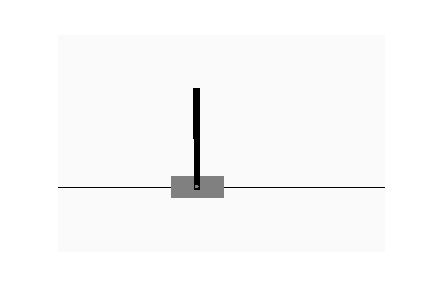
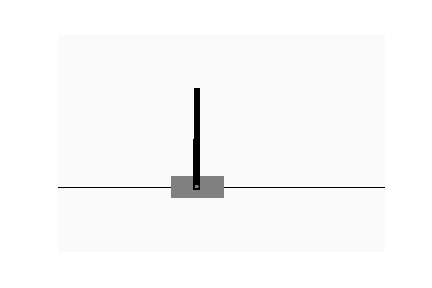
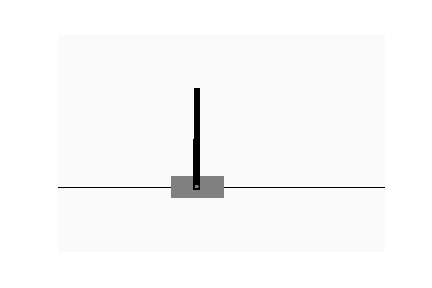
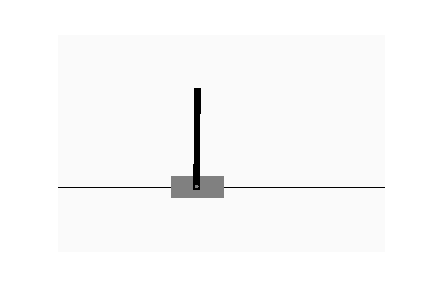
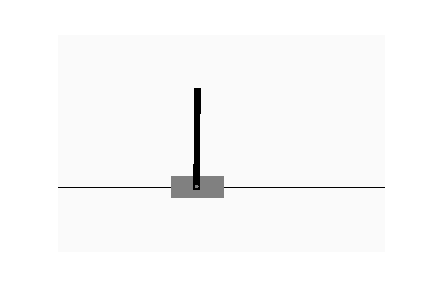
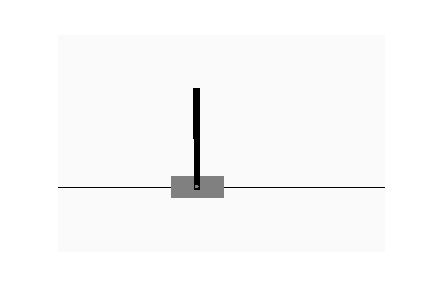
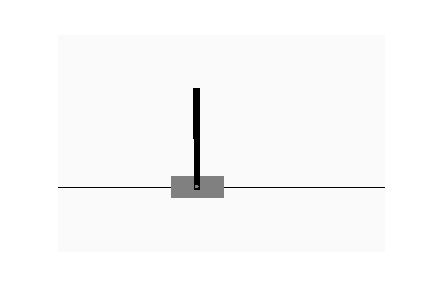
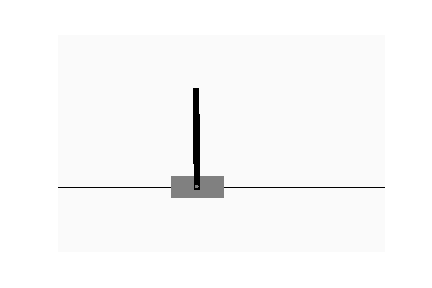
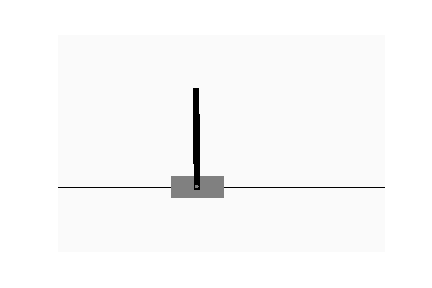
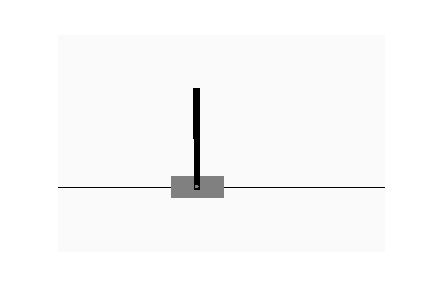
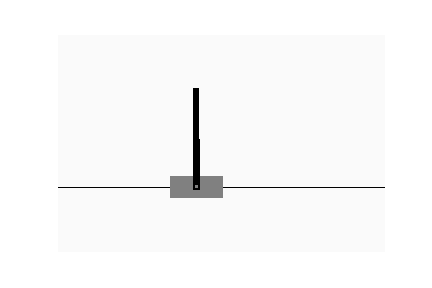
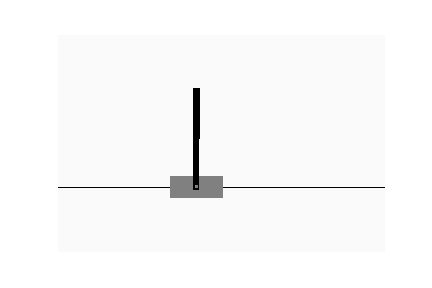
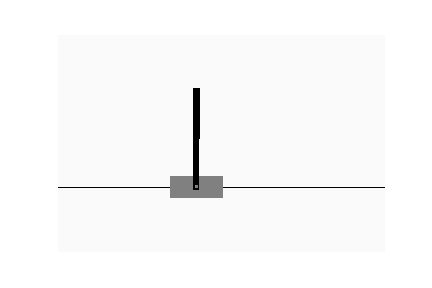
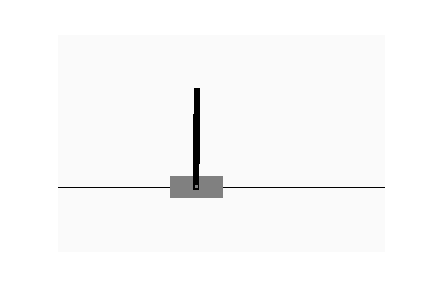
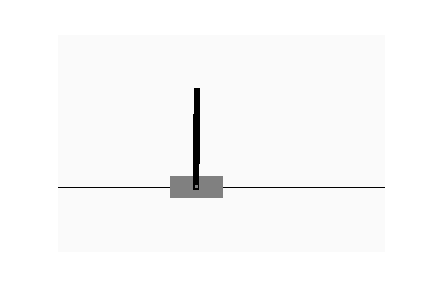
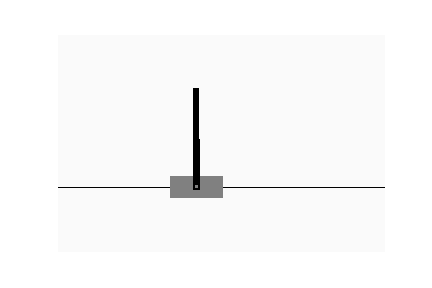
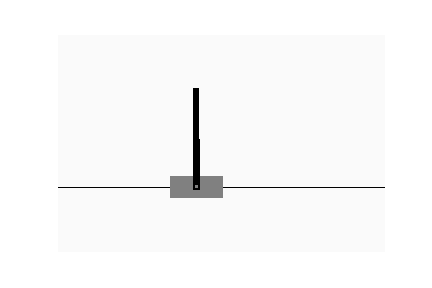
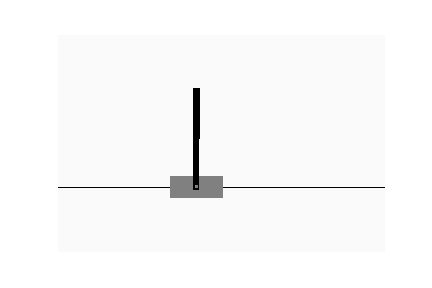
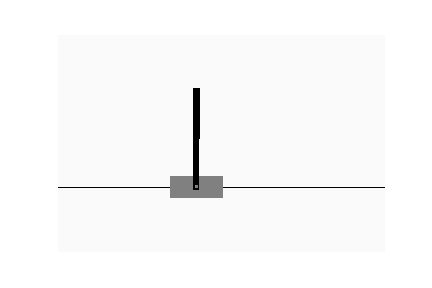
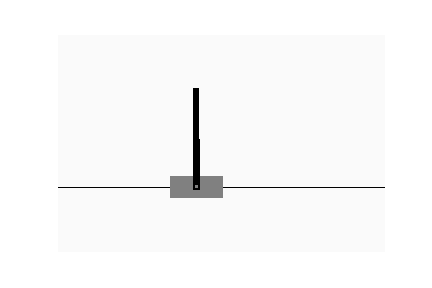
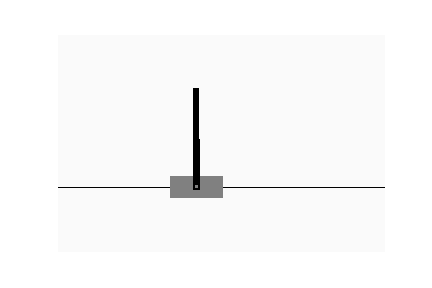
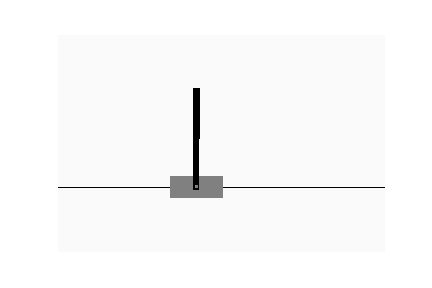
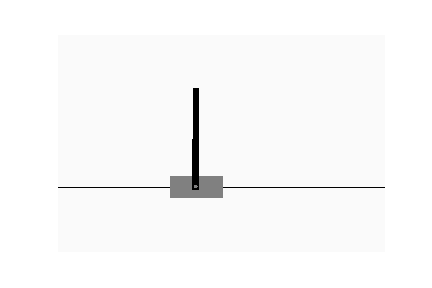
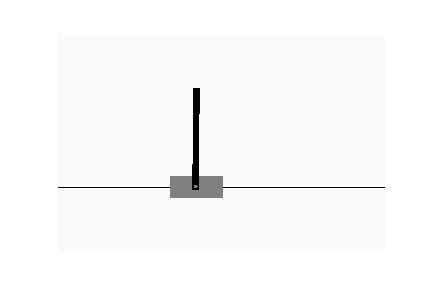
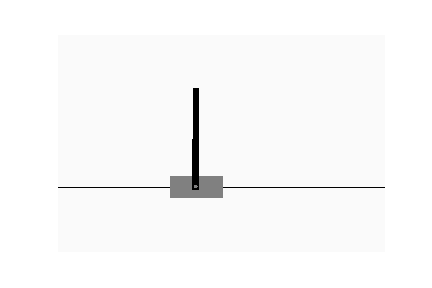
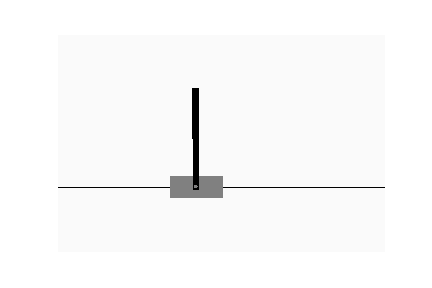
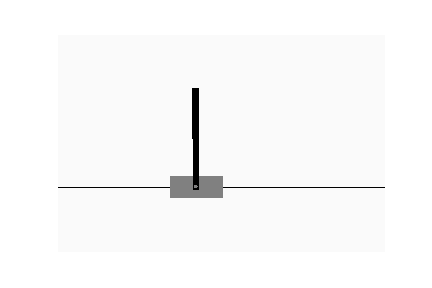
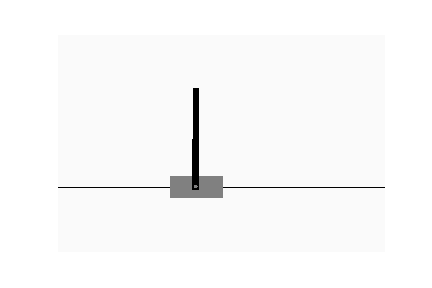
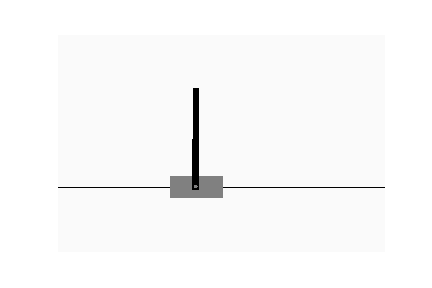
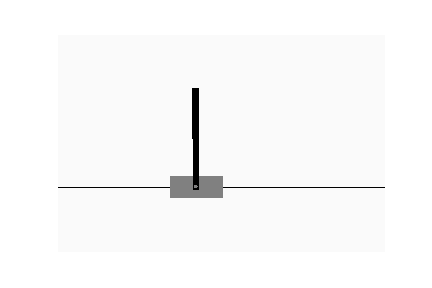
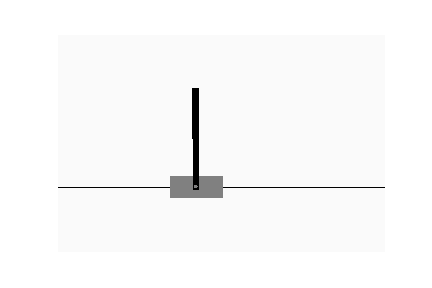
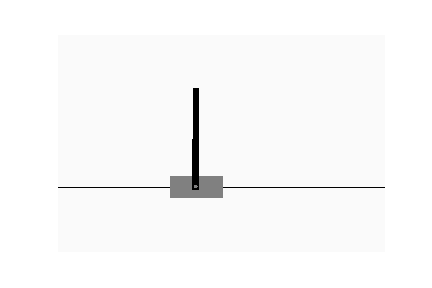
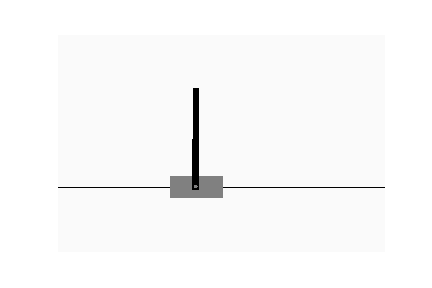
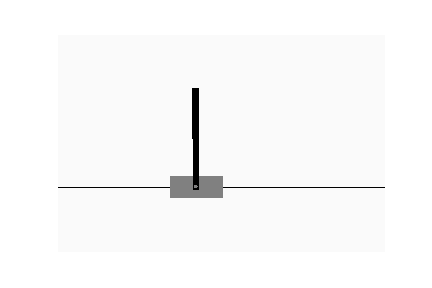
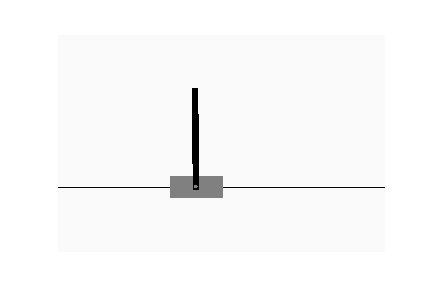
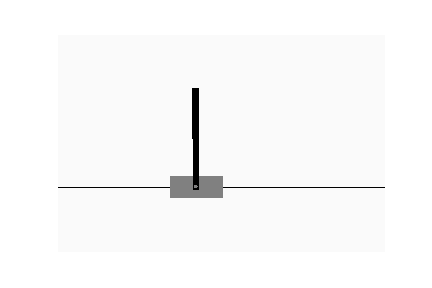
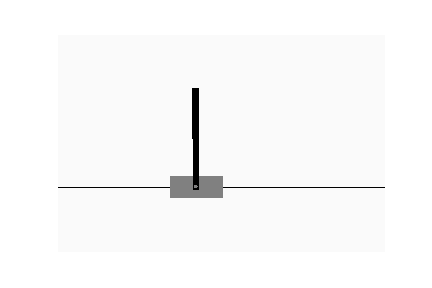
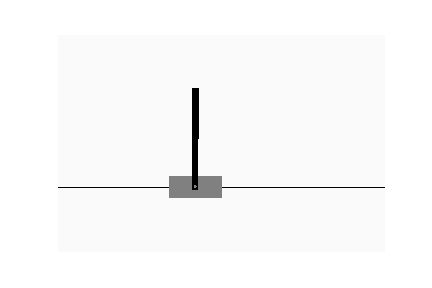
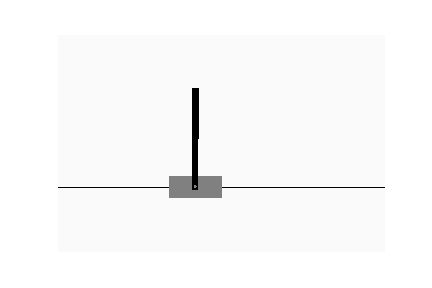
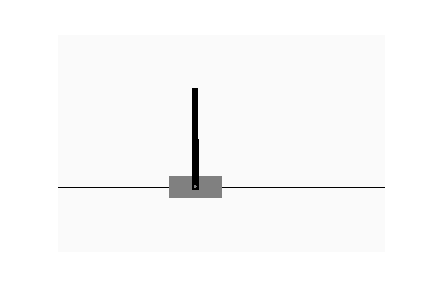
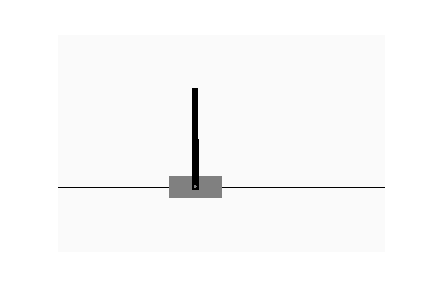
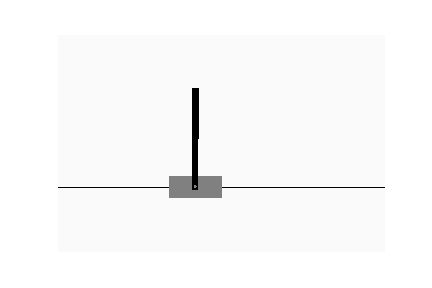
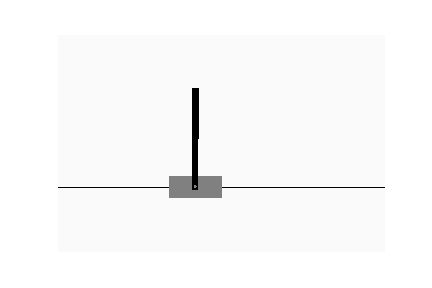
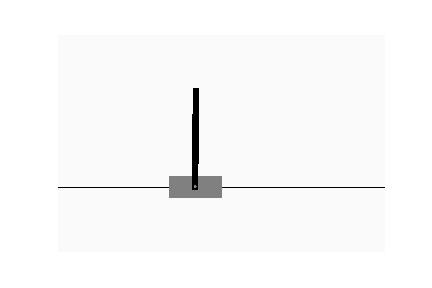
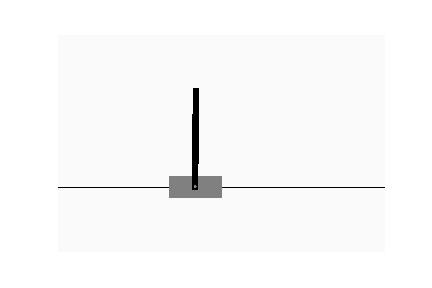
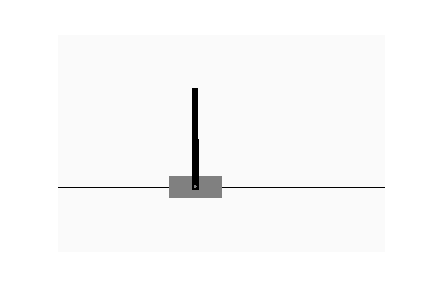
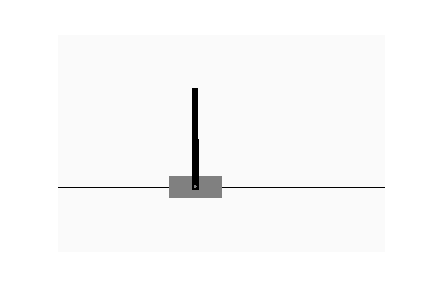
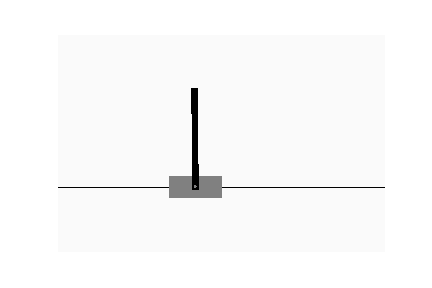
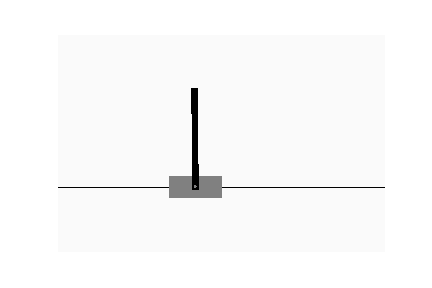
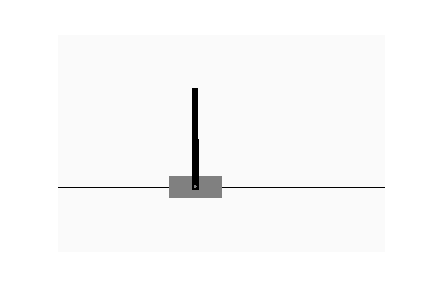
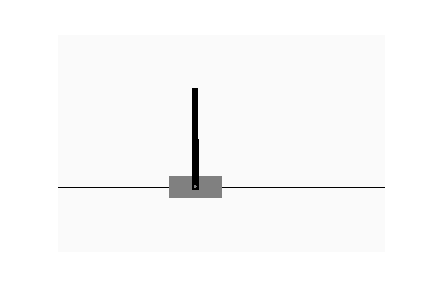
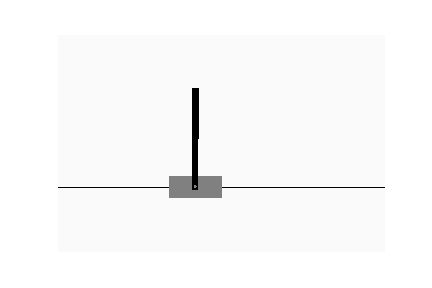
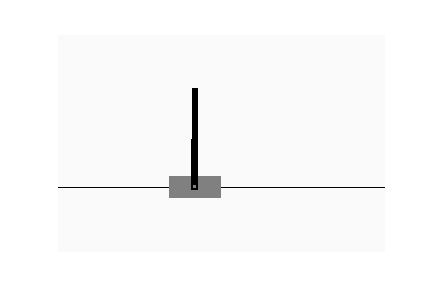
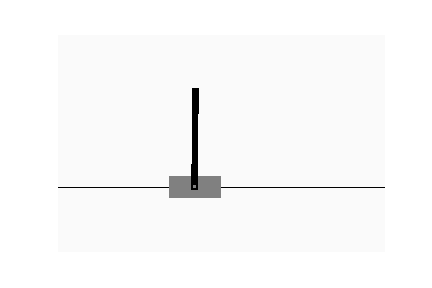
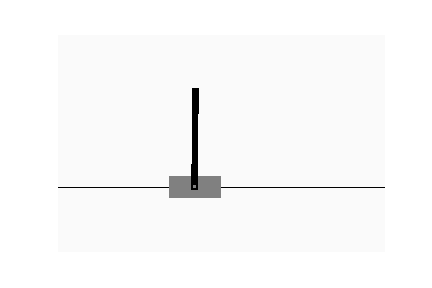
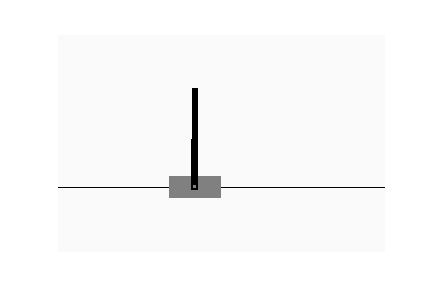
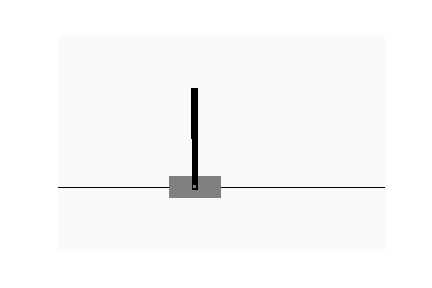
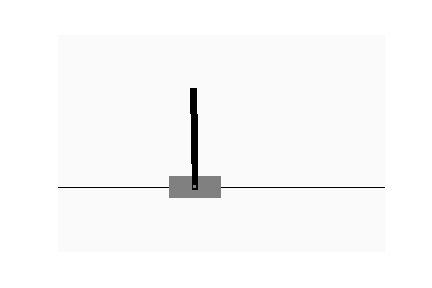
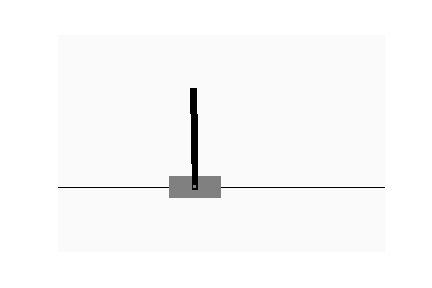
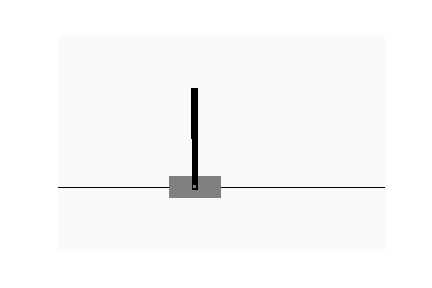
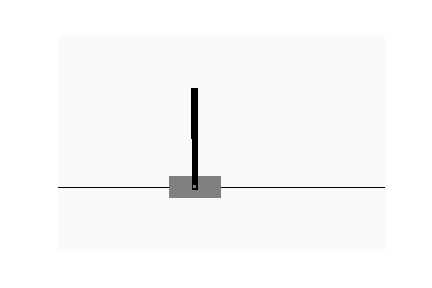
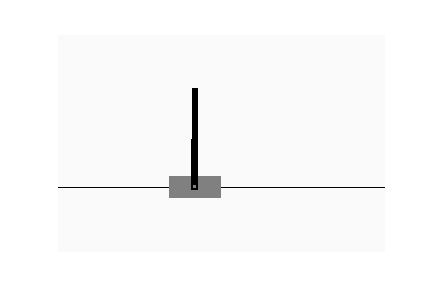
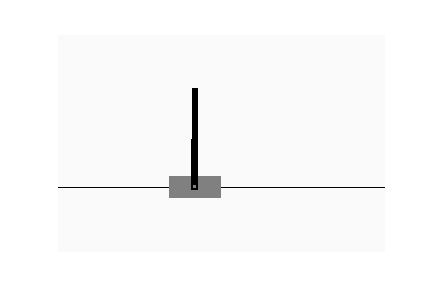
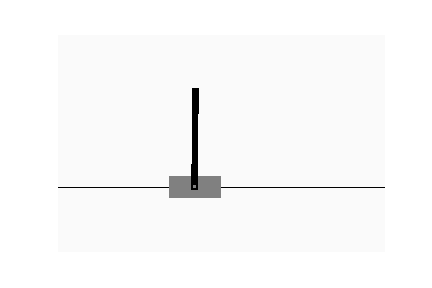
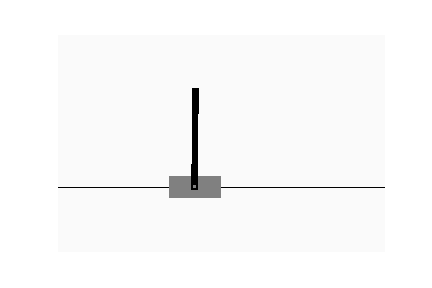
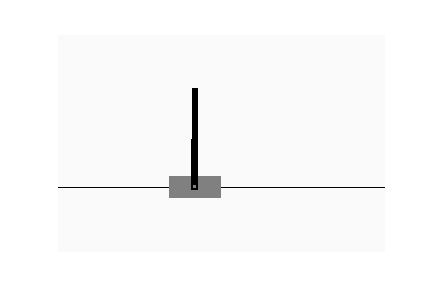
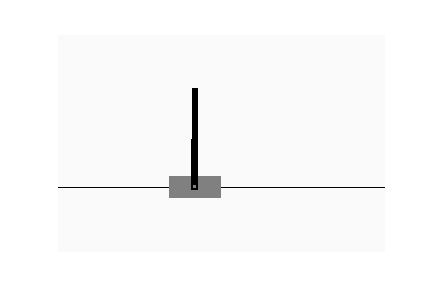
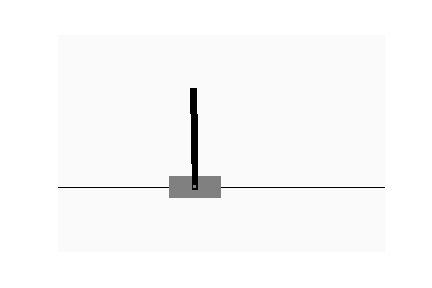
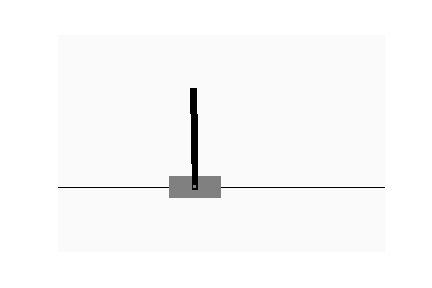
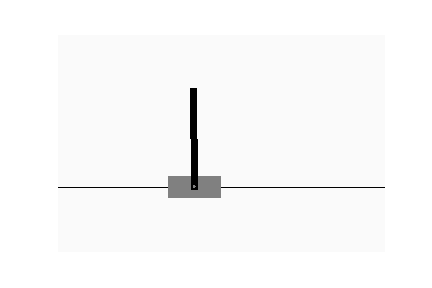
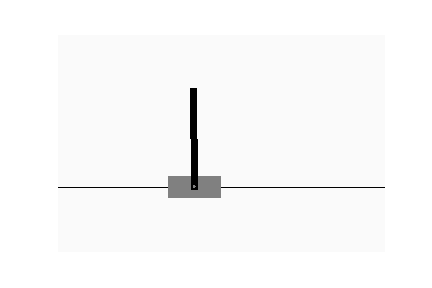
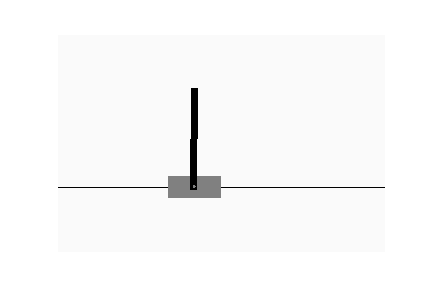
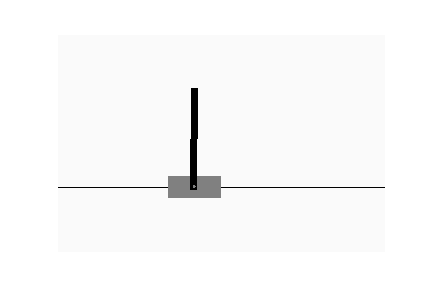
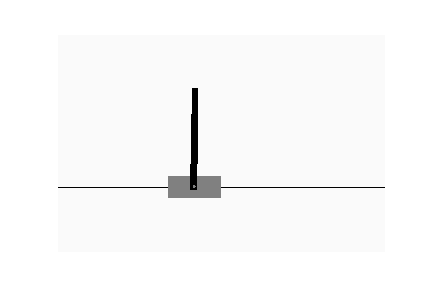
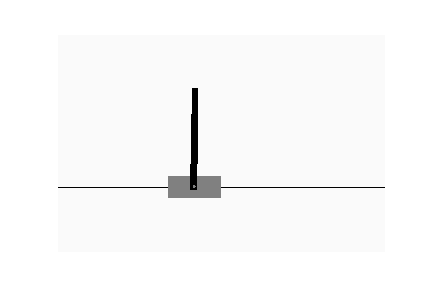
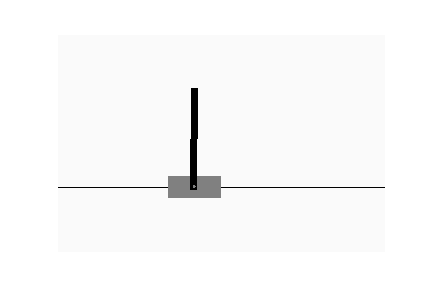
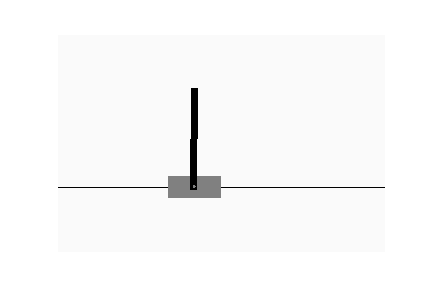
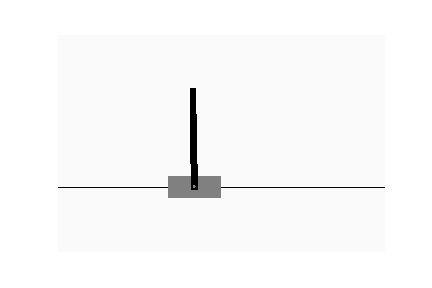
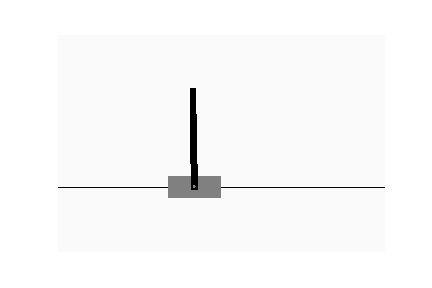
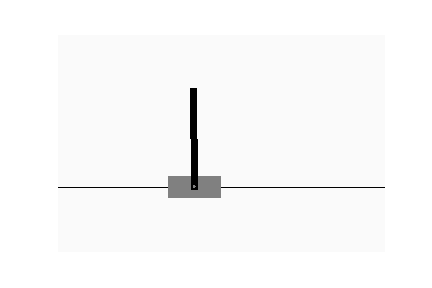
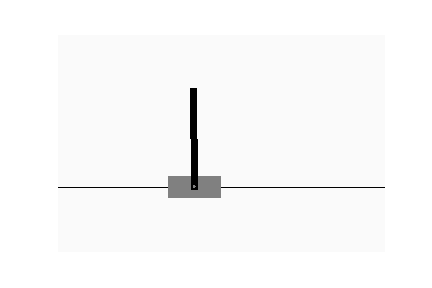
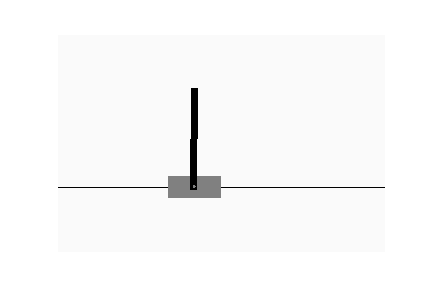
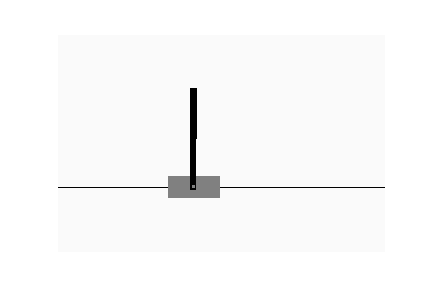
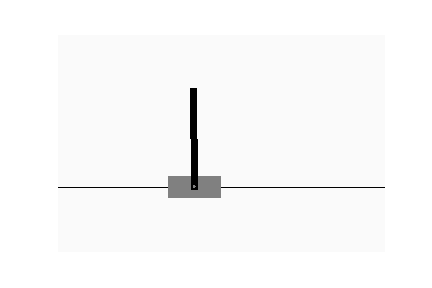
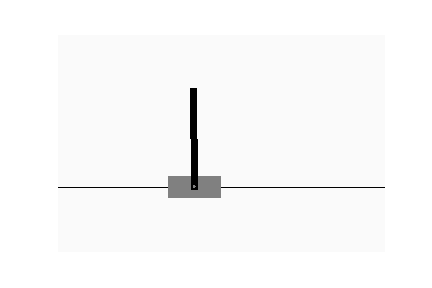
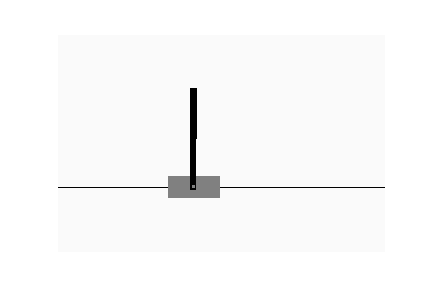
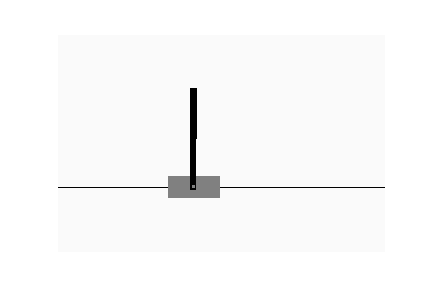
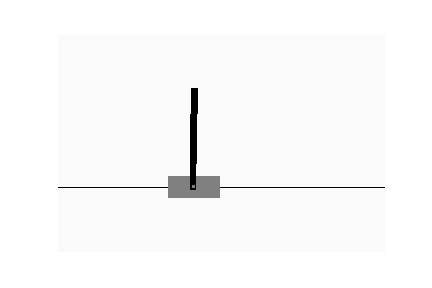
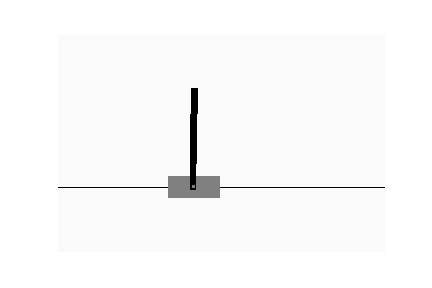
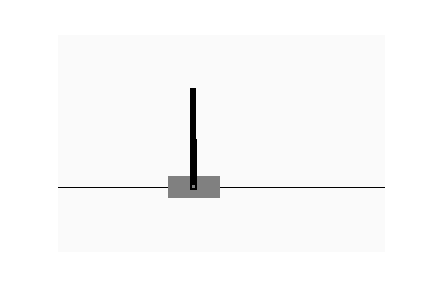
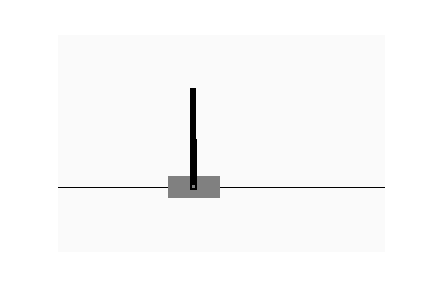
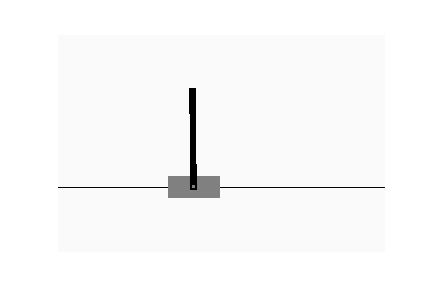
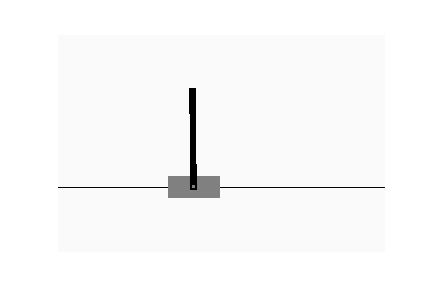
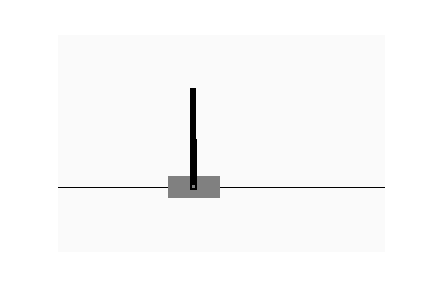
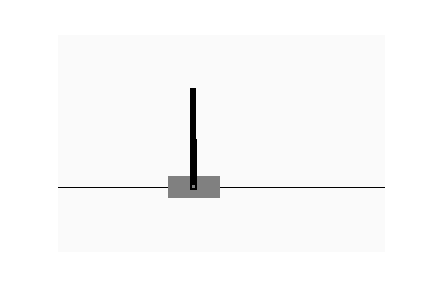
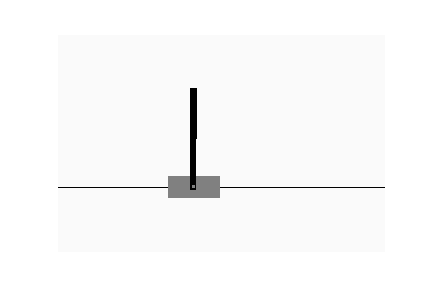
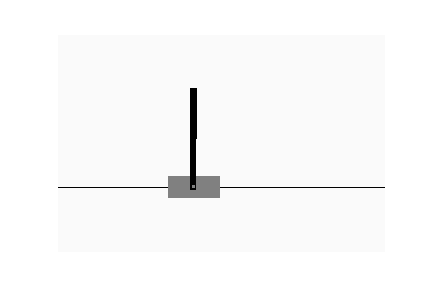
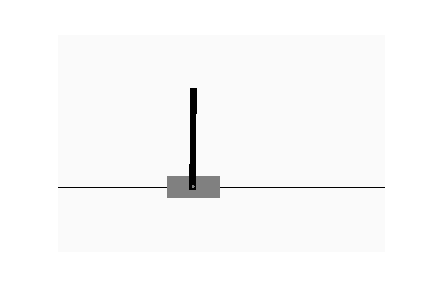
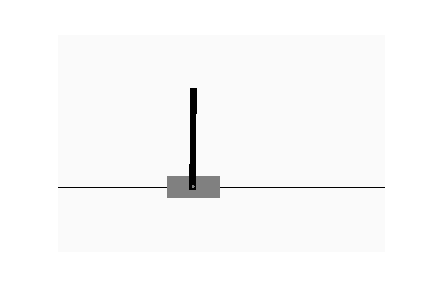
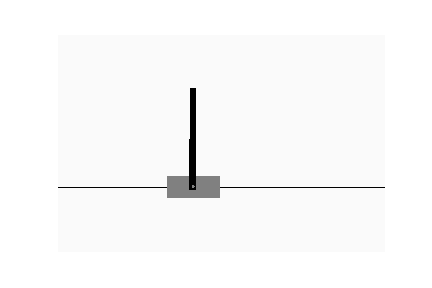
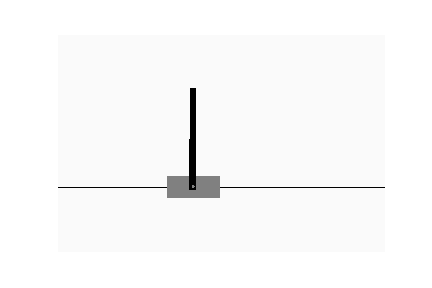
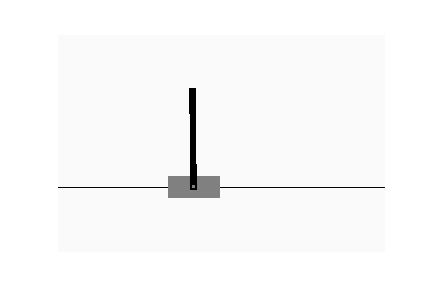
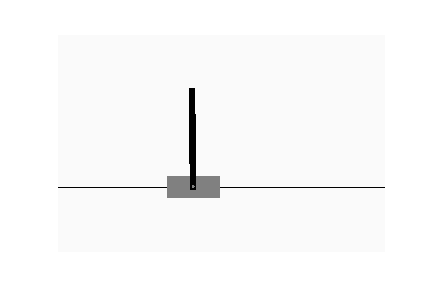
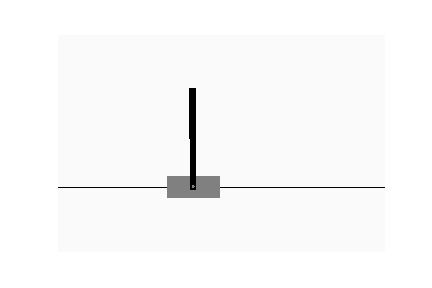
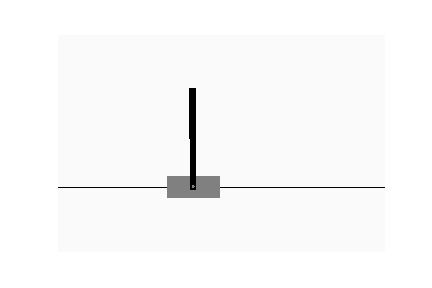
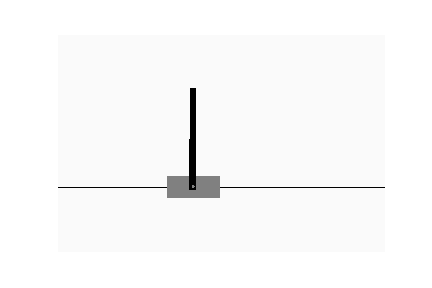
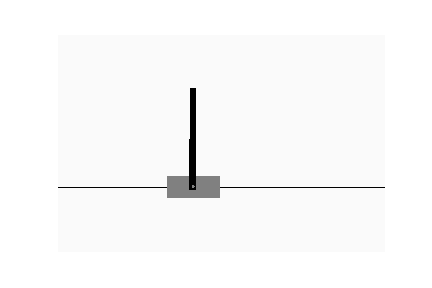
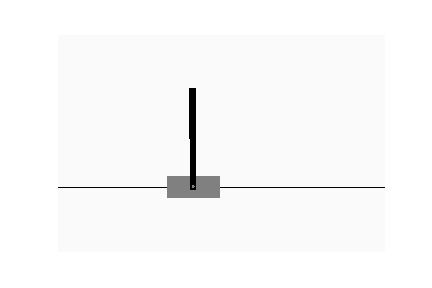
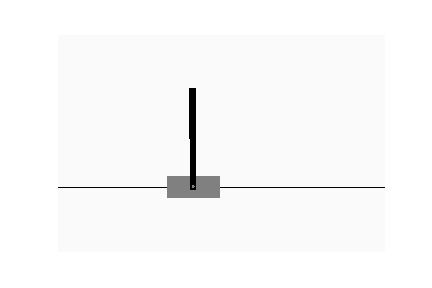
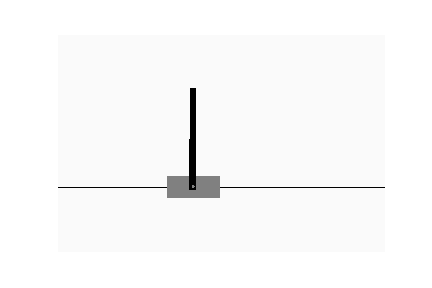
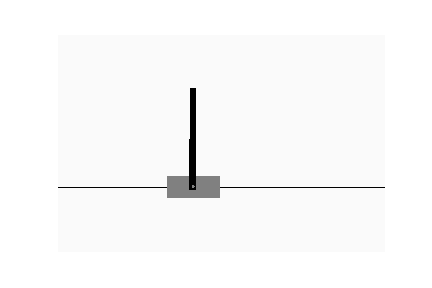
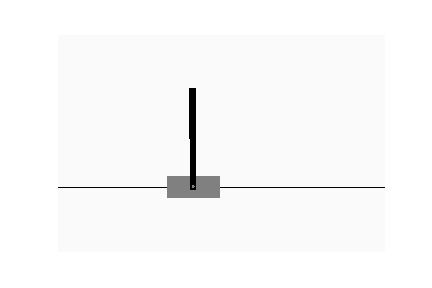
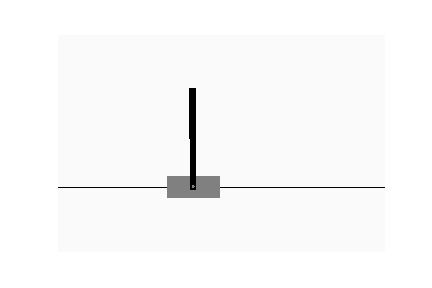
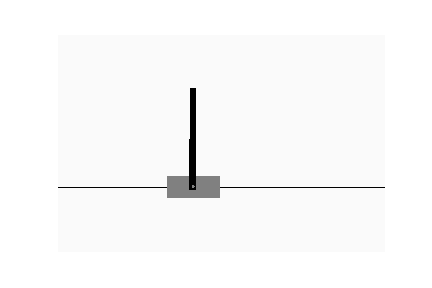
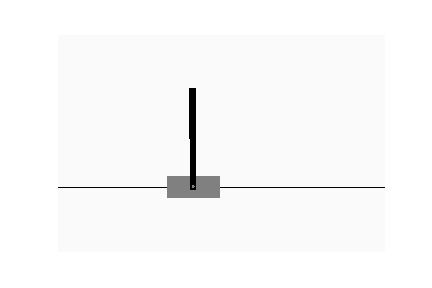
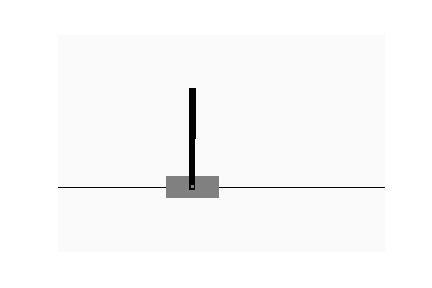
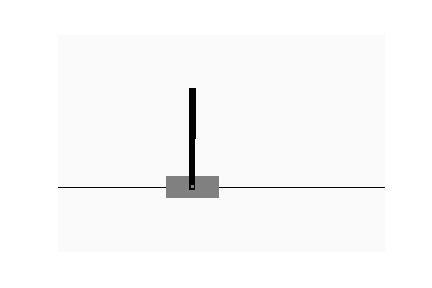
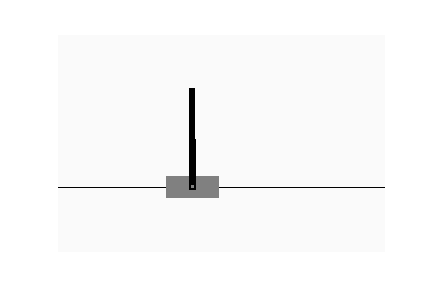
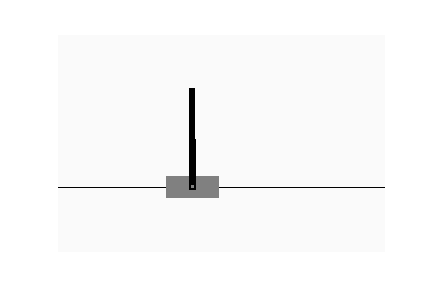
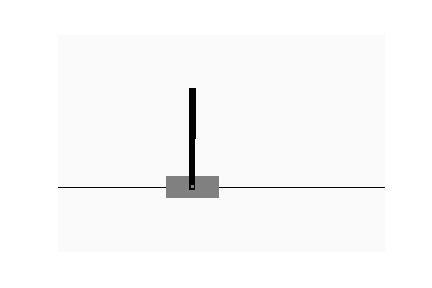
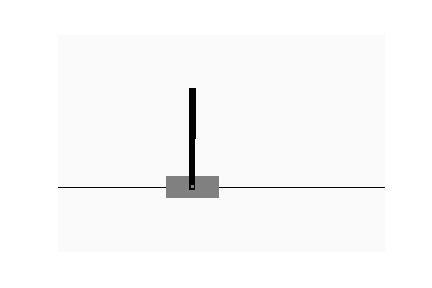
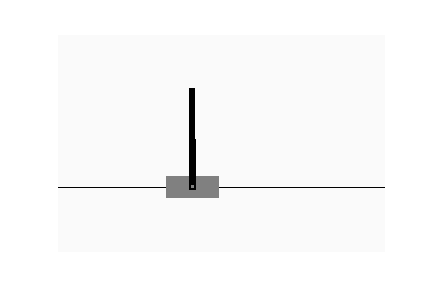
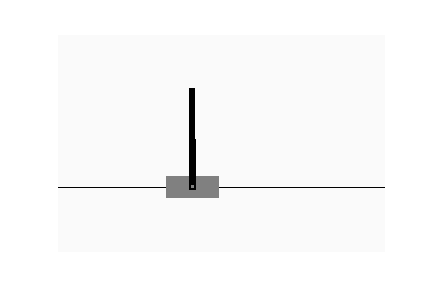
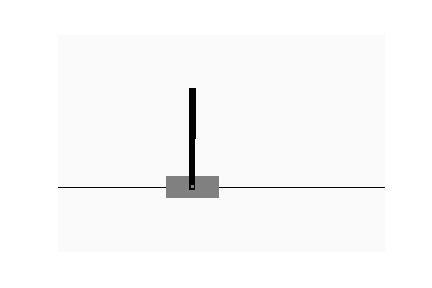
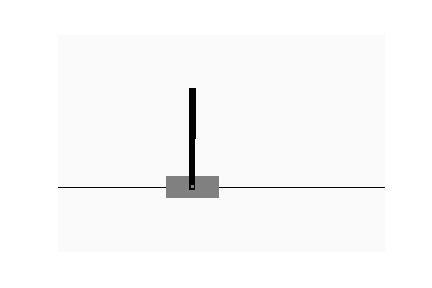
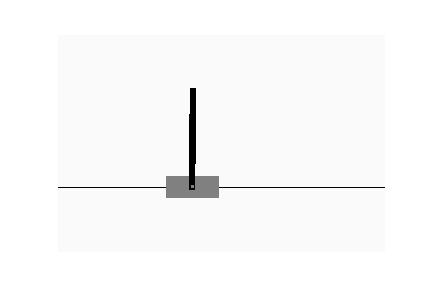
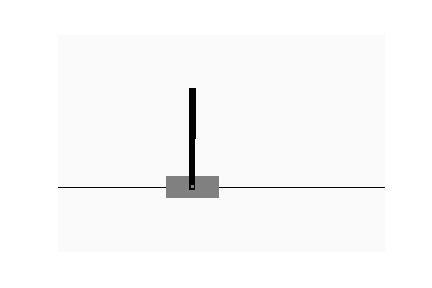
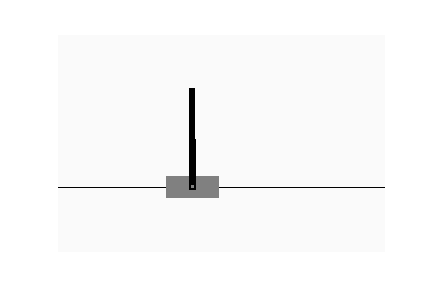
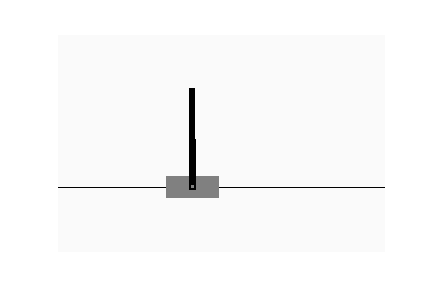
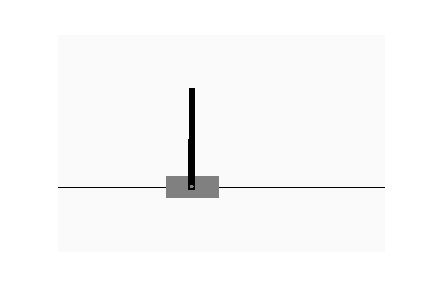
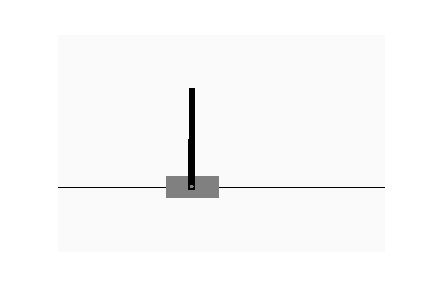
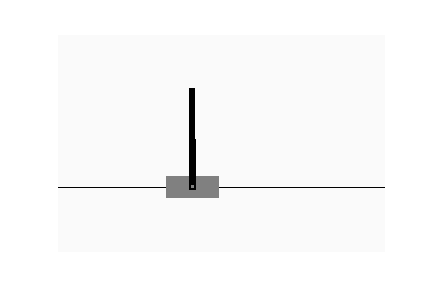
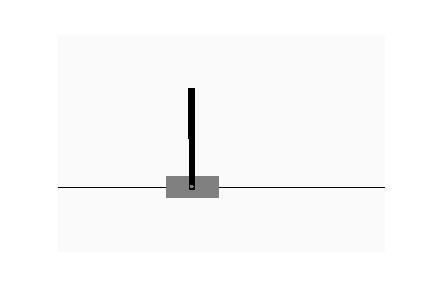
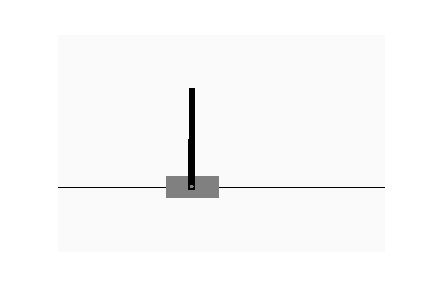
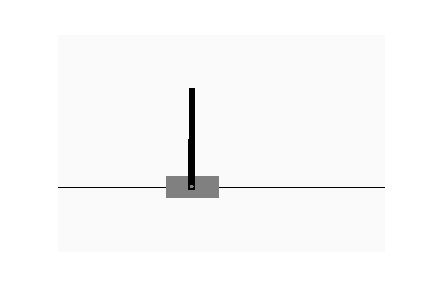
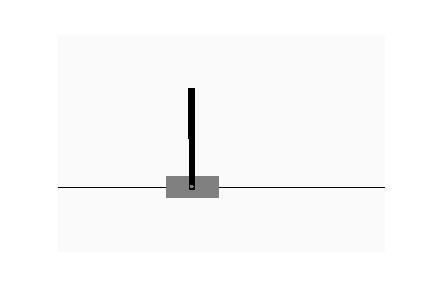
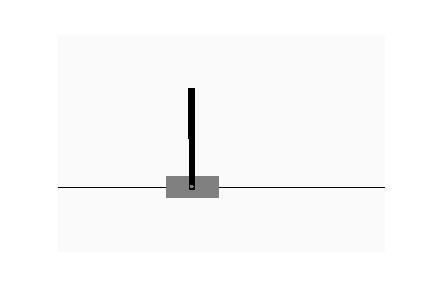
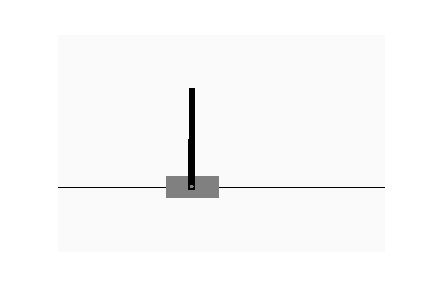
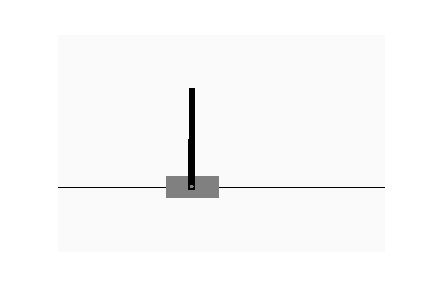
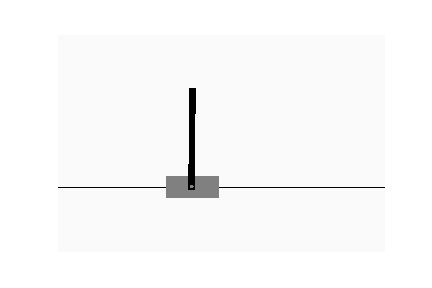
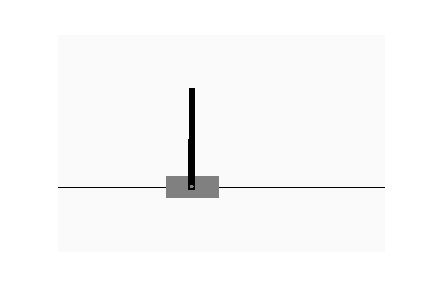
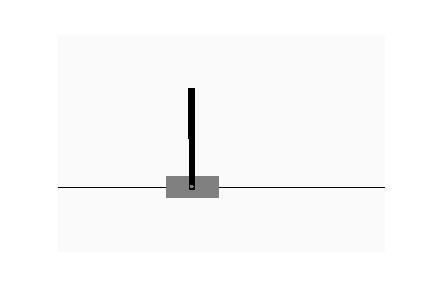
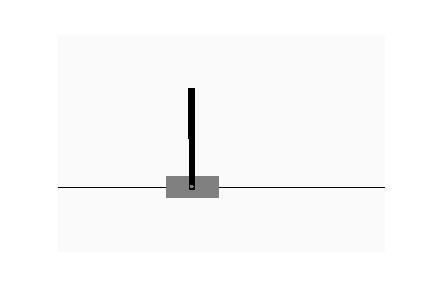
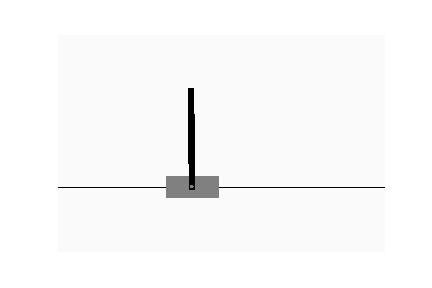
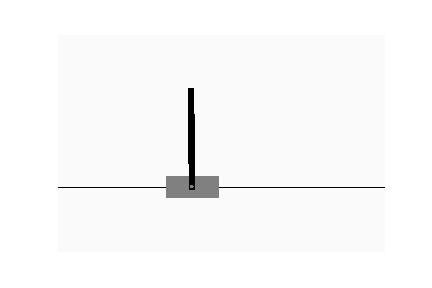
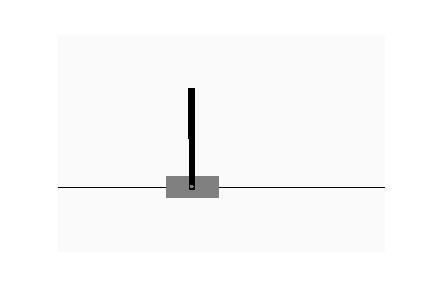
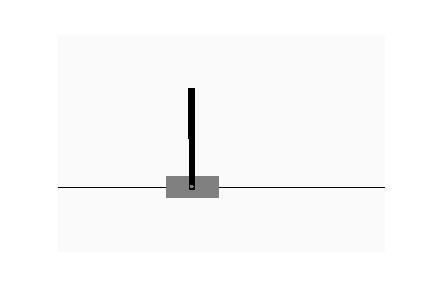
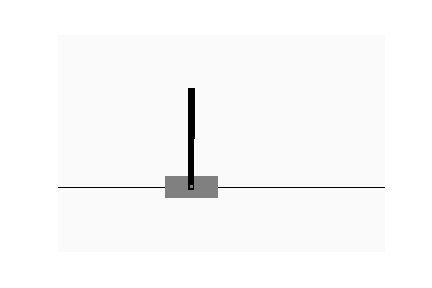
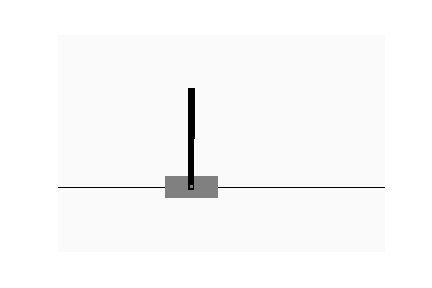
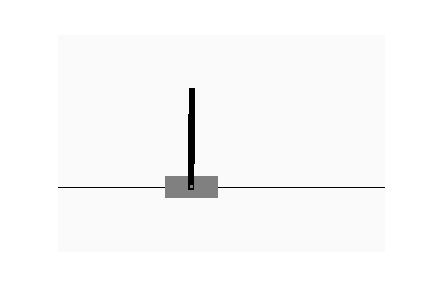
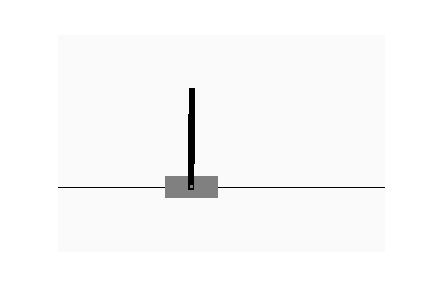
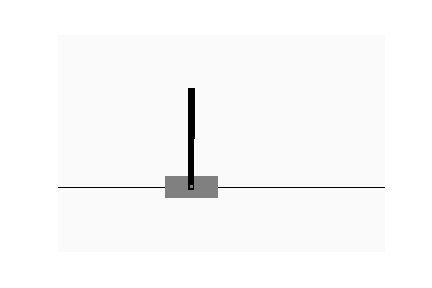
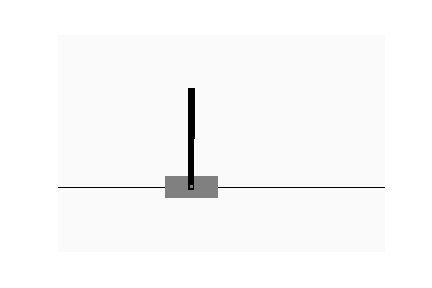
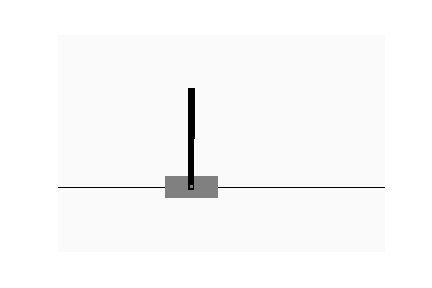
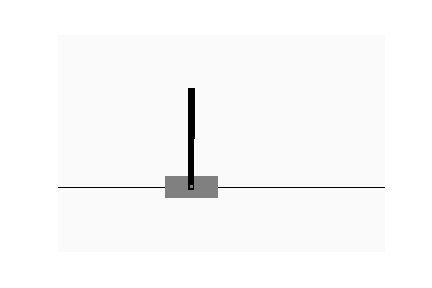
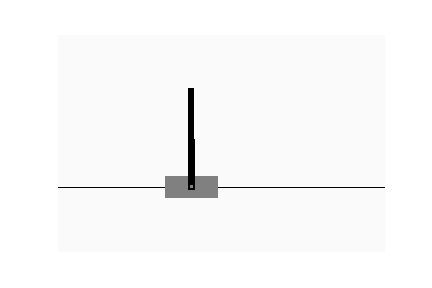
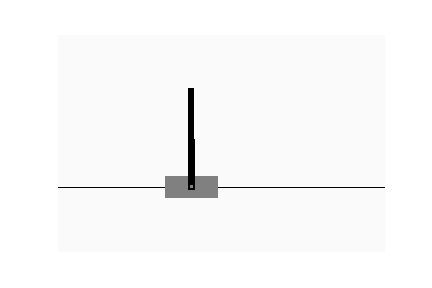
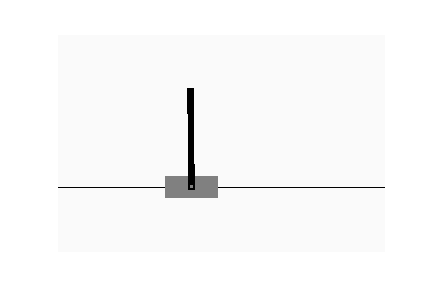
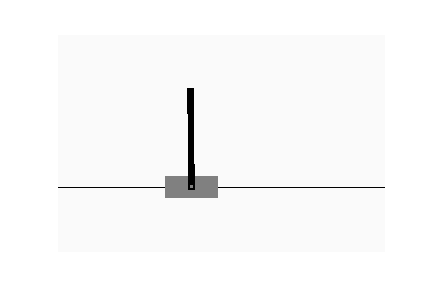
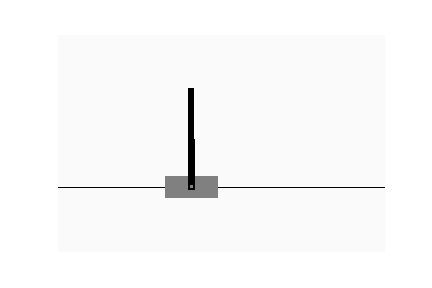
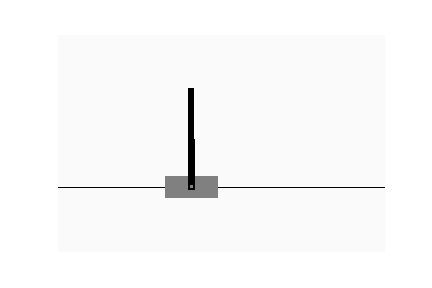
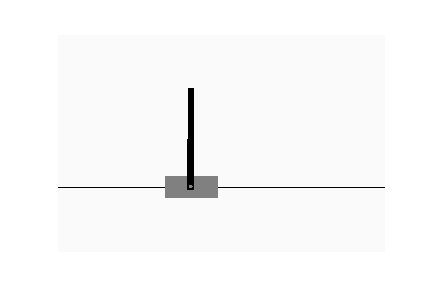
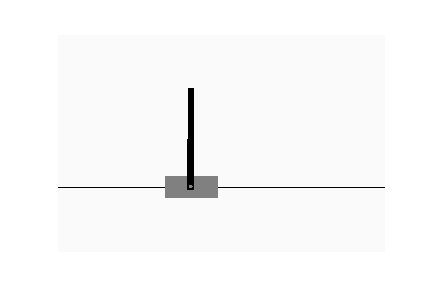
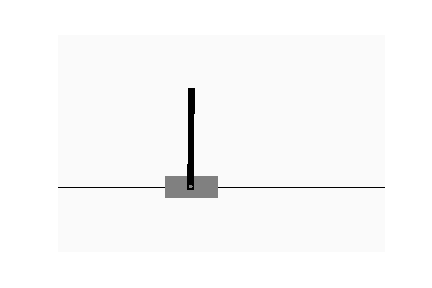
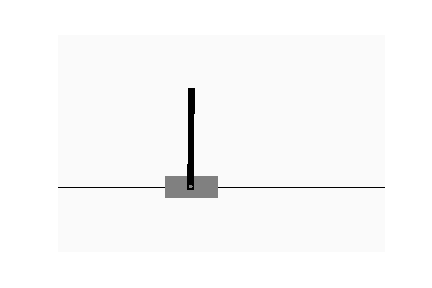
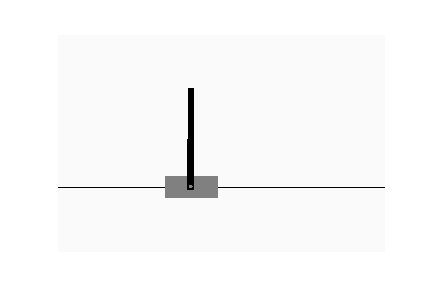
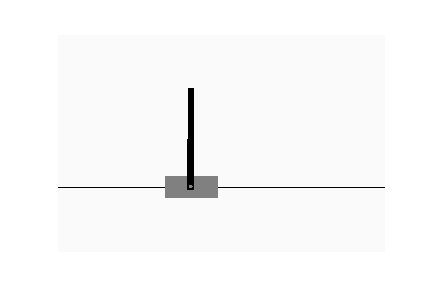
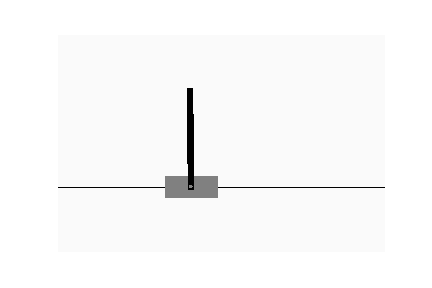
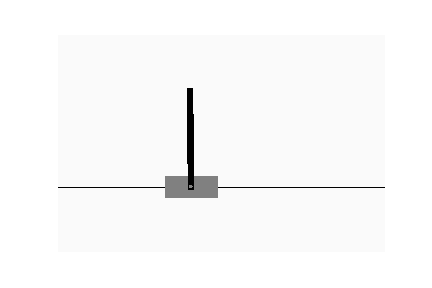
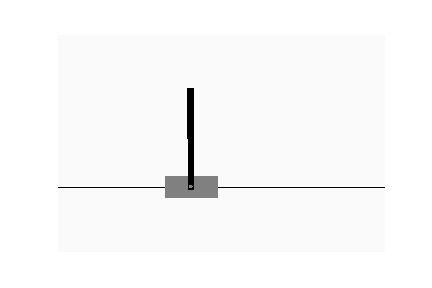
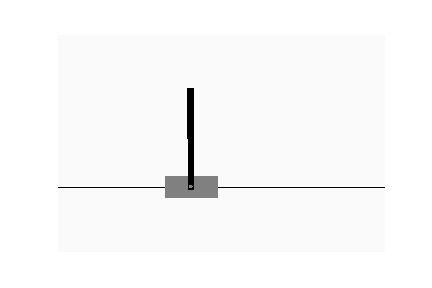
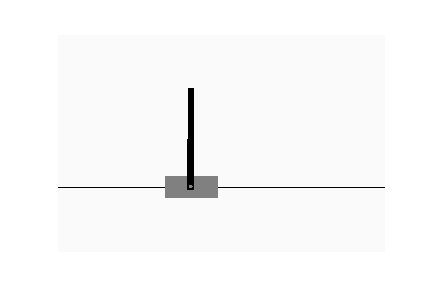
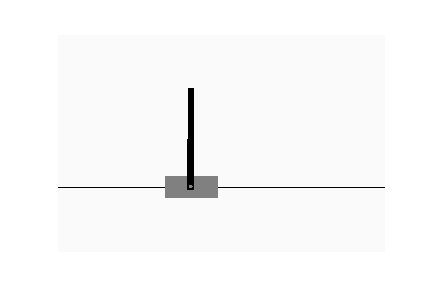
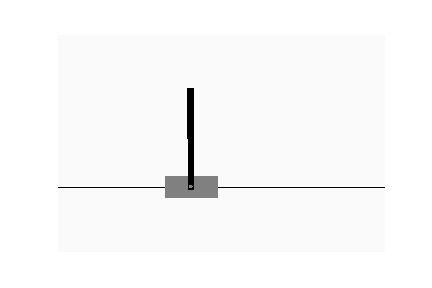
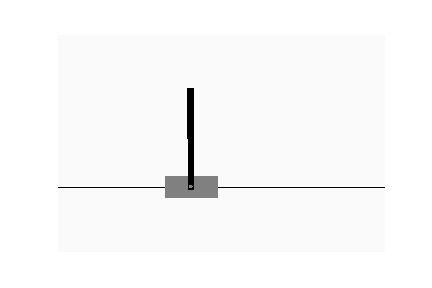
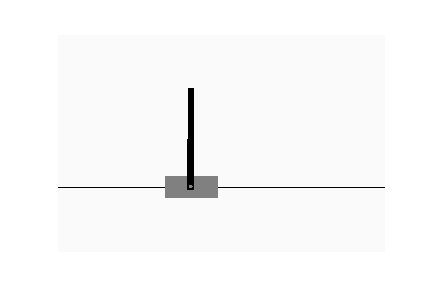
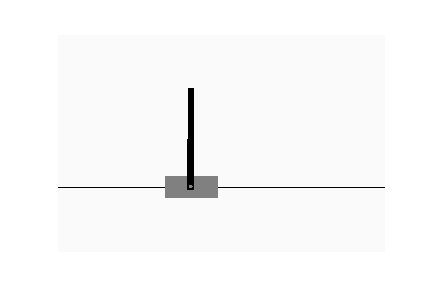
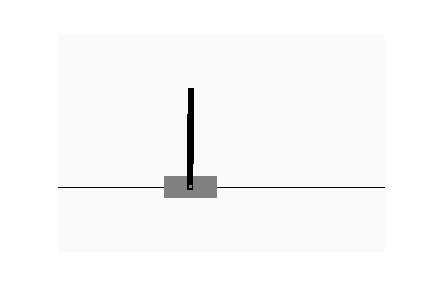
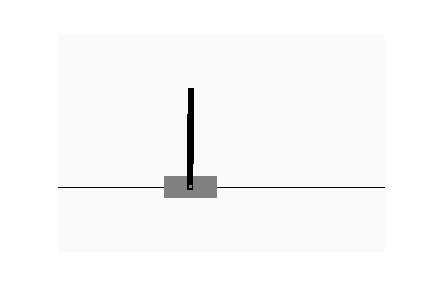
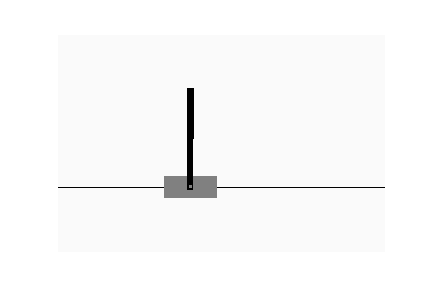
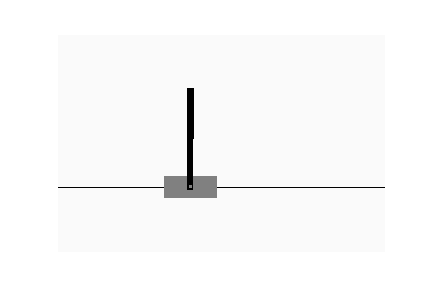
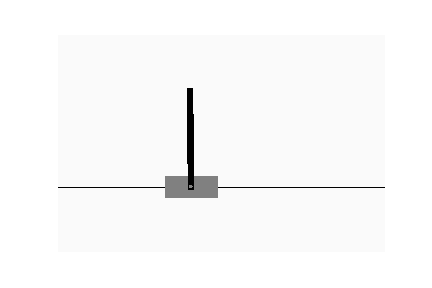
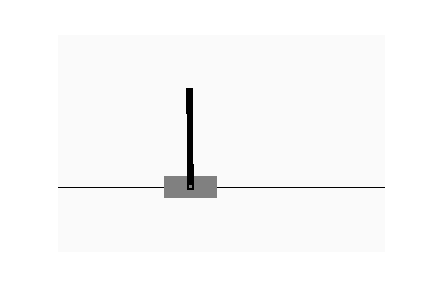
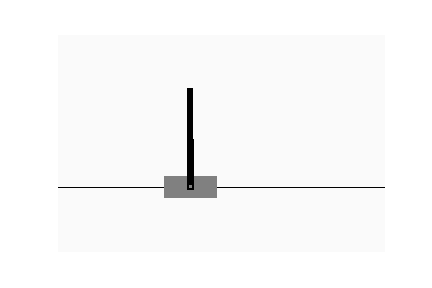
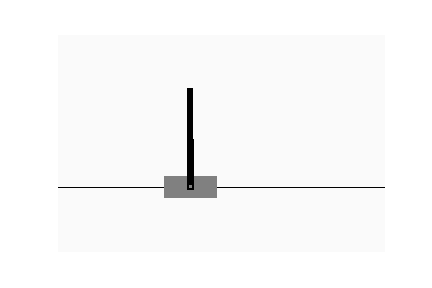
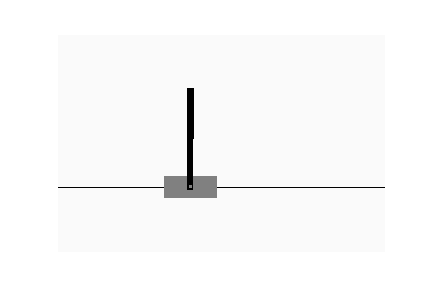
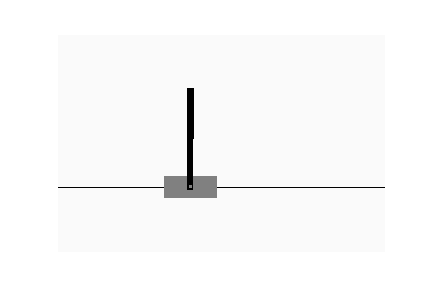
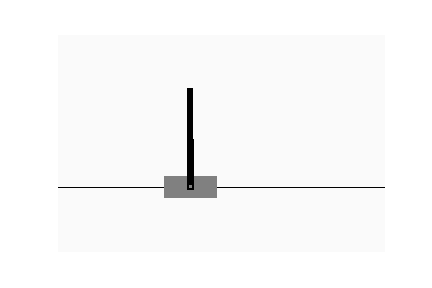
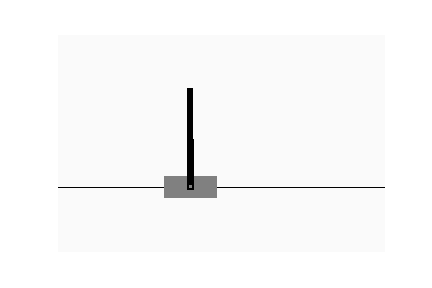
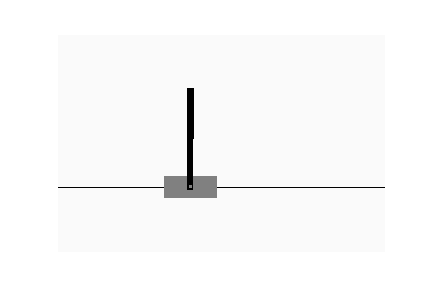
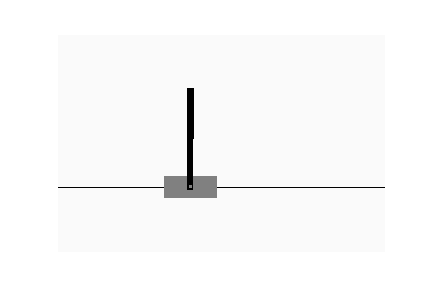
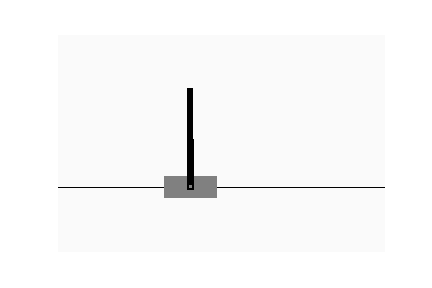
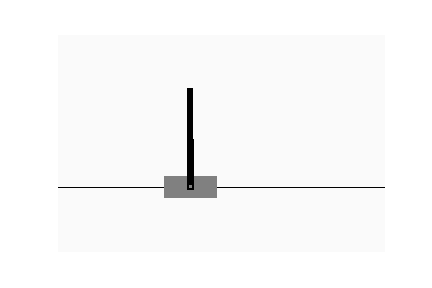
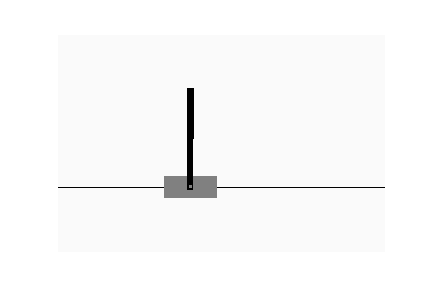
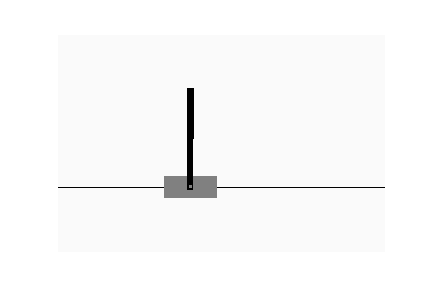
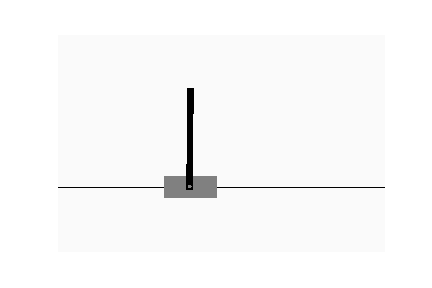
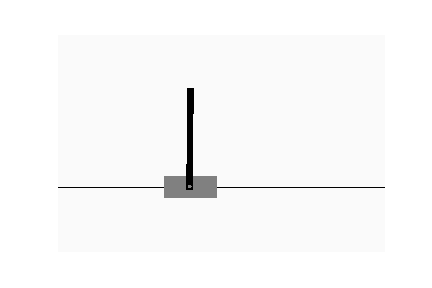
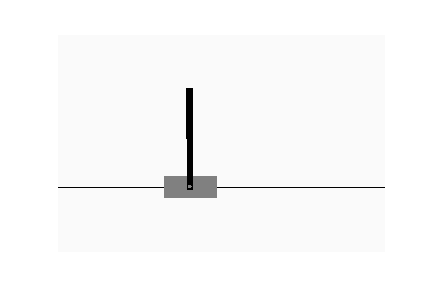
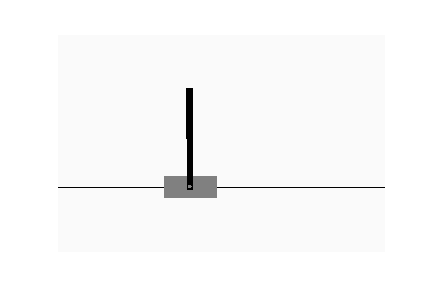
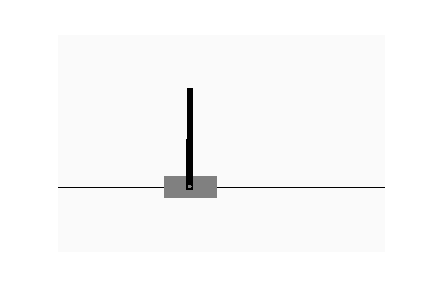
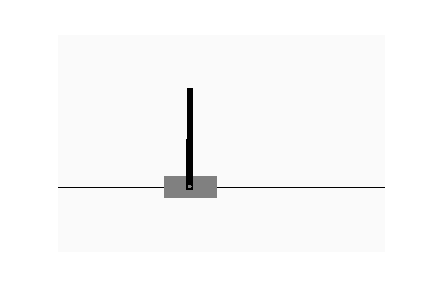
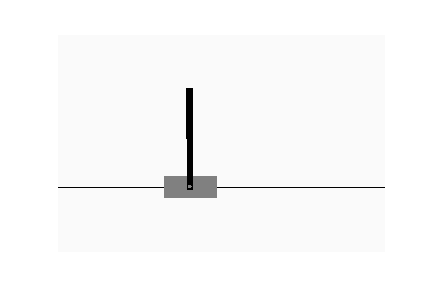
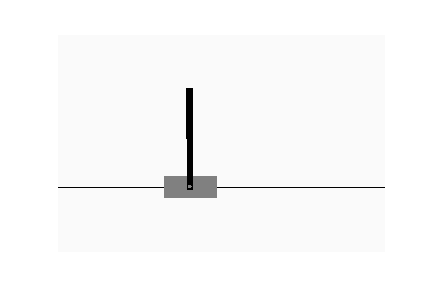
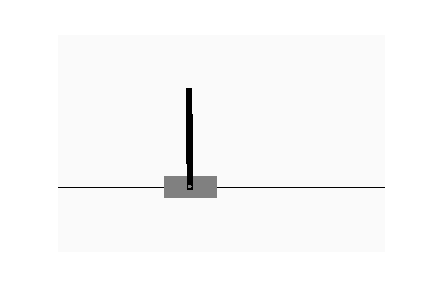
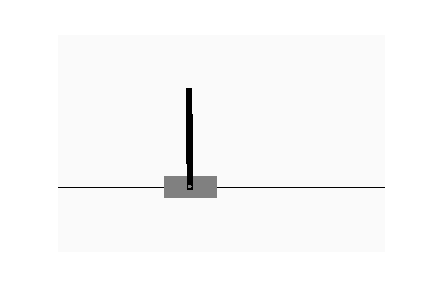
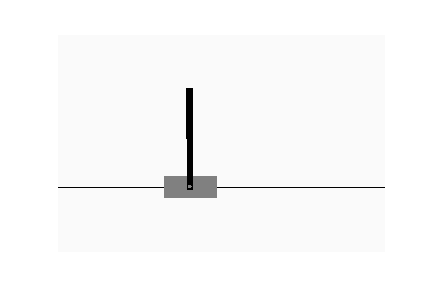
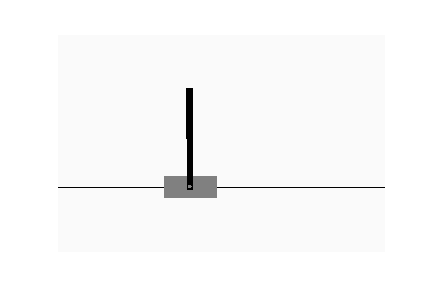
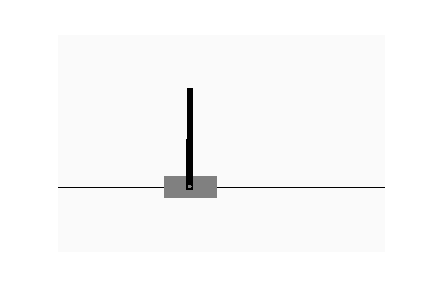
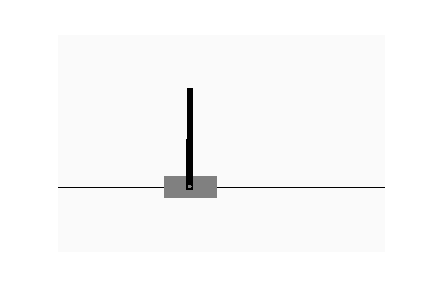
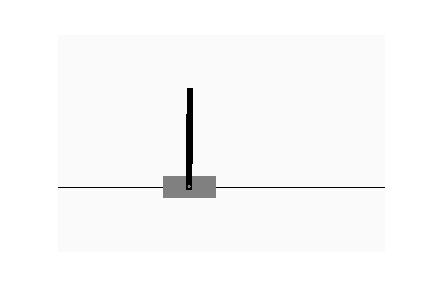
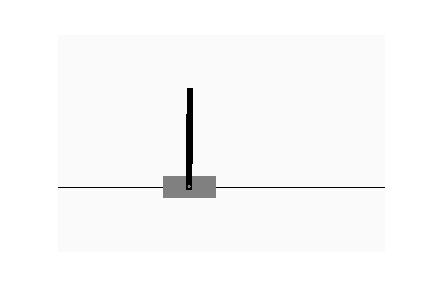
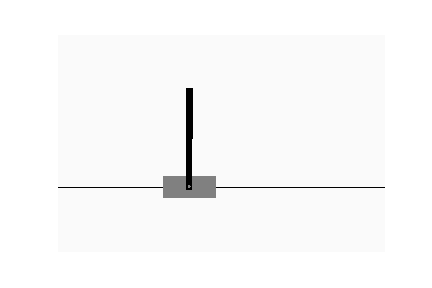
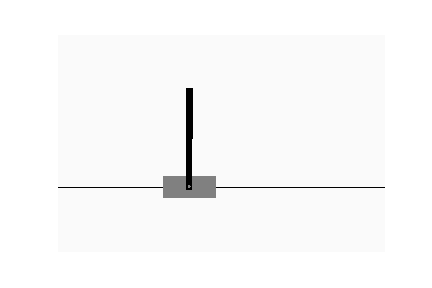
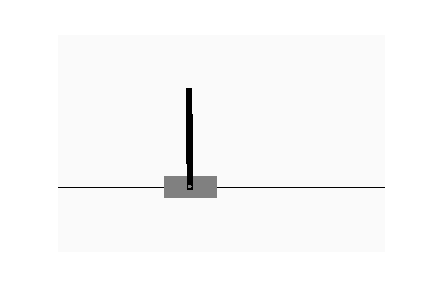
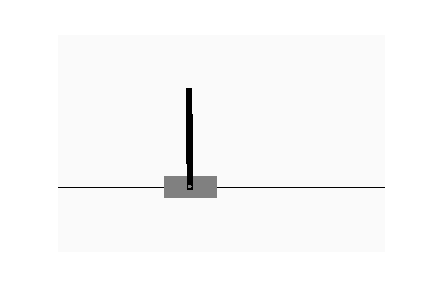
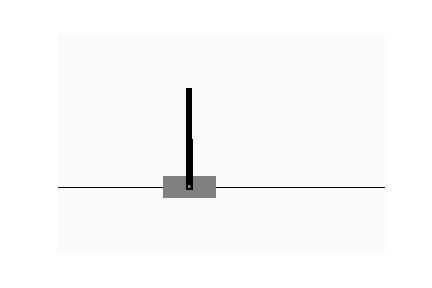
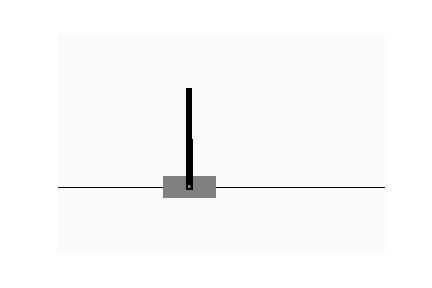
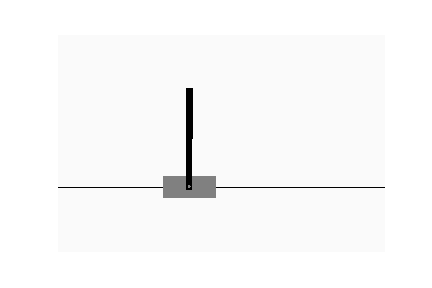
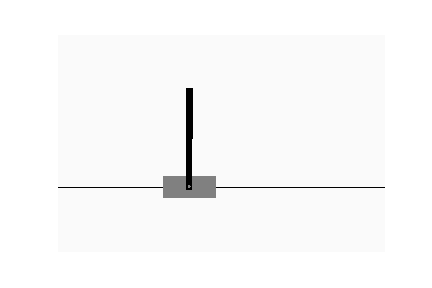
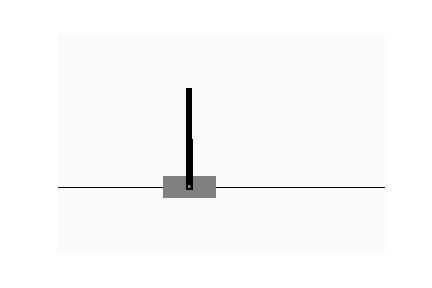
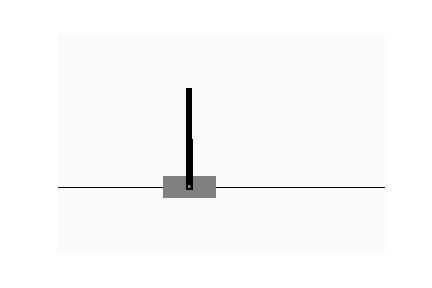
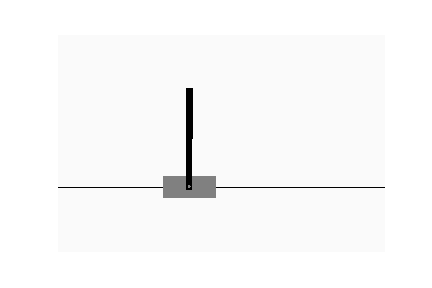
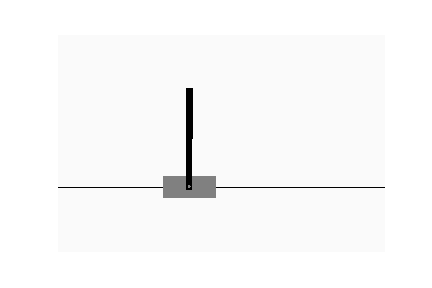
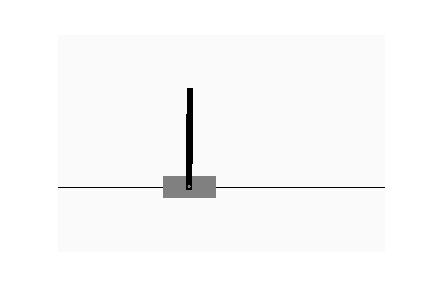
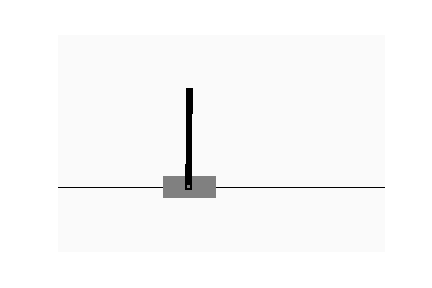
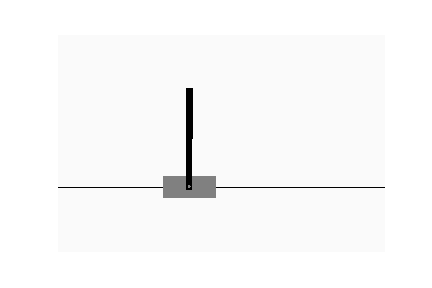
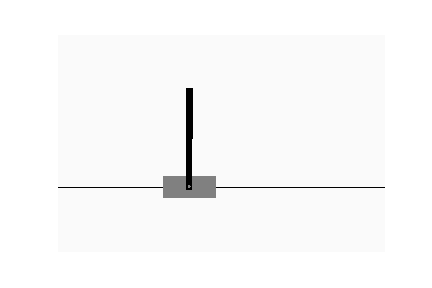
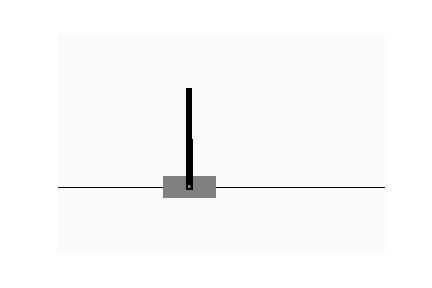
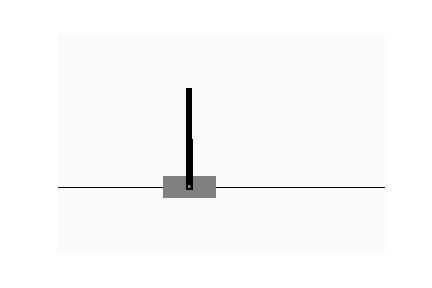
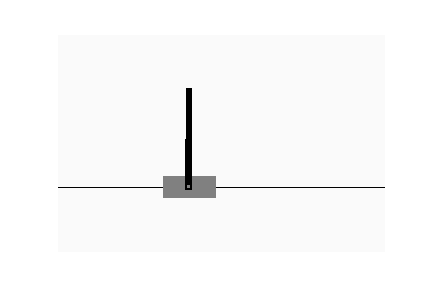
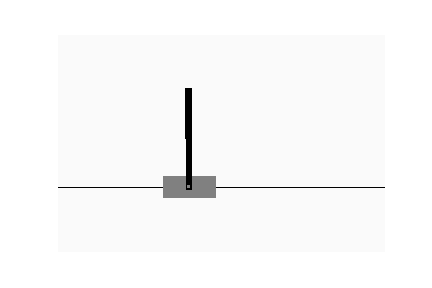
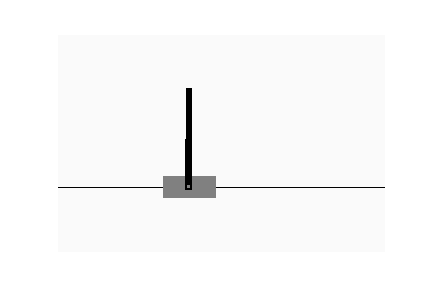
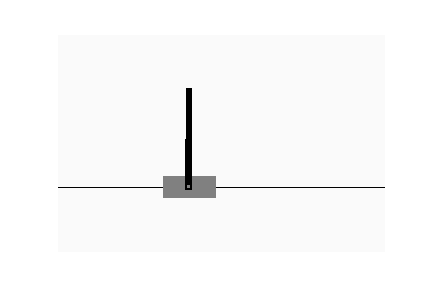
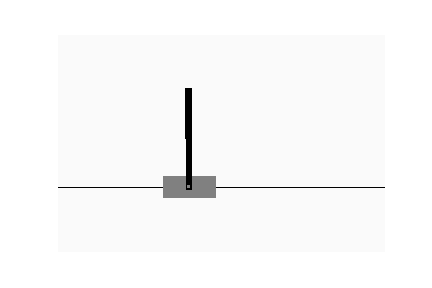
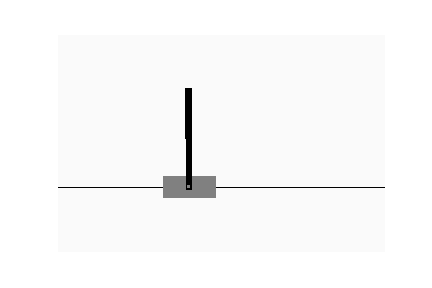
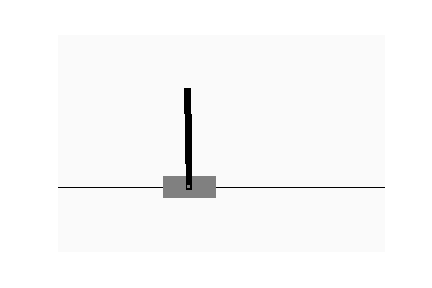
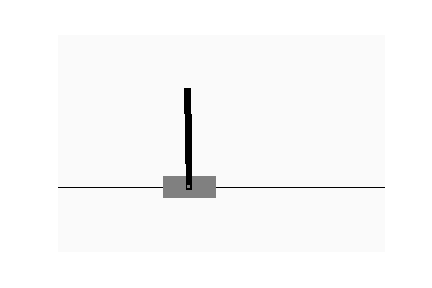
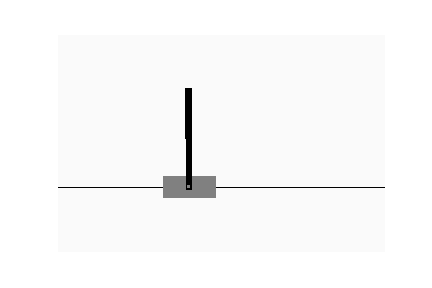
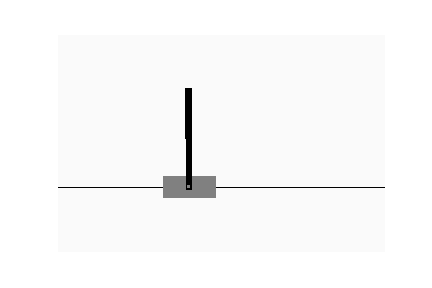
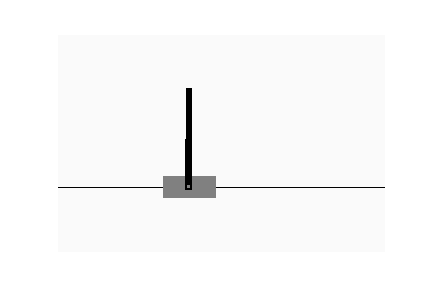
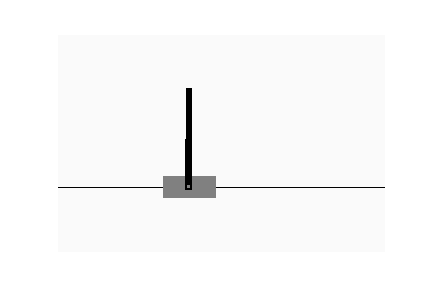
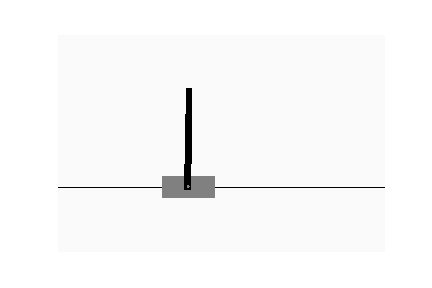
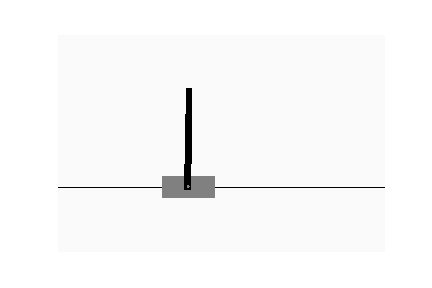
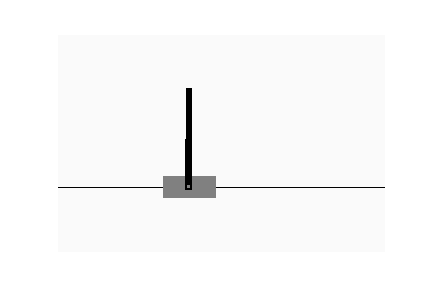
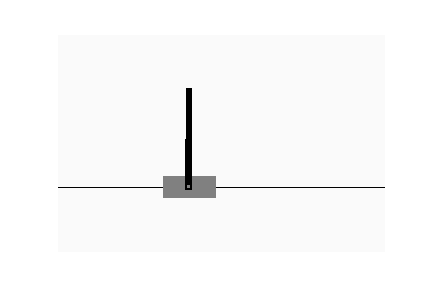
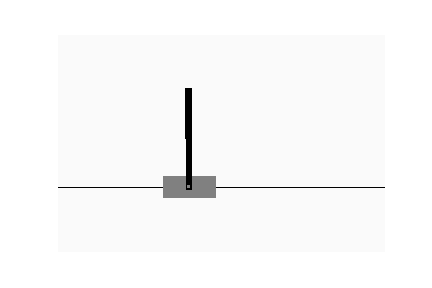
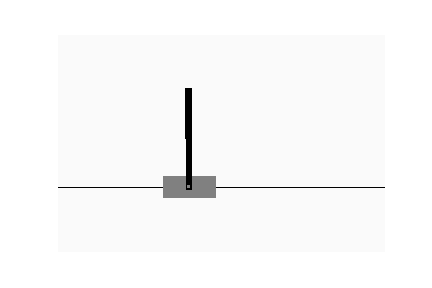
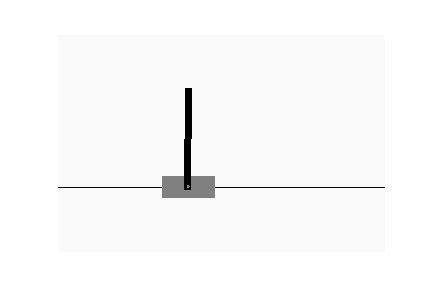
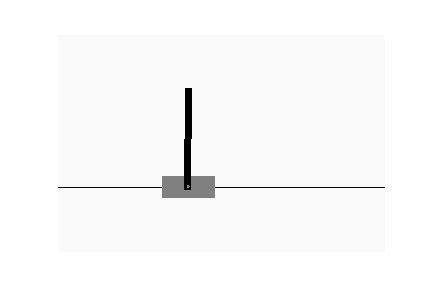
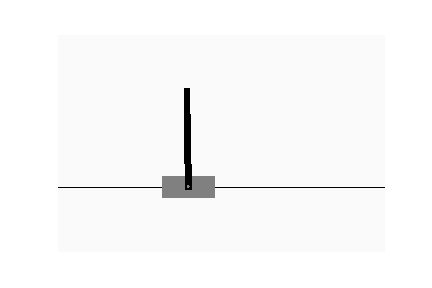
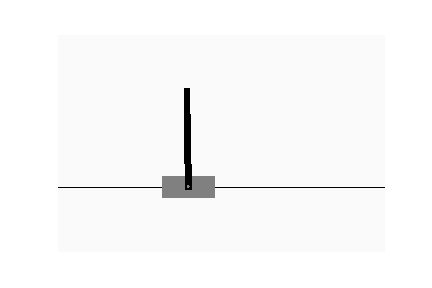
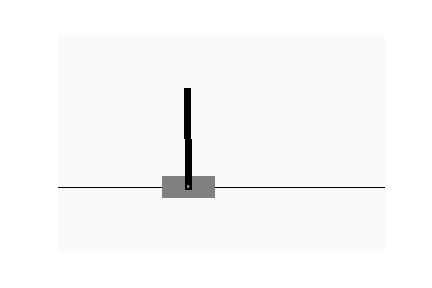
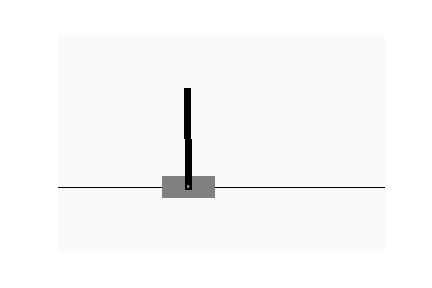
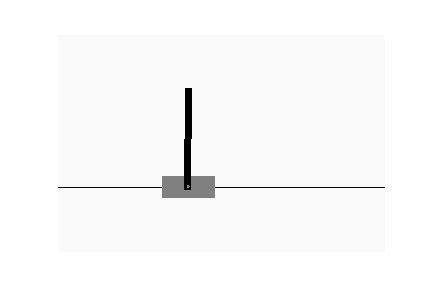
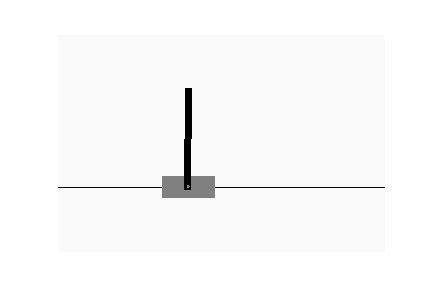
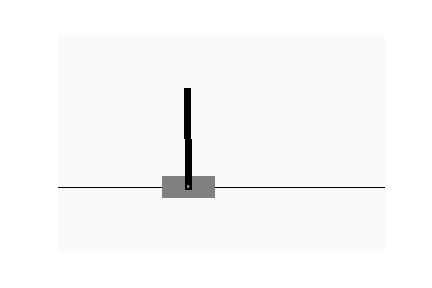
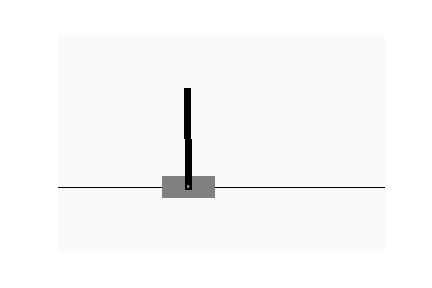
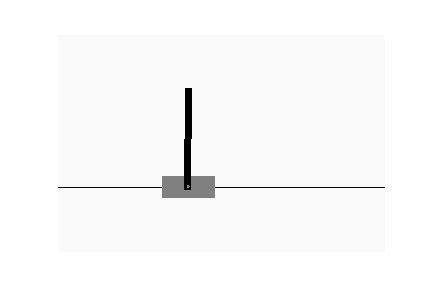
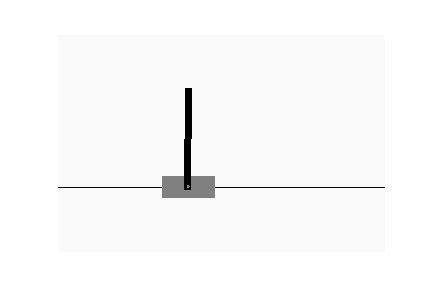

In [79]:
# review solution
with tf.Session() as sess:
    saver.restore(sess, "tmp/model.ckpt")
    s = env.reset()
    view = Viewer(env, custom_render=True)
    for _ in range(1000):
        view.render()
        a = get_action(sess, s, stochastic=False)
        s, r, done, _ = env.step(a)
    view.render(close=True, display_gif=True)

## Exercises

Now it is your turn! Play around with the code above and try to make it learn better and faster.

Experiment with the:

* number of timesteps in a batch.
* max length of rollouts.
* discount factor.
* learning rate.
* number of hidden units and layers.


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

First, in order to speed-up training, I found a higher learning-rate which was stable for the validation rewards.
The number of epochs and time-steps was also lowered for this experimentation.
The value was 0.05 for the learning-rate.

Then, in order to find a good discount factor I tested various values which allowed me to quickly get a high validation reward.
This gave a discount factor of 0.9.

Thereafter, I increased the network size by adding another layer with 15 neurons to increase the power of the network.
The learning-rate was set to 0.2 and the number of time-steps to 500 and epochs to 400.
We increase the number of time-steps to ensure that we look far enough into the future.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps: [0, 1, 1, 1, 0, 1, 1, 0, 0, 0].*

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*[Hint: See previous notebook.]*

Given a series of transitions consisting of $T$ timesteps, it is straight forward to compute the **total reward**:

$$
R = r_1 + r_2 + r_3 + \dots + r_T \ ,
$$

We then get the **total reward** as

$$
R = 5 \ ,
$$

The total future reward at timestep $t$ is:

$$
R_t = r_t + r_{t+1} + r_{t+2} + \dots + r_T \ .
$$

we can then compute the **total future reward** in each time step

$$
R_1 = r_1 + r_{2} + r_{3} + \dots + r_{10} = 5 \ ,
$$
$$
R_2 = r_{2} + r_{3} + \dots + r_{10} = 5 \ ,
$$
$$
R_3 = 4 \ ,
$$
$$
R_4 = 3 \ ,
$$
$$
R_5 = 2 \ ,
$$
$$
R_6 = 2 \ ,
$$
$$
R_7 = 1 \ ,
$$
$$
R_8 = 0 \ ,
$$
$$
R_9 = 0 \ ,
$$
$$
R_{10} = 0 \ .
$$

With $\gamma = 0.9$ we use the following formulas

$$
R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T-1} r_T = r_t + \gamma R_{t+1}
$$

to compute the results again with the **discount factor**

$$
R_1 = r_1 + \gamma R_2 = 3.560931 \ ,
$$
$$
R_2 = r_2 + \gamma R_3 = 3.95659 \ ,
$$
$$
R_3 = r_3 + \gamma R_4 = 3.2851 \ ,
$$
$$
R_4 = r_4 + \gamma R_5 = 2.539 \ ,
$$
$$
R_5 = r_5 + \gamma R_6 = 1.7 \ ,
$$
$$
R_6 = r_6 + \gamma R_7 = 1.9 \ ,
$$
$$
R_7 = r_7 + \gamma R_8 = 1   \ ,
$$
$$
R_8 = 0 \ ,
$$
$$
R_9 = 0 \ ,
$$
$$
R_{10} = 0 \ .
$$


### Exercise 3

*In the plot of the training and validation mean reward above, you will sometimes see the validation reward starts out lower than the training reward but later they cross. How can you explain this behavior? [Hint: Do we use the policy network in the same way during training and validation?]*

Answer: We do not use the policy network in the same way during training and validation.
In training, we continue to do rollouts until we hit *timesteps* less than or equal to *batch_size* while for validation we just do one roll_out of the specified length.
As the reward is a sum, there will be a difference.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma (see the previous notebook for definition)?*

Answer: The exploration-explotation dillema arises becase an agent needs to exploit the currently best action to maximize the reward greedily, yet it also has to explore the environment to find better actions, so when do we stop?

When we train, we note that ``stochastic=True``.
Initially, all actions will have the same probability and we will make a random choice.
When training, we discover which choices make the most sense, since the actions which are beneficial are forced to become more likely.
Thus, when we train, the network learns which actions are good and we go away from exploring the space.
The learning-rate then determines how quickly we go more into exploitation, as a larger learning-rate will change the policy faster and thus reduce the exploration space as bad choices will be removed.


## [Book Exercise](http://neuralnetworksanddeeplearning.com/chap3.html#exercise_195778)

*As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images?*

A problem with too large rotations is that e.g. a 9 can become a 6 and vice versa, the network will then get what is labelled as a 9, but what a human would label as a 6.

Moreover, for the variational autoencoder, it was hard to distinguish between 4 and 9, so we could imagine that rotations would mean that 4 and 6 started occupying the same latent space.